In [298]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tabulate import tabulate
from IPython.display import display, HTML
import seaborn as sns
import csv
import os
import logging
import math
import re

In [299]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [300]:
#https://stackoverflow.com/questions/46135839/auto-detect-the-delimiter-in-a-csv-file-using-pd-read-csv comme base
#detecte automatiquement le sep d'un fichier csv
def get_delimiter(file_path, bytes=4096):
    try:
        with open(file_path, 'r') as file:
            data = file.read(bytes)
        sniffer = csv.Sniffer()
        delimiter = sniffer.sniff(data).delimiter
        return delimiter
    except Exception as e:
        logging.error(f"Erreur lors de la détection du délimiteur: {e}")
        return None

In [301]:
#lecture d'un fichier csv en essayant différents encodage.
def read_csv_file(file_path):
    if not os.path.exists(file_path):
        return None, False, f"Fichier non trouvé: {file_path}"
    
    delimiter = get_delimiter(file_path)
    if not delimiter:
        return None, False, f"Impossible de détecter le délimiteur pour le fichier: {file_path}"
    
    encodings = ['utf-8', 'latin1', 'ISO-8859-1']
    for encoding in encodings:
        try:
            df = pd.read_csv(file_path, low_memory=False, encoding=encoding, delimiter=delimiter)
            return df, True, None
        except (UnicodeDecodeError, pd.errors.ParserError) as e:
            logging.warning(f"Erreur avec l'encodage {encoding} pour le fichier {file_path}: {e}")
    
    return None, False, f"Impossible de lire le fichier {file_path} avec les encodages: {encodings}."

In [302]:
#chargement des datasets dans des listes
def load_datasets(prefixes, years, base_path='data/raw'):
    dataframes = []
    
    for prefix in prefixes:
        datasets = []
        for year in years:
            connector = '_' if year <= 2016 else '-'
            file_name = os.path.join(base_path, f'{prefix}{connector}{year}.csv')
            df, success, error = read_csv_file(file_name)
            if success:
                datasets.append({file_name: df})
            else:
                logging.error(error)
        dataframes.append(datasets)
    
    return dataframes

In [303]:
years = list(range(2005, 2023))
prefixes= ['caracteristiques', 'lieux', 'usagers', 'vehicules']

dataframes = load_datasets(prefixes, years)

#log
for prefix, df_list in zip(prefixes, dataframes):
        logging.info(f'{prefix}: {len(df_list)} datasets chargés.')

logging.info(f'Total datasets chargés: {sum(len(dfs) for dfs in dataframes)}.')

2024-06-10 17:10:05,843 - WARNING - Erreur avec l'encodage utf-8 pour le fichier data/raw\caracteristiques_2005.csv: 'utf-8' codec can't decode byte 0xe9 in position 13: invalid continuation byte


2024-06-10 17:10:06,110 - WARNING - Erreur avec l'encodage utf-8 pour le fichier data/raw\caracteristiques_2006.csv: 'utf-8' codec can't decode byte 0xb0 in position 6: invalid start byte
2024-06-10 17:10:06,301 - WARNING - Erreur avec l'encodage utf-8 pour le fichier data/raw\caracteristiques_2007.csv: 'utf-8' codec can't decode byte 0xe9 in position 1: invalid continuation byte
2024-06-10 17:10:06,480 - WARNING - Erreur avec l'encodage utf-8 pour le fichier data/raw\caracteristiques_2008.csv: 'utf-8' codec can't decode byte 0xf4 in position 17: invalid continuation byte
2024-06-10 17:10:06,744 - WARNING - Erreur avec l'encodage utf-8 pour le fichier data/raw\caracteristiques_2010.csv: 'utf-8' codec can't decode byte 0xe9 in position 8: invalid continuation byte
2024-06-10 17:10:06,905 - WARNING - Erreur avec l'encodage utf-8 pour le fichier data/raw\caracteristiques_2011.csv: 'utf-8' codec can't decode byte 0xe9 in position 5: invalid continuation byte
2024-06-10 17:10:07,066 - WARNI

In [304]:
def extract_year(file_name):
    match = re.search(r'(\d{4})\.csv$', file_name)
    if match:
        return match.group(1)
    else:
        return None

In [305]:
def generate_navigation_menu(columns, dataset_name):
    links = [f'<a href="#{dataset_name}_{col}">{col}</a>' for col in columns]
    return f'<div id="menu_{dataset_name}"><h2>Menu {dataset_name}</h2><ul>{"".join(f"<li>{link}</li>" for link in links)}</ul></div>'

In [306]:
#création d'une grille de boxplot
def create_boxplot_grid(column, datasets):

    if not any(pd.api.types.is_numeric_dtype(df[column]) for dataset in datasets for file_name, df in dataset.items() if column in df.columns):
        logging.info(f"La colonne {column} n'est pas numérique.")
        return

    n_datasets = len(datasets)
    n_cols = 5
    n_rows = math.ceil(n_datasets / n_cols)
    
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(16, n_rows * 2), squeeze=False)
    fig.suptitle(f'Boxplots for column: {column}', fontsize=16)
    
    for ax, dataset in zip(axes.flatten(), datasets):
        for file_name, df in dataset.items():
            if column in df.columns and pd.api.types.is_numeric_dtype(df[column]):
                ax.boxplot(df[column].dropna(), vert=True)
                ax.set_title(extract_year(file_name))
                ax.set_xlabel(column)
                ax.set_ylabel('Values')
    
    # Masquer les axes non utilisés
    for ax in axes.flatten()[n_datasets:]:
        ax.axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [307]:
#création du bar plot pour visualiser la distribution des modalités.
def create_total_stacked_barplot(column, datasets, max_modalities=50):
    modality_counts = {}

    for dataset in datasets:
        for file_name, df in dataset.items():
            if column in df.columns:
                modality_count = df[column].value_counts()
                modality_counts[file_name] = modality_count
    
    all_modalities = set()
    for counts in modality_counts.values():
        all_modalities.update(counts.index)
    
    if len(all_modalities) > max_modalities:
        logging.warning(f"Le nombre de modalités uniques dans la colonne {column} excède le seuil de {max_modalities}. Auncun bar plot généré.")
        return
    
    modality_data = {modality: [] for modality in all_modalities}
    years = [extract_year(file_name) for file_name in modality_counts.keys()]
    
    for modality in all_modalities:
        for file_name in modality_counts.keys():
            count = modality_counts[file_name].get(modality, 0)
            modality_data[modality].append(count)
    
    df_modalities = pd.DataFrame(modality_data, index=years).transpose()
    
    df_modalities.plot(kind='bar', stacked=True, figsize=(15, 7), colormap='viridis')
    plt.title(f'{column}')
    plt.xlabel('Modalities')
    plt.ylabel('Count')
    plt.legend(title='Years', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [308]:
def create_lineplot_evolution(column, datasets, max_modalities=12):
    modality_counts = {}

    for dataset in datasets:
        for file_name, df in dataset.items():
            if column in df.columns:
                year = extract_year(file_name)
                modality_count = df[column].value_counts(normalize=True) * 100
                if year not in modality_counts:
                    modality_counts[year] = modality_count
                else:
                    modality_counts[year] = modality_counts[year].add(modality_count, fill_value=0)
    
    all_modalities = set()
    for counts in modality_counts.values():
        all_modalities.update(counts.index)
    
    if len(all_modalities) > max_modalities:
        logging.warning(f"Le nombre de modalités uniques dans la colonne {column} excède le seuil de {max_modalities}. Aucun graphique en ligne généré.")
        return
    
    modality_data = {modality: [] for modality in all_modalities}
    years = sorted(modality_counts.keys())
    
    for modality in all_modalities:
        for year in years:
            count = modality_counts[year].get(modality, 0)
            modality_data[modality].append(count)
    
    df_modalities = pd.DataFrame(modality_data, index=years)
    
    df_modalities.plot(kind='line', figsize=(15, 7), marker='o')
    plt.title(f'Evolution of Distribution for column: {column}')
    plt.xlabel('Years')
    plt.ylabel('Proportion (%)')
    plt.legend(title='Modalities', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [309]:
def analyze_column(column, datasets, total_rows, dataset_name):
    column_results = []
    
    for dataset in datasets:
        for file_name, df in dataset.items():
            if column in df.columns:
                col_type = df[column].dtype
                col_mode = df[column].mode()[0] if not df[column].mode().empty else "N/A"
                null_proportion_file = df[column].isnull().mean() *100
                null_proportion_total = df[column].isnull().sum() / total_rows
                column_results.append([
                    extract_year(file_name), 
                    col_type, 
                    col_mode, 
                    null_proportion_file, 
                    null_proportion_total
                ])
    
    if column_results:
        display(HTML(f'<div id="{dataset_name}_{column}"><h2>Colonne: {column}</h2>'))
        
        print(f"\nColonne: {column} / lignes: {total_rows}")
        print(tabulate(column_results, headers=[
            "Année", "Type", "Mode", 
            "Proportion valeurs nulles (fichier)", 
            "Proportion valeurs nulles (total)"
        ]))
        
        #if any(pd.api.types.is_numeric_dtype(df[column]) for dataset in datasets for file_name, df in dataset.items() if column in df.columns):
        create_boxplot_grid(column, datasets) 
        create_total_stacked_barplot(column, datasets)
        create_lineplot_evolution(column, datasets)

        display(HTML(f'<p><a href="#menu_{dataset_name}">Retour au menu</a></p></div>'))


In [310]:
#on analyse toutes les colonnes à la suite
def analyze_all_columns(datasets, dataset_name):
    all_columns = set()
    for dataset in datasets:
        for file_name, df in dataset.items():
            logging.info(f'Chargement de {file_name}.')
            all_columns.update(df.columns)
    
    total_rows = sum(df.shape[0] for dataset in datasets for file_name, df in dataset.items())
    
    navigation_menu = generate_navigation_menu(all_columns, dataset_name)
    display(HTML(navigation_menu))

    #traitement pour chaque colonne
    for column in all_columns:
        analyze_column(column, datasets, total_rows, dataset_name)
            

2024-06-10 17:10:14,135 - INFO - Chargement de data/raw\caracteristiques_2005.csv.
2024-06-10 17:10:14,136 - INFO - Chargement de data/raw\caracteristiques_2006.csv.
2024-06-10 17:10:14,137 - INFO - Chargement de data/raw\caracteristiques_2007.csv.
2024-06-10 17:10:14,138 - INFO - Chargement de data/raw\caracteristiques_2008.csv.
2024-06-10 17:10:14,139 - INFO - Chargement de data/raw\caracteristiques_2009.csv.
2024-06-10 17:10:14,140 - INFO - Chargement de data/raw\caracteristiques_2010.csv.
2024-06-10 17:10:14,141 - INFO - Chargement de data/raw\caracteristiques_2011.csv.
2024-06-10 17:10:14,141 - INFO - Chargement de data/raw\caracteristiques_2012.csv.
2024-06-10 17:10:14,142 - INFO - Chargement de data/raw\caracteristiques_2013.csv.
2024-06-10 17:10:14,142 - INFO - Chargement de data/raw\caracteristiques_2014.csv.
2024-06-10 17:10:14,143 - INFO - Chargement de data/raw\caracteristiques_2015.csv.
2024-06-10 17:10:14,144 - INFO - Chargement de data/raw\caracteristiques_2016.csv.
2024

2024-06-10 17:10:14,994 - INFO - La colonne adr n'est pas numérique.



Colonne: adr / lignes: 1176873
  Année  Type    Mode             Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  -------------  -------------------------------------  -----------------------------------
   2005  object  AUTOROUTE A1                               19.2908                            0.0142649
   2006  object  AUTOROUTE A1                               13.4132                            0.00945896
   2007  object  AUTOROUTE A1                               17.8366                            0.0127083
   2008  object  AUTOROUTE A1                               19.382                             0.0126428
   2009  object  A13                                        17.307                             0.0109426
   2010  object  AUTOROUTE A1                               16.629                             0.0098031
   2011  object  A13                                        16.3048                            0.00927883
   2012  object  

2024-06-10 17:10:15,389 - WARNING - Le nombre de modalités uniques dans la colonne adr excède le seuil de 50. Auncun bar plot généré.
2024-06-10 17:10:15,804 - WARNING - Le nombre de modalités uniques dans la colonne adr excède le seuil de 12. Aucun graphique en ligne généré.



Colonne: lat / lignes: 1176873
  Année  Type     Mode              Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  --------------  -------------------------------------  -----------------------------------
   2005  float64  0.0                                          69.0403                            0.0510531
   2006  float64  0.0                                          70.7686                            0.049906
   2007  float64  0.0                                          71.9129                            0.0512366
   2008  float64  0.0                                          71.8056                            0.0468385
   2009  float64  4.0                                          54.9813                            0.0347625
   2010  float64  0.0                                          54.5064                            0.0321326
   2011  float64  0.0                                          54.1748                            0.030

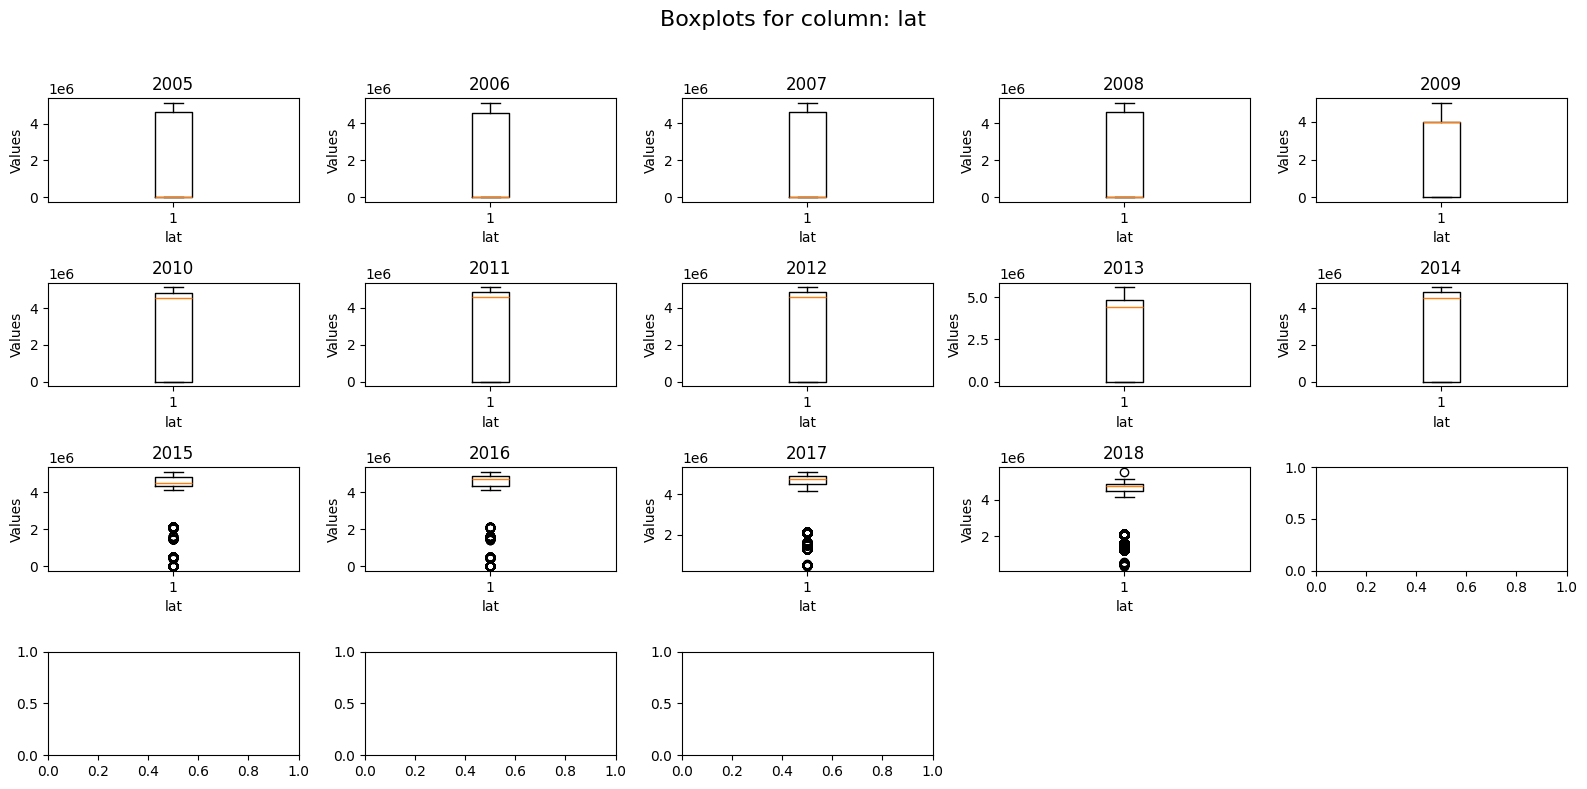

2024-06-10 17:10:17,847 - WARNING - Le nombre de modalités uniques dans la colonne lat excède le seuil de 50. Auncun bar plot généré.
2024-06-10 17:10:18,072 - WARNING - Le nombre de modalités uniques dans la colonne lat excède le seuil de 12. Aucun graphique en ligne généré.



Colonne: lum / lignes: 1176873
  Année  Type      Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  ------  -------------------------------------  -----------------------------------
   2005  int64        1                                      0                                    0
   2006  int64        1                                      0                                    0
   2007  int64        1                                      0                                    0
   2008  int64        1                                      0                                    0
   2009  int64        1                                      0                                    0
   2010  int64        1                                      0                                    0
   2011  int64        1                                      0                                    0
   2012  int64        1                                      0      

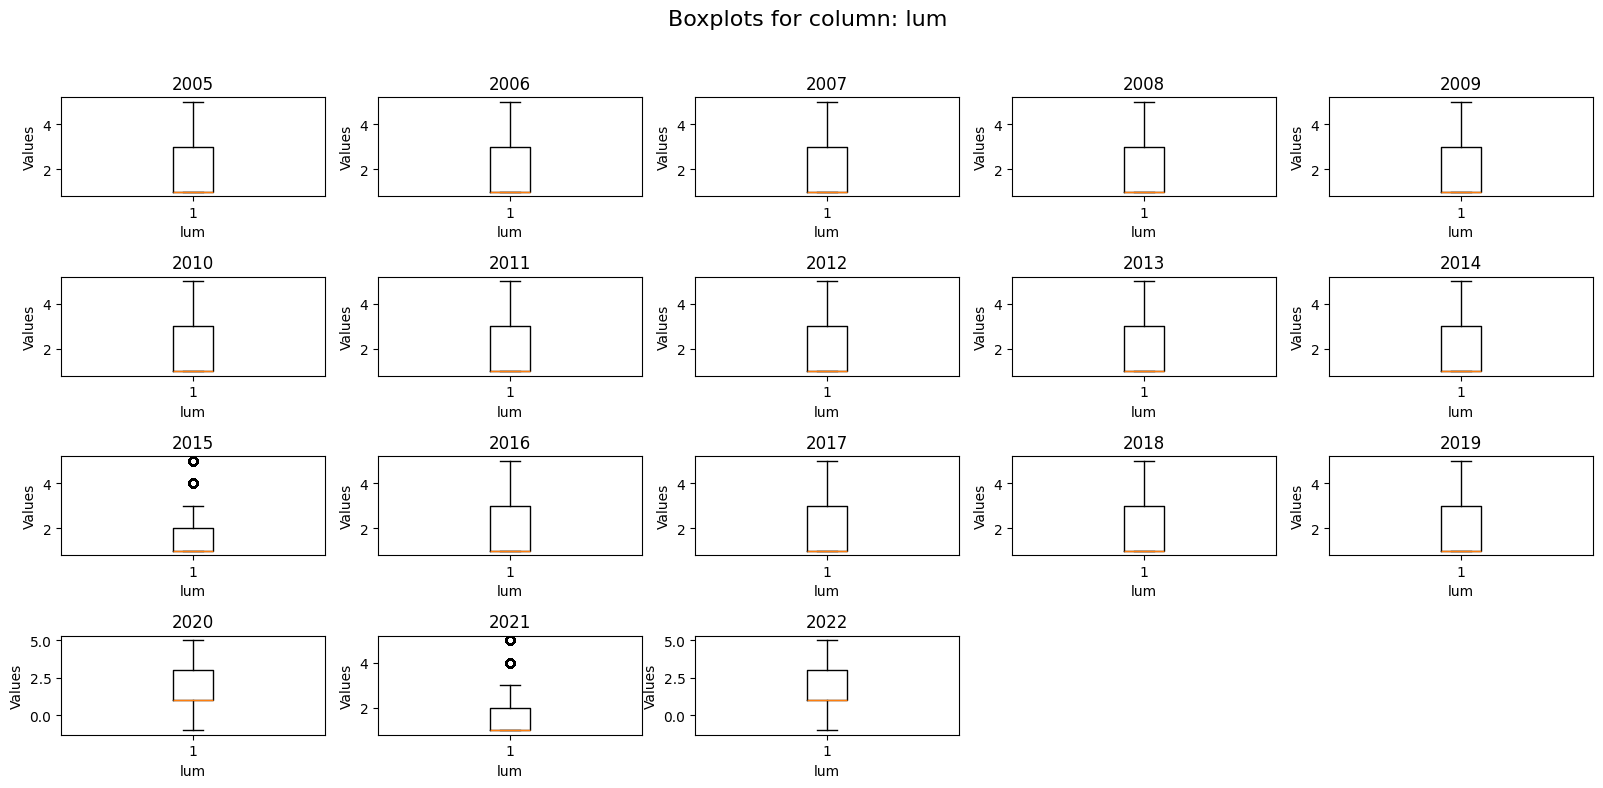

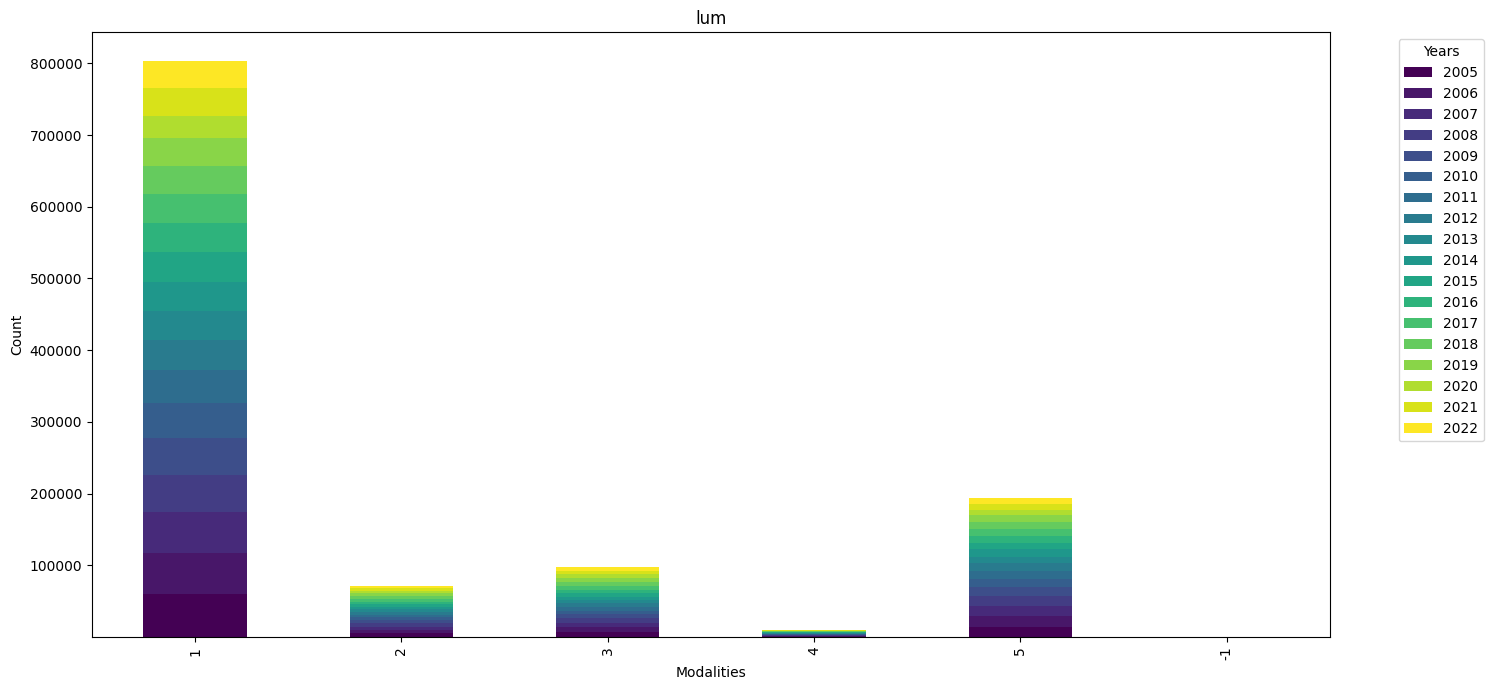

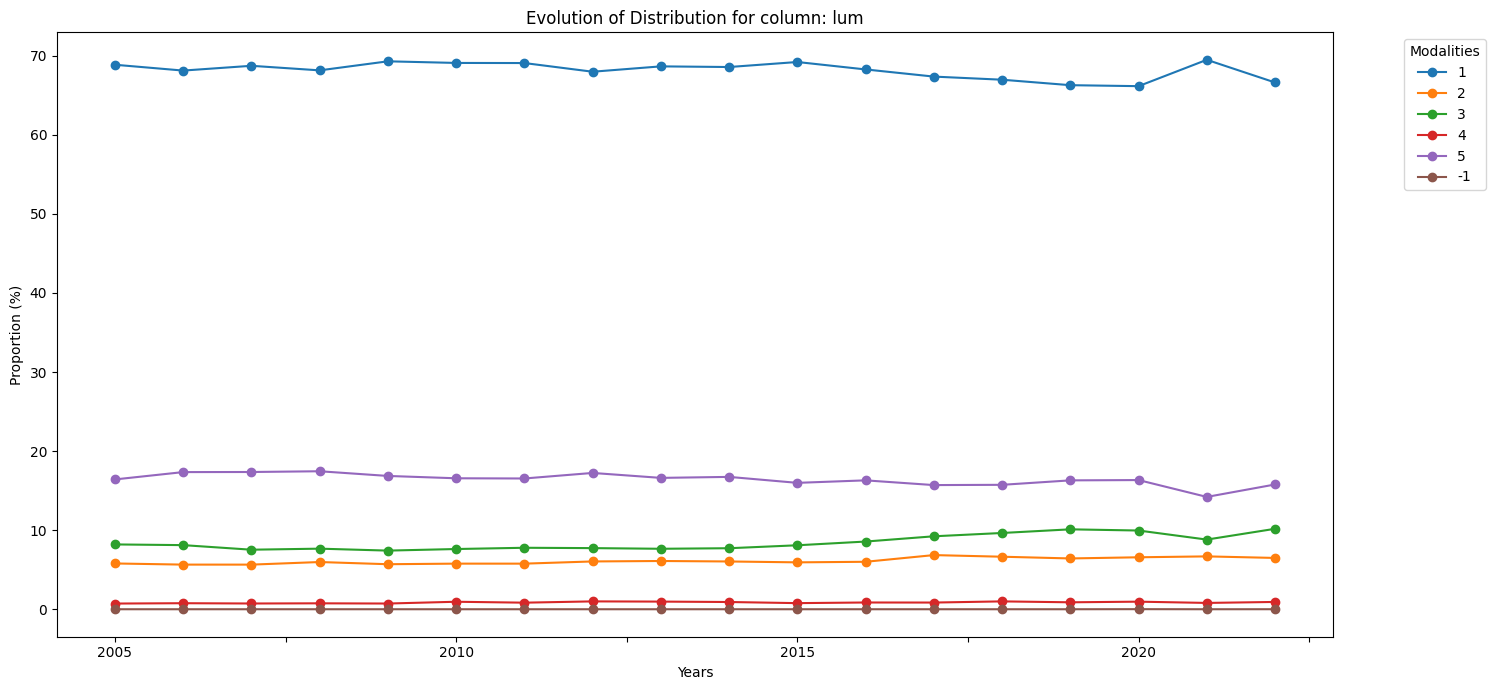


Colonne: jour / lignes: 1176873
  Année  Type      Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  ------  -------------------------------------  -----------------------------------
   2005  int64       19                                      0                                    0
   2006  int64       13                                      0                                    0
   2007  int64        6                                      0                                    0
   2008  int64        4                                      0                                    0
   2009  int64       17                                      0                                    0
   2010  int64       15                                      0                                    0
   2011  int64        8                                      0                                    0
   2012  int64       21                                      0     

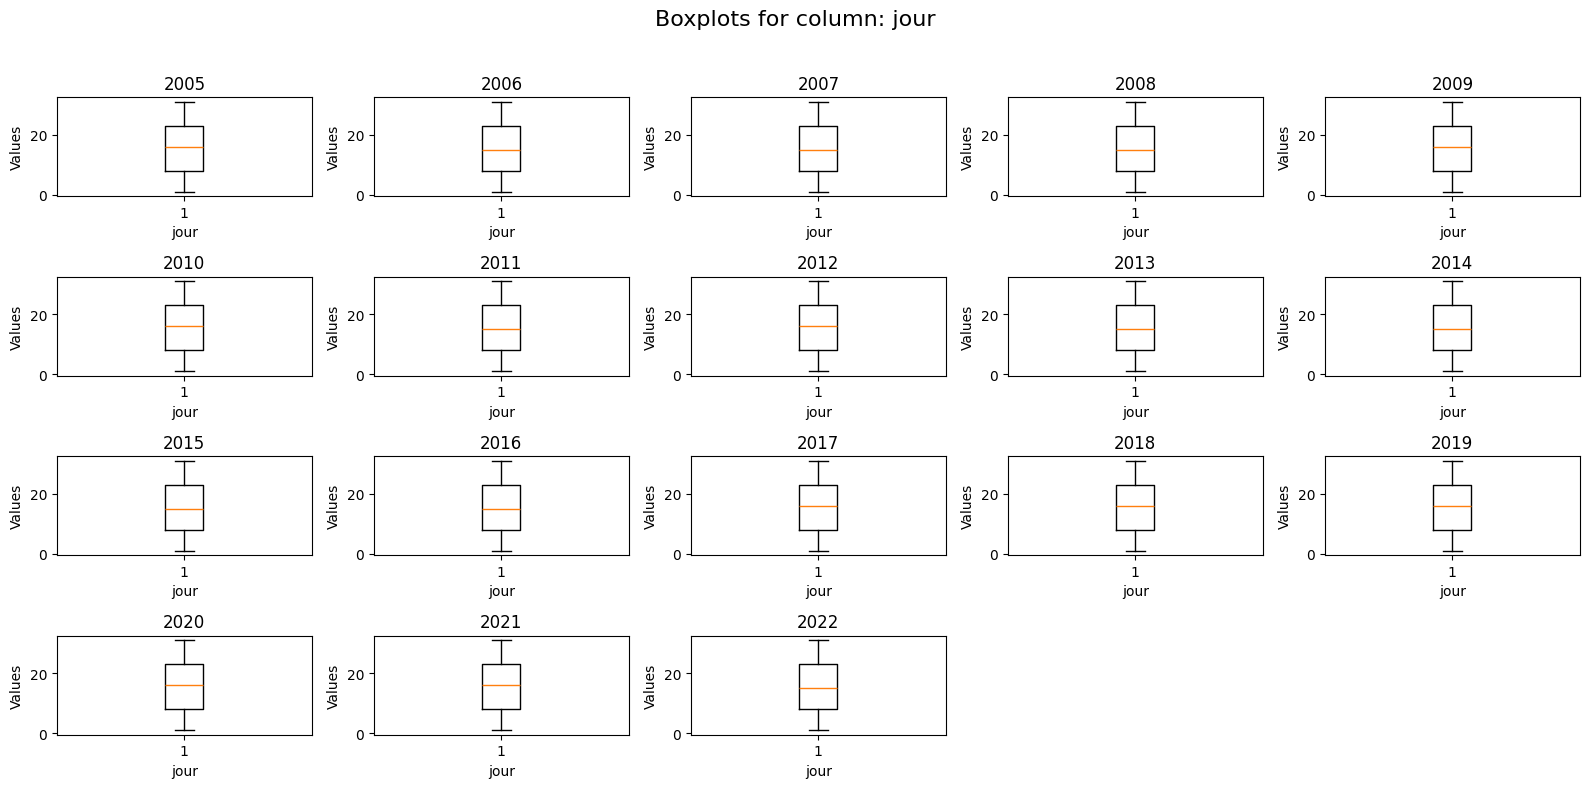

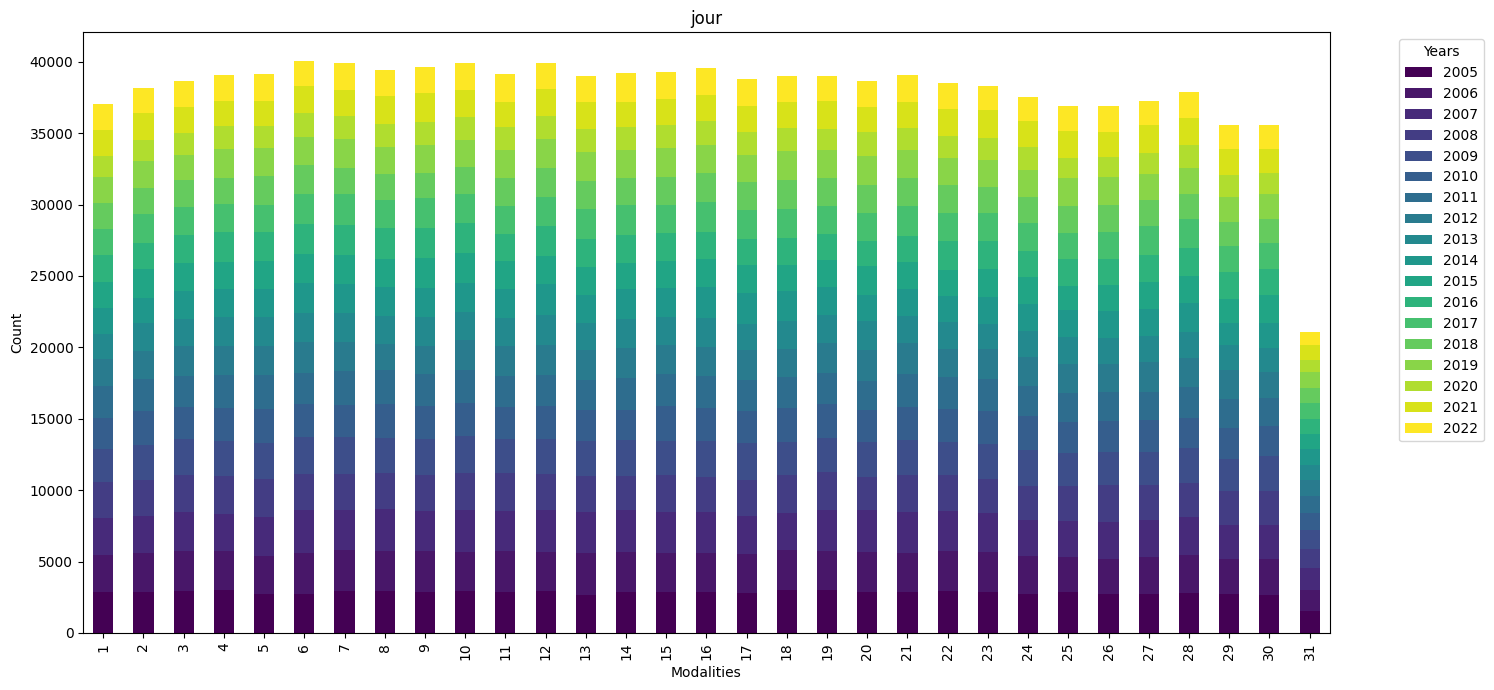

2024-06-10 17:10:23,040 - WARNING - Le nombre de modalités uniques dans la colonne jour excède le seuil de 12. Aucun graphique en ligne généré.



Colonne: mois / lignes: 1176873
  Année  Type      Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  ------  -------------------------------------  -----------------------------------
   2005  int64        6                                      0                                    0
   2006  int64        6                                      0                                    0
   2007  int64       10                                      0                                    0
   2008  int64       10                                      0                                    0
   2009  int64        6                                      0                                    0
   2010  int64       10                                      0                                    0
   2011  int64        5                                      0                                    0
   2012  int64       10                                      0     

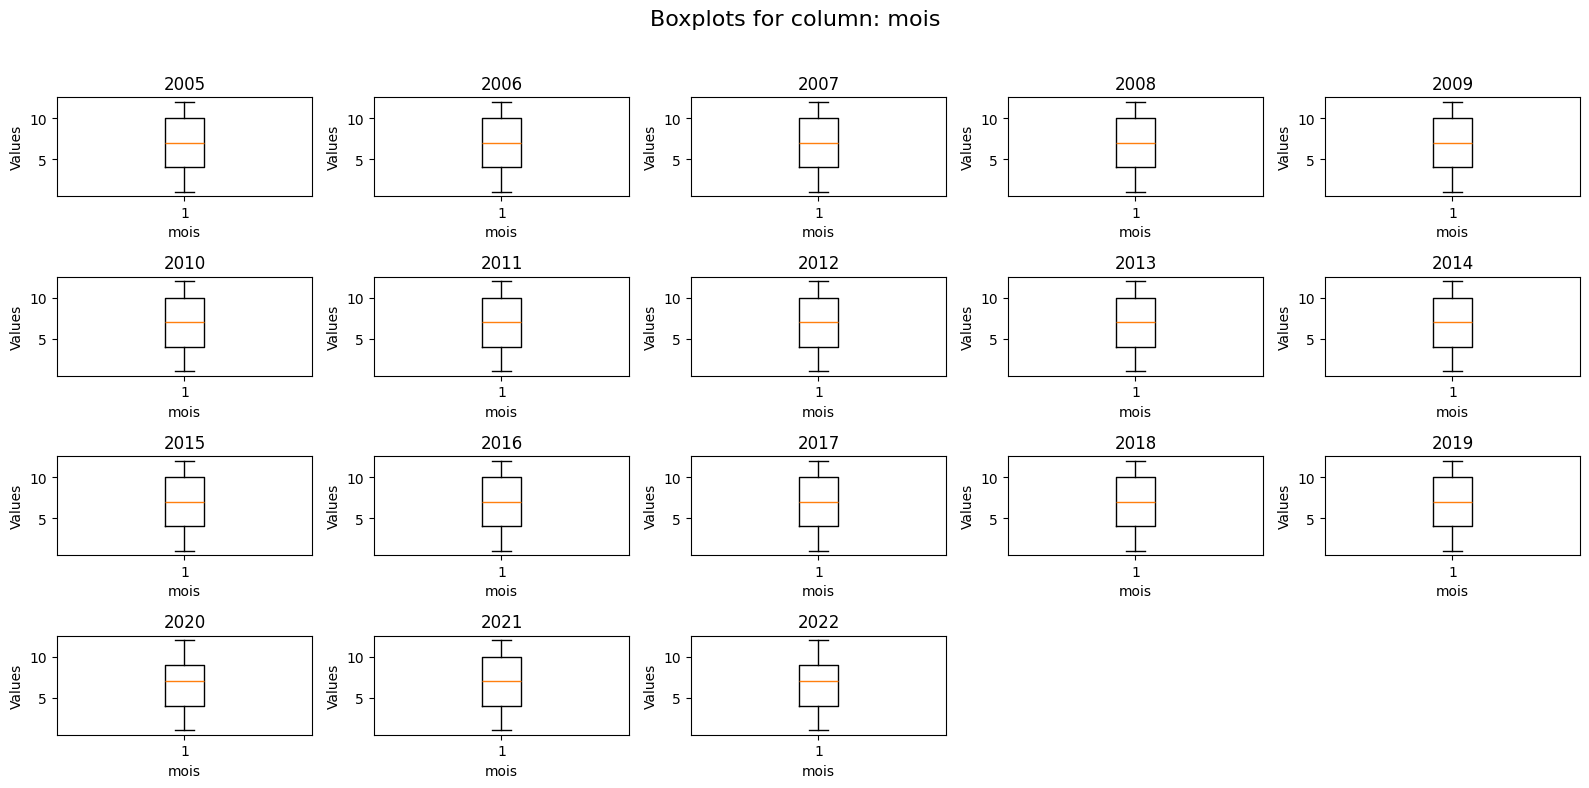

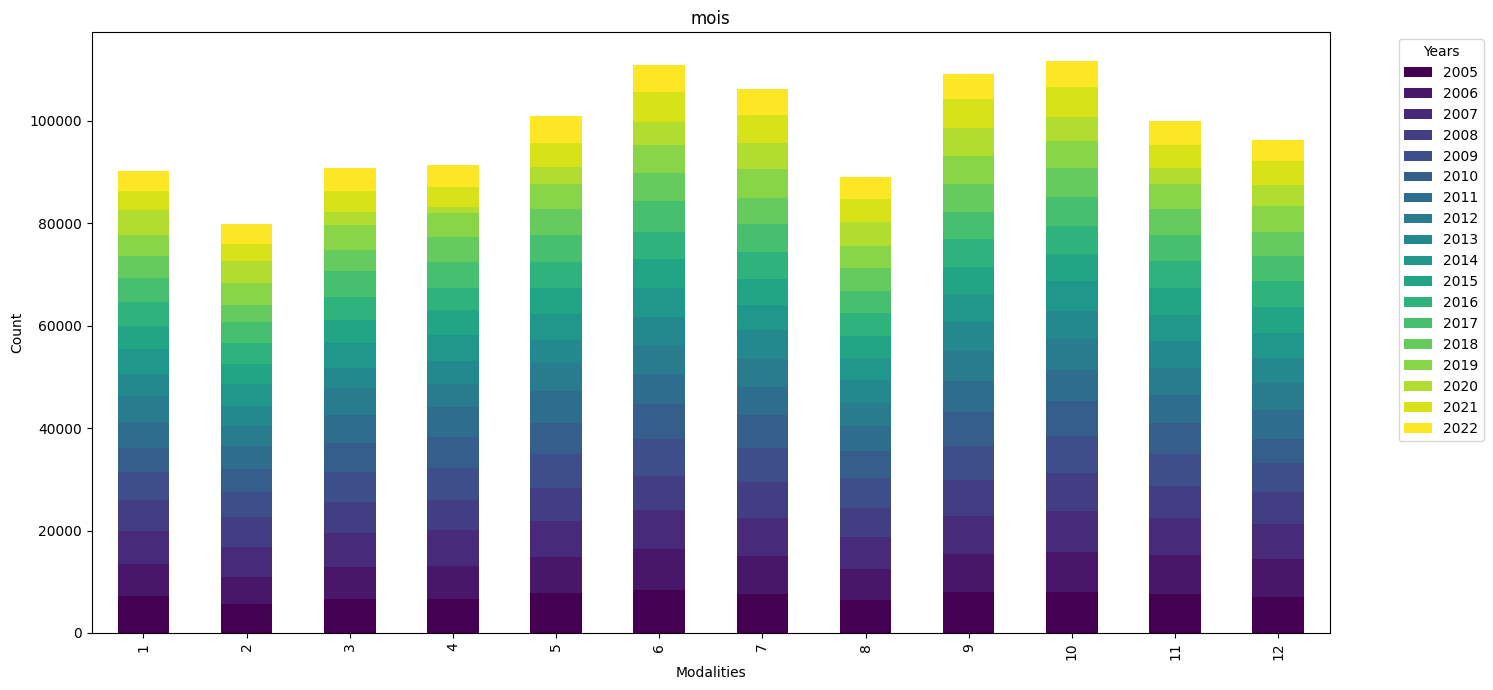

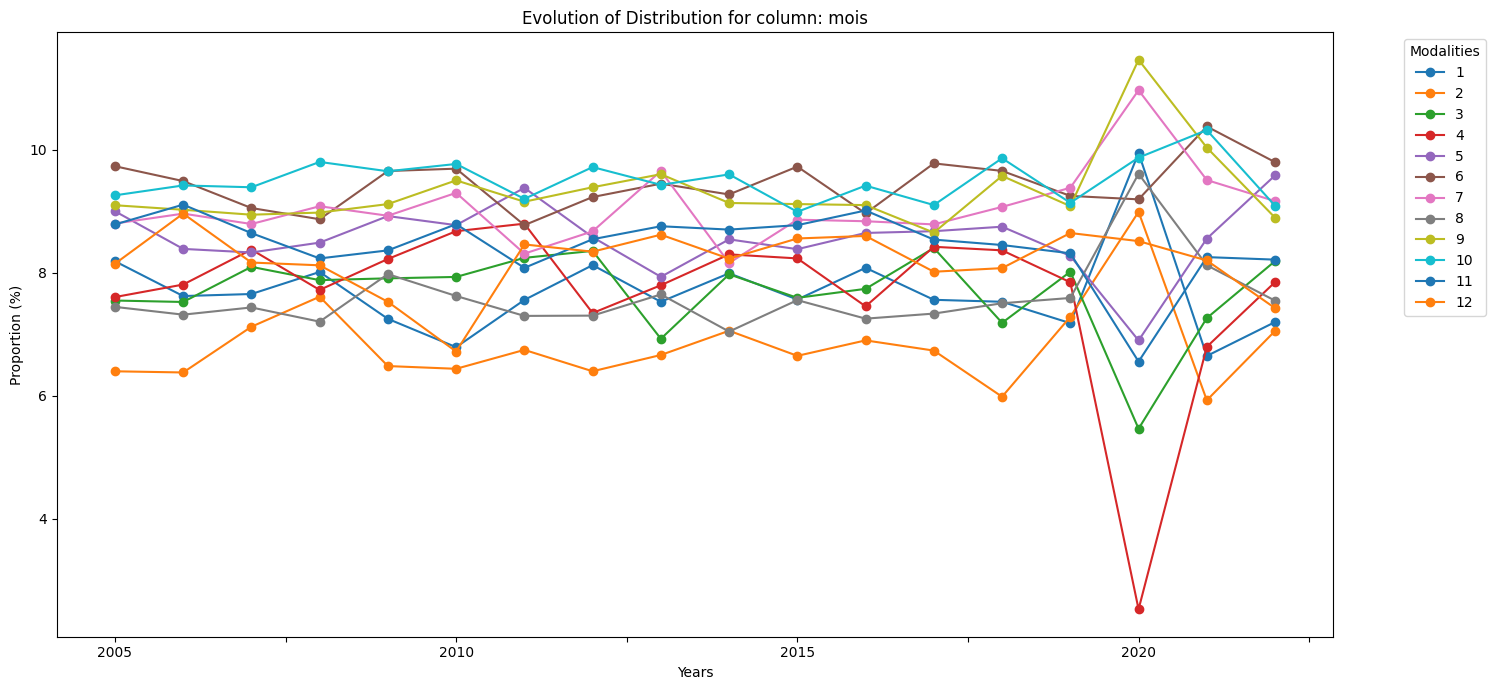


Colonne: agg / lignes: 1176873
  Année  Type      Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  ------  -------------------------------------  -----------------------------------
   2005  int64        2                                      0                                    0
   2006  int64        2                                      0                                    0
   2007  int64        2                                      0                                    0
   2008  int64        2                                      0                                    0
   2009  int64        2                                      0                                    0
   2010  int64        2                                      0                                    0
   2011  int64        2                                      0                                    0
   2012  int64        2                                      0      

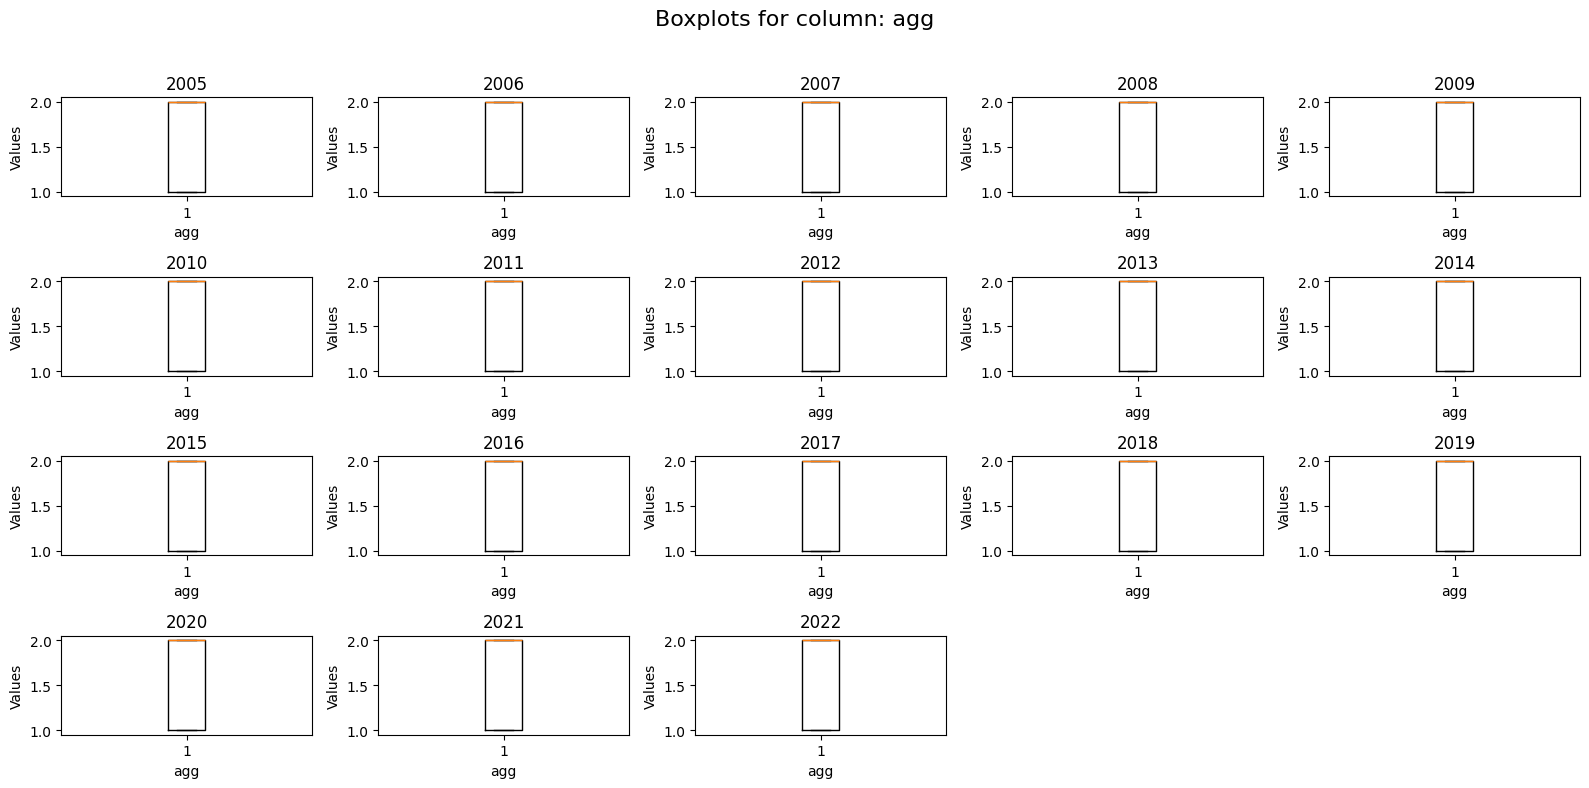

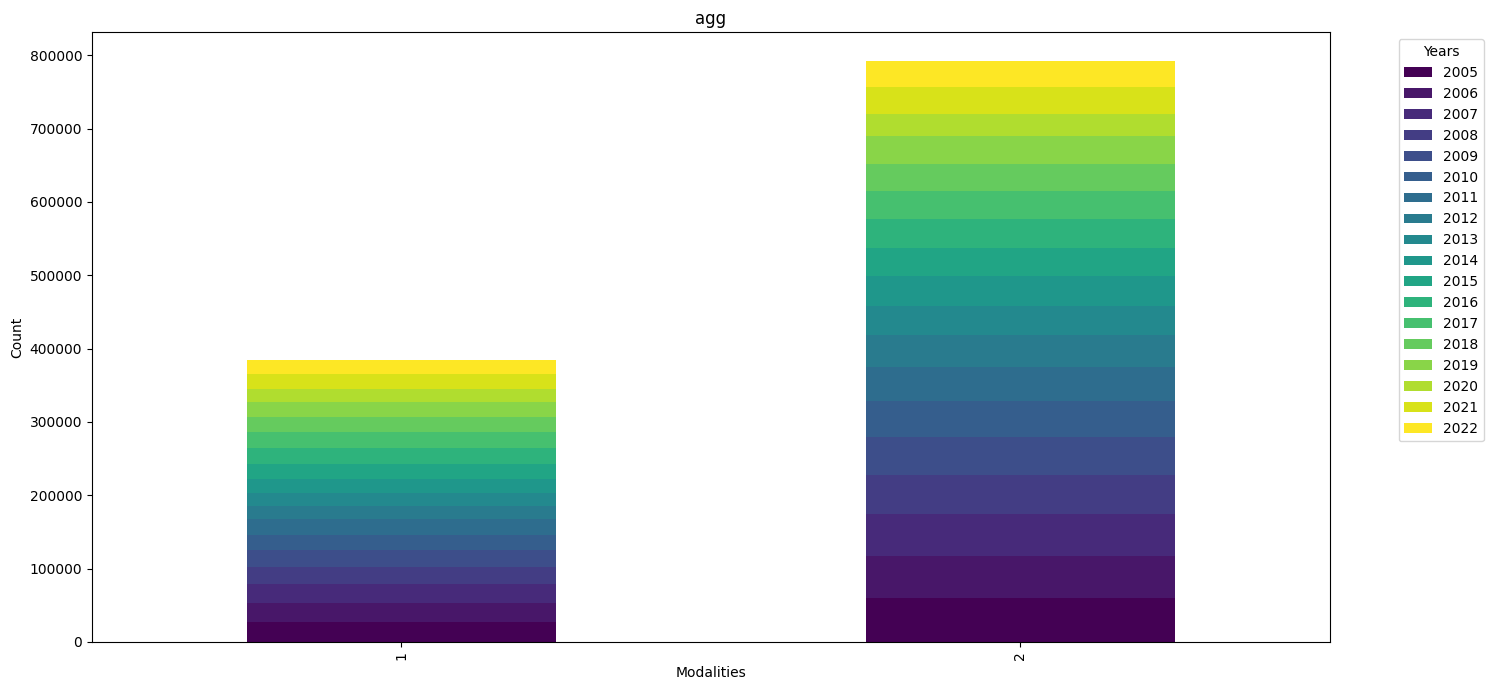

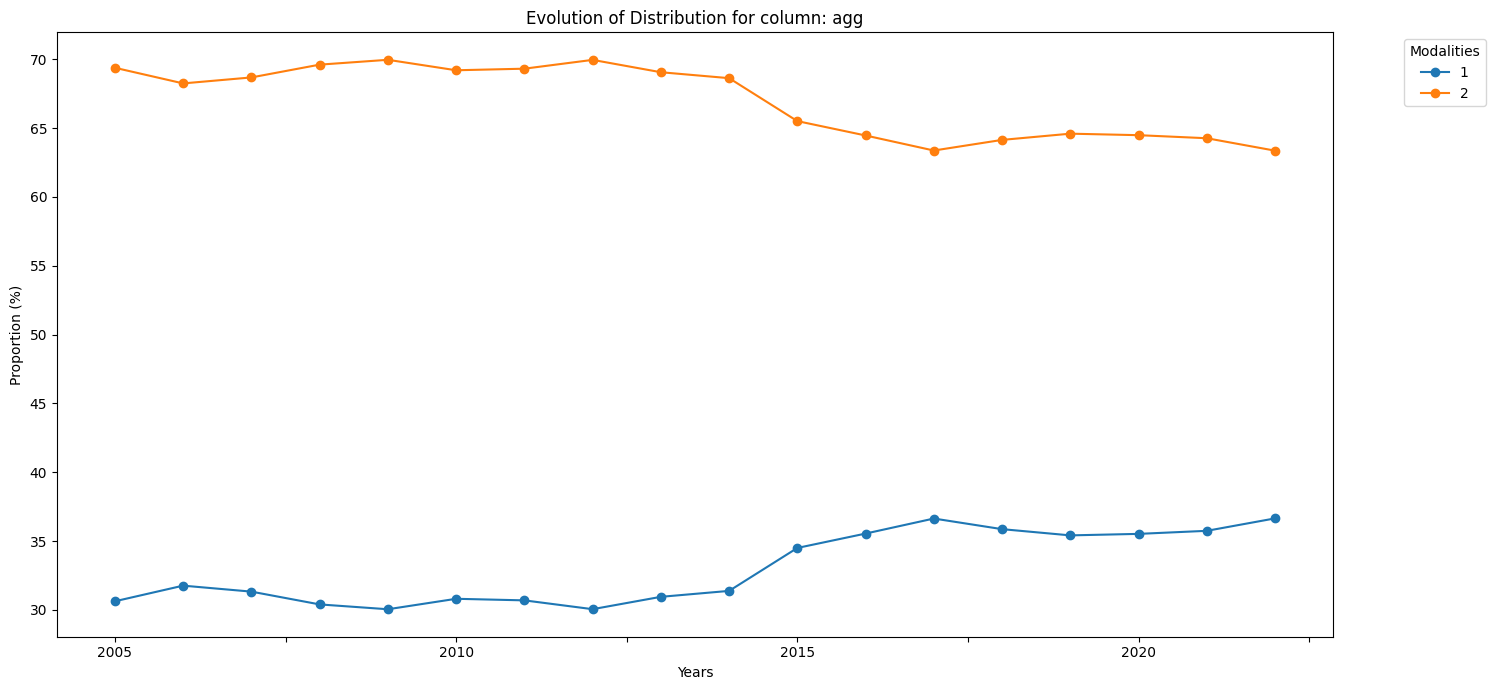


Colonne: int / lignes: 1176873
  Année  Type      Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  ------  -------------------------------------  -----------------------------------
   2005  int64        1                                      0                                    0
   2006  int64        1                                      0                                    0
   2007  int64        1                                      0                                    0
   2008  int64        1                                      0                                    0
   2009  int64        1                                      0                                    0
   2010  int64        1                                      0                                    0
   2011  int64        1                                      0                                    0
   2012  int64        1                                      0      

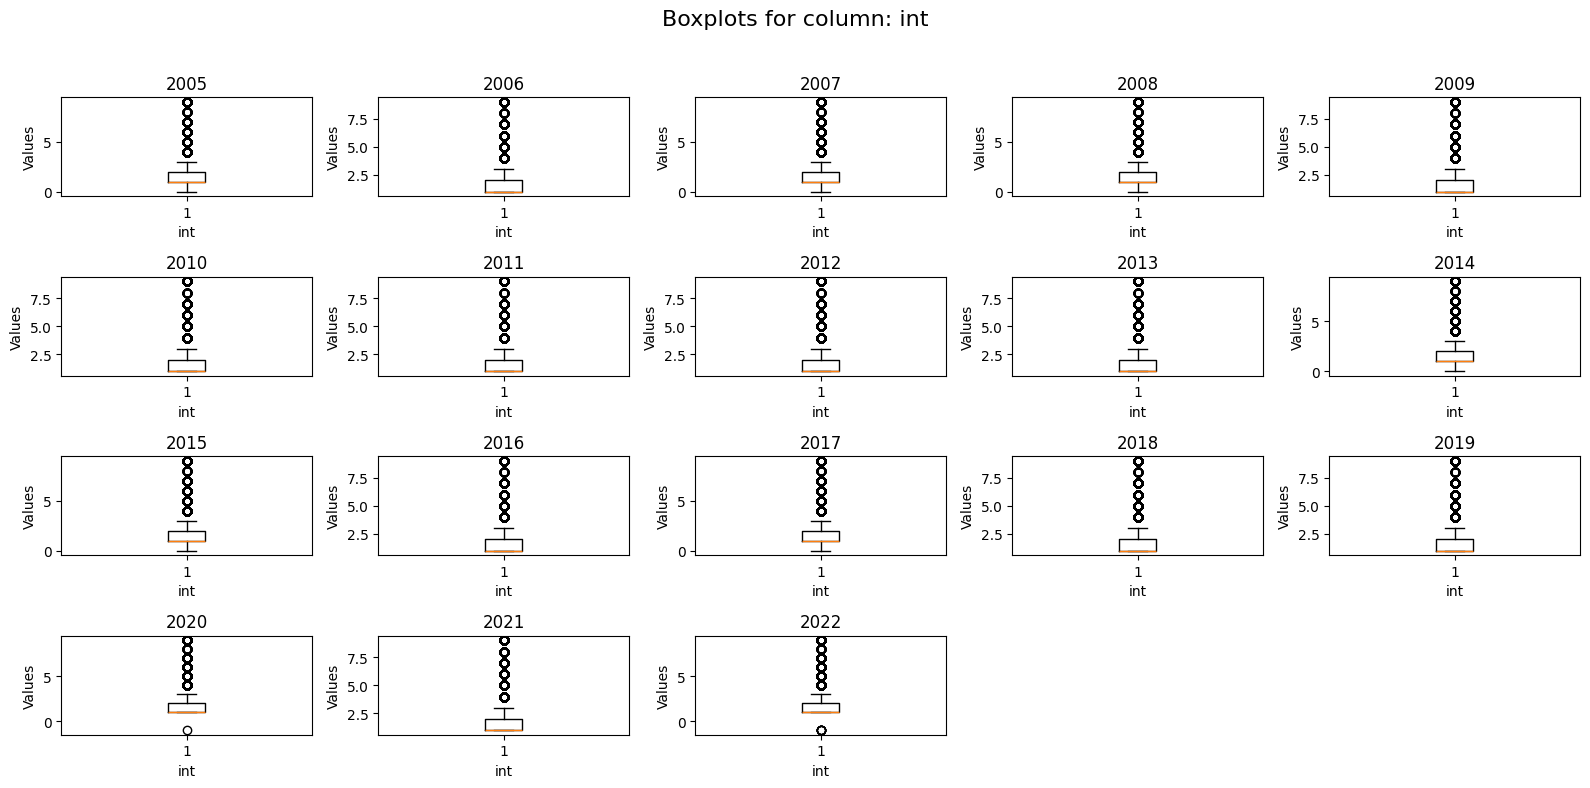

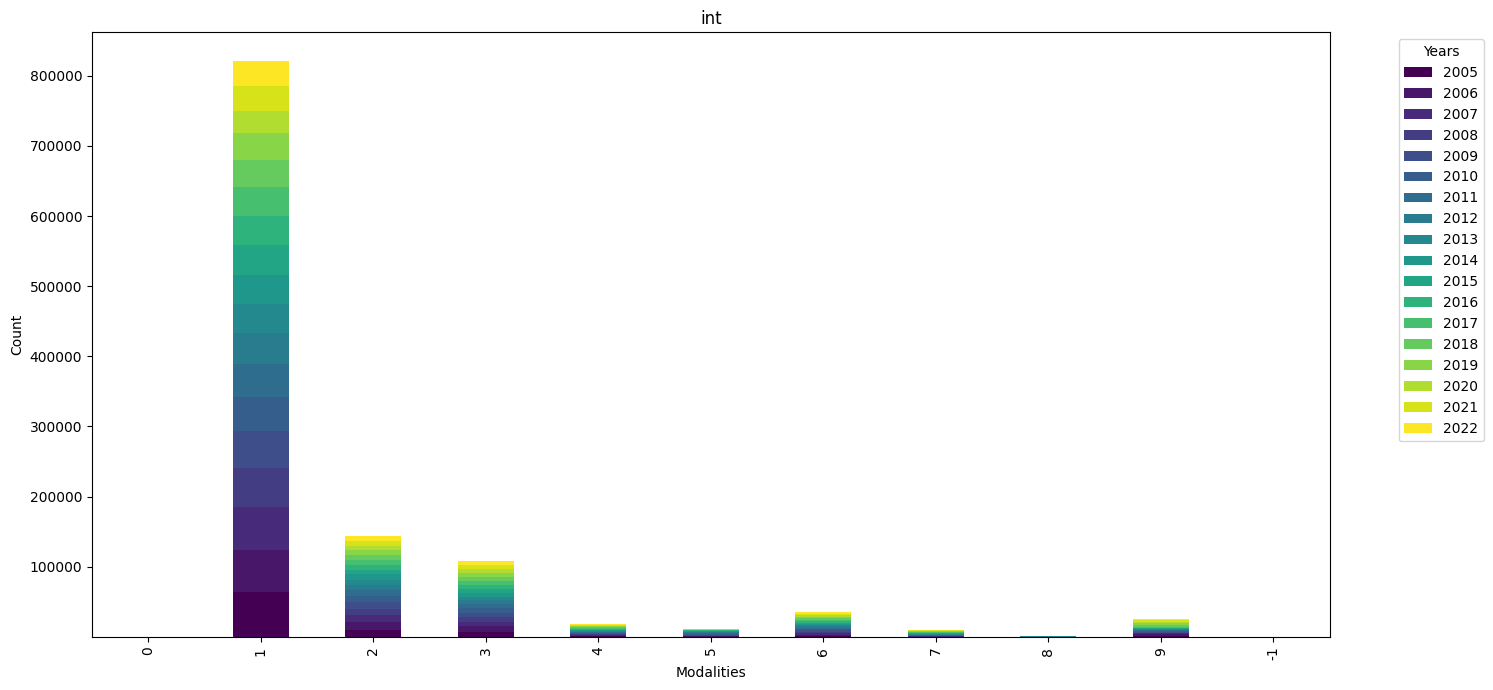

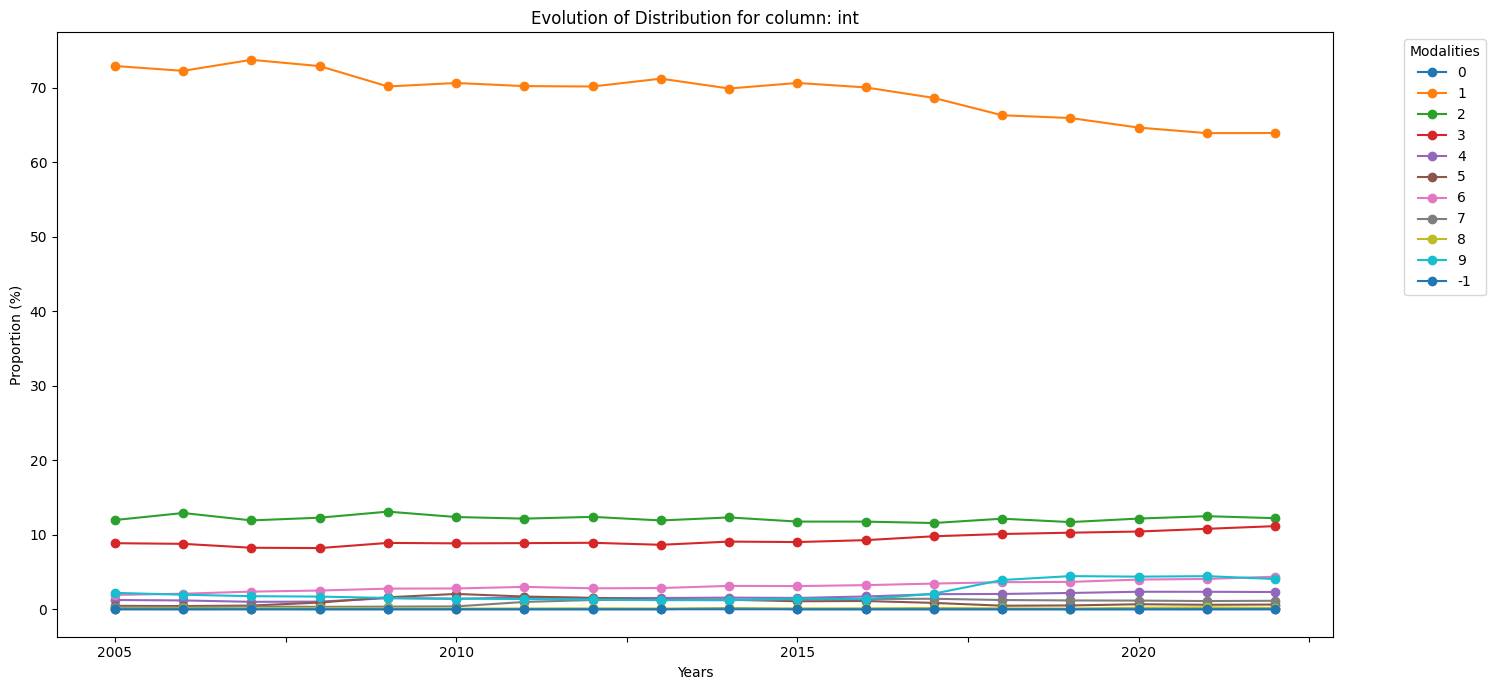


Colonne: atm / lignes: 1176873
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  int64         1                             0                                   0
   2006  int64         1                             0                                   0
   2007  int64         1                             0                                   0
   2008  int64         1                             0                                   0
   2009  float64       1                             0.00940746                          5.94797e-06
   2010  float64       1                             0.00432408                          2.54913e-06
   2011  float64       1                             0.0194105                           1.10462e-05
   2012  float64       1                             0.00481928                          2.54913e-0

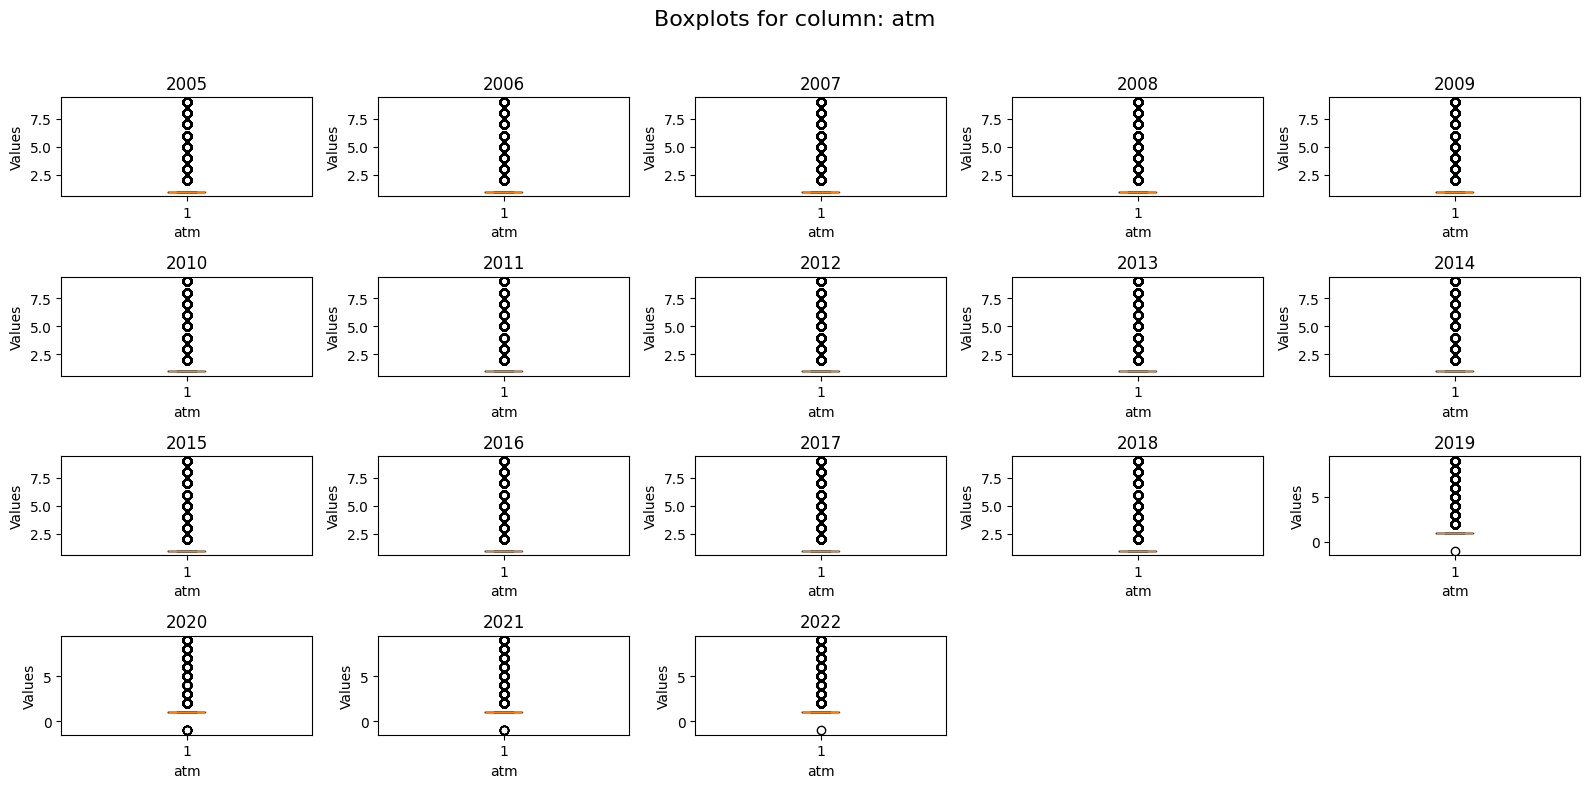

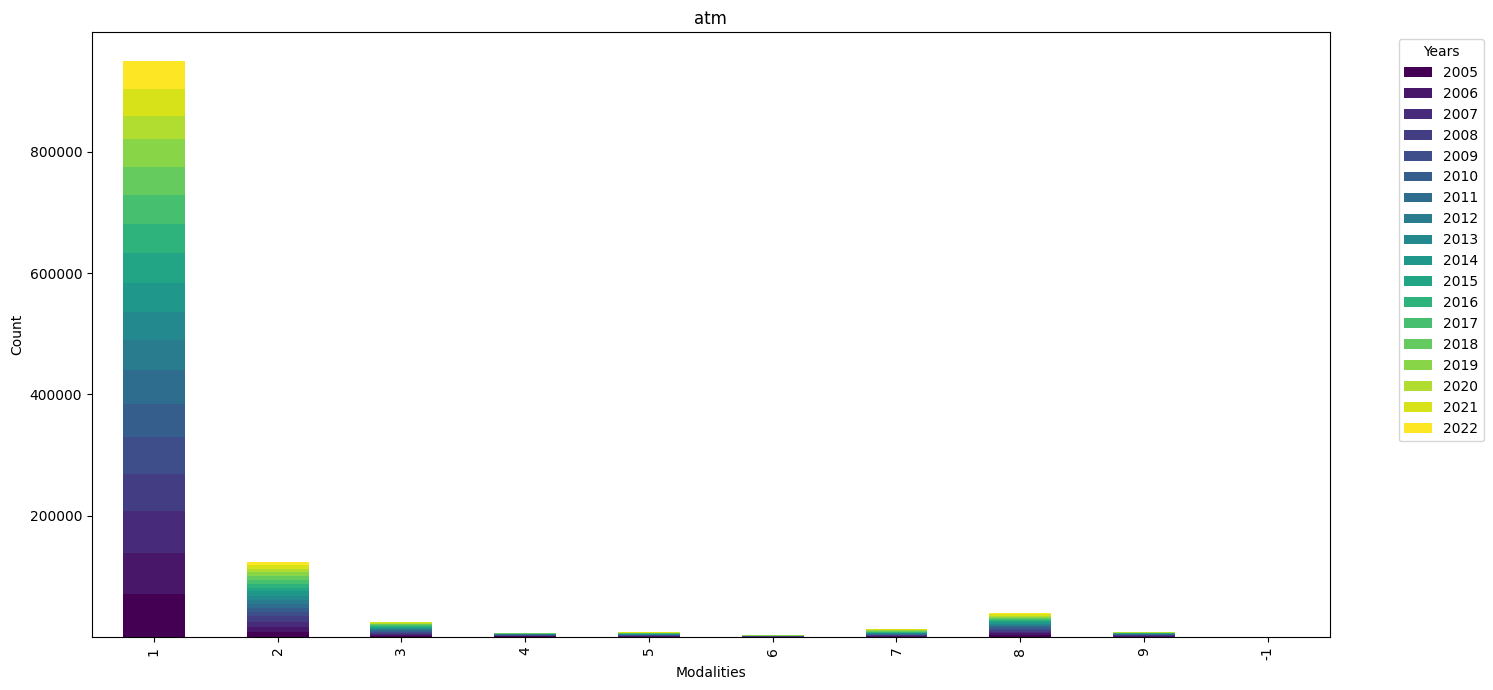

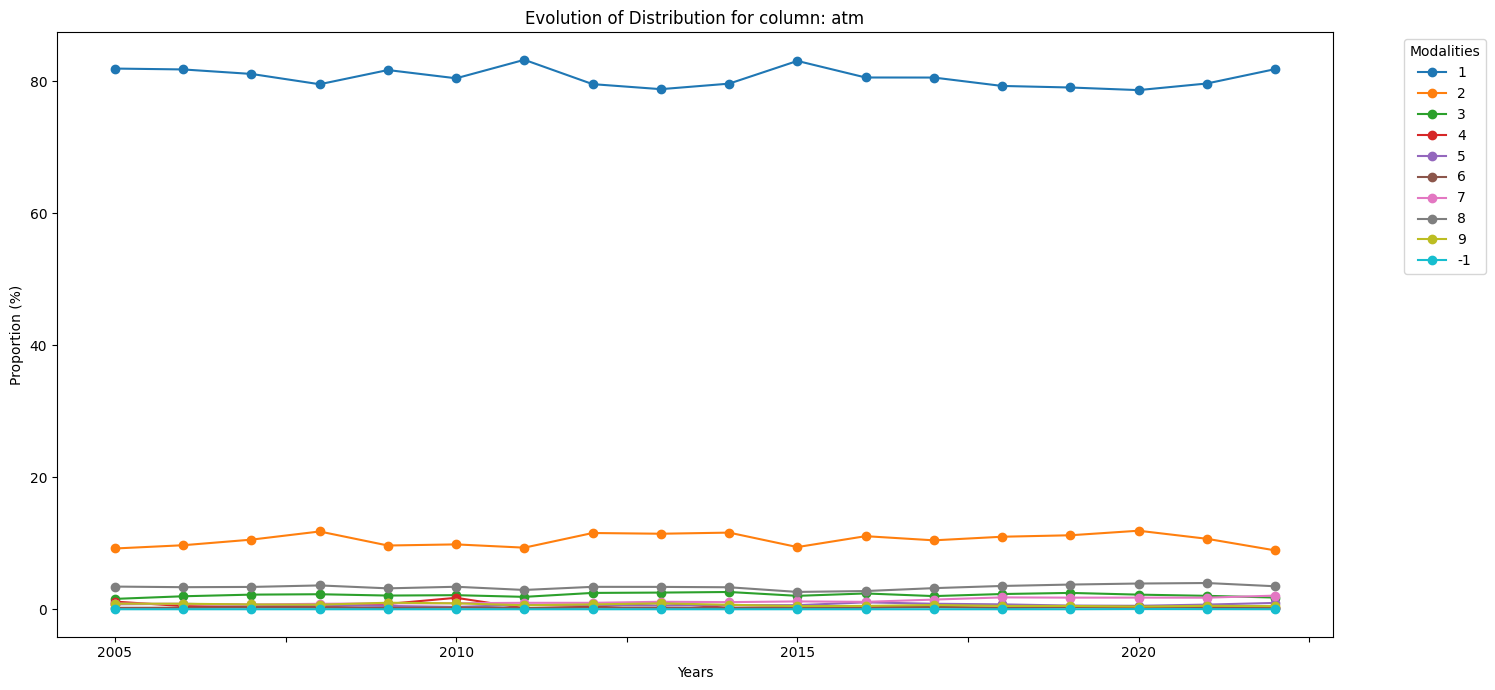


Colonne: long / lignes: 1176873
  Année  Type     Mode               Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ---------------  -------------------------------------  -----------------------------------
   2005  float64  0.0                                           69.0403                            0.0510531
   2006  float64  0.0                                           70.7686                            0.049906
   2007  float64  0.0                                           71.9129                            0.0512366
   2008  float64  0.0                                           71.8056                            0.0468385
   2009  object   0                                             54.9813                            0.0347625
   2010  float64  0.0                                           54.5064                            0.0321326
   2011  float64  0.0                                           54.1748                       

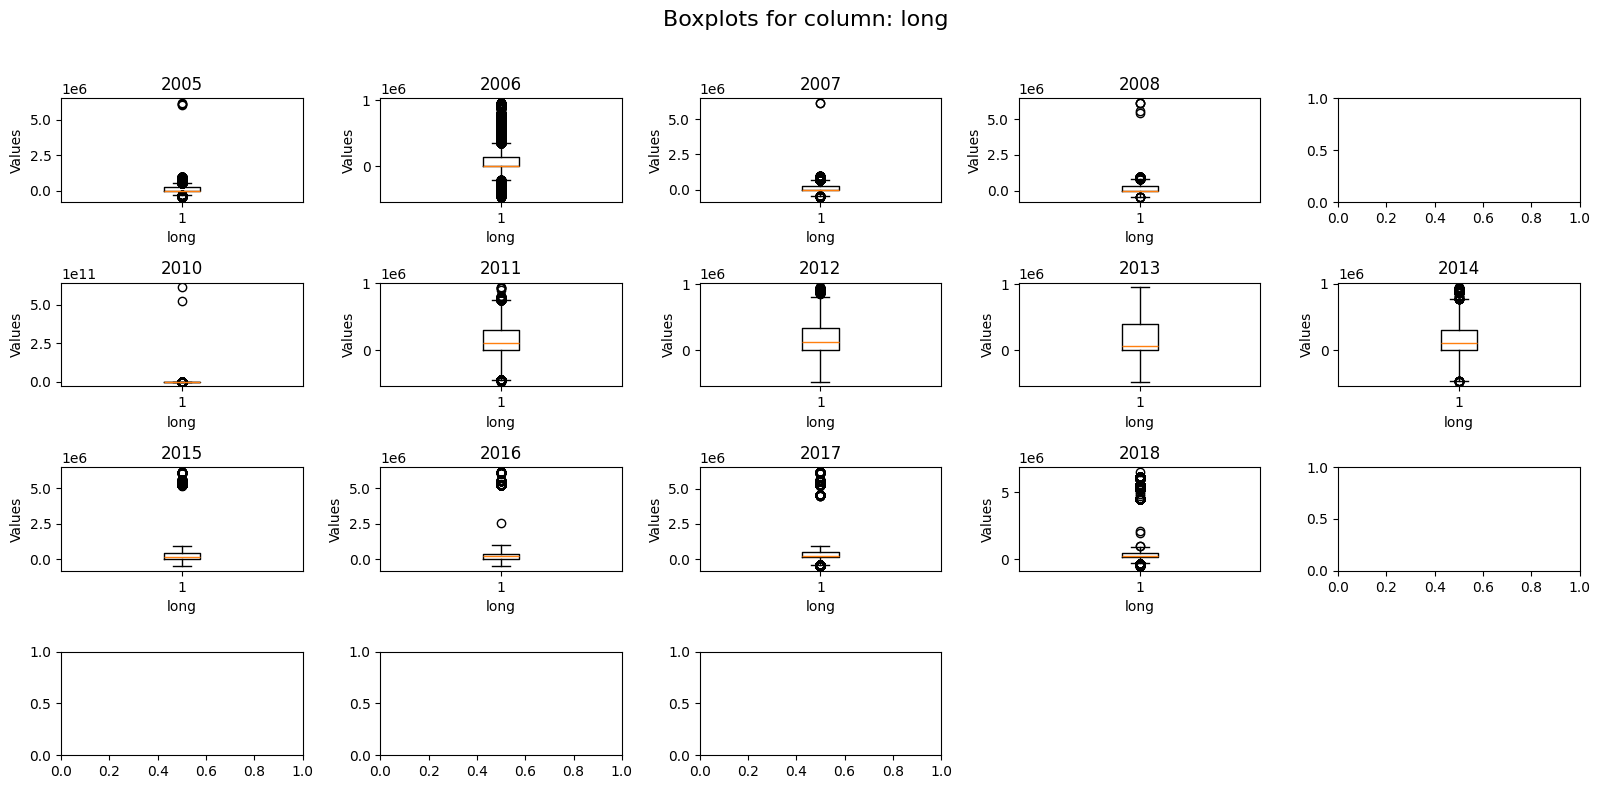

2024-06-10 17:10:35,662 - WARNING - Le nombre de modalités uniques dans la colonne long excède le seuil de 50. Auncun bar plot généré.
2024-06-10 17:10:35,912 - WARNING - Le nombre de modalités uniques dans la colonne long excède le seuil de 12. Aucun graphique en ligne généré.



Colonne: hrmn / lignes: 1176873
  Année  Type    Mode      Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  ------  -------------------------------------  -----------------------------------
   2005  int64   1800                                        0                                    0
   2006  int64   1800                                        0                                    0
   2007  int64   1800                                        0                                    0
   2008  int64   1800                                        0                                    0
   2009  int64   1800                                        0                                    0
   2010  int64   1800                                        0                                    0
   2011  int64   1800                                        0                                    0
   2012  int64   1800                                        0     

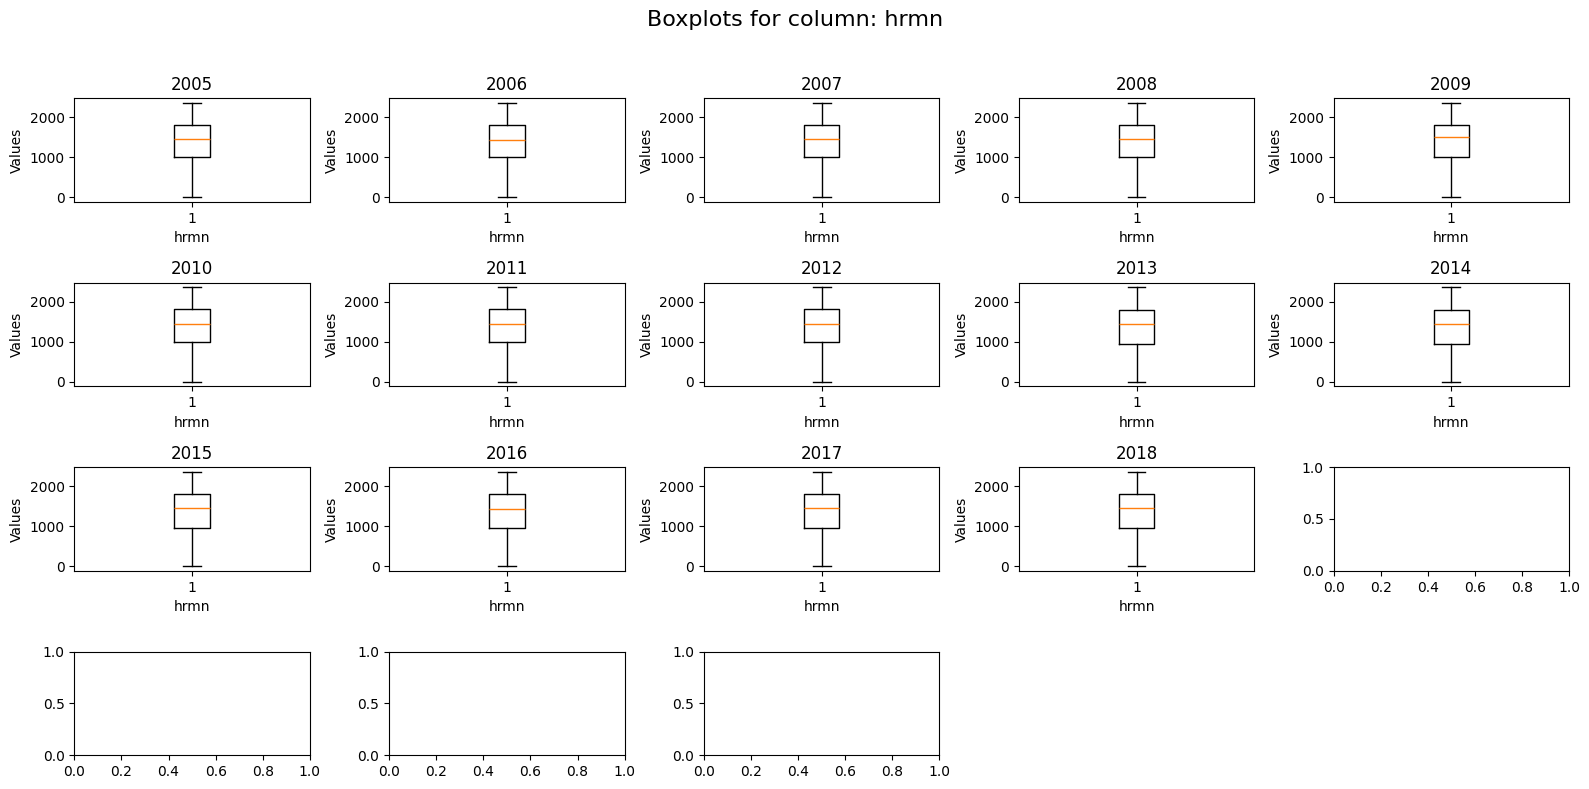

2024-06-10 17:10:37,590 - WARNING - Le nombre de modalités uniques dans la colonne hrmn excède le seuil de 50. Auncun bar plot généré.
2024-06-10 17:10:37,635 - WARNING - Le nombre de modalités uniques dans la colonne hrmn excède le seuil de 12. Aucun graphique en ligne généré.



Colonne: com / lignes: 1176873
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  float64      55                             0.00229816                          1.69942e-06
   2006  int64        55                             0                                   0
   2007  int64        55                             0                                   0
   2008  int64        55                             0                                   0
   2009  int64        88                             0                                   0
   2010  int64        55                             0                                   0
   2011  int64        55                             0                                   0
   2012  int64        55                             0                                   0
   2013  int64        55    

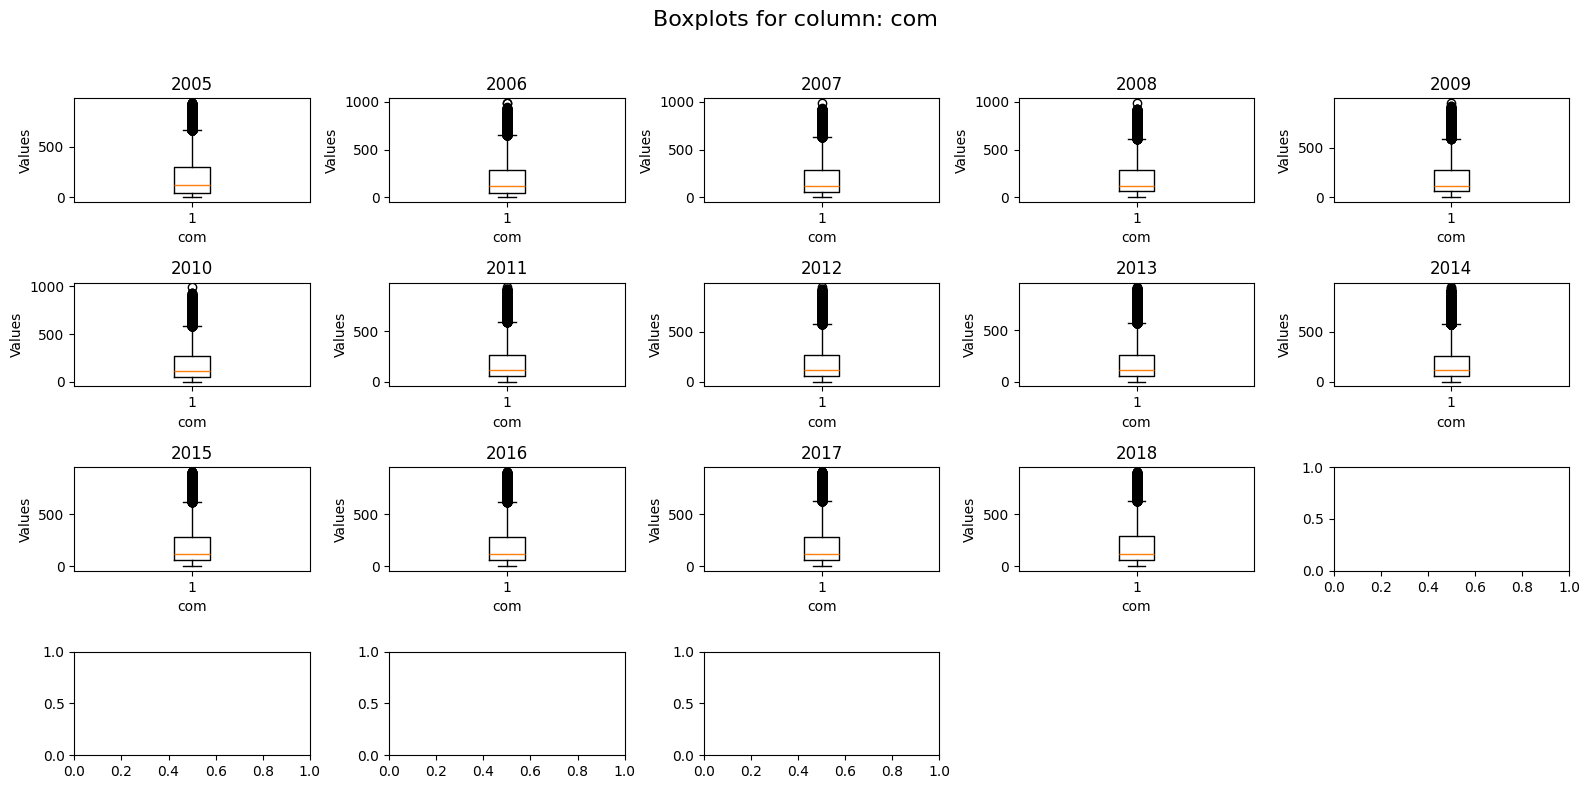

2024-06-10 17:10:39,422 - WARNING - Le nombre de modalités uniques dans la colonne com excède le seuil de 50. Auncun bar plot généré.
2024-06-10 17:10:39,471 - WARNING - Le nombre de modalités uniques dans la colonne com excède le seuil de 12. Aucun graphique en ligne généré.



Colonne: Accident_Id / lignes: 1176873
  Année  Type         Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  ---------  -------------------------------------  -----------------------------------
   2022  int64   2.022e+11                                      0                                    0


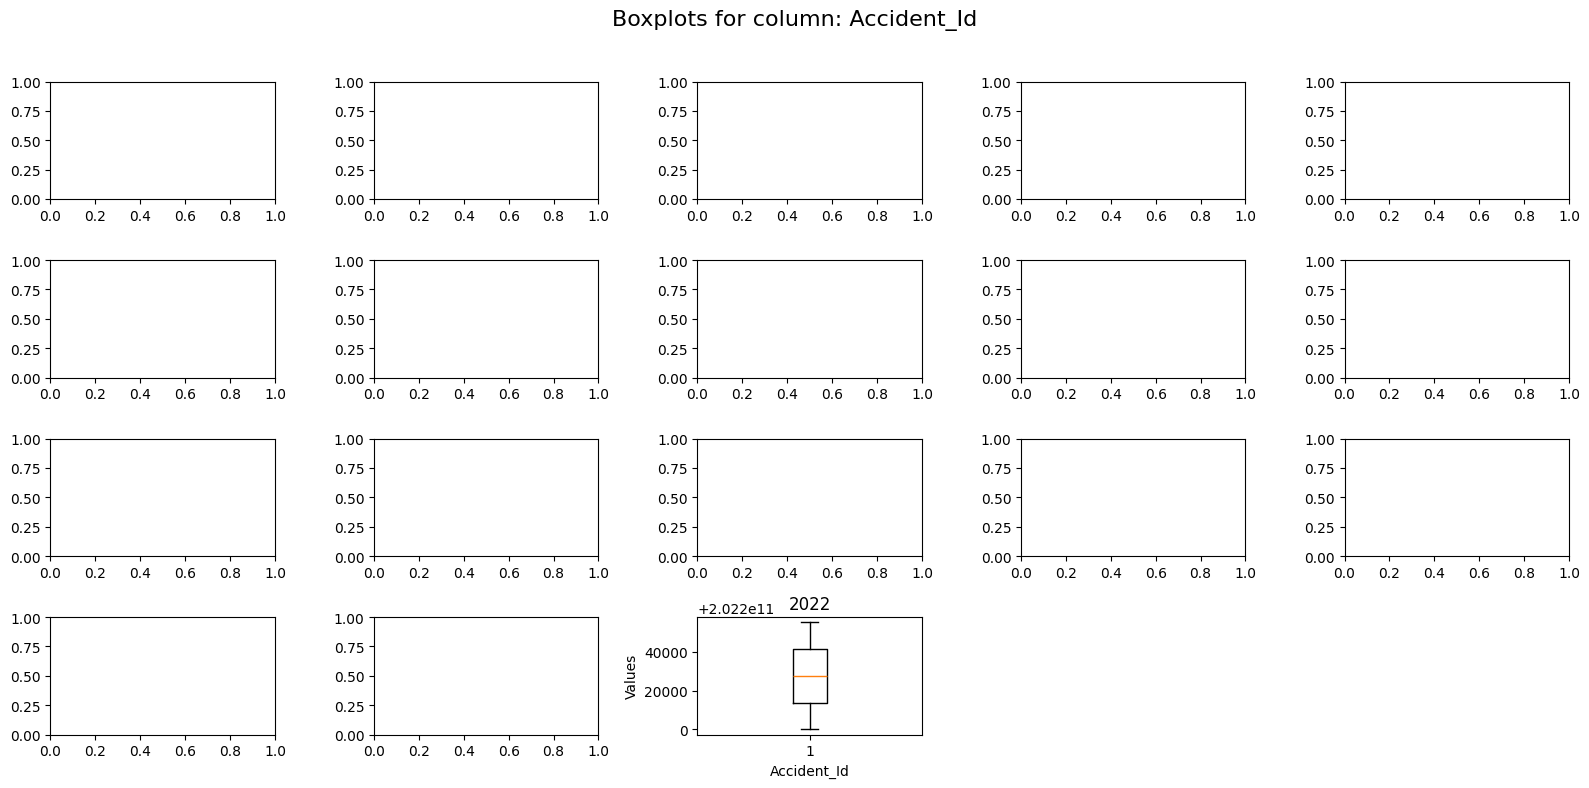

2024-06-10 17:10:41,182 - WARNING - Le nombre de modalités uniques dans la colonne Accident_Id excède le seuil de 50. Auncun bar plot généré.
2024-06-10 17:10:41,201 - WARNING - Le nombre de modalités uniques dans la colonne Accident_Id excède le seuil de 12. Aucun graphique en ligne généré.


2024-06-10 17:10:41,325 - INFO - La colonne gps n'est pas numérique.



Colonne: gps / lignes: 1176873
  Année  Type    Mode      Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  ------  -------------------------------------  -----------------------------------
   2005  object  M                                  68.9323                             0.0509732
   2006  object  M                                  70.6843                             0.0498465
   2007  object  M                                  71.8104                             0.0511635
   2008  object  M                                  71.6831                             0.0467587
   2009  object  M                                  54.8361                             0.0346707
   2010  object  M                                  54.2729                             0.031995
   2011  object  M                                  53.9403                             0.0306966
   2012  object  M                                  52.9912                        

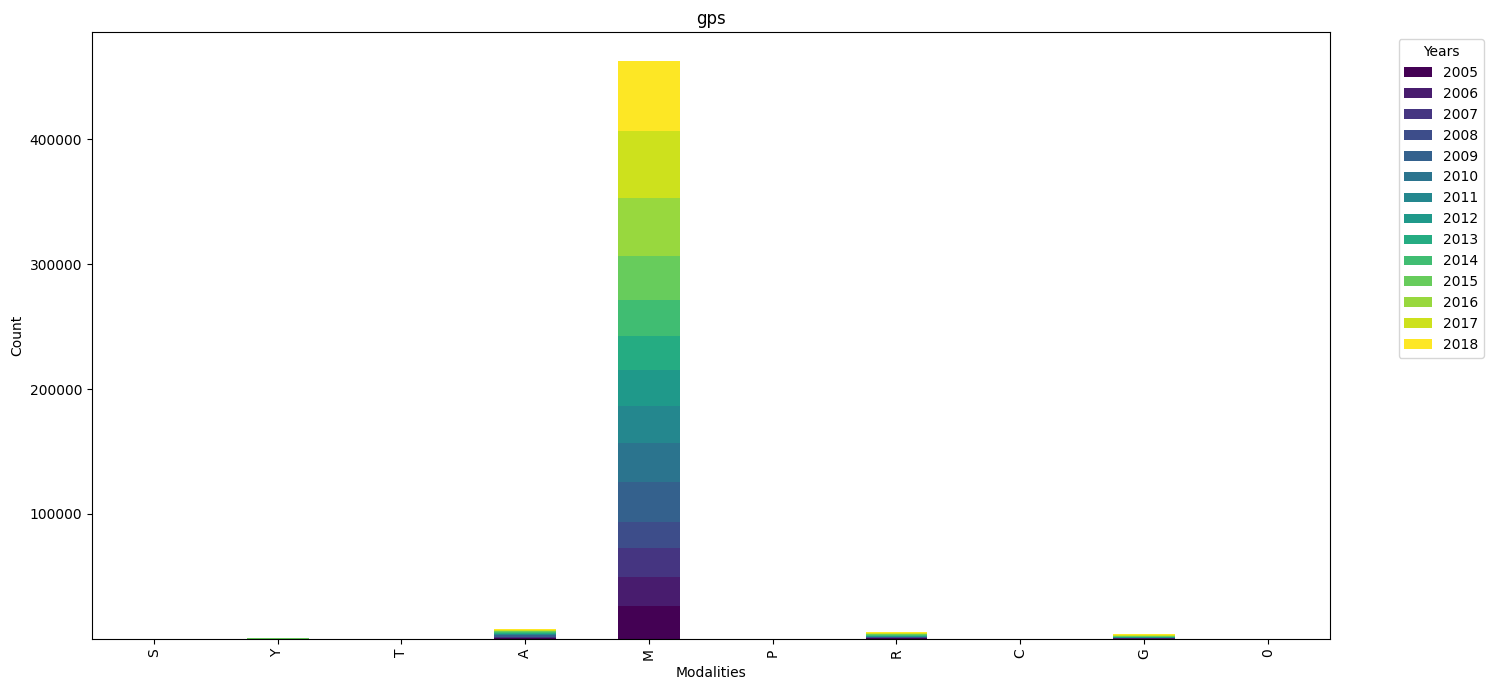

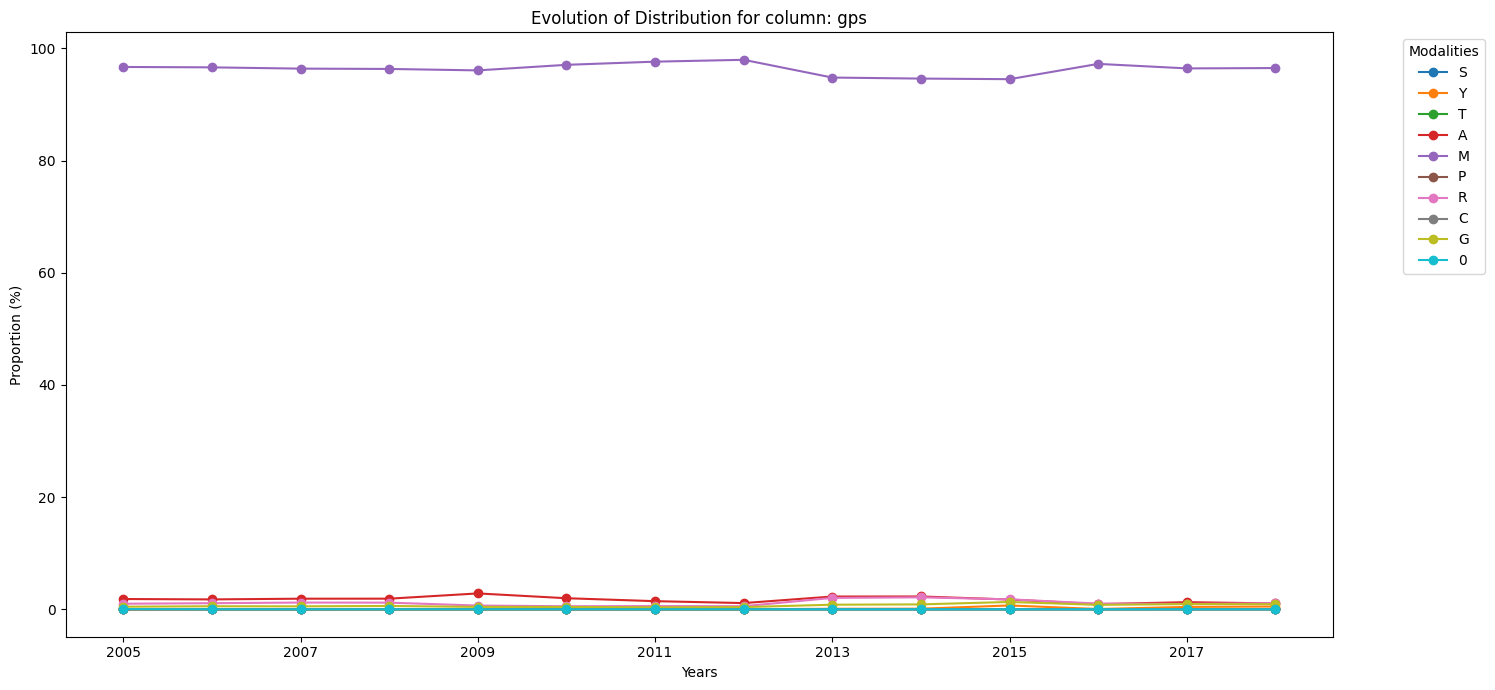


Colonne: Num_Acc / lignes: 1176873
  Année  Type         Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  ---------  -------------------------------------  -----------------------------------
   2005  int64   2.005e+11                                      0                                    0
   2006  int64   2.006e+11                                      0                                    0
   2007  int64   2.007e+11                                      0                                    0
   2008  int64   2.008e+11                                      0                                    0
   2009  int64   2.009e+11                                      0                                    0
   2010  int64   2.01e+11                                       0                                    0
   2011  int64   2.011e+11                                      0                                    0
   2012  int64   2.012e+11           

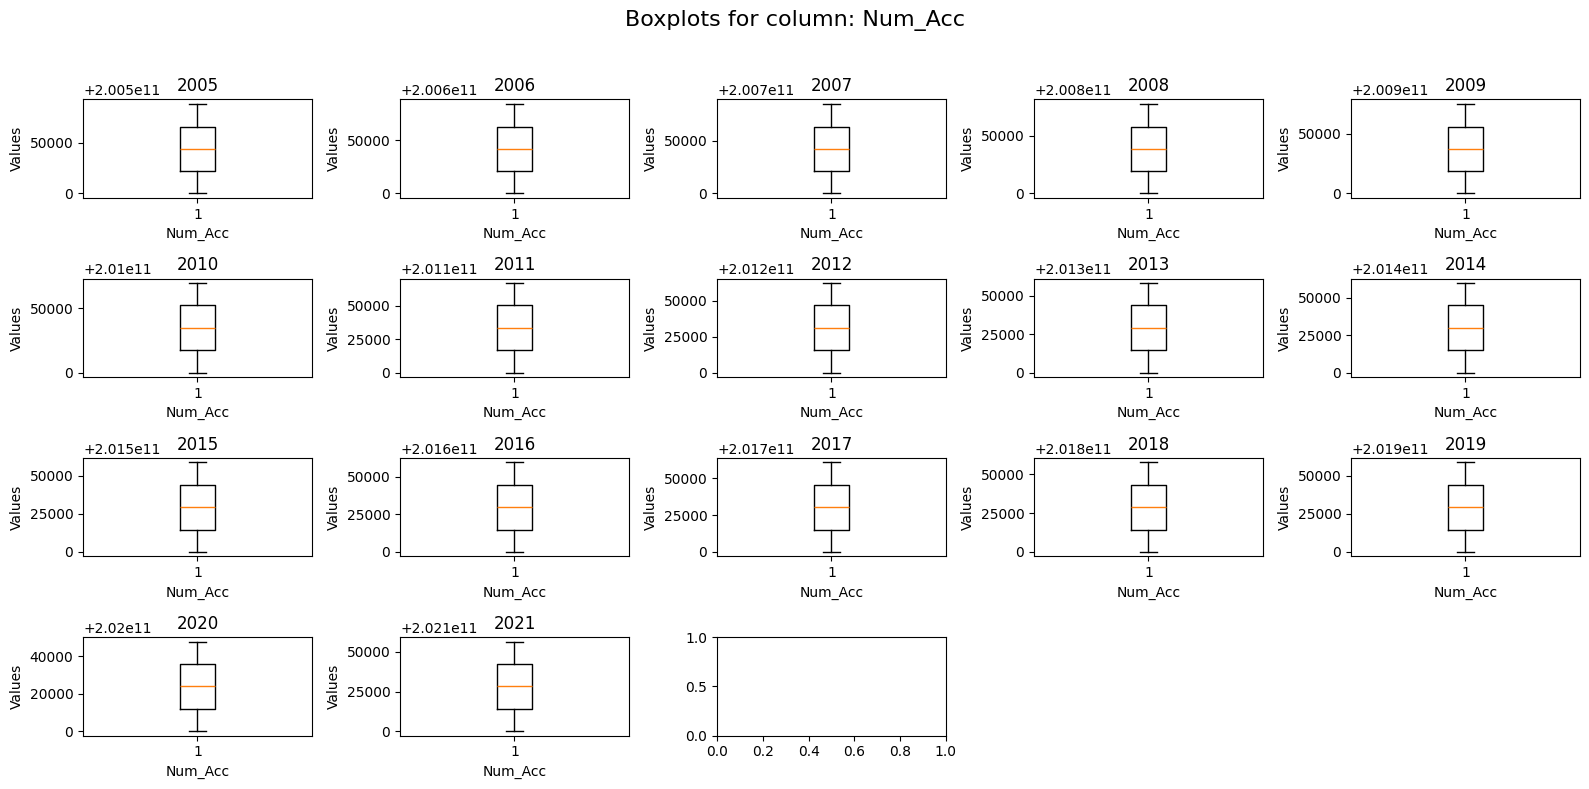

2024-06-10 17:10:44,515 - WARNING - Le nombre de modalités uniques dans la colonne Num_Acc excède le seuil de 50. Auncun bar plot généré.
2024-06-10 17:10:44,735 - WARNING - Le nombre de modalités uniques dans la colonne Num_Acc excède le seuil de 12. Aucun graphique en ligne généré.



Colonne: col / lignes: 1176873
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  int64         6                             0                                   0
   2006  int64         6                             0                                   0
   2007  int64         6                             0                                   0
   2008  int64         6                             0                                   0
   2009  int64         6                             0                                   0
   2010  float64       6                             0.00432408                          2.54913e-06
   2011  float64       6                             0.0089587                           5.09826e-06
   2012  int64         6                             0                                   0
   2013  int64    

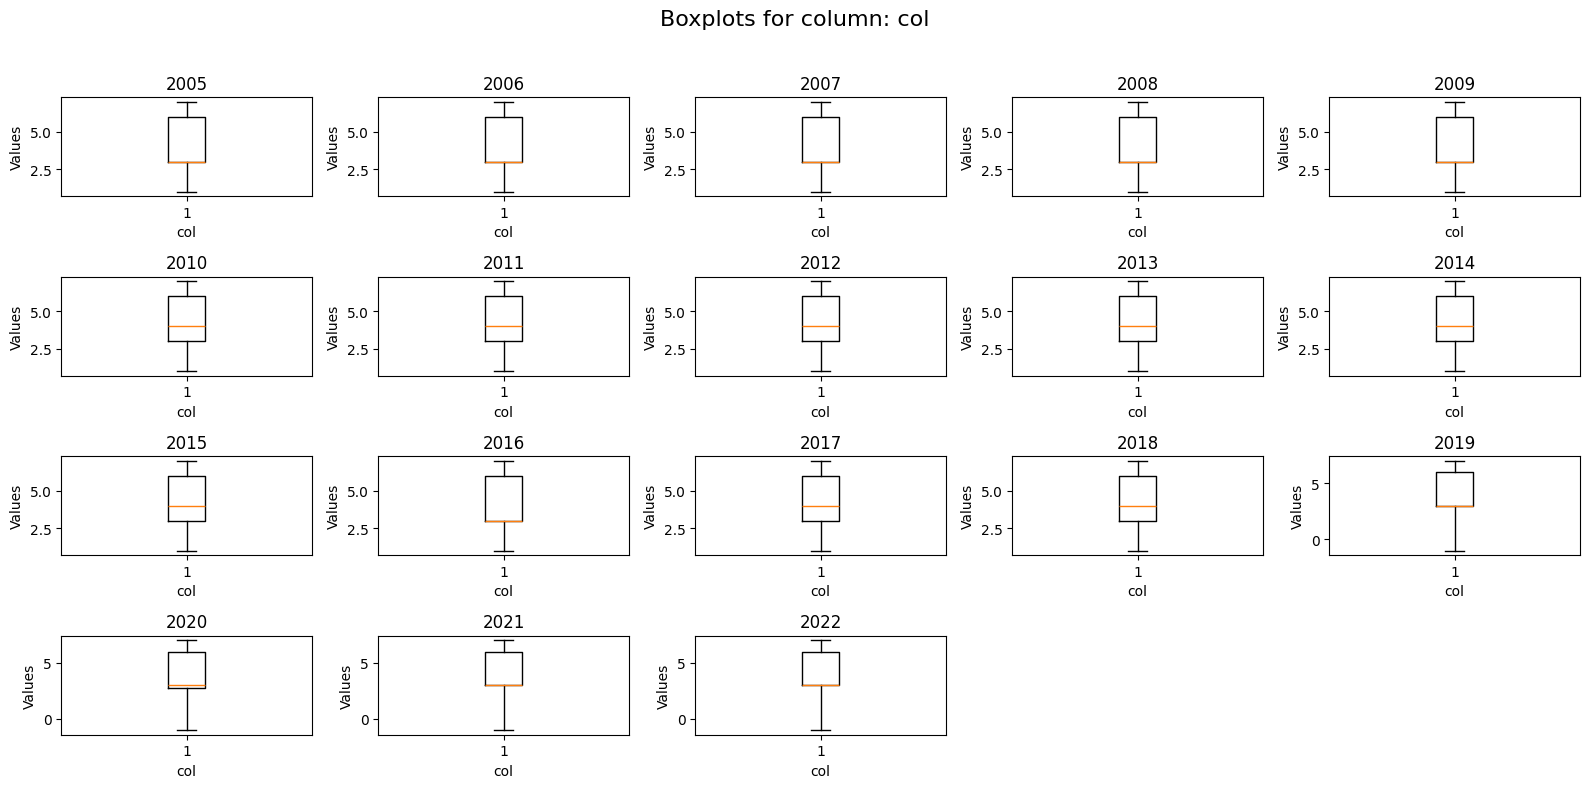

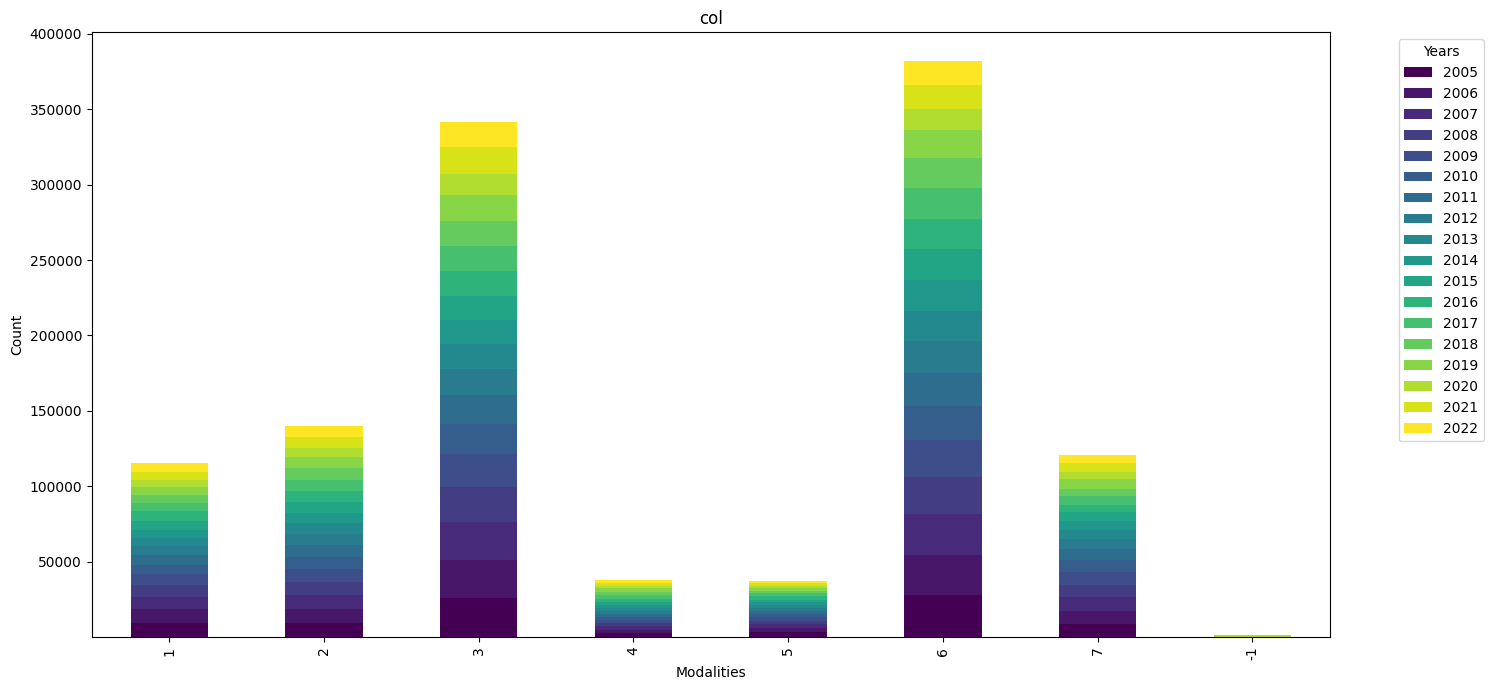

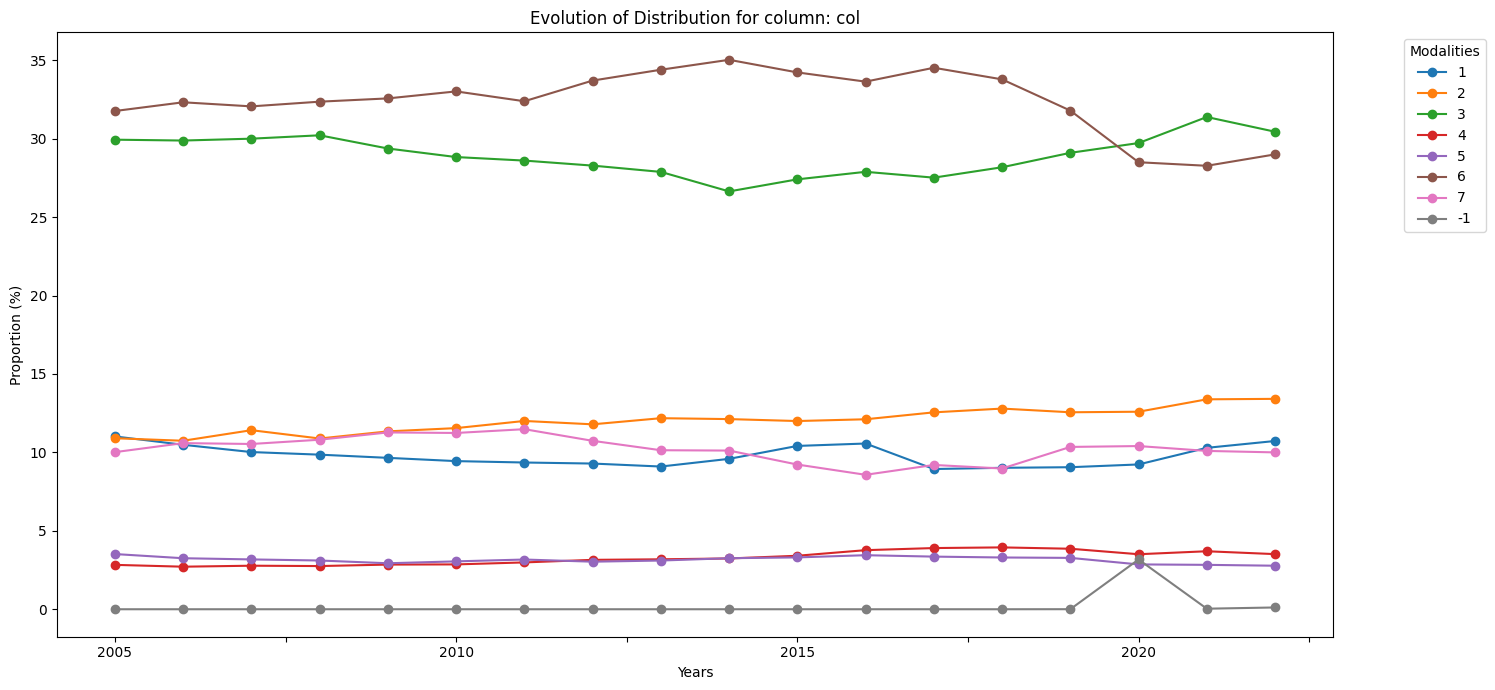


Colonne: dep / lignes: 1176873
  Année  Type      Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  ------  -------------------------------------  -----------------------------------
   2005  int64      750                                      0                                    0
   2006  int64      750                                      0                                    0
   2007  int64      750                                      0                                    0
   2008  int64      750                                      0                                    0
   2009  int64      750                                      0                                    0
   2010  int64      750                                      0                                    0
   2011  int64      750                                      0                                    0
   2012  int64      750                                      0      

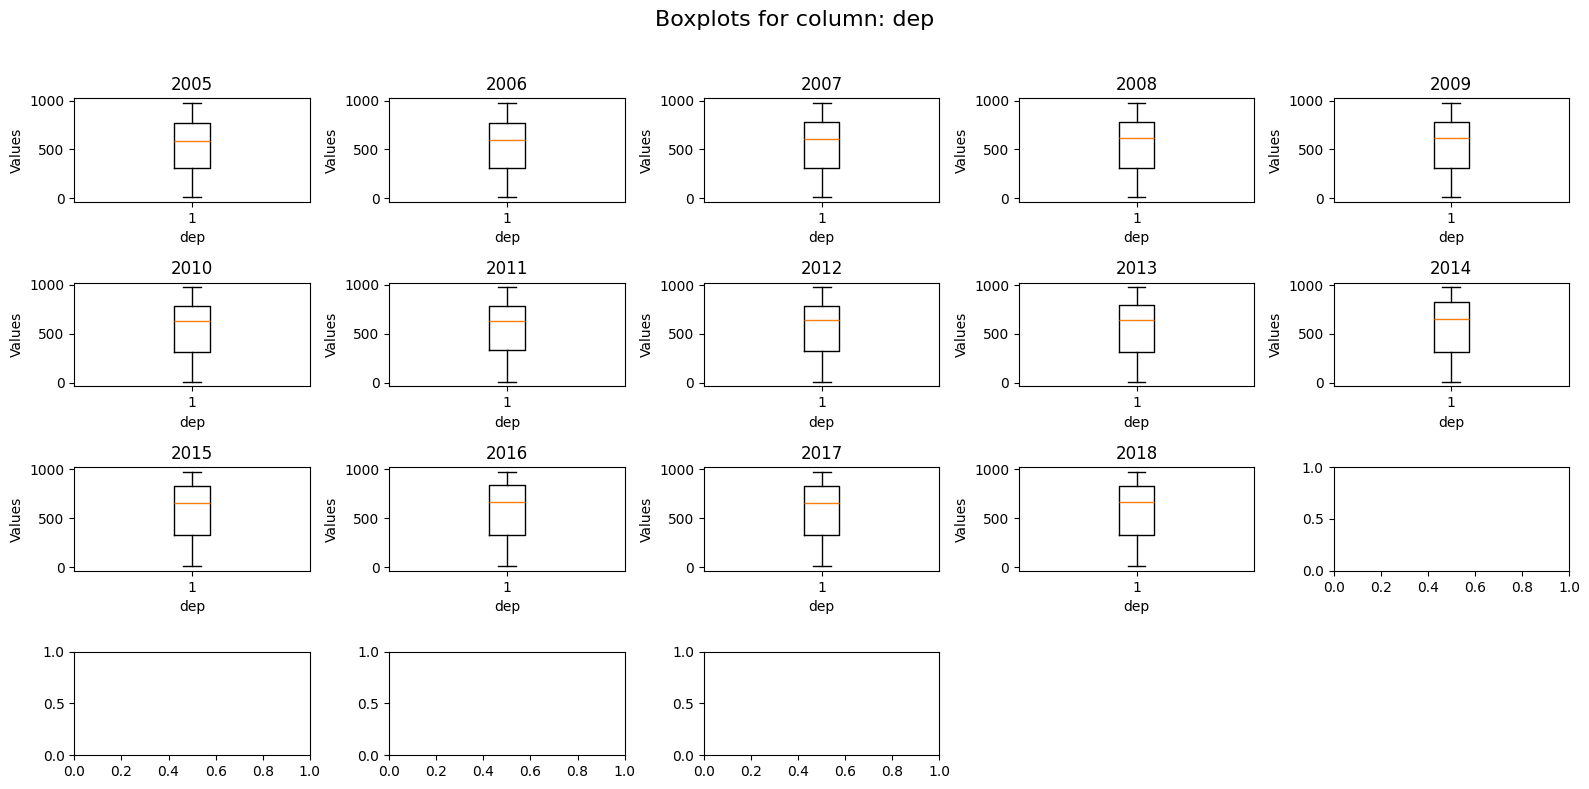

2024-06-10 17:10:49,134 - WARNING - Le nombre de modalités uniques dans la colonne dep excède le seuil de 50. Auncun bar plot généré.
2024-06-10 17:10:49,156 - WARNING - Le nombre de modalités uniques dans la colonne dep excède le seuil de 12. Aucun graphique en ligne généré.



Colonne: an / lignes: 1176873
  Année  Type      Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  ------  -------------------------------------  -----------------------------------
   2005  int64        5                                      0                                    0
   2006  int64        6                                      0                                    0
   2007  int64        7                                      0                                    0
   2008  int64        8                                      0                                    0
   2009  int64        9                                      0                                    0
   2010  int64       10                                      0                                    0
   2011  int64       11                                      0                                    0
   2012  int64       12                                      0       

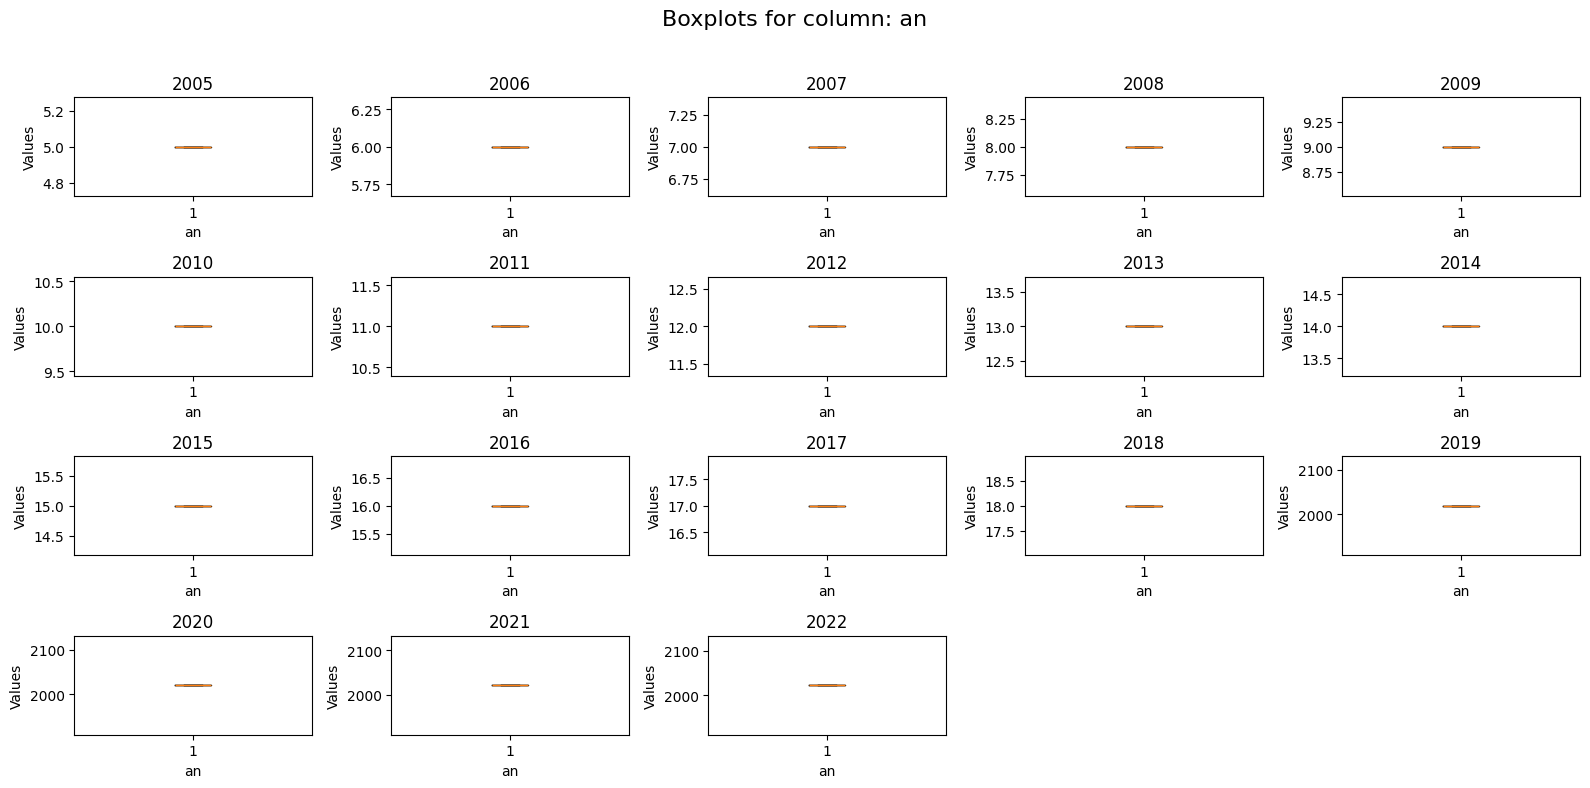

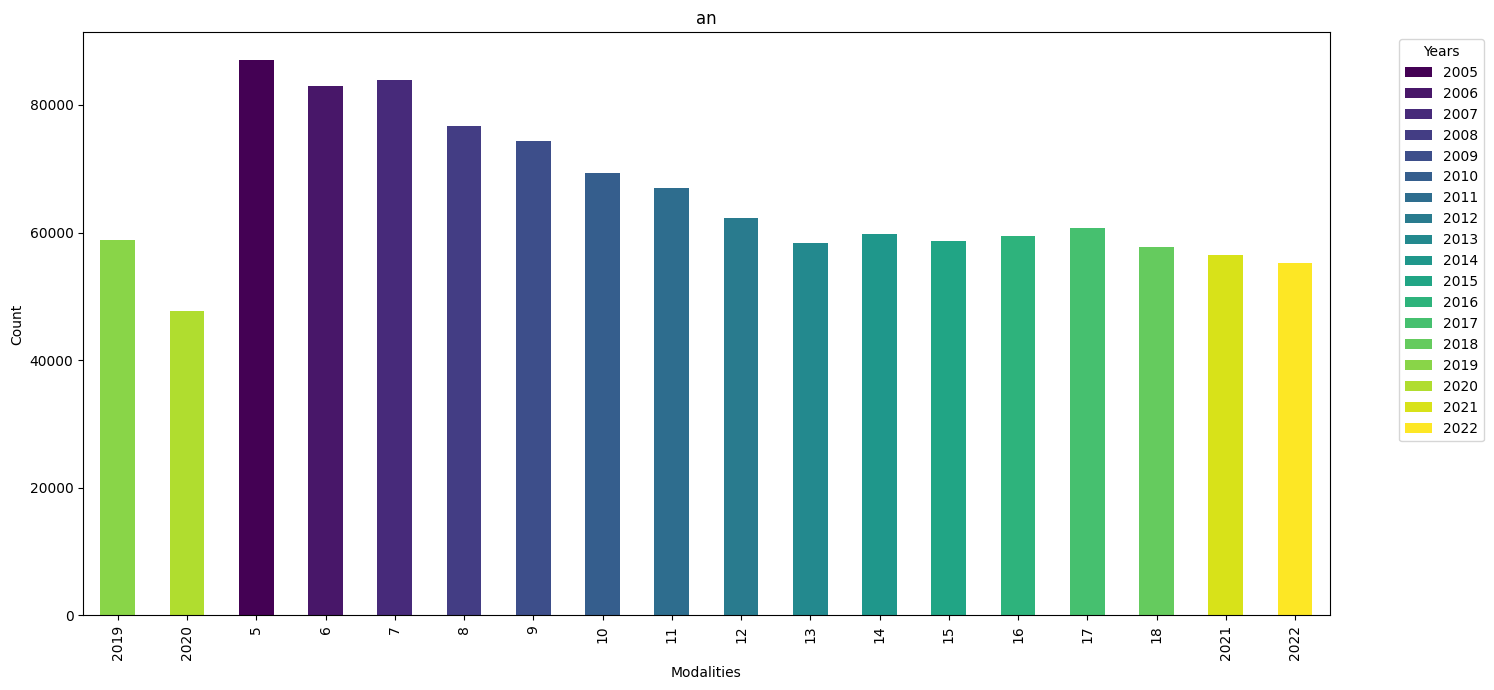

2024-06-10 17:10:51,479 - WARNING - Le nombre de modalités uniques dans la colonne an excède le seuil de 12. Aucun graphique en ligne généré.


2024-06-10 17:10:51,481 - INFO - Chargement de data/raw\lieux_2005.csv.
2024-06-10 17:10:51,481 - INFO - Chargement de data/raw\lieux_2006.csv.
2024-06-10 17:10:51,482 - INFO - Chargement de data/raw\lieux_2007.csv.
2024-06-10 17:10:51,483 - INFO - Chargement de data/raw\lieux_2008.csv.
2024-06-10 17:10:51,483 - INFO - Chargement de data/raw\lieux_2009.csv.
2024-06-10 17:10:51,484 - INFO - Chargement de data/raw\lieux_2010.csv.
2024-06-10 17:10:51,485 - INFO - Chargement de data/raw\lieux_2011.csv.
2024-06-10 17:10:51,485 - INFO - Chargement de data/raw\lieux_2012.csv.
2024-06-10 17:10:51,486 - INFO - Chargement de data/raw\lieux_2013.csv.
2024-06-10 17:10:51,486 - INFO - Chargement de data/raw\lieux_2014.csv.
2024-06-10 17:10:51,487 - INFO - Chargement de data/raw\lieux_2015.csv.
2024-06-10 17:10:51,487 - INFO - Chargement de data/raw\lieux_2016.csv.
2024-06-10 17:10:51,488 - INFO - Chargement de data/raw\lieux-2017.csv.
2024-06-10 17:10:51,489 - INFO - Chargement de data/raw\lieux-20


Colonne: Num_Acc / lignes: 1176873
  Année  Type         Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  ---------  -------------------------------------  -----------------------------------
   2005  int64   2.005e+11                                      0                                    0
   2006  int64   2.006e+11                                      0                                    0
   2007  int64   2.007e+11                                      0                                    0
   2008  int64   2.008e+11                                      0                                    0
   2009  int64   2.009e+11                                      0                                    0
   2010  int64   2.01e+11                                       0                                    0
   2011  int64   2.011e+11                                      0                                    0
   2012  int64   2.012e+11           

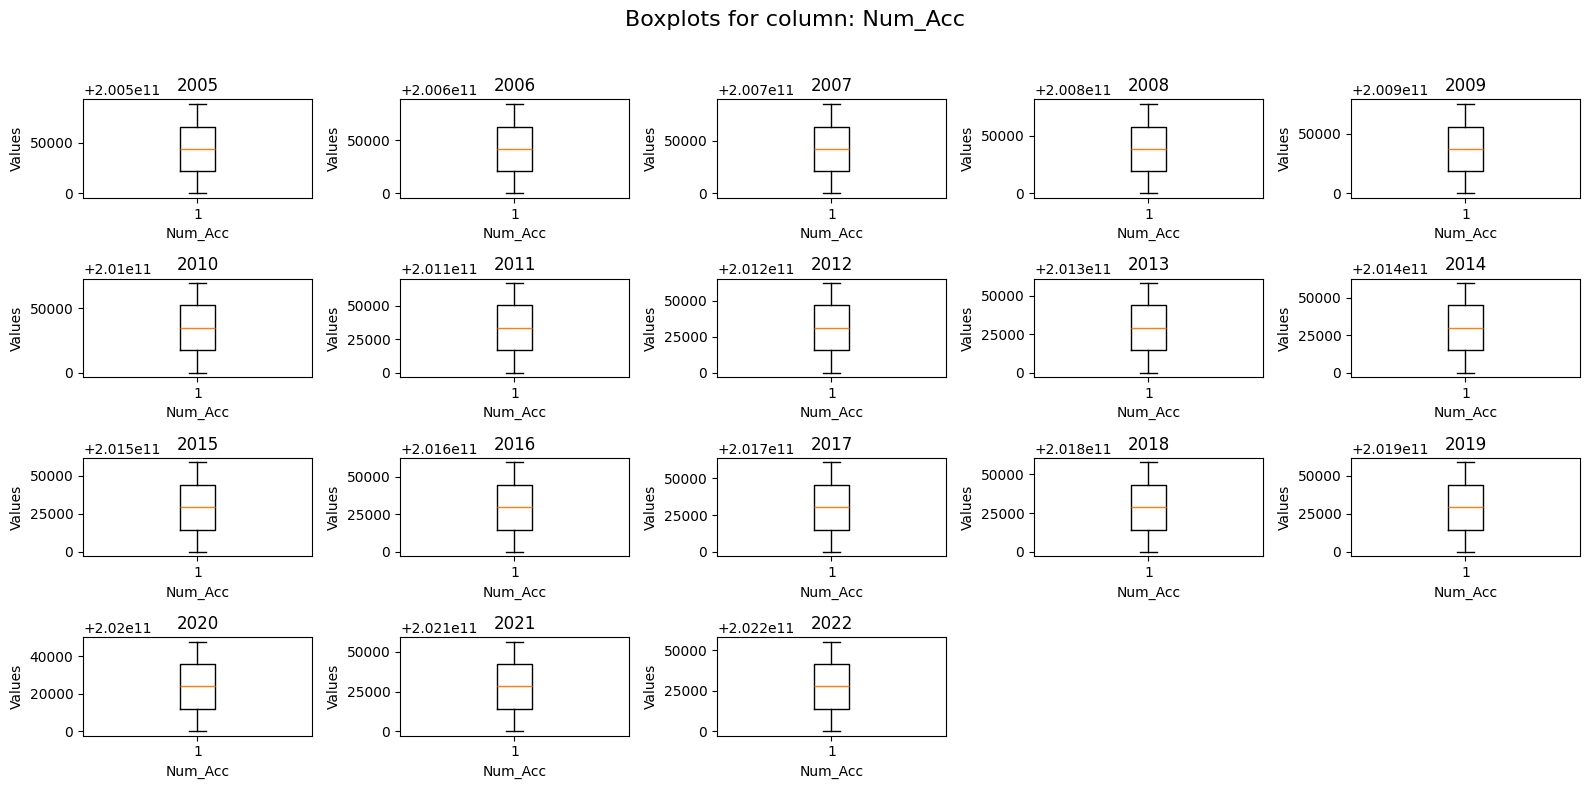

2024-06-10 17:10:53,835 - WARNING - Le nombre de modalités uniques dans la colonne Num_Acc excède le seuil de 50. Auncun bar plot généré.
2024-06-10 17:10:54,144 - WARNING - Le nombre de modalités uniques dans la colonne Num_Acc excède le seuil de 12. Aucun graphique en ligne généré.



Colonne: prof / lignes: 1176873
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  int64         1                              0                                  0
   2006  int64         1                              0                                  0
   2007  int64         1                              0                                  0
   2008  int64         1                              0                                  0
   2009  float64       1                              0.10617                            6.7127e-05
   2010  float64       1                              0.0619784                          3.65375e-05
   2011  float64       1                              0.188133                           0.000107063
   2012  float64       1                              0.438554                           0.00023197

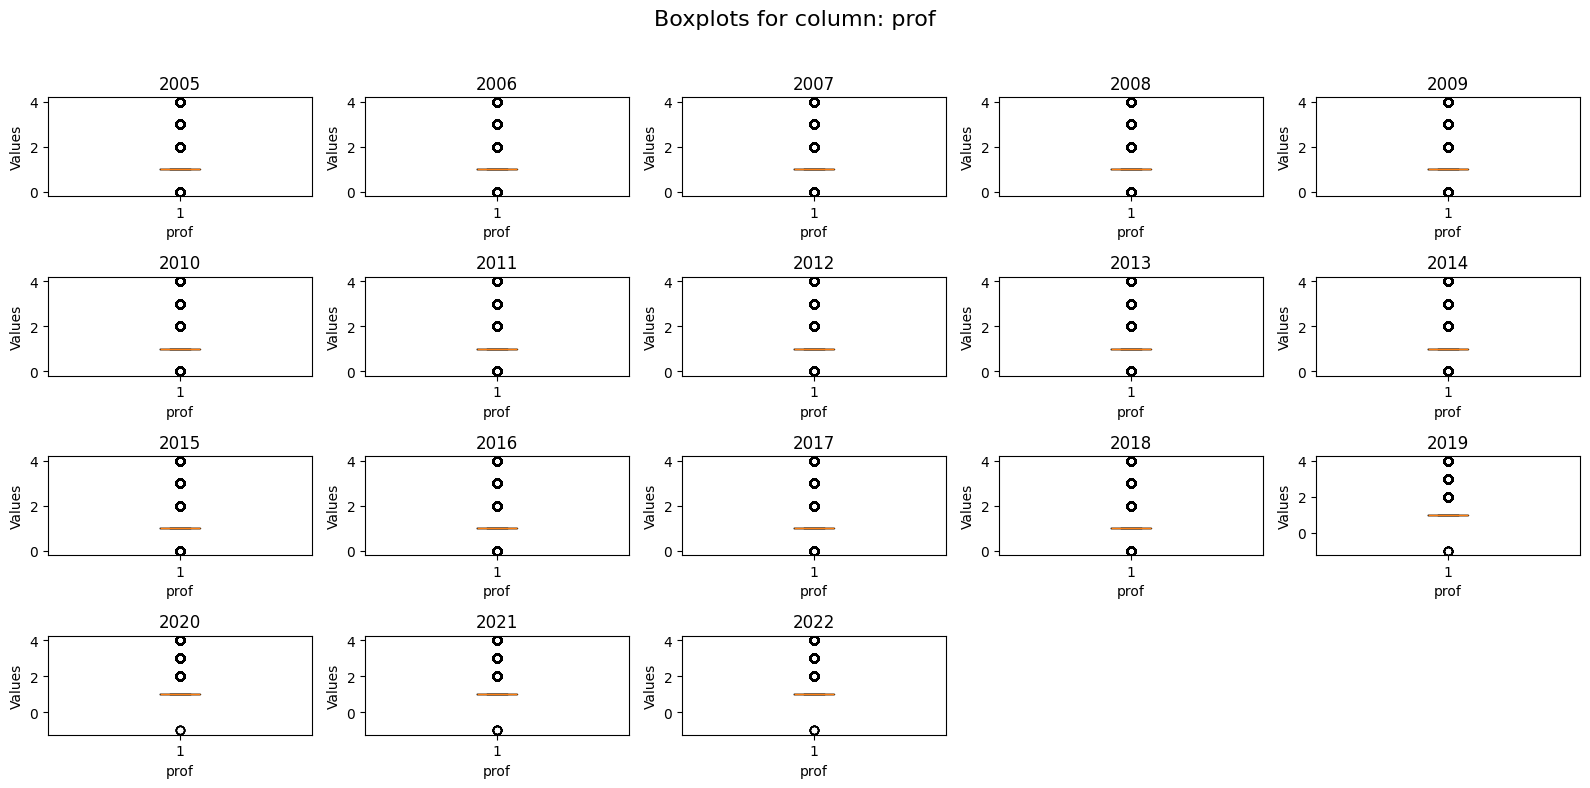

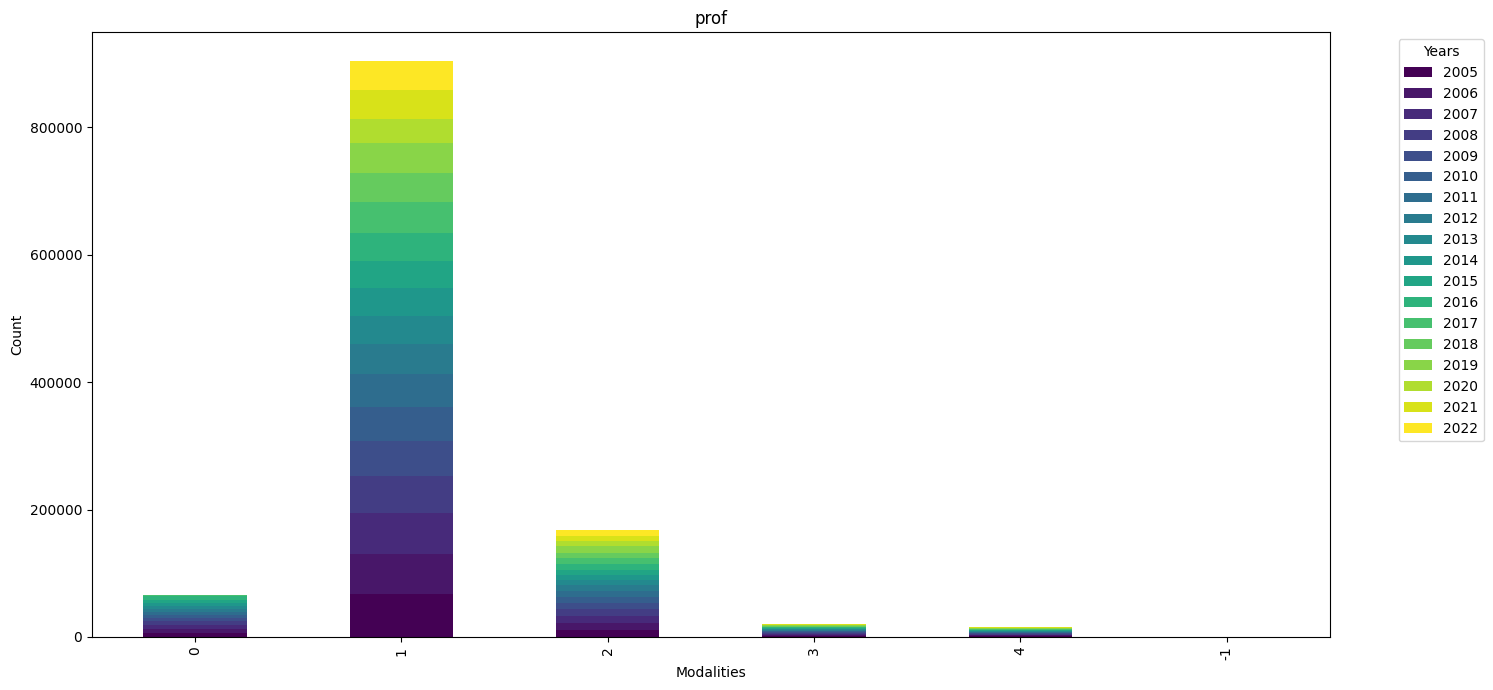

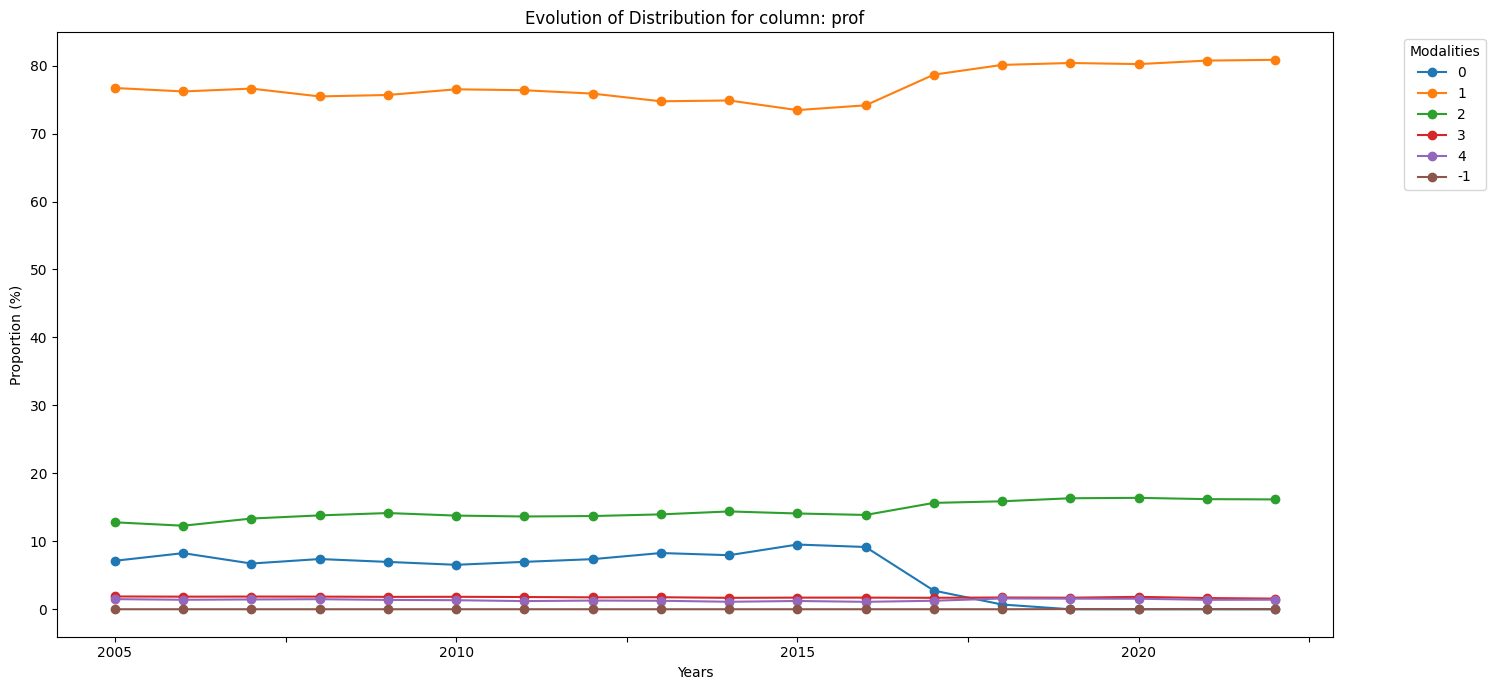


Colonne: situ / lignes: 1176873
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  int64         1                              0                                  0
   2006  int64         1                              0                                  0
   2007  int64         1                              0                                  0
   2008  int64         1                              0                                  0
   2009  float64       1                              0.0792915                          5.01329e-05
   2010  float64       1                              0.0446821                          2.6341e-05
   2011  float64       1                              0.155284                           8.83698e-05
   2012  float64       1                              0.388755                           0.00020563

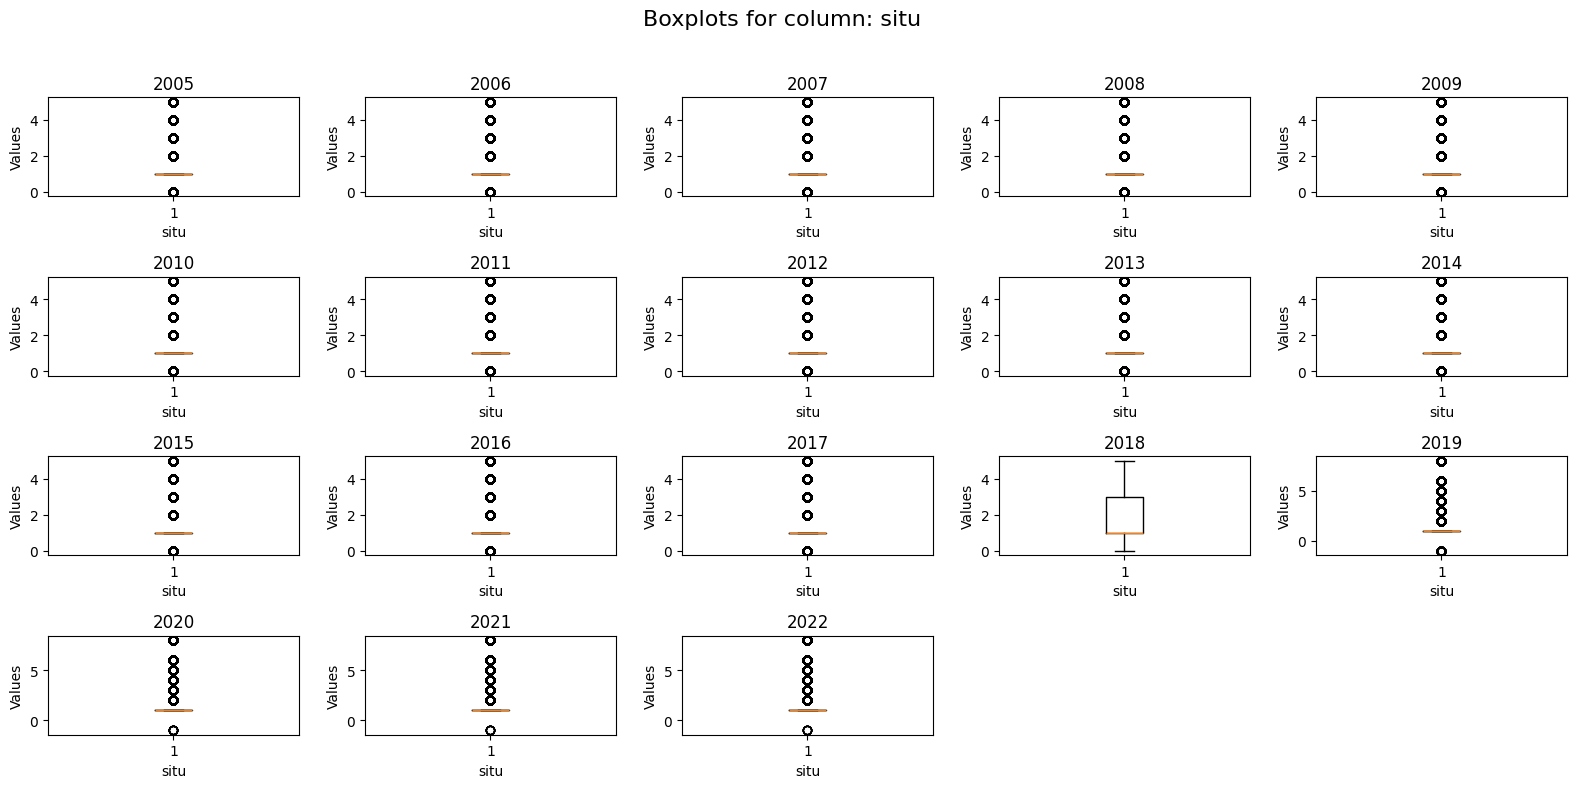

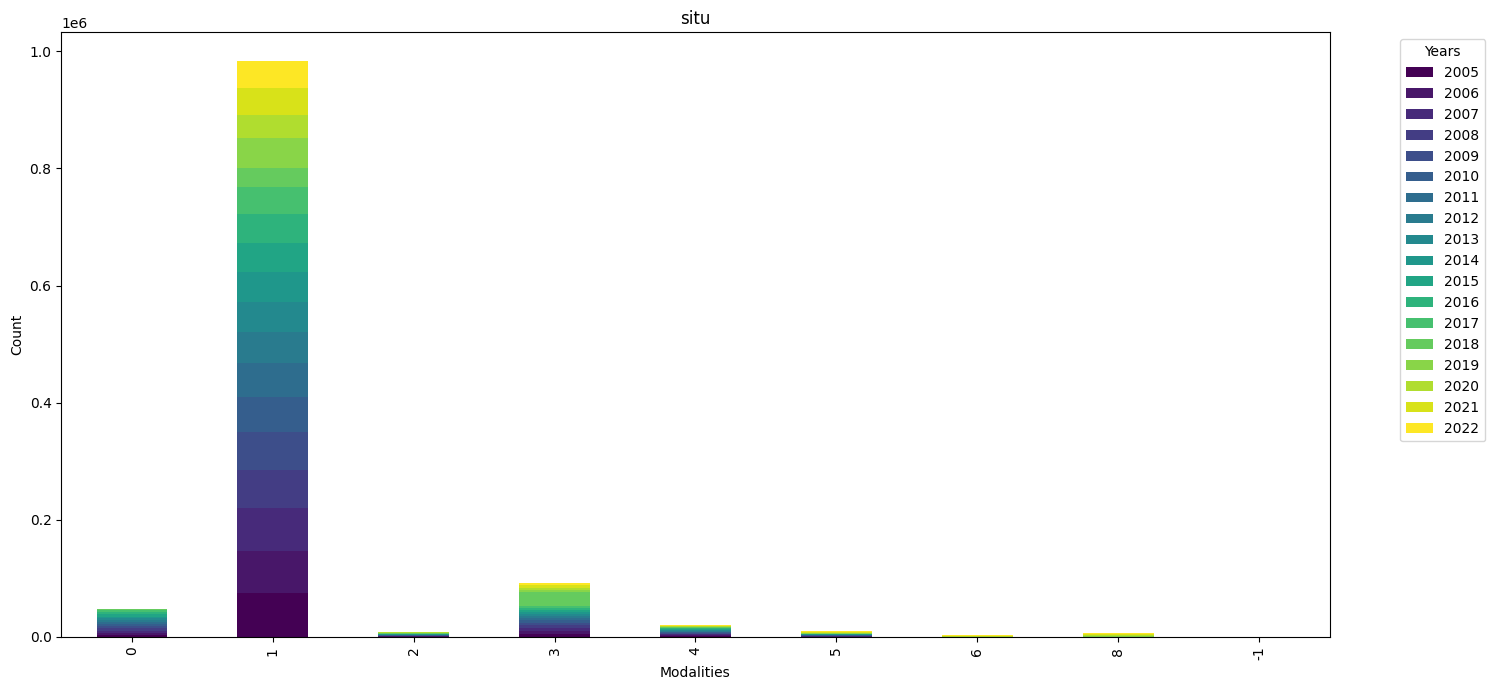

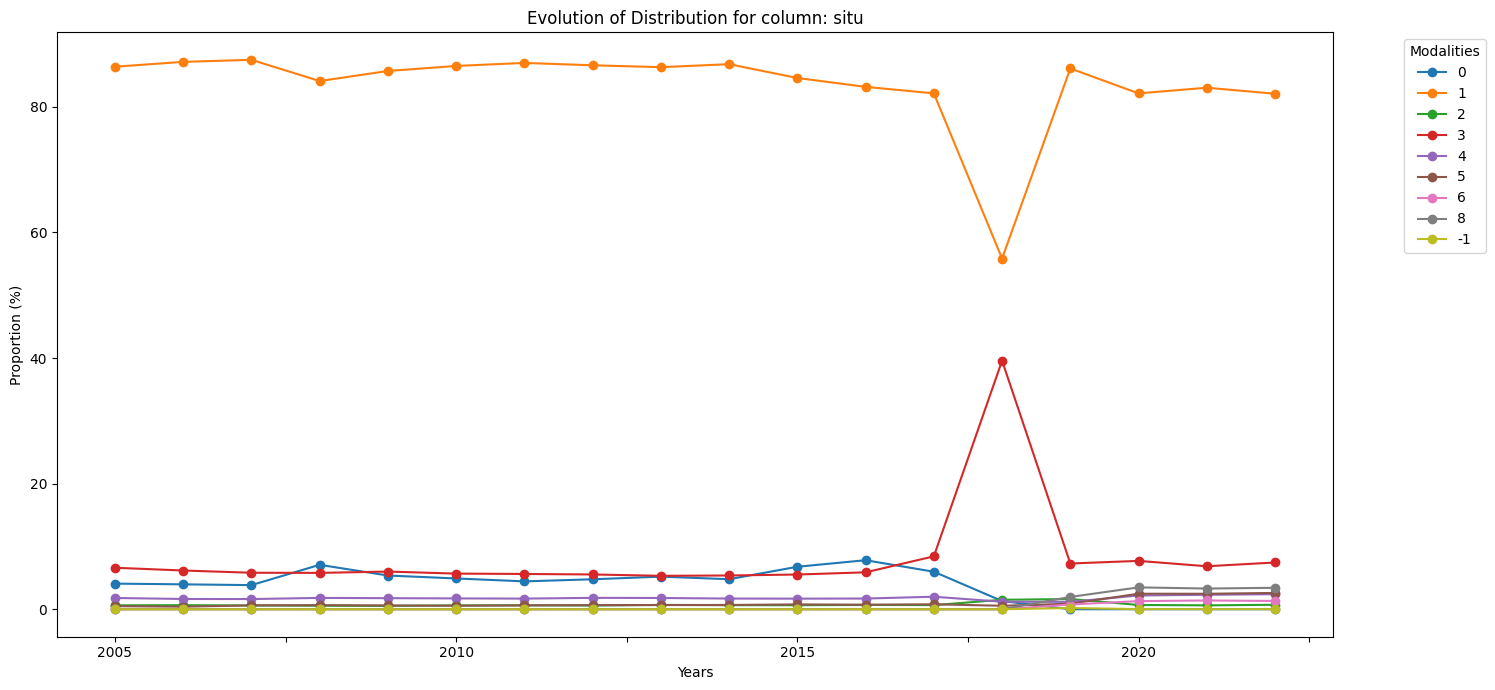


Colonne: larrout / lignes: 1176873
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  int64         0                               0                                 0
   2006  int64         0                               0                                 0
   2007  int64         0                               0                                 0
   2008  int64         0                               0                                 0
   2009  float64       0                               0.482469                          0.000305046
   2010  float64       0                               0.531861                          0.000313543
   2011  float64       0                               0.886911                          0.000504727
   2012  float64       0                               1.48273                           0.0007

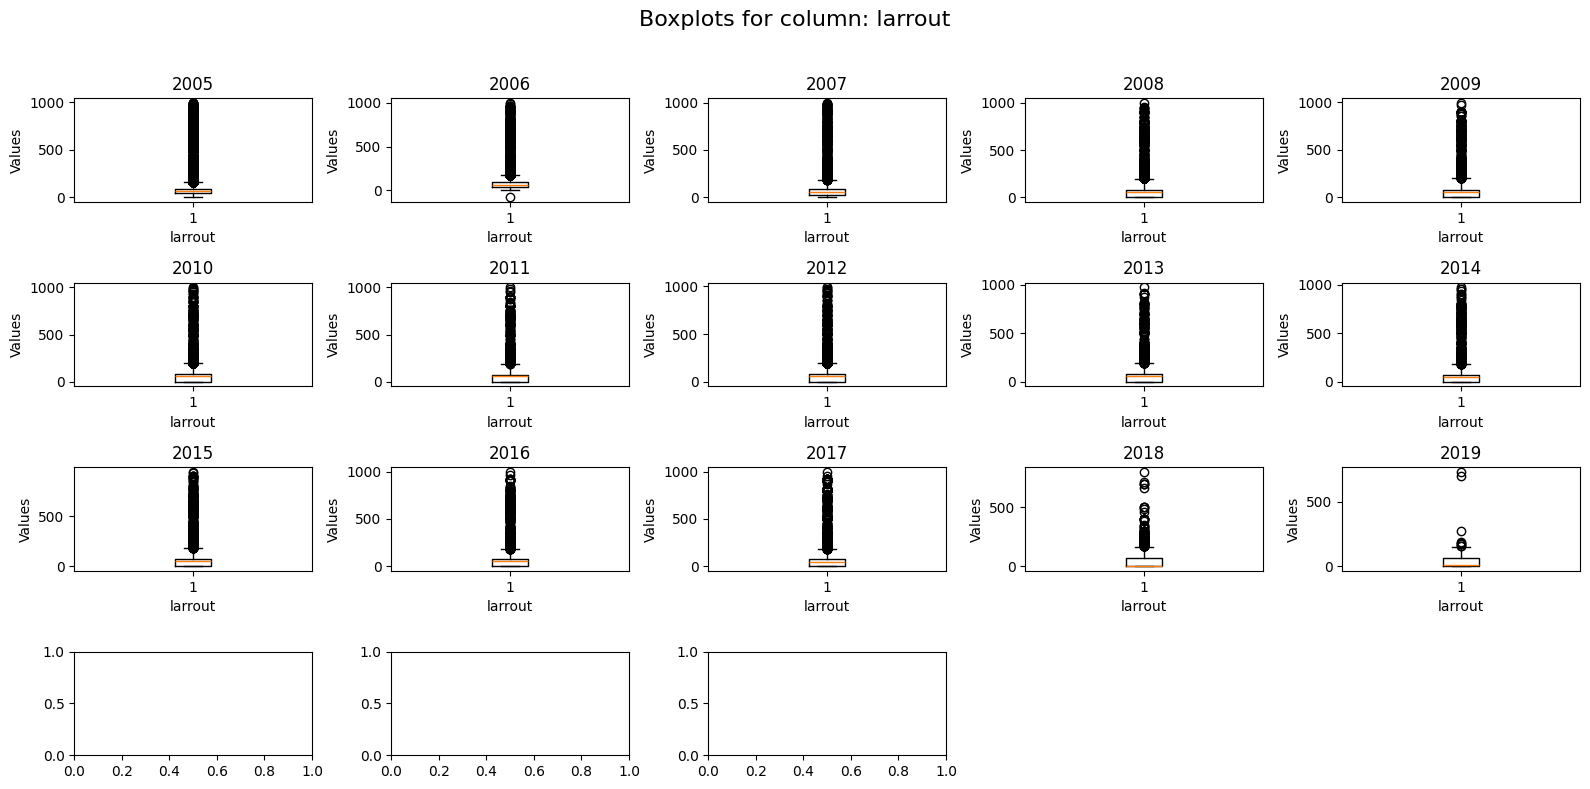

2024-06-10 17:11:01,940 - WARNING - Le nombre de modalités uniques dans la colonne larrout excède le seuil de 50. Auncun bar plot généré.
2024-06-10 17:11:01,988 - WARNING - Le nombre de modalités uniques dans la colonne larrout excède le seuil de 12. Aucun graphique en ligne généré.



Colonne: env1 / lignes: 1176873
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  int64         0                               0                                 0
   2006  int64         0                               0                                 0
   2007  int64         0                               0                                 0
   2008  int64         0                               0                                 0
   2009  float64       0                               0.200245                          0.000126607
   2010  float64       0                               0.102336                          6.03294e-05
   2011  float64       0                               0.192612                          0.000109613
   2012  float64       0                               0.432129                          0.0002285

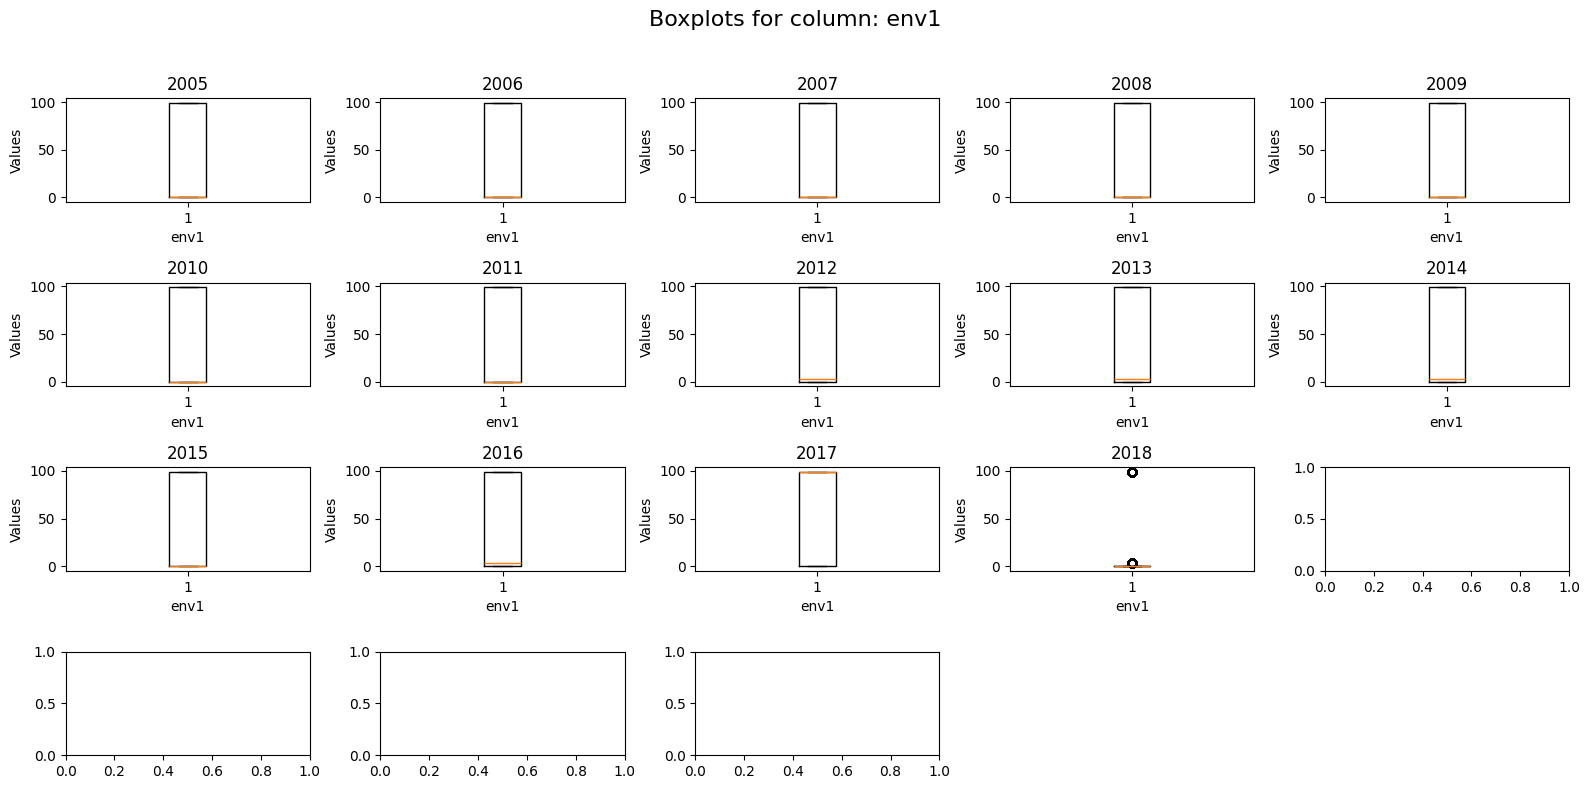

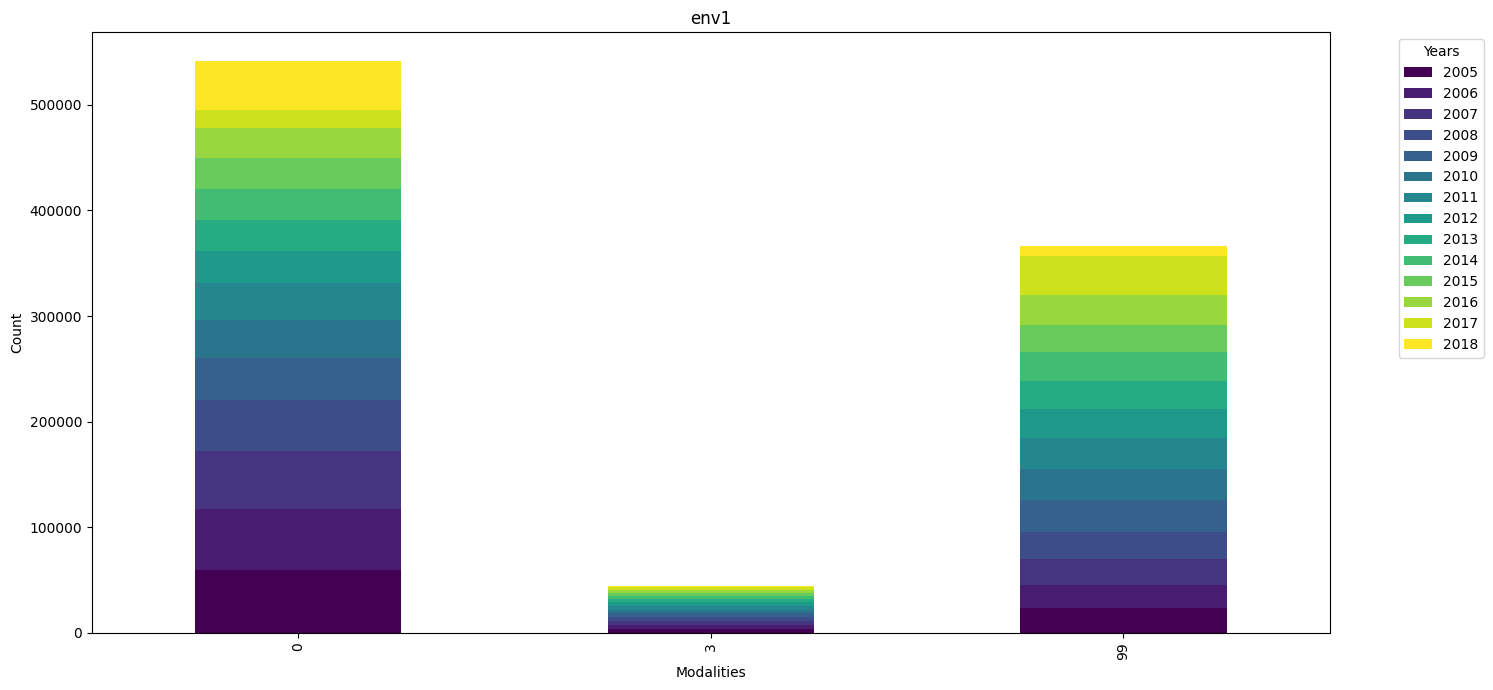

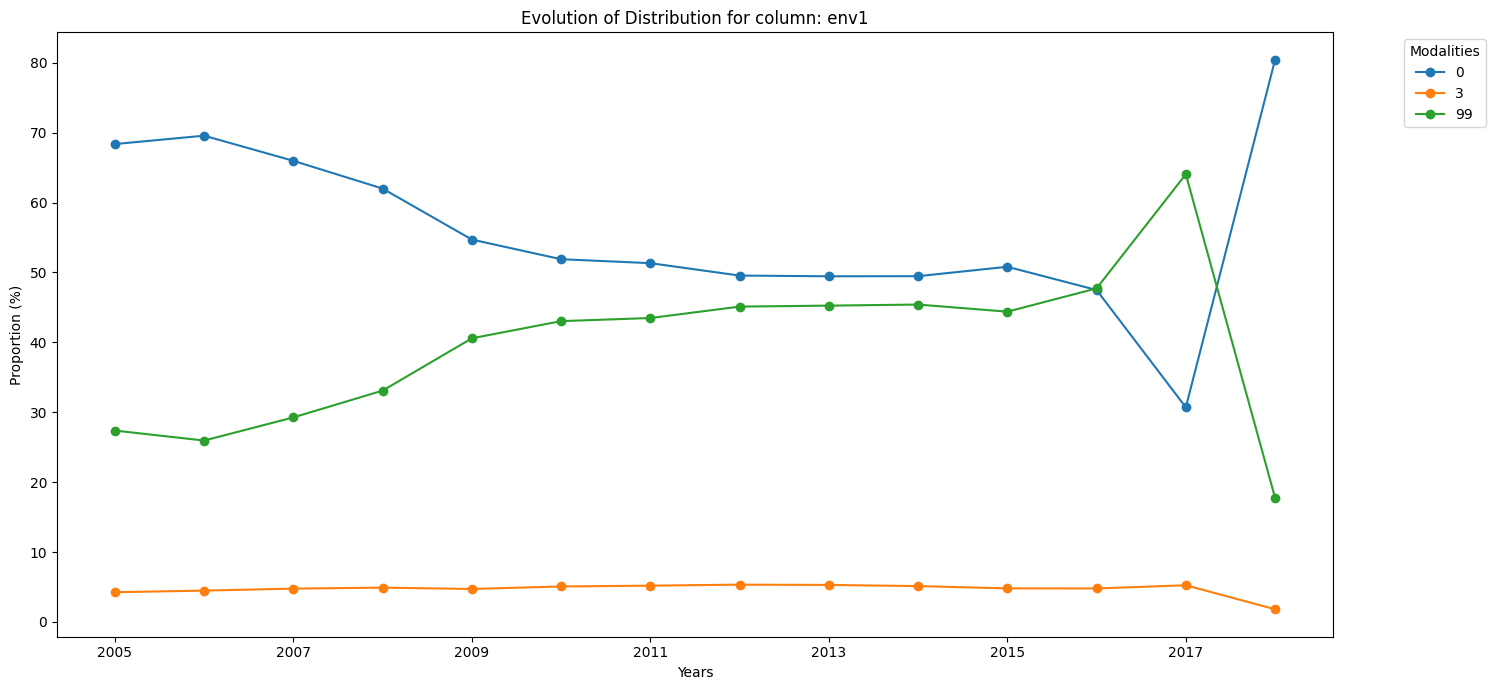


Colonne: infra / lignes: 1176873
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  int64         0                              0                                  0
   2006  int64         0                              0                                  0
   2007  int64         0                              0                                  0
   2008  int64         0                              0                                  0
   2009  float64       0                              0.225779                           0.000142751
   2010  float64       0                              0.0835988                          4.92831e-05
   2011  float64       0                              0.194105                           0.000110462
   2012  float64       0                              0.443373                           0.000234

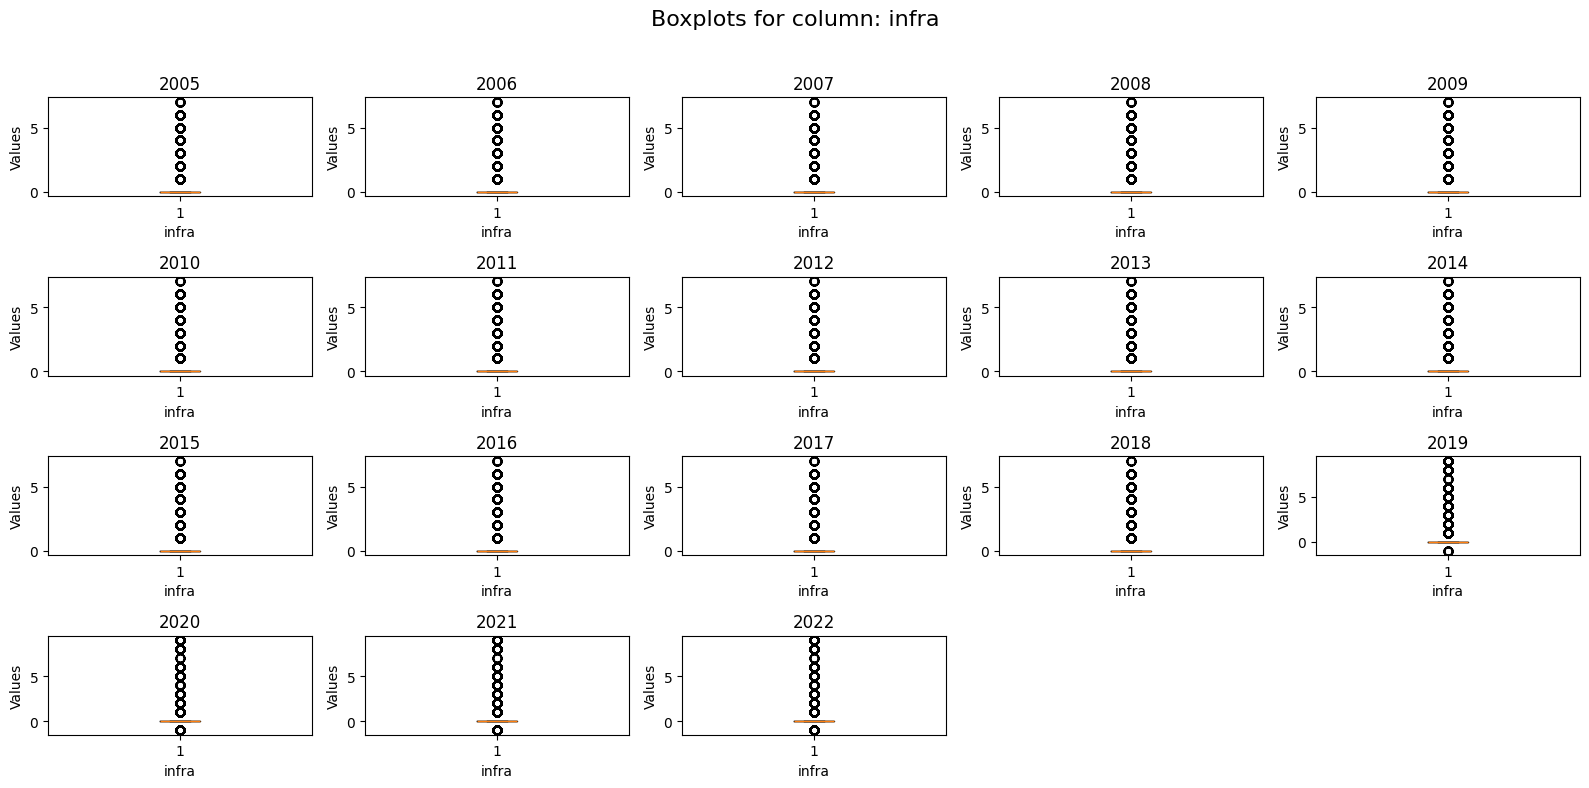

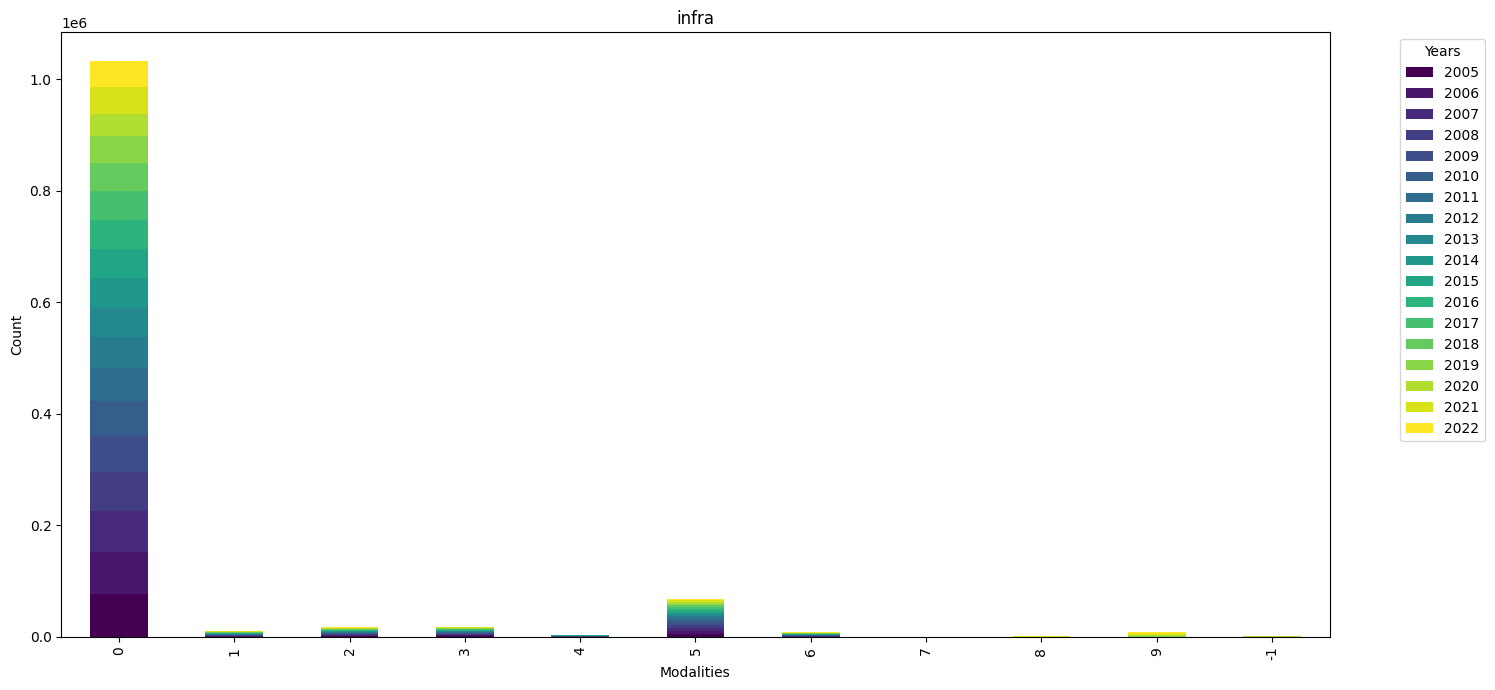

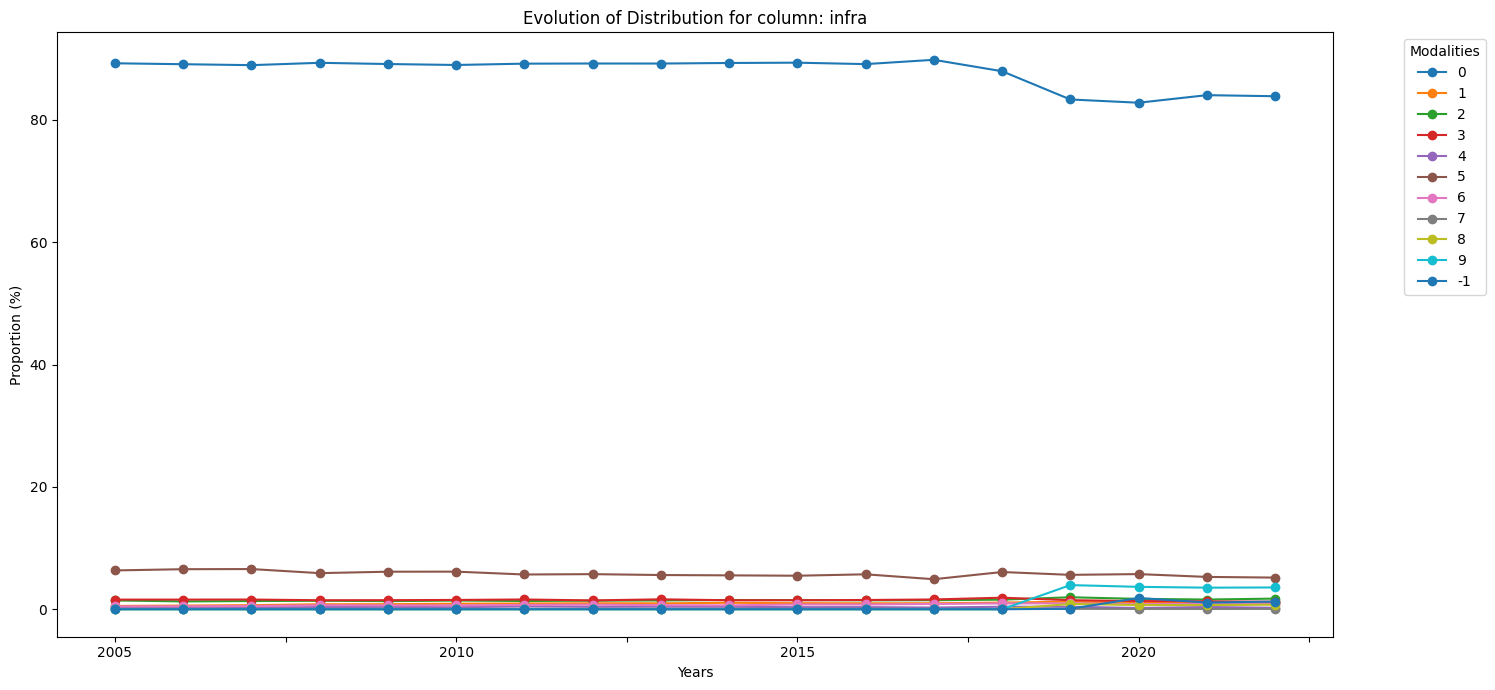


Colonne: vma / lignes: 1176873
  Année  Type      Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  ------  -------------------------------------  -----------------------------------
   2019  int64       50                                      0                                    0
   2020  int64       50                                      0                                    0
   2021  int64       50                                      0                                    0
   2022  int64       50                                      0                                    0


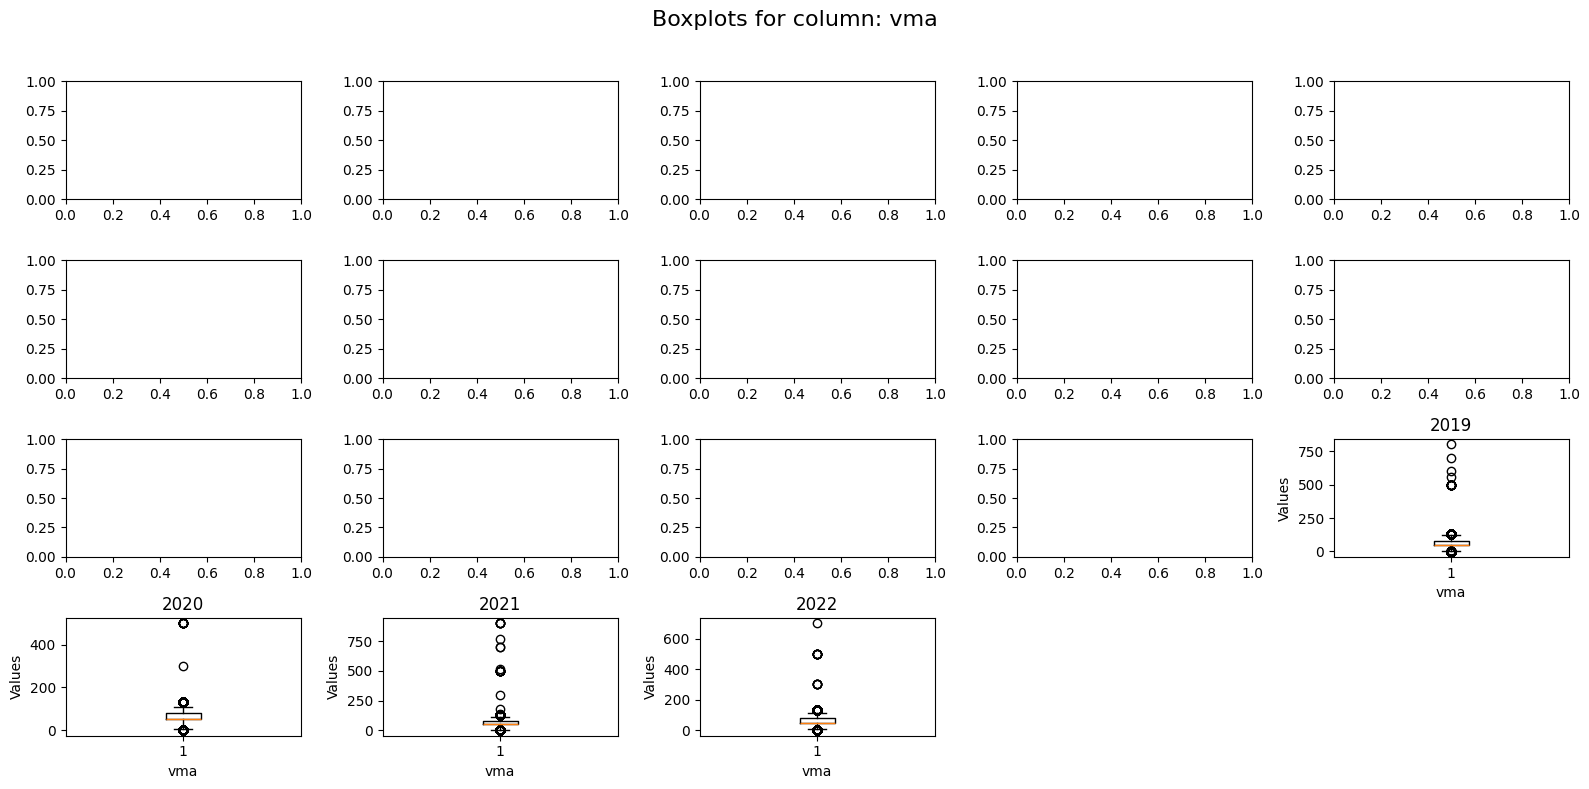

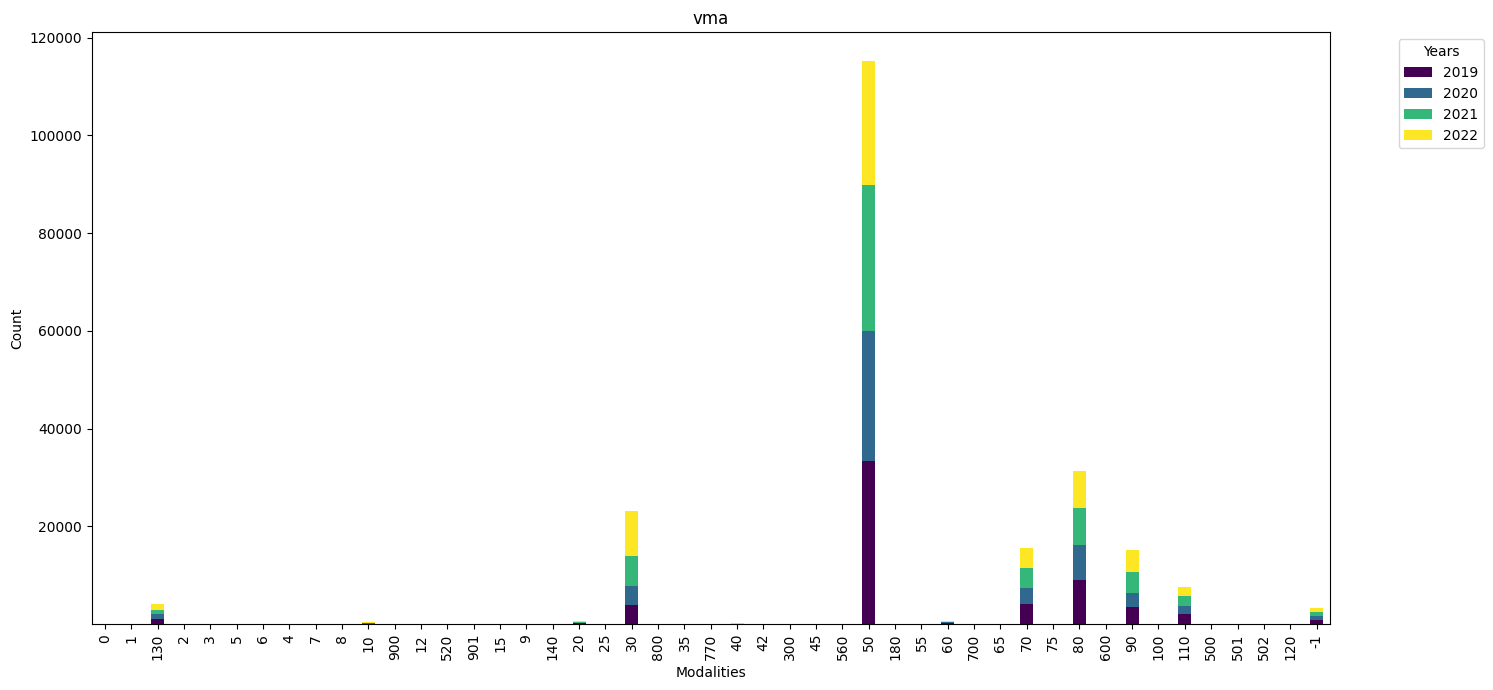

2024-06-10 17:11:09,678 - WARNING - Le nombre de modalités uniques dans la colonne vma excède le seuil de 12. Aucun graphique en ligne généré.



Colonne: v1 / lignes: 1176873
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  float64       0                             0.235562                            0.00017419
   2006  float64       0                             0.0385575                           2.71907e-05
   2007  float64       0                             0.00715564                          5.09826e-06
   2008  float64       0                             0.0130264                           8.49709e-06
   2009  float64       2                            99.5511                              0.0629422
   2010  float64       2                            99.6353                              0.058737
   2011  float64       2                            99.6297                              0.0566977
   2012  float64       2                            99.5984         

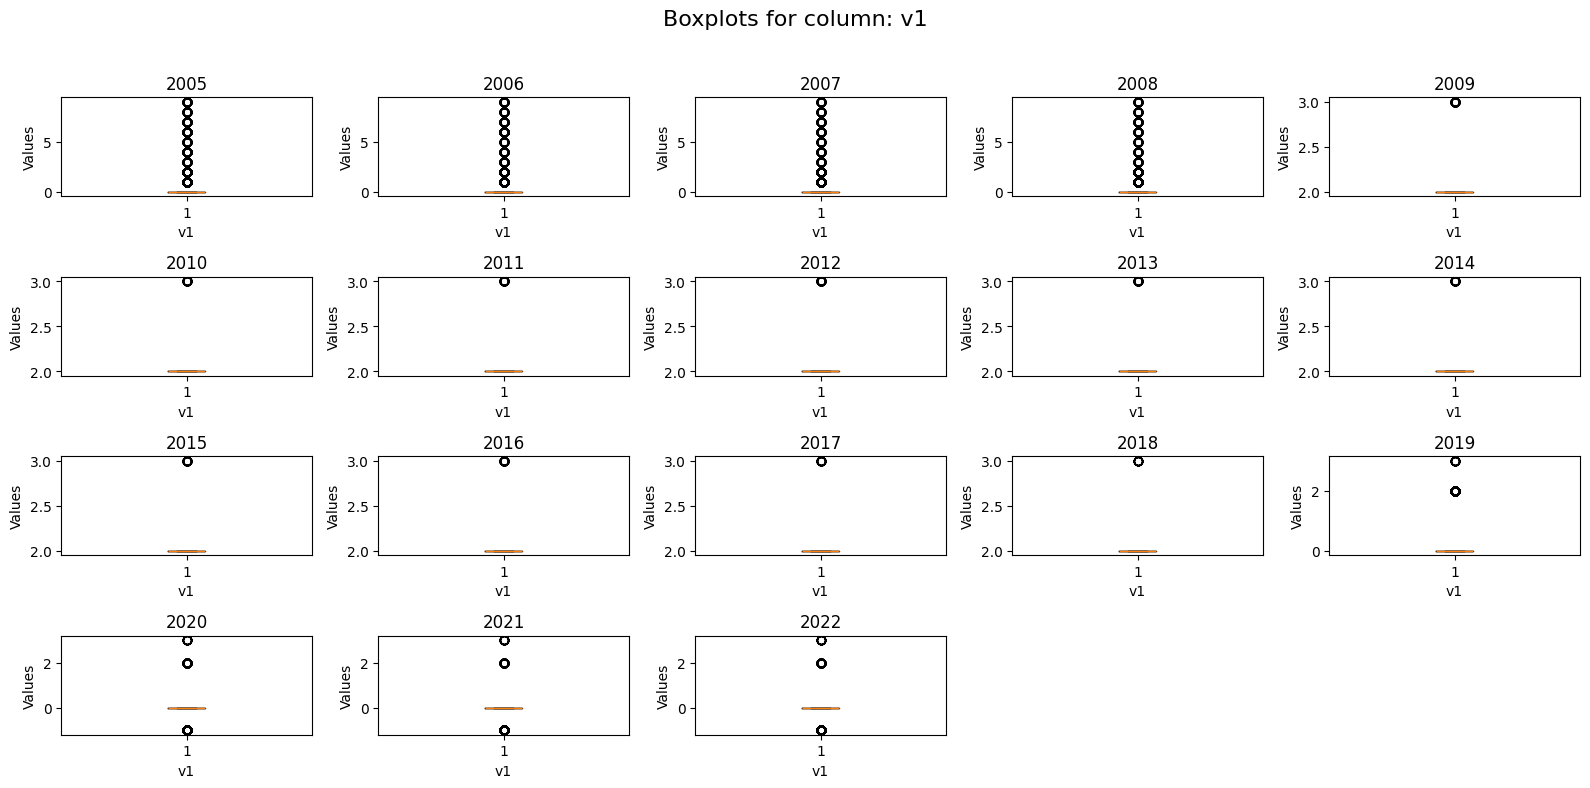

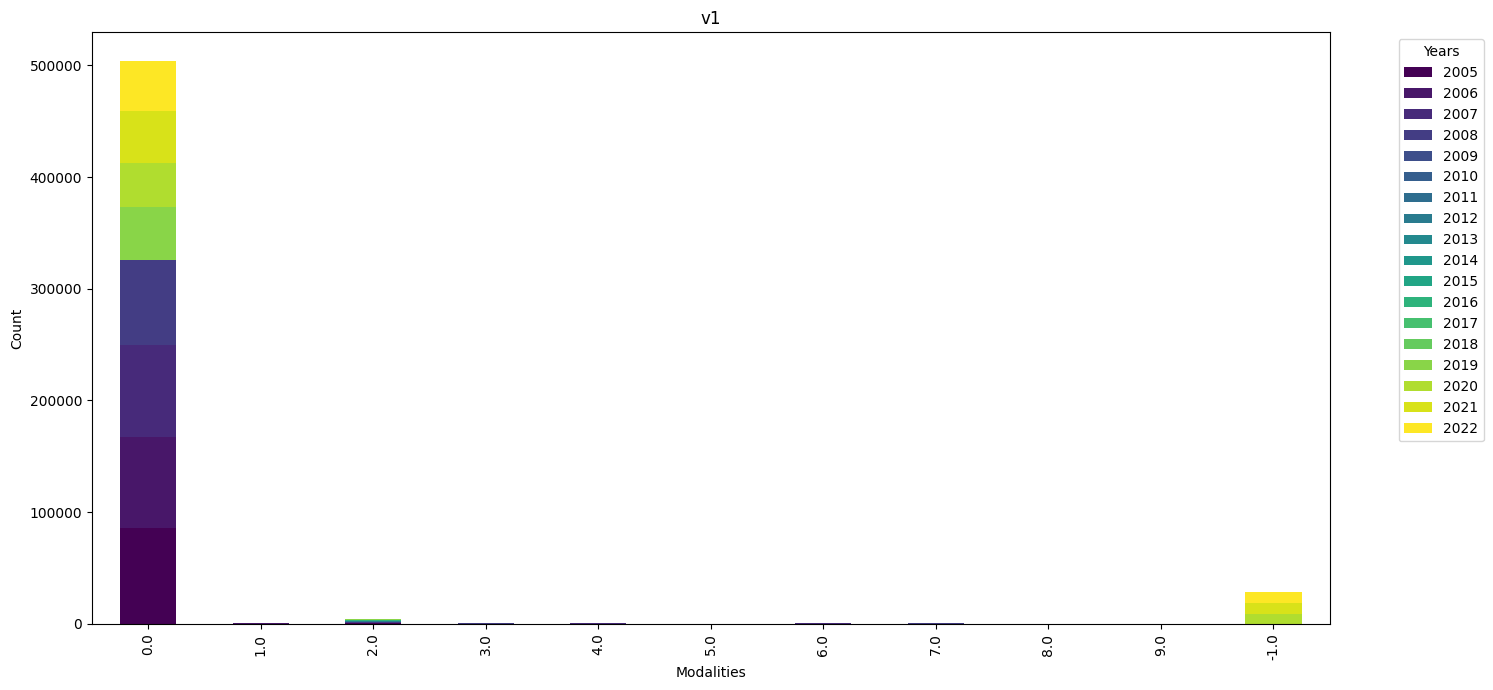

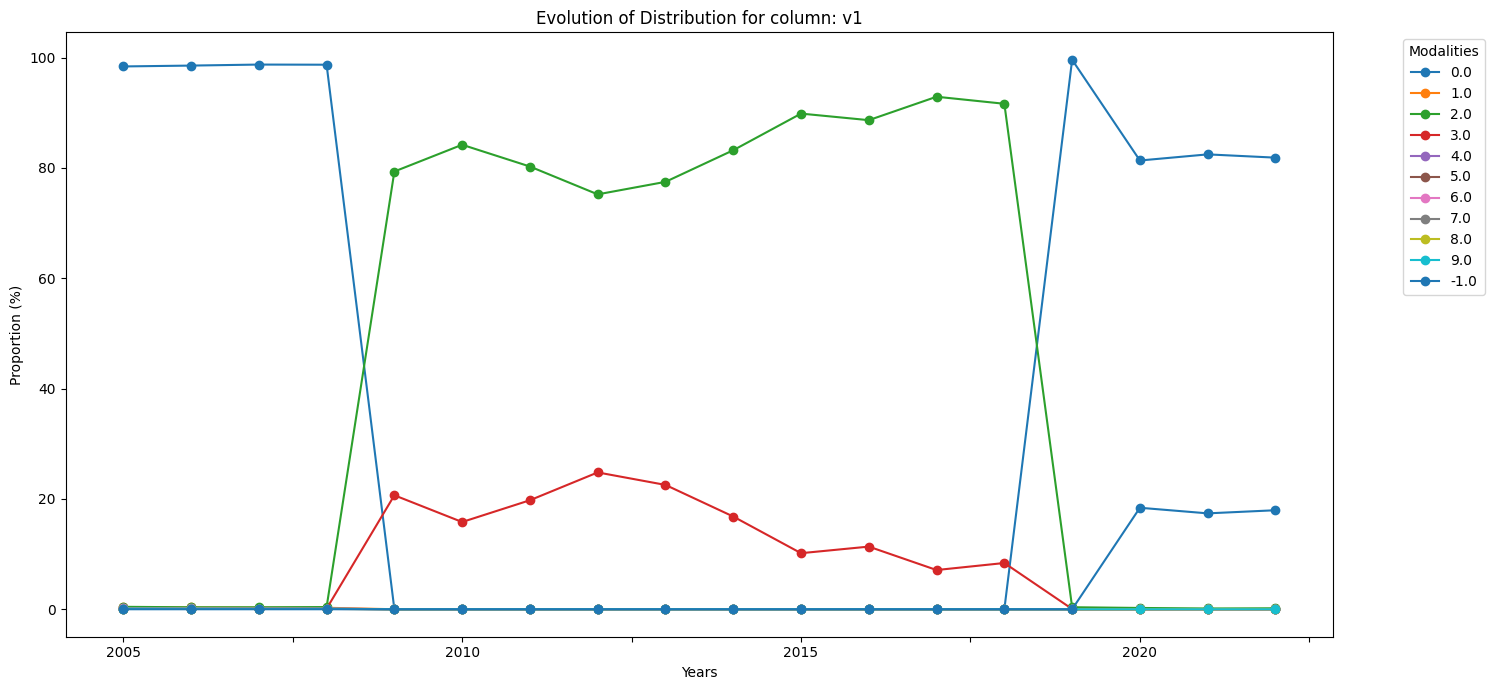

2024-06-10 17:11:12,685 - INFO - La colonne v2 n'est pas numérique.
2024-06-10 17:11:12,715 - WARNING - Le nombre de modalités uniques dans la colonne v2 excède le seuil de 50. Auncun bar plot généré.
2024-06-10 17:11:12,791 - WARNING - Le nombre de modalités uniques dans la colonne v2 excède le seuil de 12. Aucun graphique en ligne généré.



Colonne: v2 / lignes: 1176873
  Année  Type    Mode      Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  ------  -------------------------------------  -----------------------------------
   2005  object  A                                     97.5456                            0.0721318
   2006  object  A                                     93.7127                            0.0660861
   2007  object  A                                     93.8831                            0.06689
   2008  object  A                                     94.5419                            0.0616694
   2009  object  A                                     95.5731                            0.0604271
   2010  object  A                                     97.0596                            0.0572186
   2011  object  A                                     96.9988                            0.0552005
   2012  object  0                                     96.1012         


Colonne: catr / lignes: 1176873
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  float64       4                             0.00114908                          8.49709e-07
   2006  int64         4                             0                                   0
   2007  int64         4                             0                                   0
   2008  int64         4                             0                                   0
   2009  int64         4                             0                                   0
   2010  int64         4                             0                                   0
   2011  int64         4                             0                                   0
   2012  int64         4                             0                                   0
   2013  int64         4   

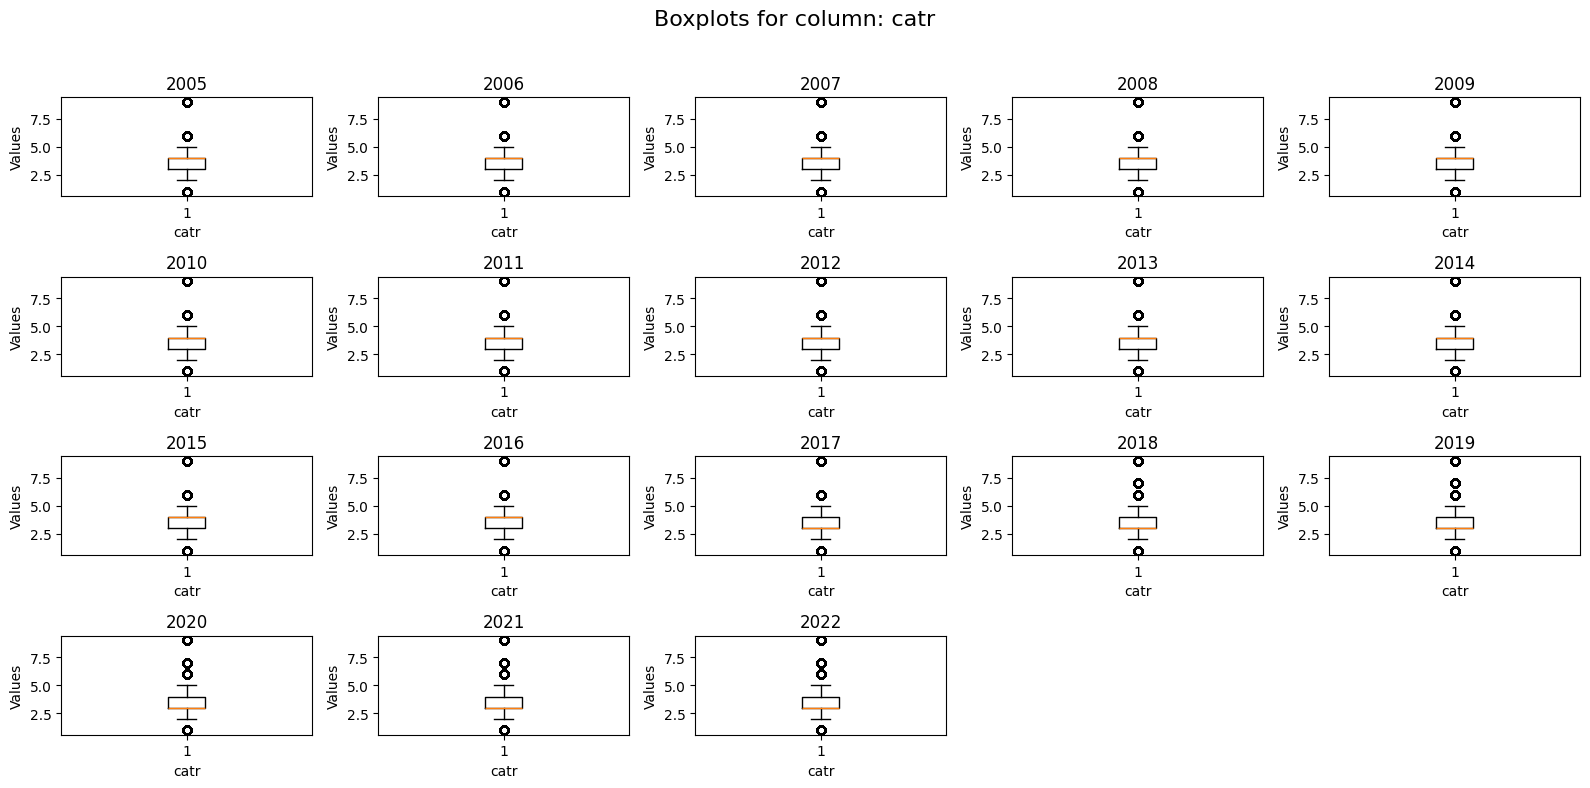

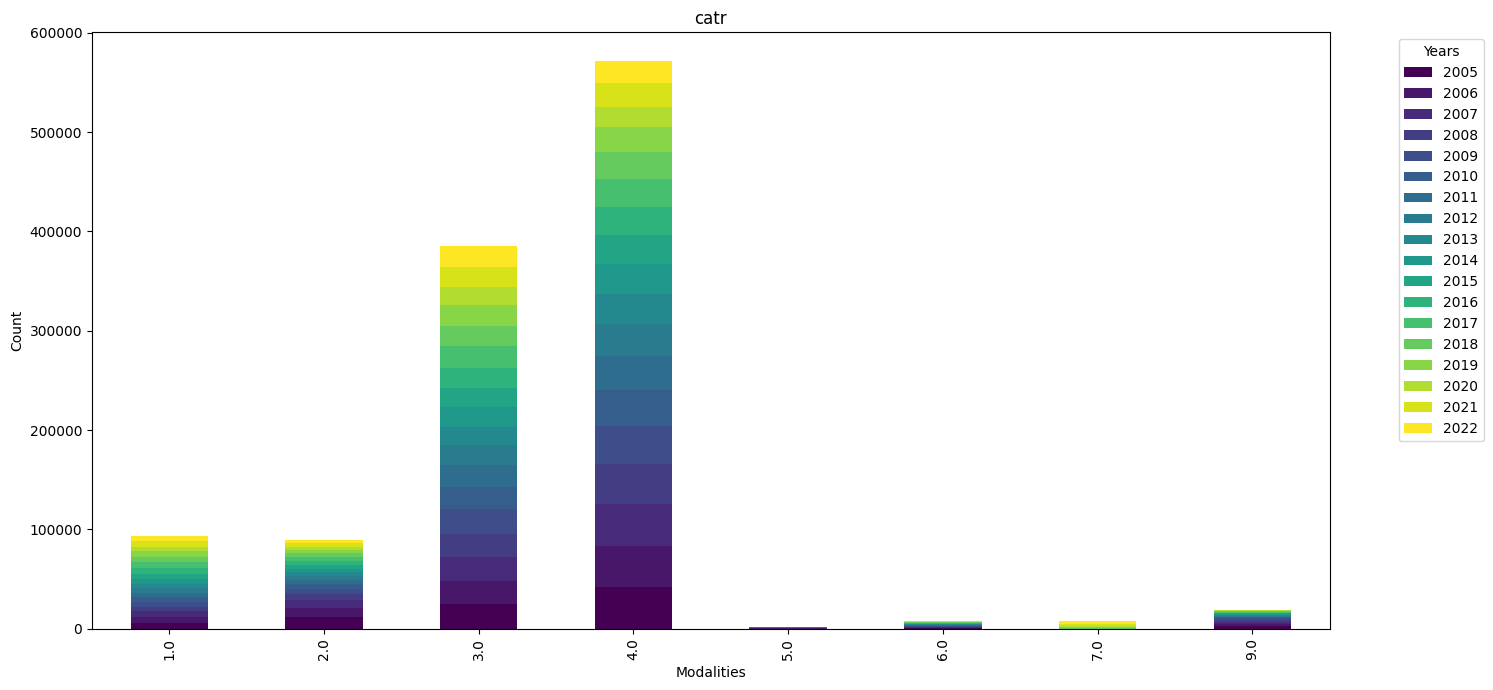

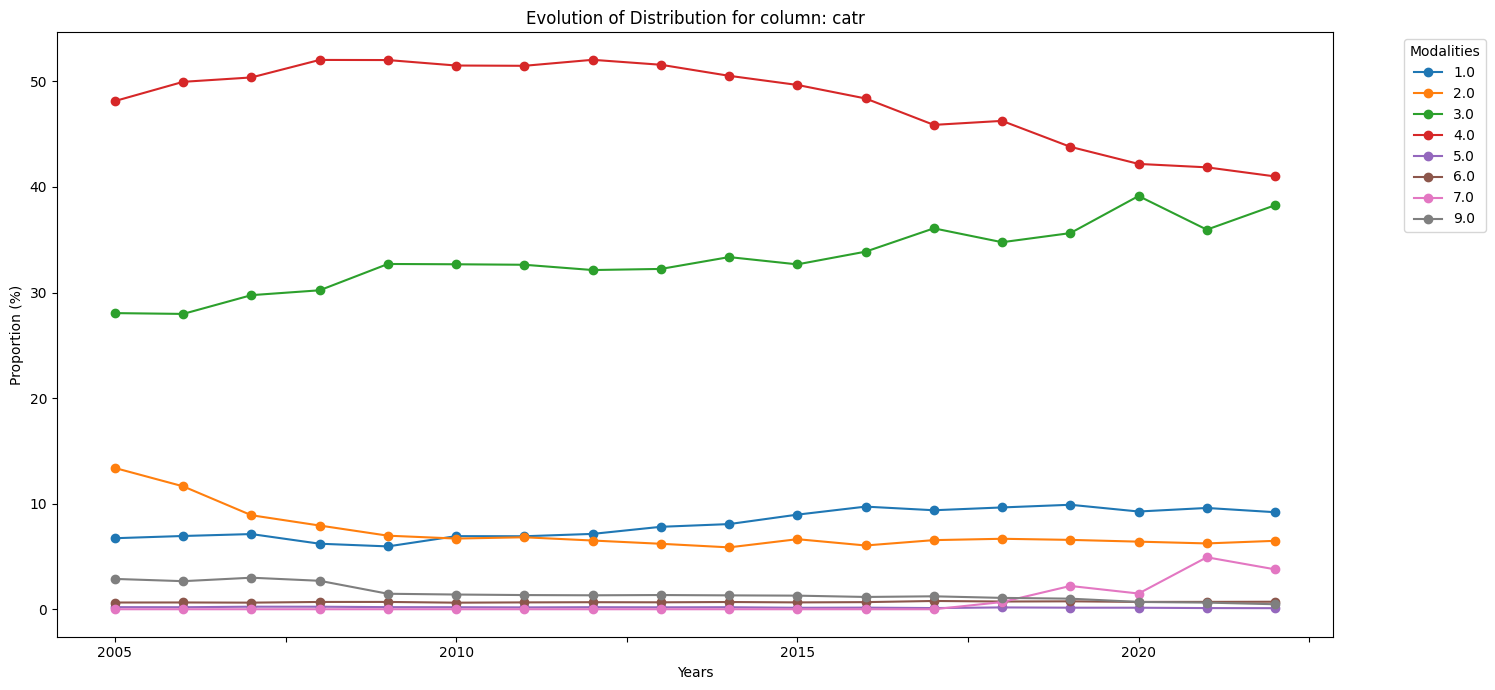


Colonne: circ / lignes: 1176873
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  int64         2                              0                                  0
   2006  int64         2                              0                                  0
   2007  int64         2                              0                                  0
   2008  int64         2                              0                                  0
   2009  float64       2                              0.0819793                          5.18323e-05
   2010  float64       2                              0.0634198                          3.73872e-05
   2011  float64       2                              0.173202                           9.85663e-05
   2012  float64       2                              0.353414                           0.0001869

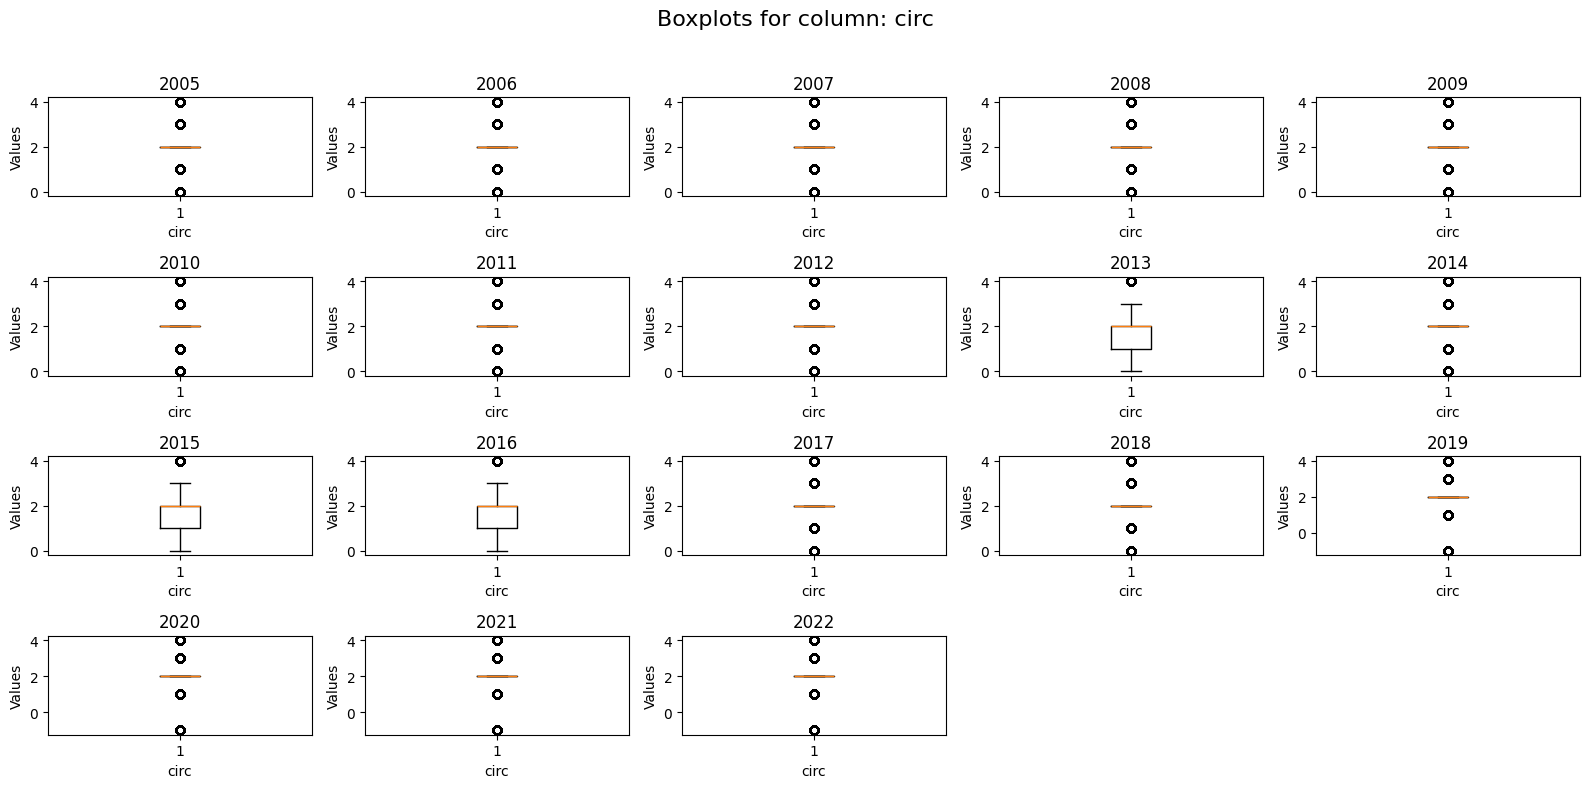

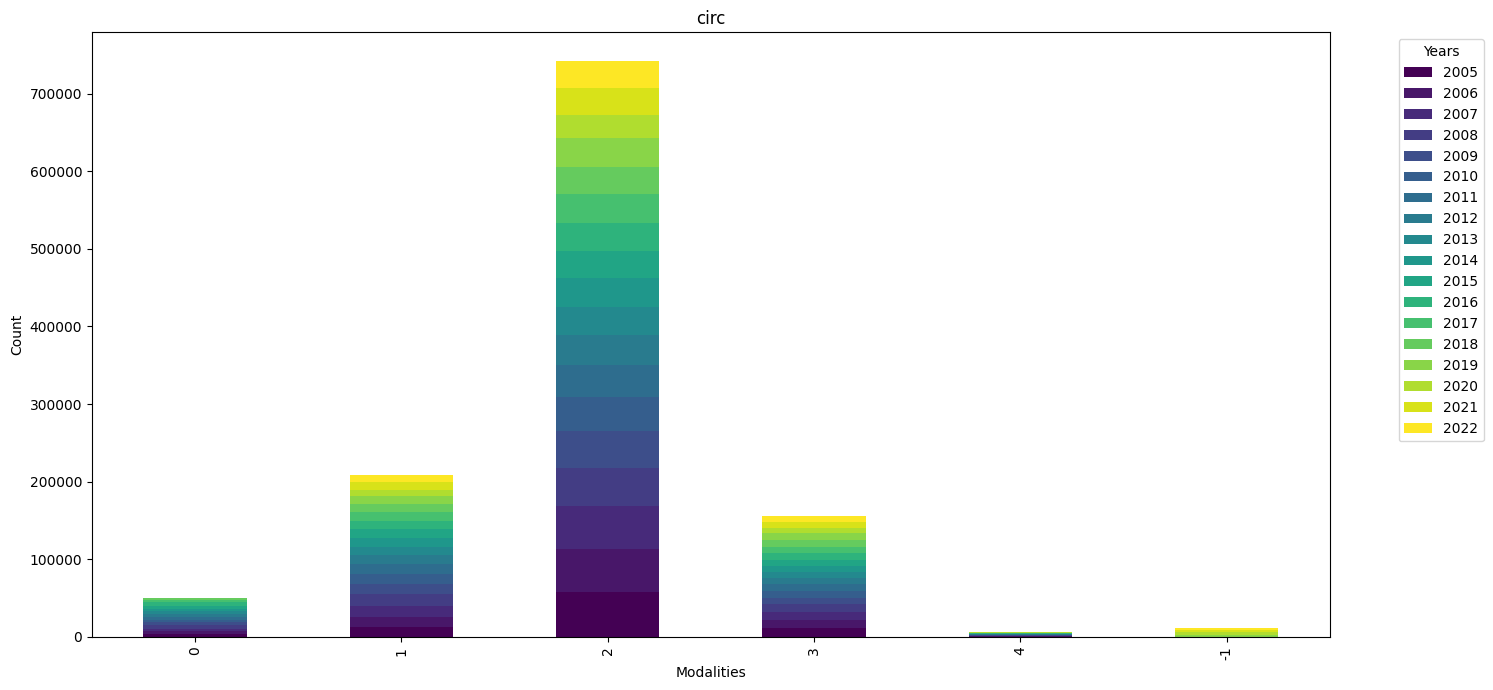

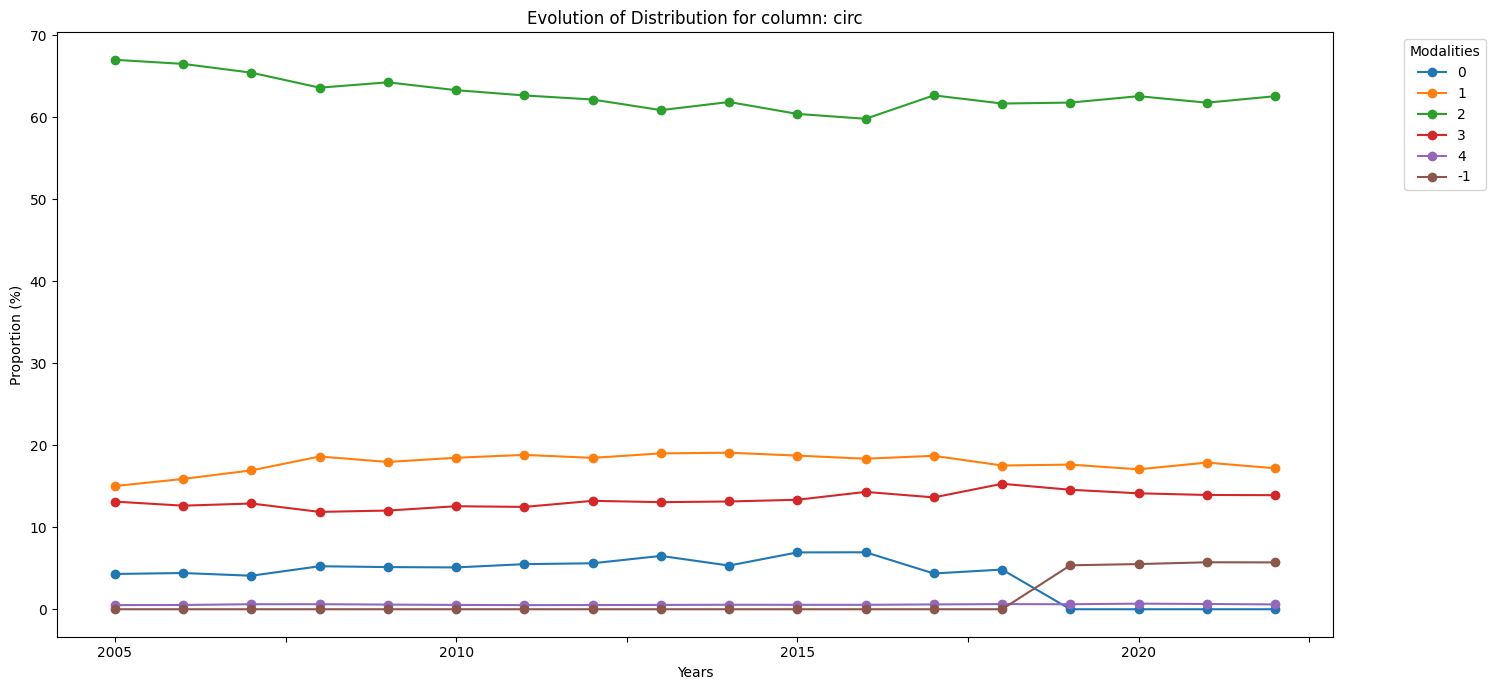


Colonne: nbv / lignes: 1176873
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  int64         2                               0                                 0
   2006  int64         2                               0                                 0
   2007  int64         2                               0                                 0
   2008  int64         2                               0                                 0
   2009  float64       2                               0.862799                          0.000545513
   2010  float64       2                               0.147019                          8.66704e-05
   2011  float64       2                               0.267268                          0.000152098
   2012  float64       2                               0.424096                          0.00022432

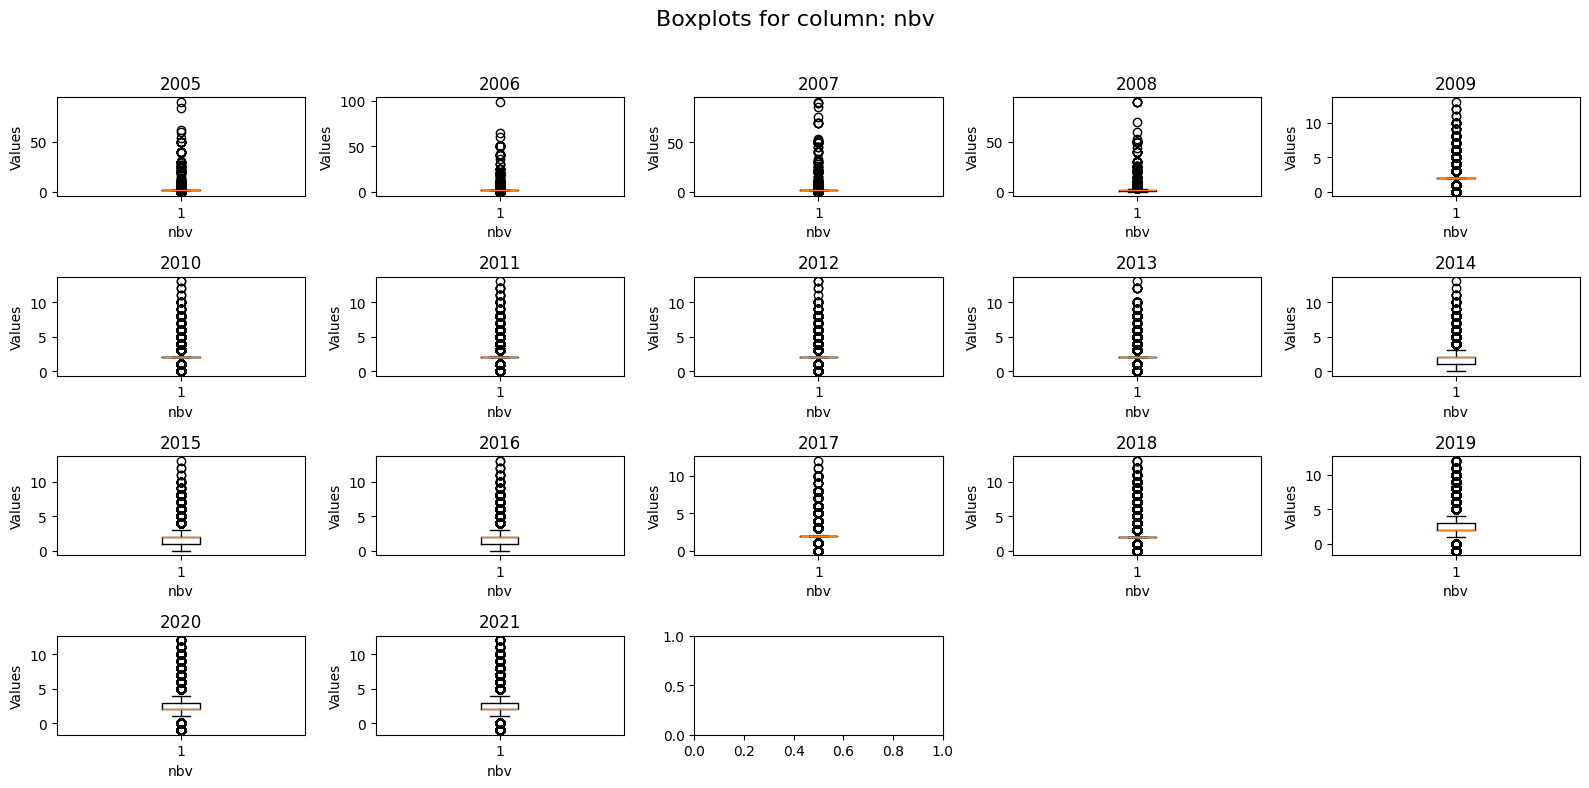

2024-06-10 17:11:20,689 - WARNING - Le nombre de modalités uniques dans la colonne nbv excède le seuil de 50. Auncun bar plot généré.
2024-06-10 17:11:20,709 - WARNING - Le nombre de modalités uniques dans la colonne nbv excède le seuil de 12. Aucun graphique en ligne généré.



Colonne: pr / lignes: 1176873
  Année  Type     Mode      Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  float64  0.0                                   45.4014                            0.0335729
   2006  float64  0.0                                   46.6678                            0.0329101
   2007  float64  0.0                                   53.5015                            0.0381188
   2008  float64  0.0                                   58.8039                            0.0383576
   2009  float64  0.0                                   37.4753                            0.0236941
   2010  float64  0.0                                   40.5137                            0.0238836
   2011  float64  0.0                                   51.3557                            0.0292258
   2012  float64  0.0                                   54.2

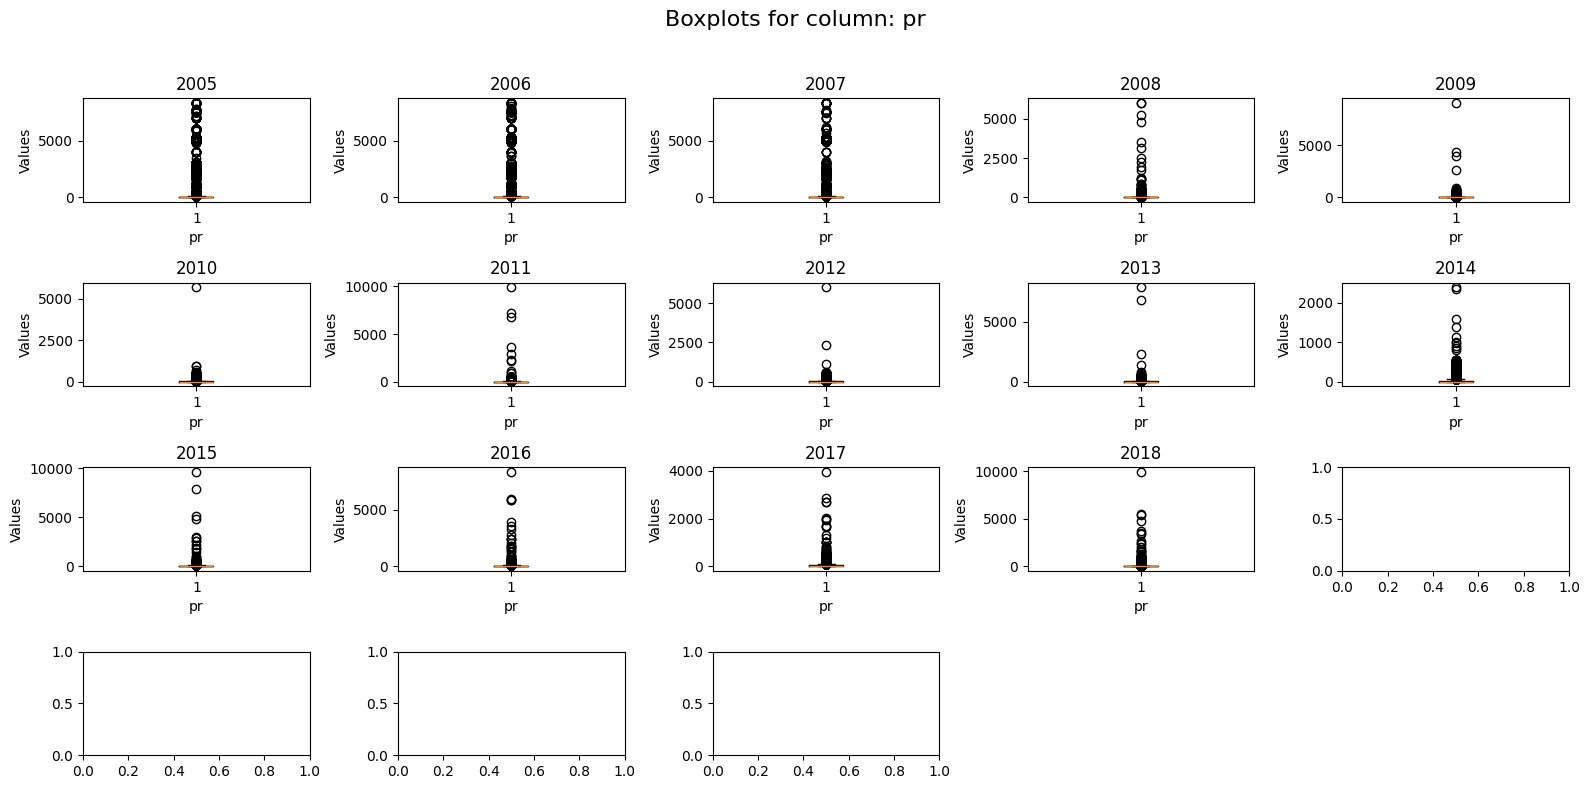

2024-06-10 17:11:22,605 - WARNING - Le nombre de modalités uniques dans la colonne pr excède le seuil de 50. Auncun bar plot généré.
2024-06-10 17:11:22,644 - WARNING - Le nombre de modalités uniques dans la colonne pr excède le seuil de 12. Aucun graphique en ligne généré.



Colonne: surf / lignes: 1176873
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  int64         1                              0                                  0
   2006  int64         1                              0                                  0
   2007  int64         1                              0                                  0
   2008  int64         1                              0                                  0
   2009  float64       1                              0.0913868                          5.77802e-05
   2010  float64       1                              0.0605371                          3.56878e-05
   2011  float64       1                              0.192612                           0.000109613
   2012  float64       1                              0.448193                           0.0002370

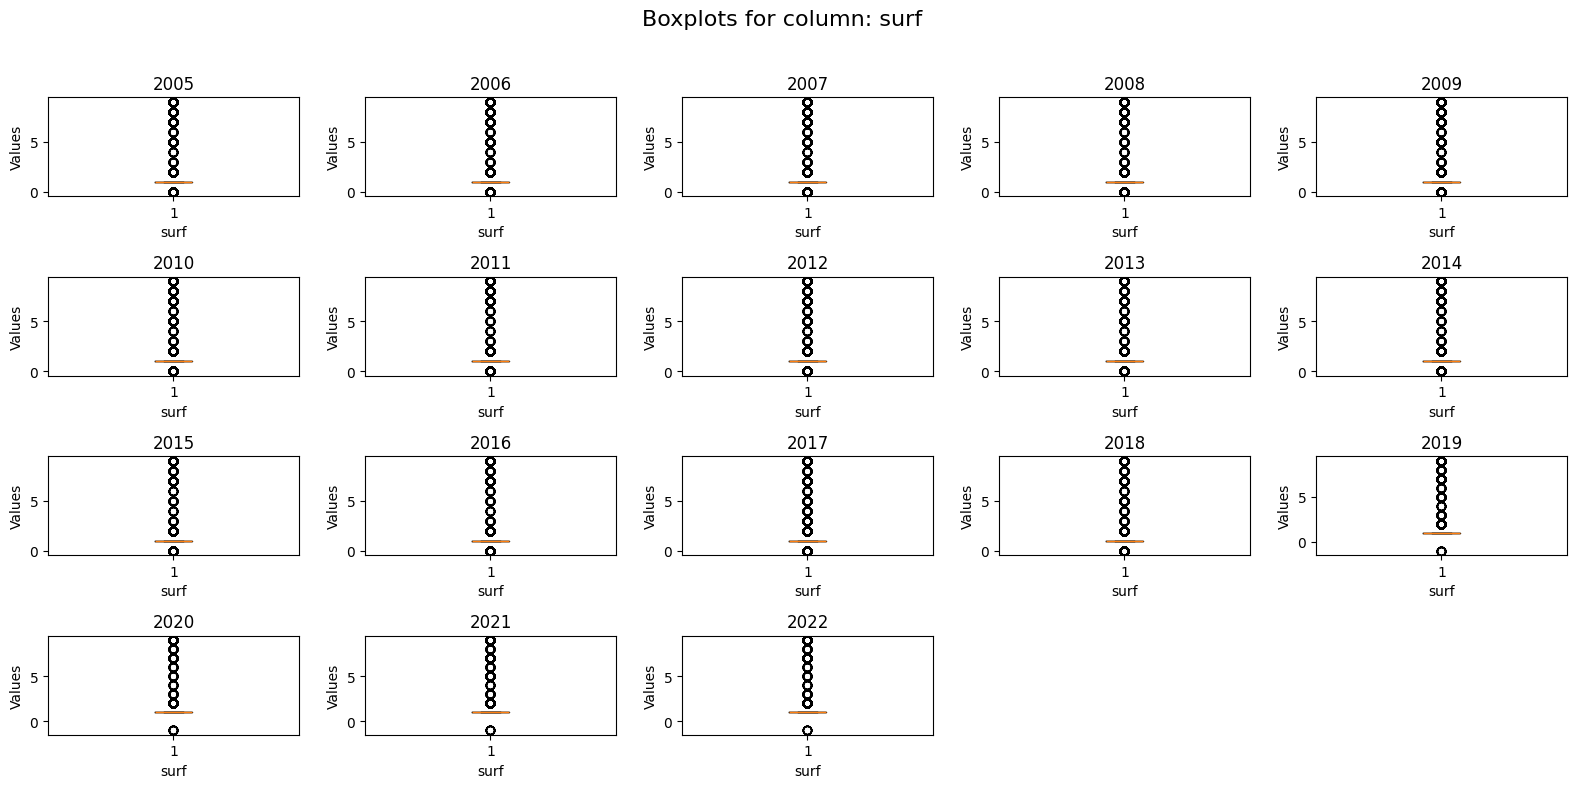

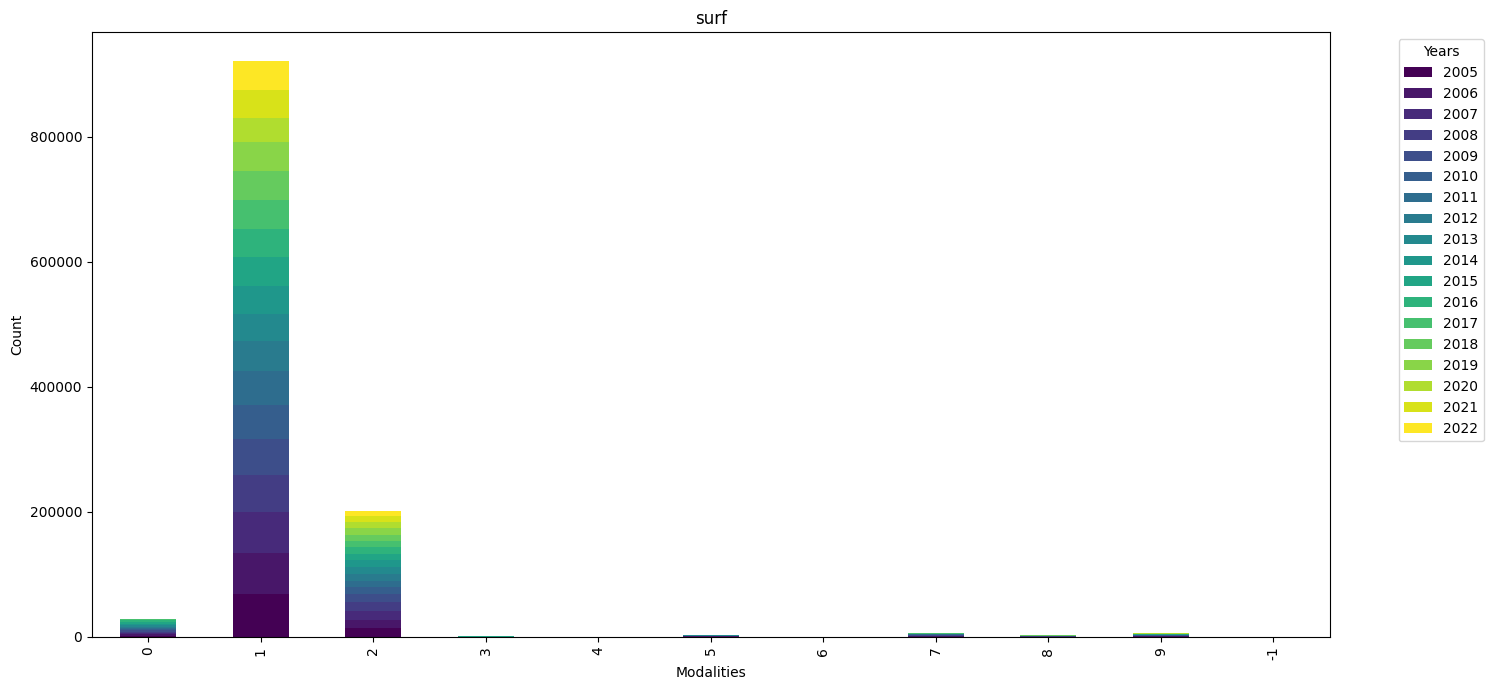

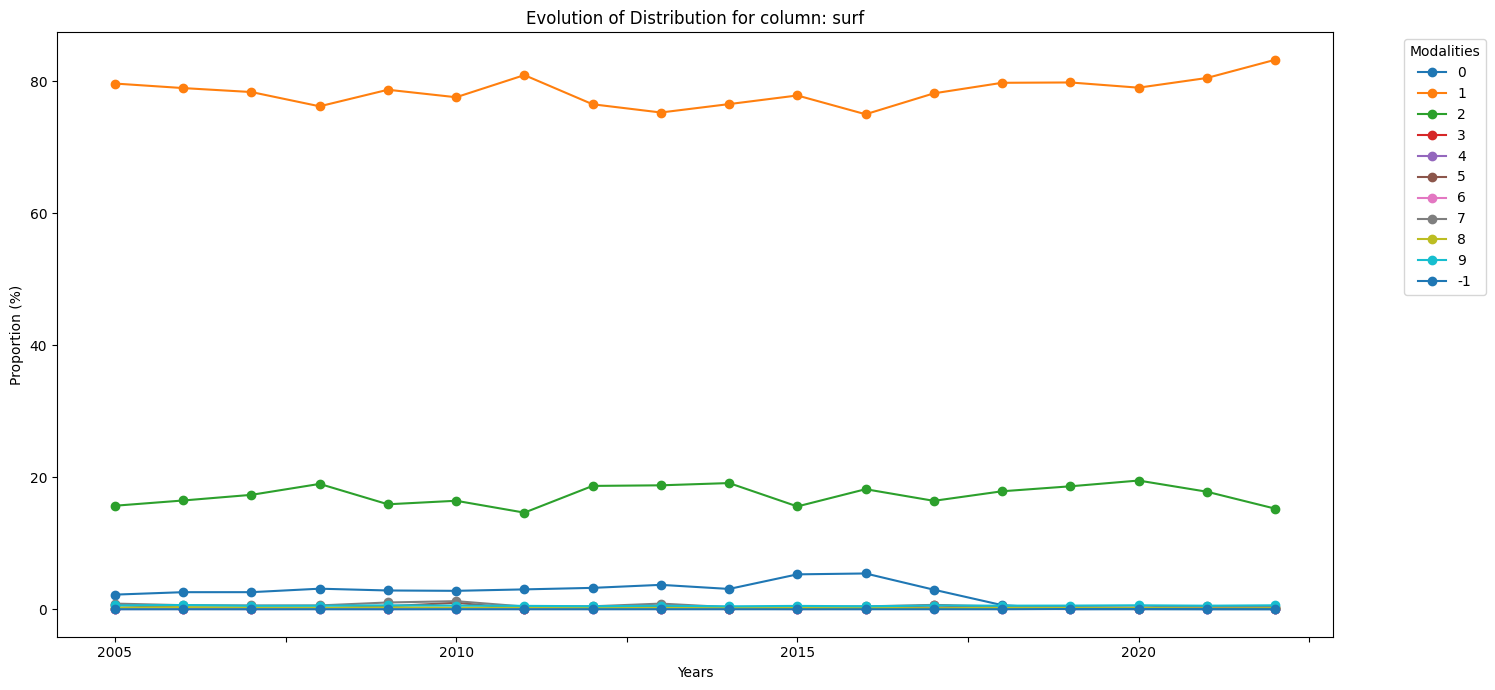


Colonne: pr1 / lignes: 1176873
  Année  Type     Mode      Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  float64  0.0                                   45.4014                            0.0335729
   2006  float64  0.0                                   46.6678                            0.0329101
   2007  float64  0.0                                   53.5015                            0.0381188
   2008  float64  0.0                                   58.8026                            0.0383567
   2009  float64  0.0                                   37.8892                            0.0239559
   2010  float64  0.0                                   40.6809                            0.0239822
   2011  float64  0.0                                   51.4677                            0.0292895
   2012  float64  0.0                                   54.

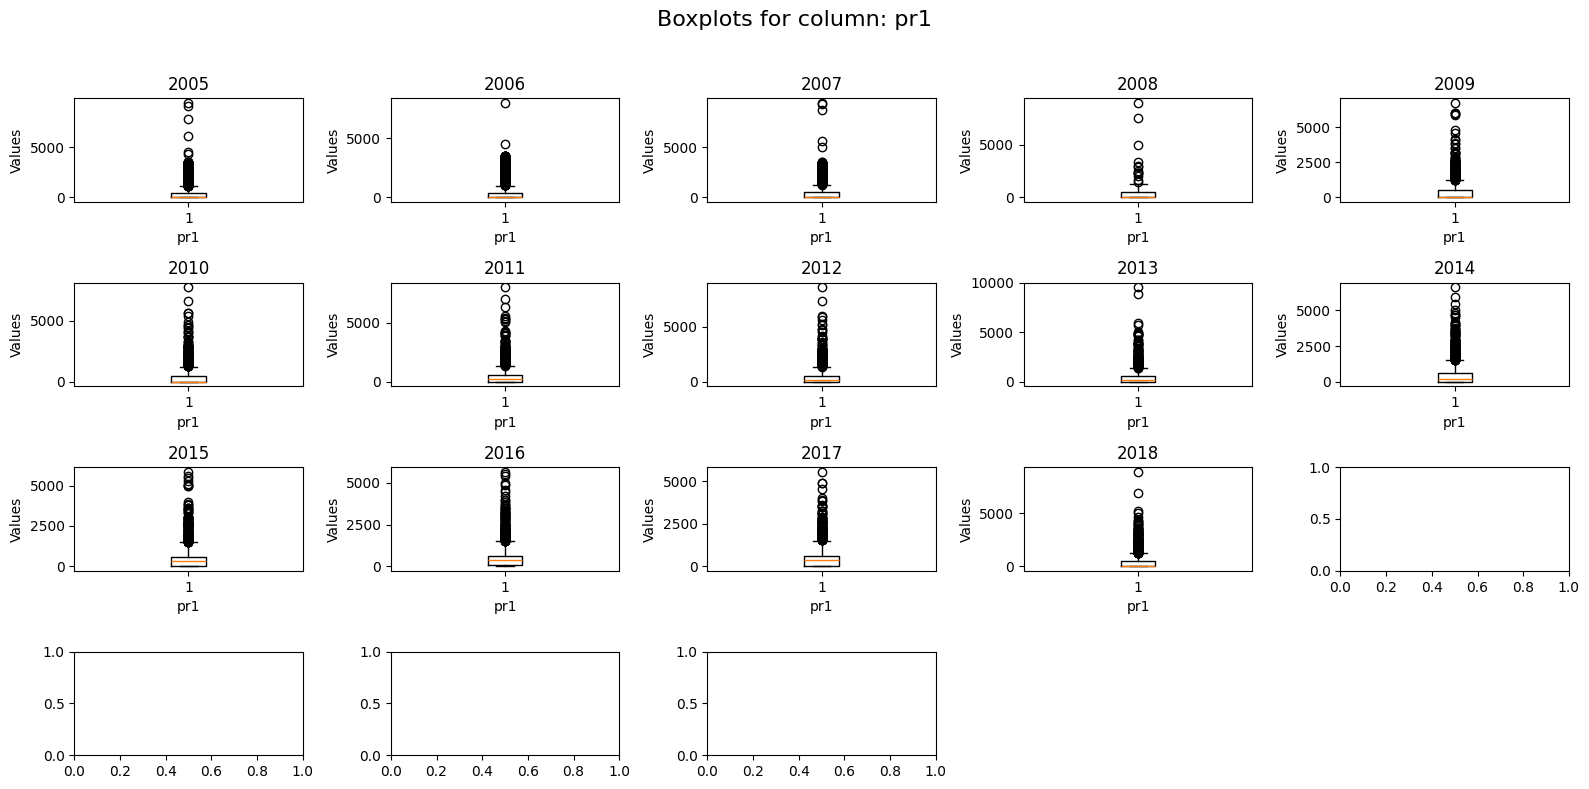

2024-06-10 17:11:27,474 - WARNING - Le nombre de modalités uniques dans la colonne pr1 excède le seuil de 50. Auncun bar plot généré.
2024-06-10 17:11:27,517 - WARNING - Le nombre de modalités uniques dans la colonne pr1 excède le seuil de 12. Aucun graphique en ligne généré.



Colonne: lartpc / lignes: 1176873
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  int64         0                               0                                 0
   2006  int64         0                               0                                 0
   2007  int64         0                               0                                 0
   2008  int64         0                               0                                 0
   2009  float64       0                               0.725719                          0.000458843
   2010  float64       0                               0.671673                          0.000395965
   2011  float64       0                               1.03324                           0.000587999
   2012  float64       0                               1.80402                           0.00095

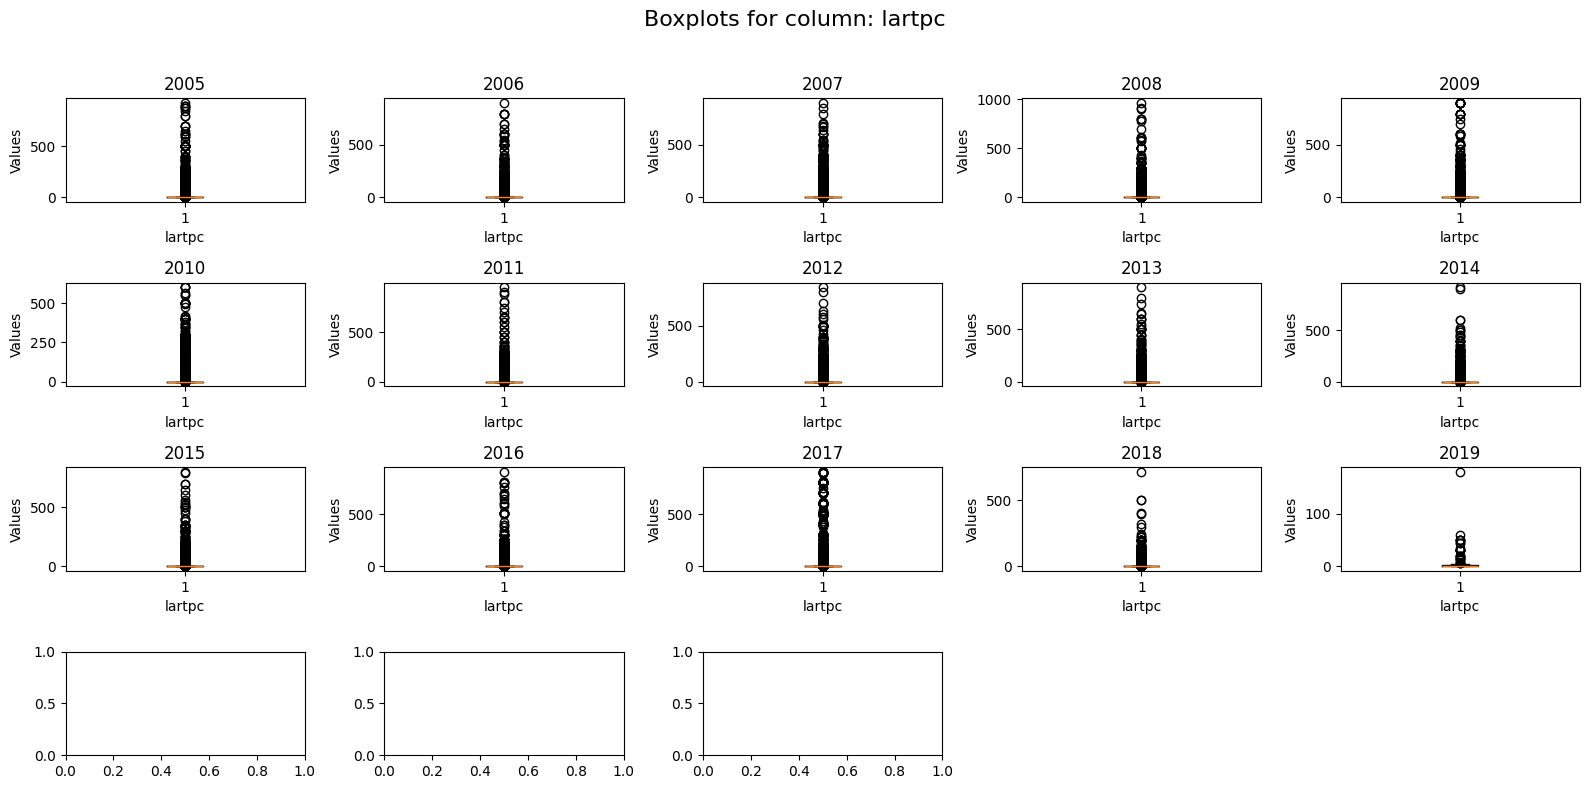

2024-06-10 17:11:29,498 - WARNING - Le nombre de modalités uniques dans la colonne lartpc excède le seuil de 50. Auncun bar plot généré.
2024-06-10 17:11:29,521 - WARNING - Le nombre de modalités uniques dans la colonne lartpc excède le seuil de 12. Aucun graphique en ligne généré.



Colonne: voie / lignes: 1176873
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  float64       0                             8.65144                             0.00639746
   2006  float64       0                             9.57671                             0.00675349
   2007  float64       0                             3.99165                             0.00284398
   2008  float64       0                             0.00651322                          4.24855e-06
   2009  float64       0                             1.98632                             0.00125587
   2010  float64       0                             2.23266                             0.0013162
   2011  float64       0                             7.15352                             0.00407096
   2012  float64       0                            11.2948      

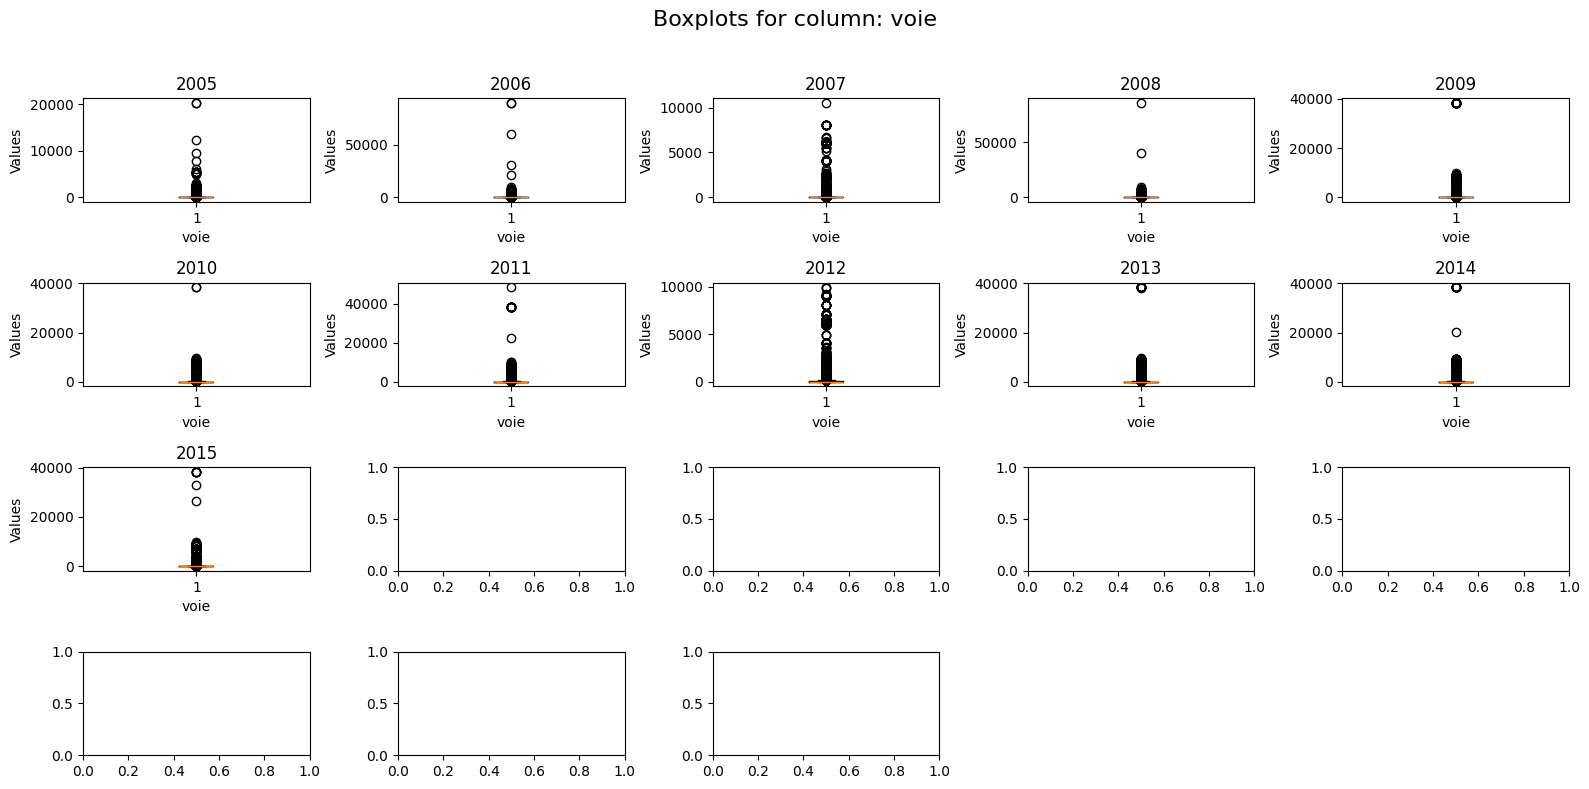

2024-06-10 17:11:31,603 - WARNING - Le nombre de modalités uniques dans la colonne voie excède le seuil de 50. Auncun bar plot généré.
2024-06-10 17:11:31,672 - WARNING - Le nombre de modalités uniques dans la colonne voie excède le seuil de 12. Aucun graphique en ligne généré.



Colonne: plan / lignes: 1176873
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  int64         1                              0                                  0
   2006  int64         1                              0                                  0
   2007  int64         1                              0                                  0
   2008  int64         1                              0                                  0
   2009  float64       1                              0.100794                           6.37282e-05
   2010  float64       1                              0.0619784                          3.65375e-05
   2011  float64       1                              0.191119                           0.000108763
   2012  float64       1                              0.438554                           0.0002319

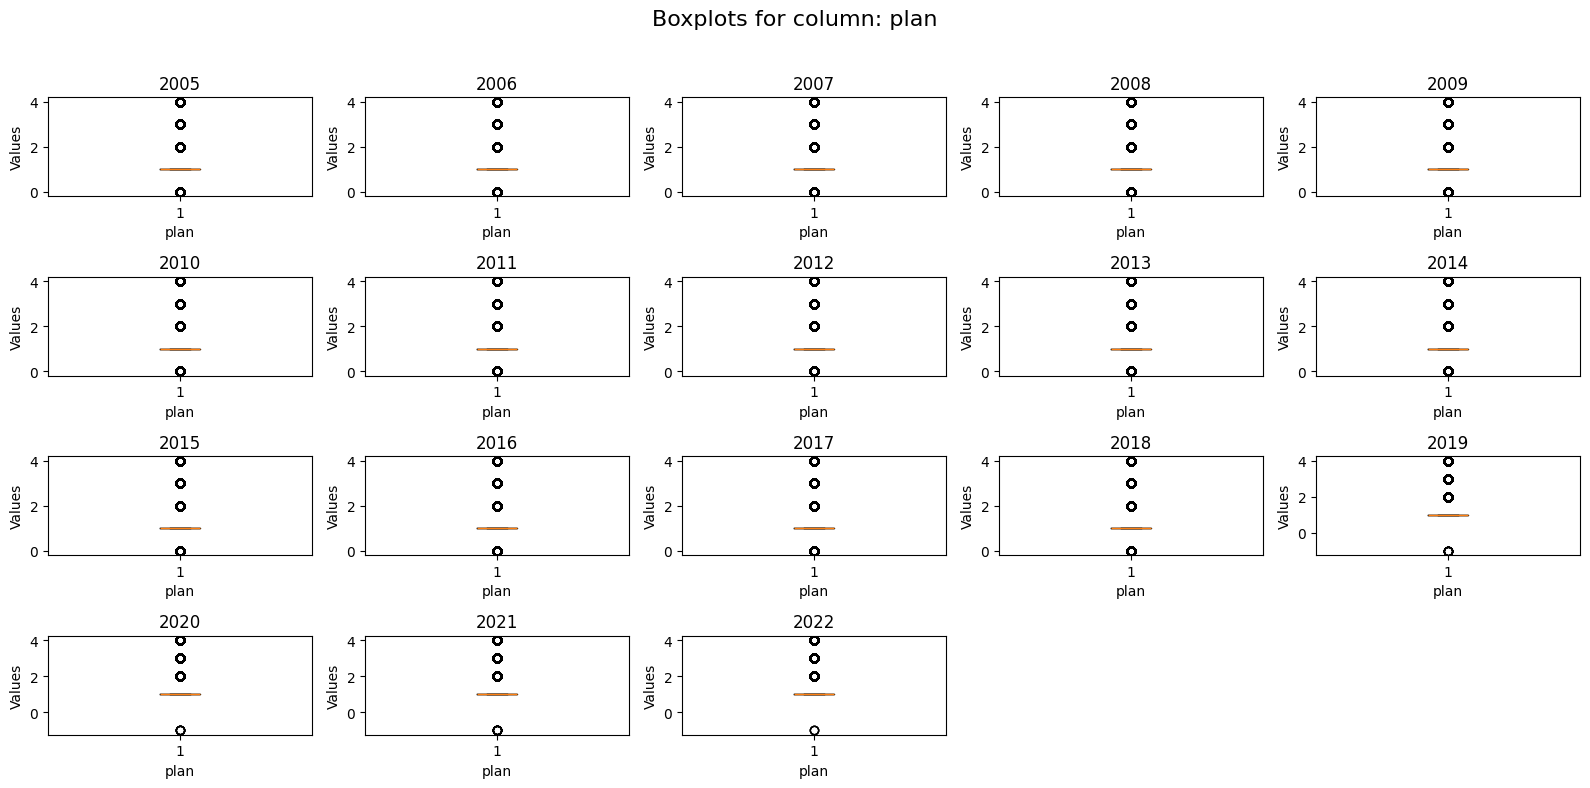

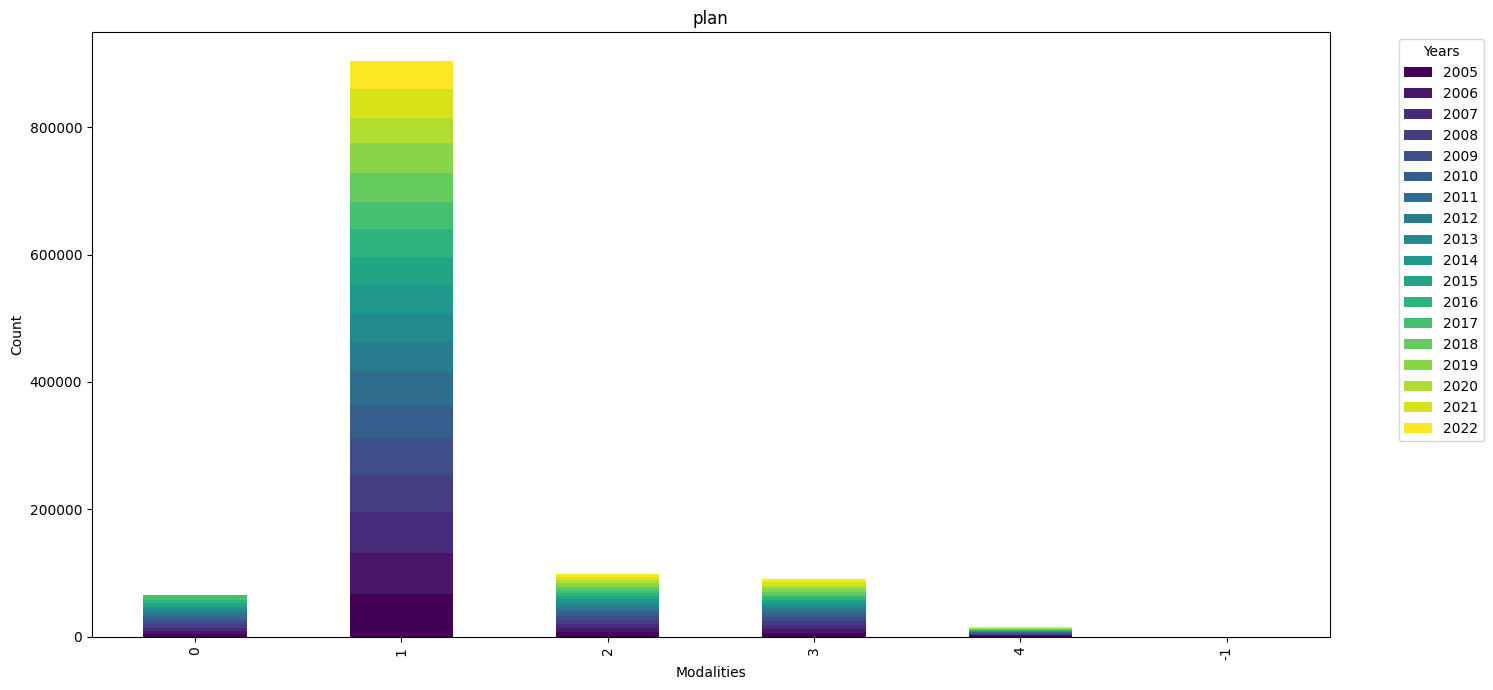

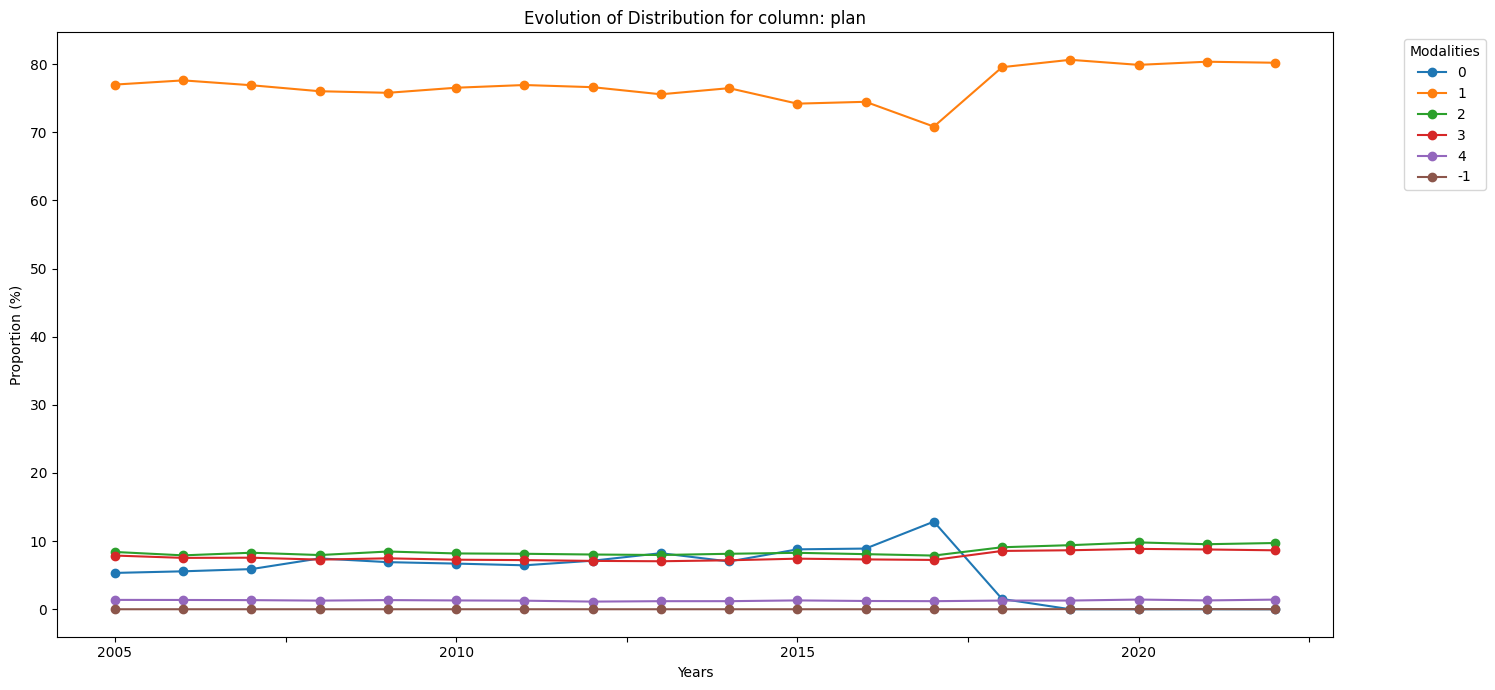


Colonne: vosp / lignes: 1176873
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  int64         0                               0                                 0
   2006  int64         0                               0                                 0
   2007  int64         0                               0                                 0
   2008  int64         0                               0                                 0
   2009  float64       0                               0.346732                          0.000219225
   2010  float64       0                               0.159991                          9.43177e-05
   2011  float64       0                               0.274733                          0.000156347
   2012  float64       0                               0.514056                          0.0002719

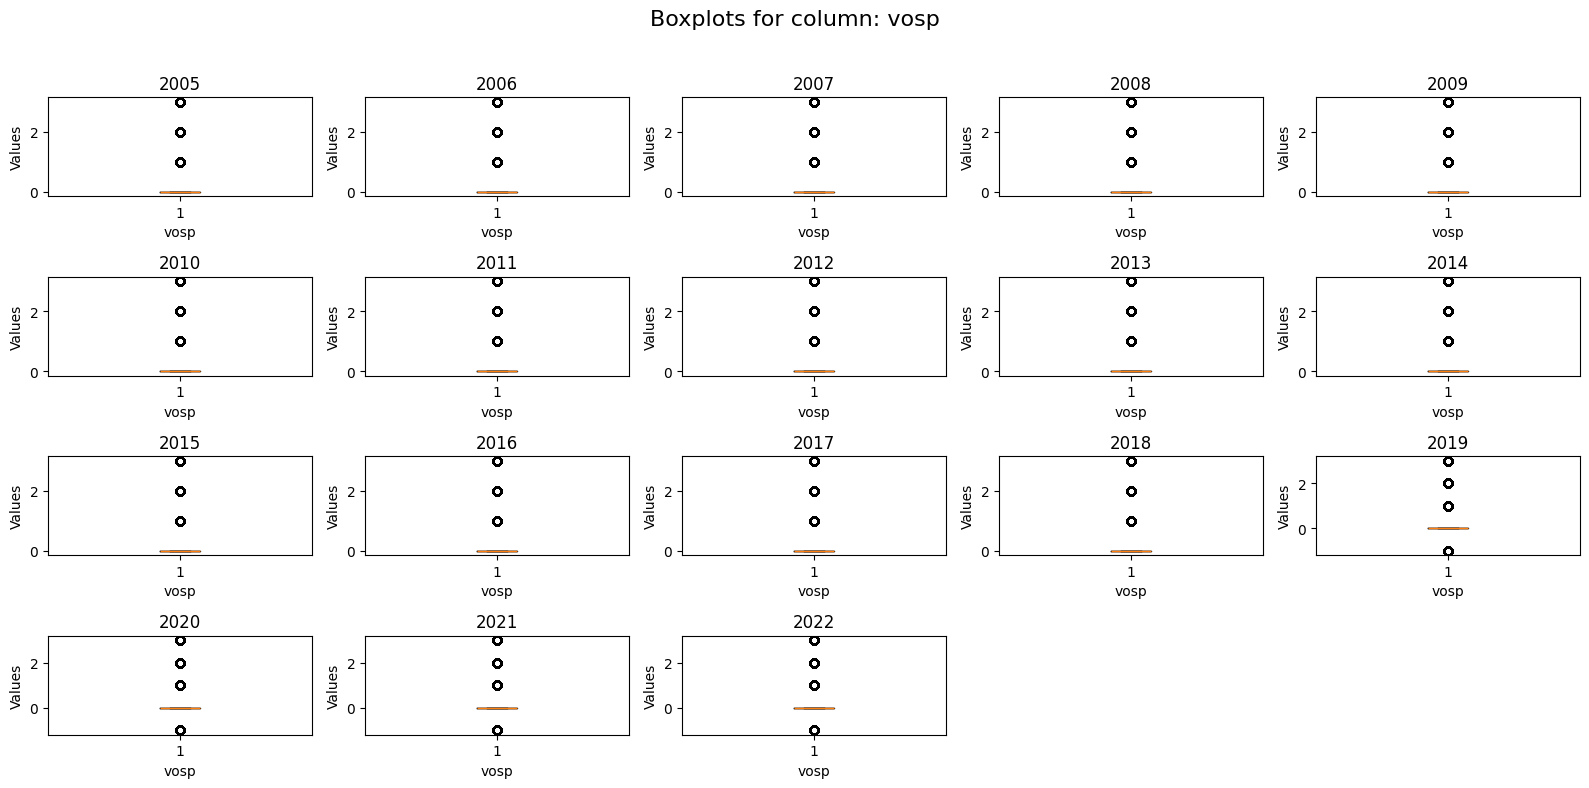

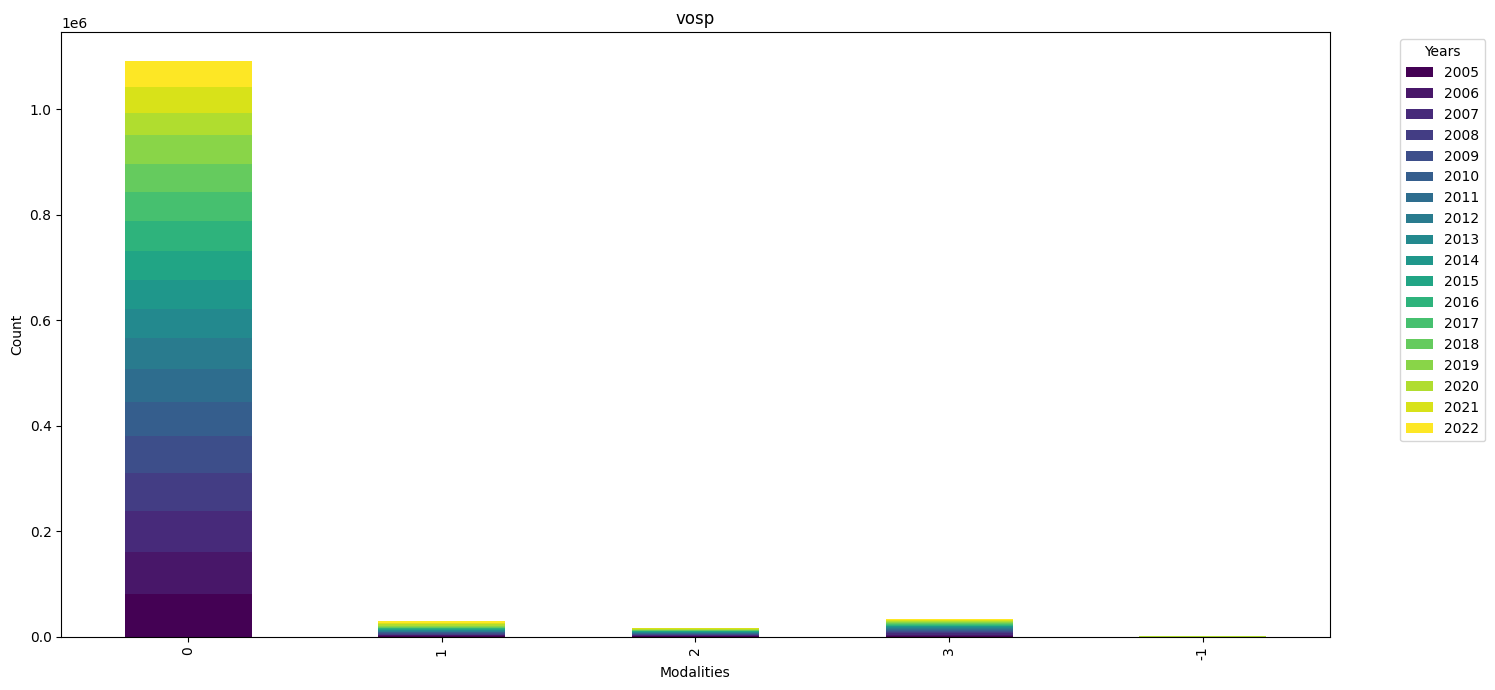

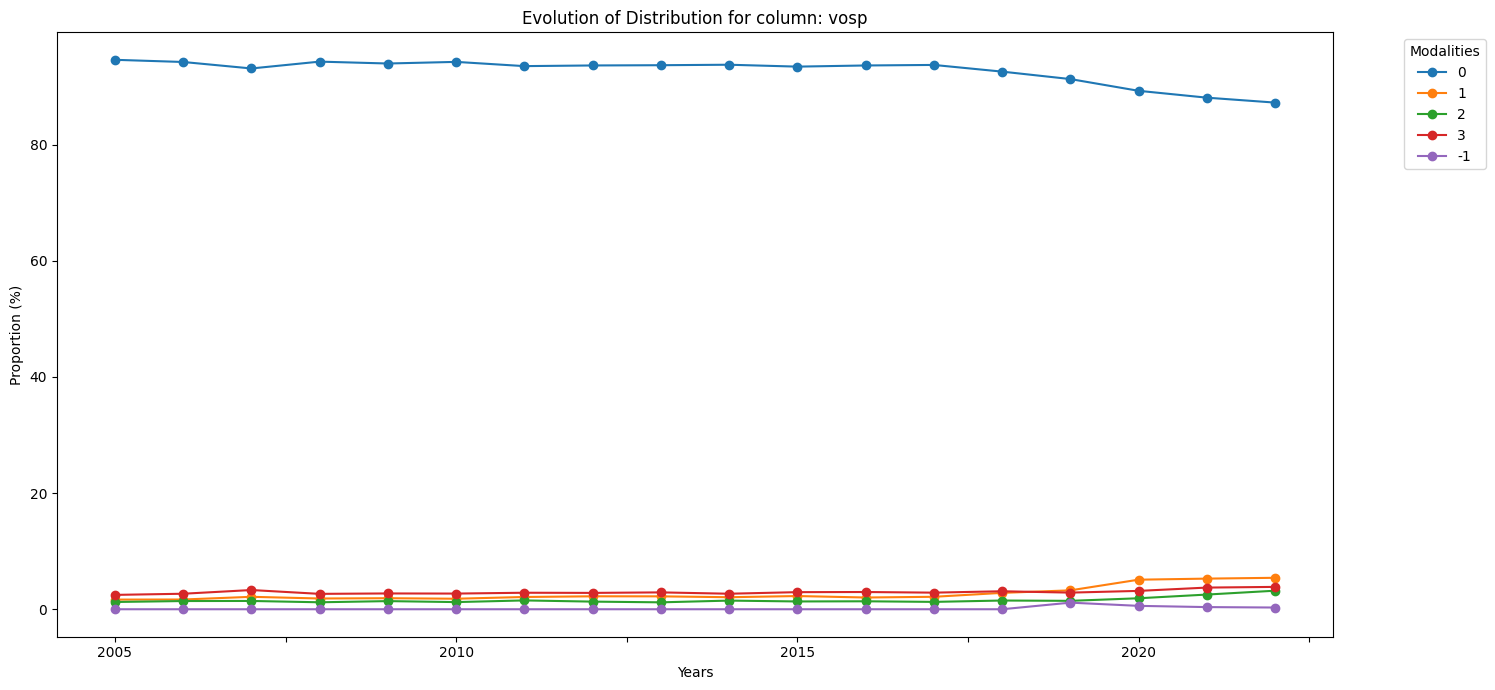

2024-06-10 17:11:37,266 - INFO - Chargement de data/raw\usagers_2005.csv.
2024-06-10 17:11:37,266 - INFO - Chargement de data/raw\usagers_2006.csv.
2024-06-10 17:11:37,267 - INFO - Chargement de data/raw\usagers_2007.csv.
2024-06-10 17:11:37,267 - INFO - Chargement de data/raw\usagers_2008.csv.
2024-06-10 17:11:37,268 - INFO - Chargement de data/raw\usagers_2009.csv.
2024-06-10 17:11:37,268 - INFO - Chargement de data/raw\usagers_2010.csv.
2024-06-10 17:11:37,269 - INFO - Chargement de data/raw\usagers_2011.csv.
2024-06-10 17:11:37,269 - INFO - Chargement de data/raw\usagers_2012.csv.
2024-06-10 17:11:37,270 - INFO - Chargement de data/raw\usagers_2013.csv.
2024-06-10 17:11:37,270 - INFO - Chargement de data/raw\usagers_2014.csv.
2024-06-10 17:11:37,271 - INFO - Chargement de data/raw\usagers_2015.csv.
2024-06-10 17:11:37,271 - INFO - Chargement de data/raw\usagers_2016.csv.
2024-06-10 17:11:37,272 - INFO - Chargement de data/raw\usagers-2017.csv.
2024-06-10 17:11:37,273 - INFO - Charg


Colonne: place / lignes: 2636377
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  int64         1                                0                                 0
   2006  int64         1                                0                                 0
   2007  int64         1                                0                                 0
   2008  int64         1                                0                                 0
   2009  float64       1                                8.21393                           0.00517073
   2010  float64       1                                8.58151                           0.00501901
   2011  float64       1                                8.81024                           0.00496401
   2012  float64       1                                8.92172                           0.0

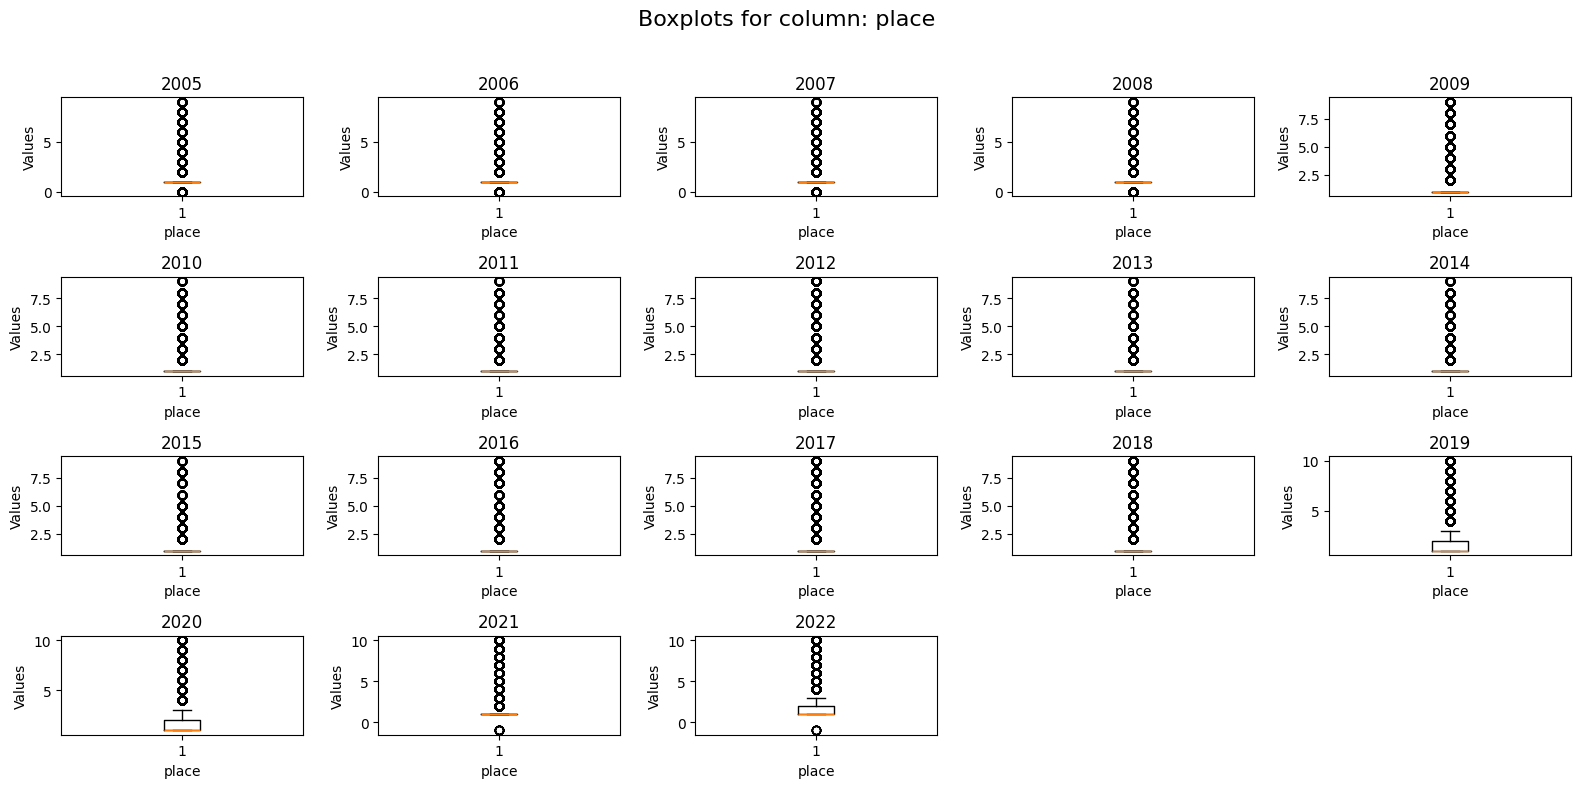

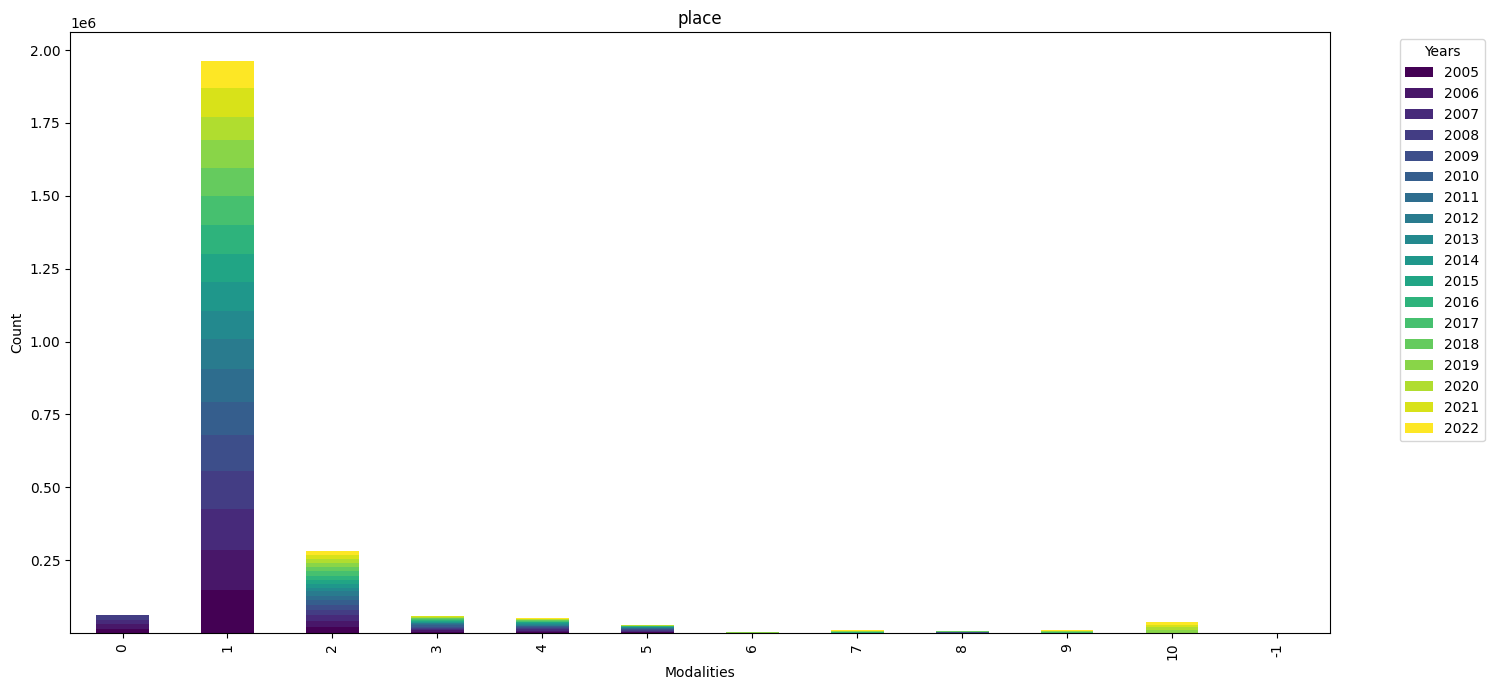

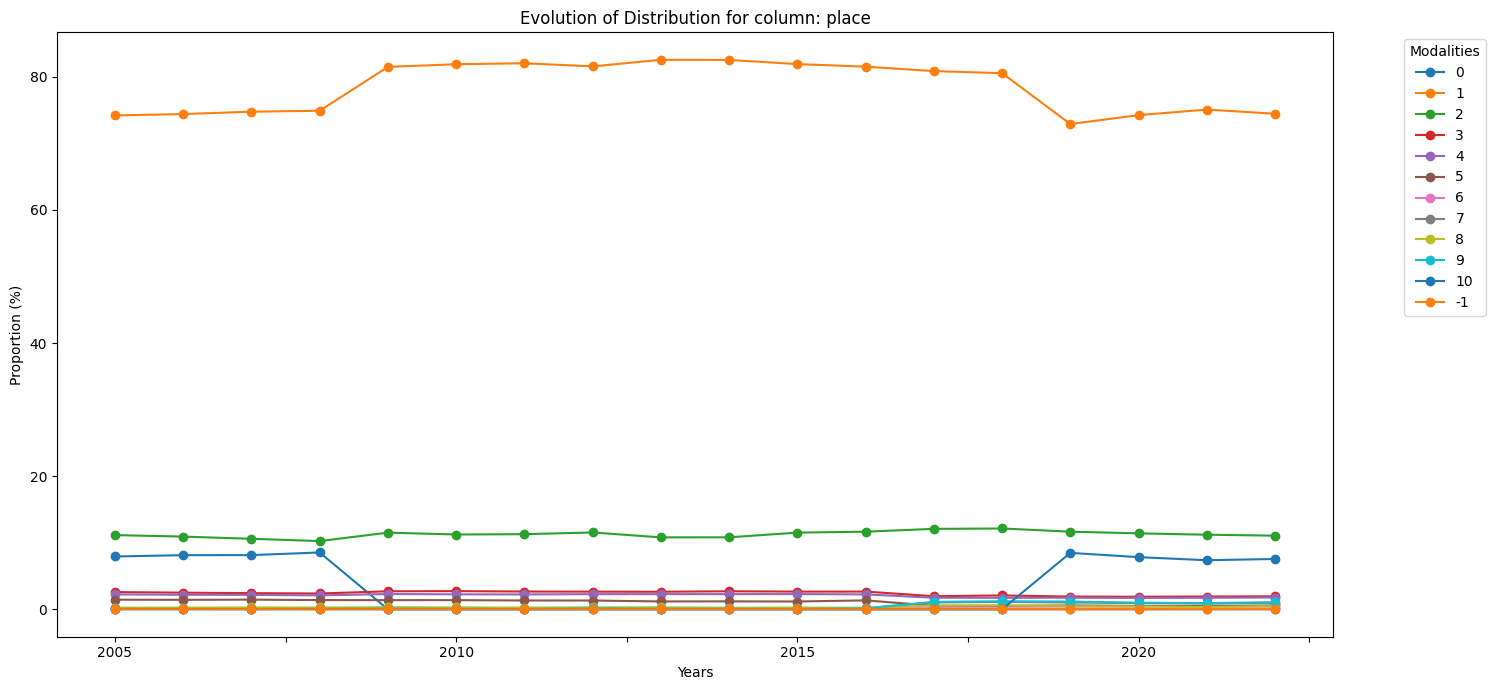


Colonne: secu2 / lignes: 2636377
  Année  Type      Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  ------  -------------------------------------  -----------------------------------
   2019  int64        0                                      0                                    0
   2020  int64        0                                      0                                    0
   2021  int64       -1                                      0                                    0
   2022  int64       -1                                      0                                    0


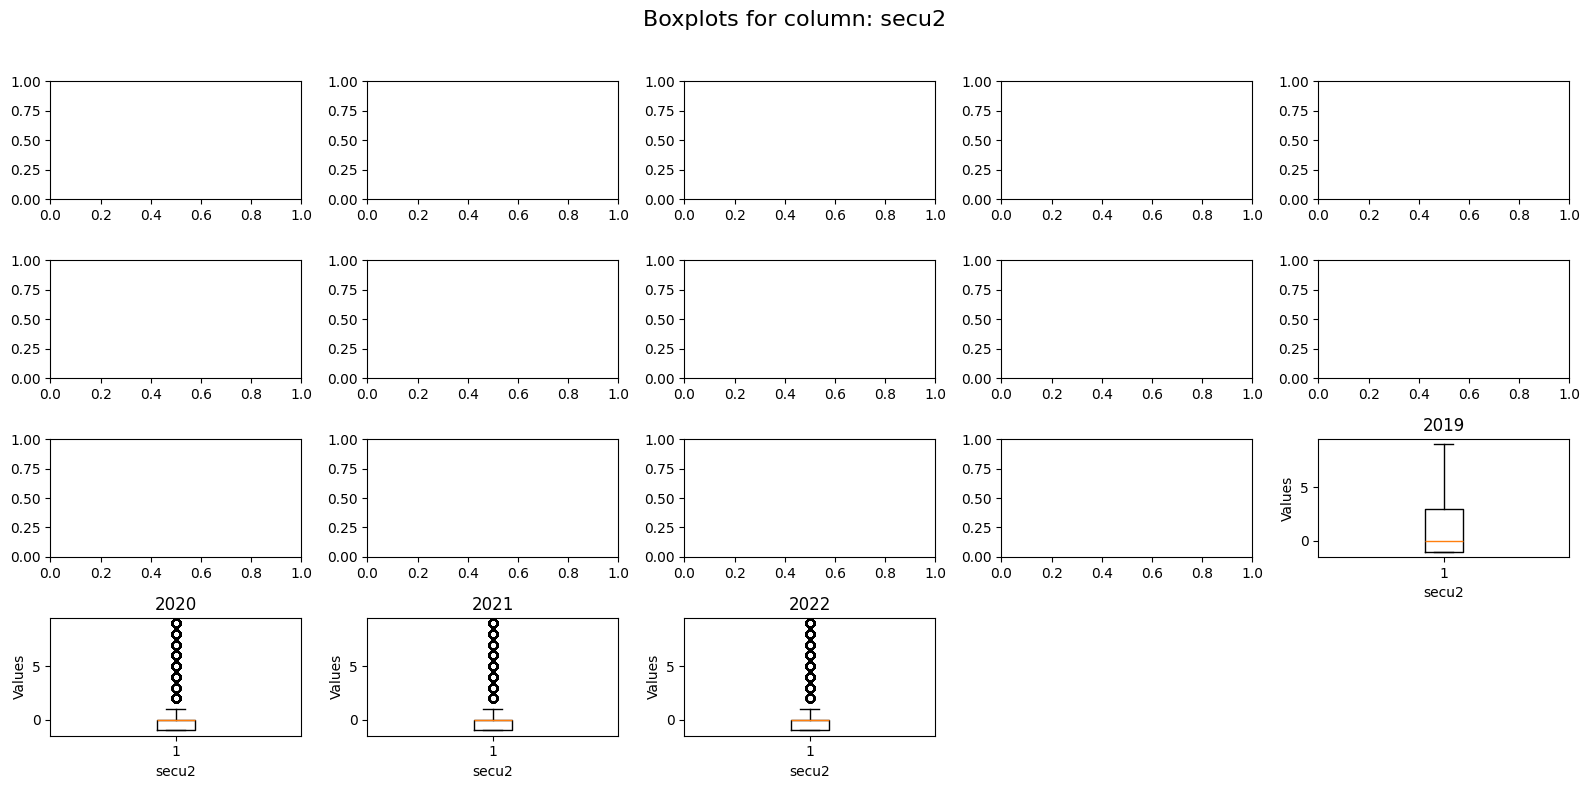

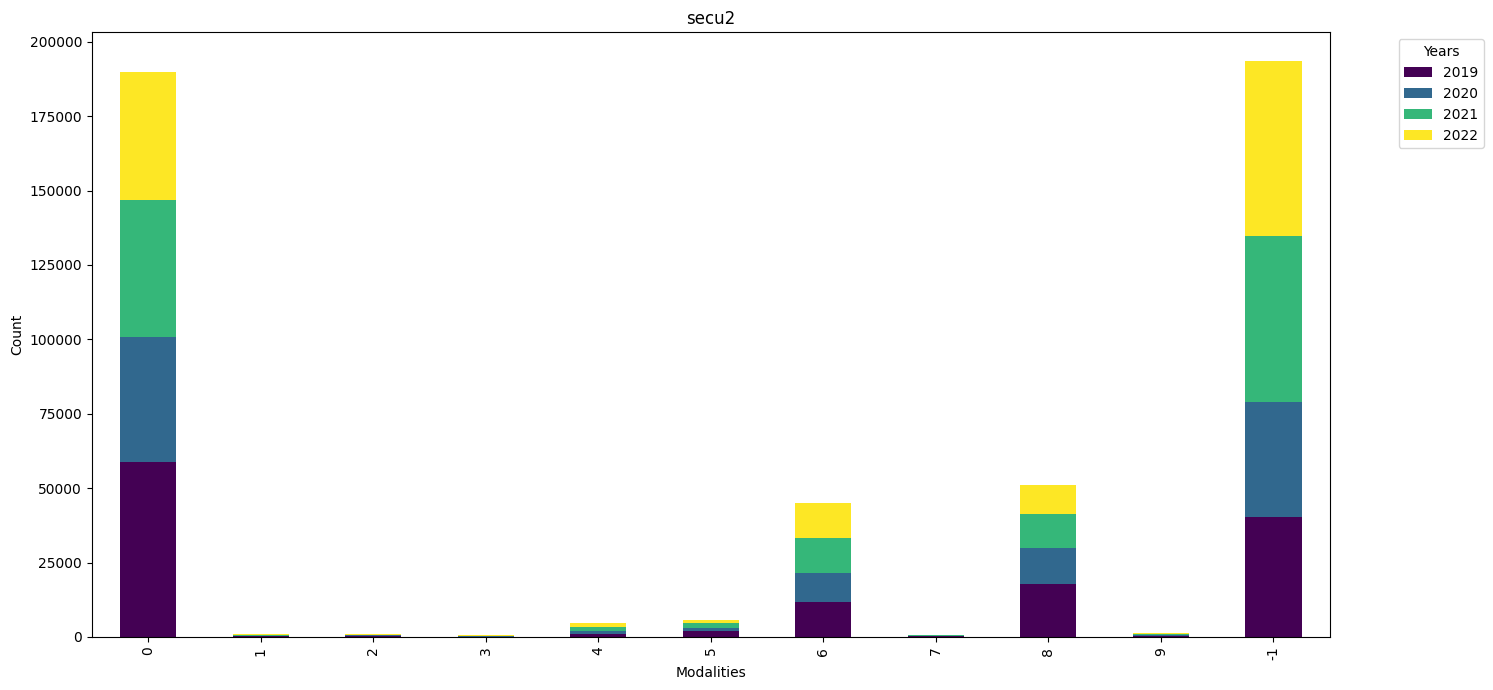

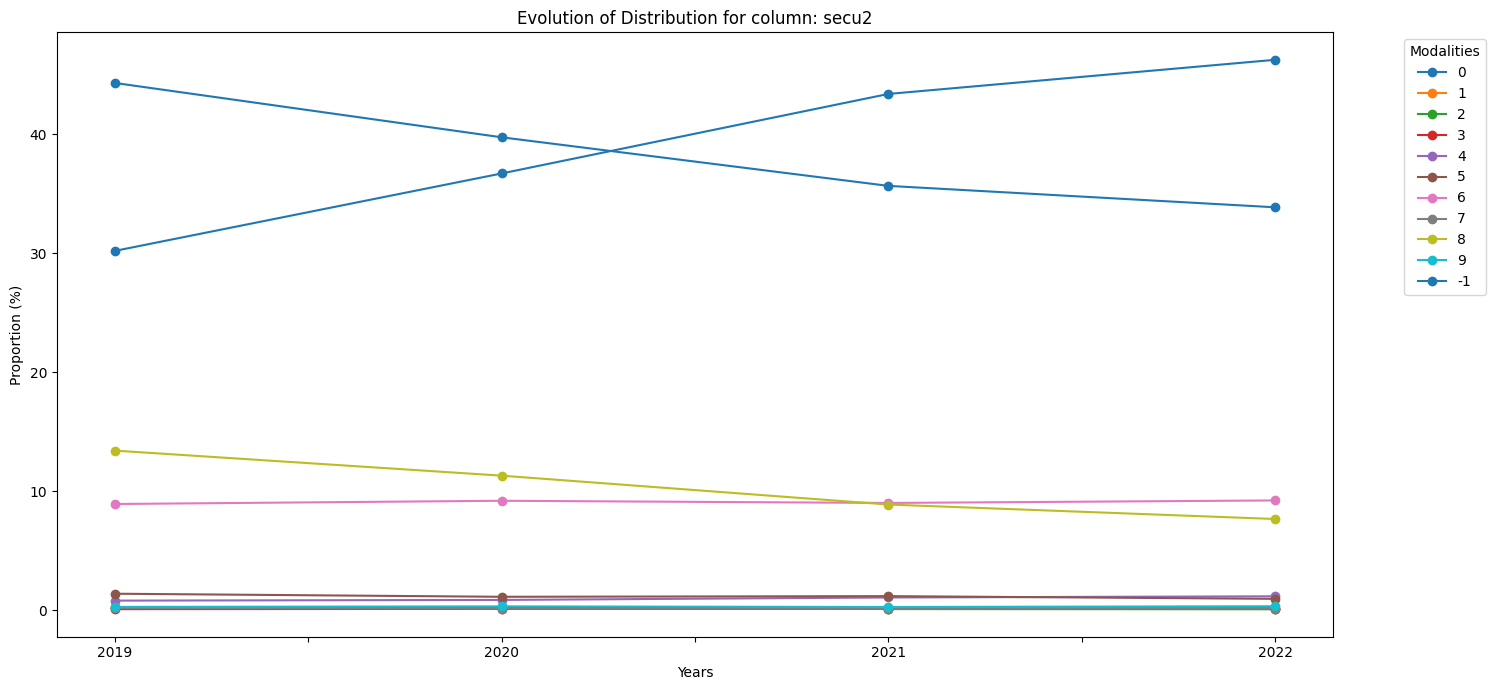


Colonne: grav / lignes: 2636377
  Année  Type      Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  ------  -------------------------------------  -----------------------------------
   2005  int64        1                                      0                                    0
   2006  int64        1                                      0                                    0
   2007  int64        1                                      0                                    0
   2008  int64        1                                      0                                    0
   2009  int64        1                                      0                                    0
   2010  int64        1                                      0                                    0
   2011  int64        1                                      0                                    0
   2012  int64        1                                      0     

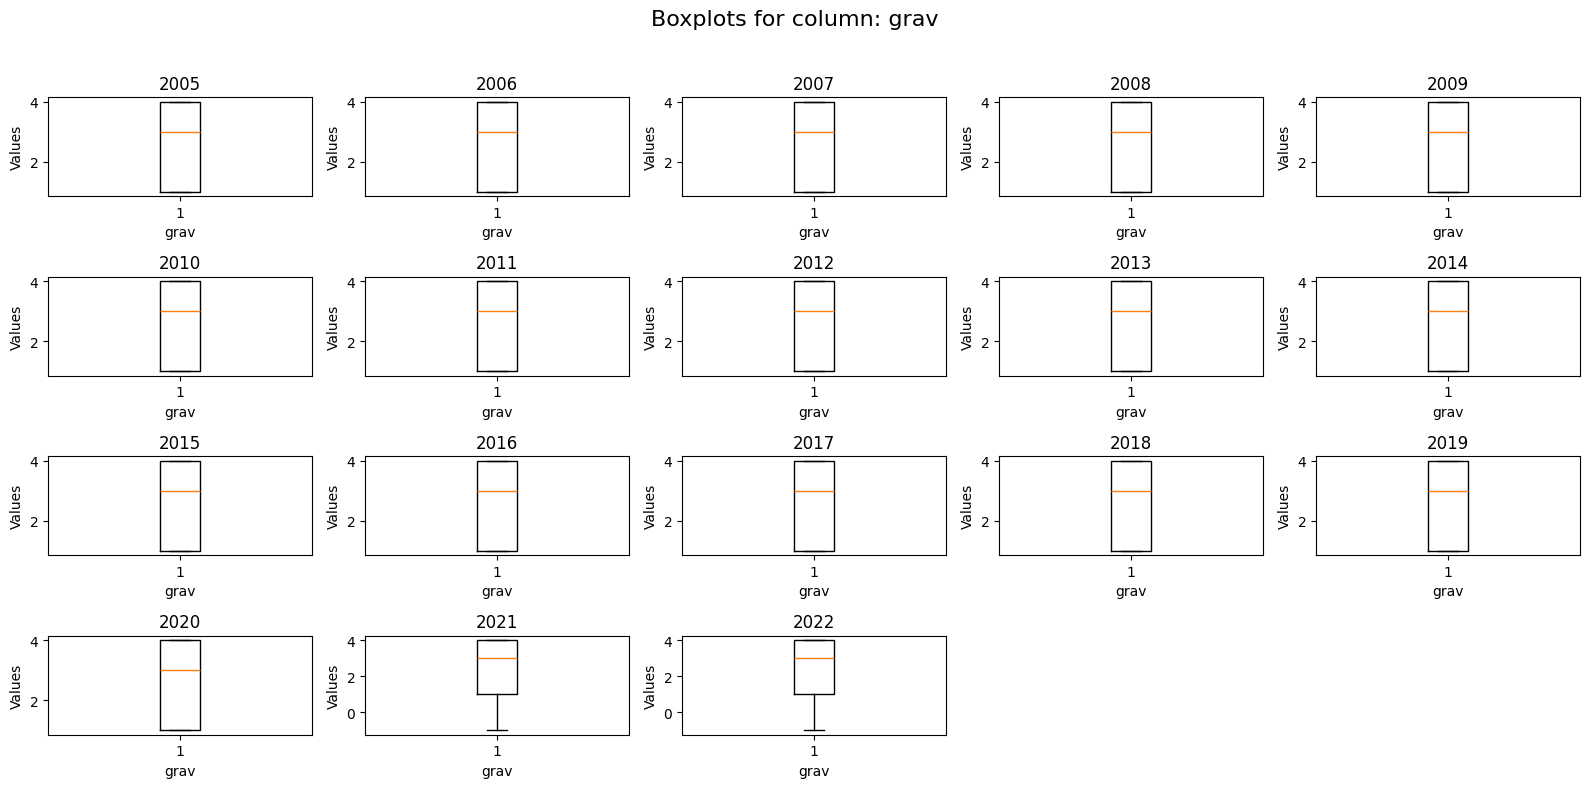

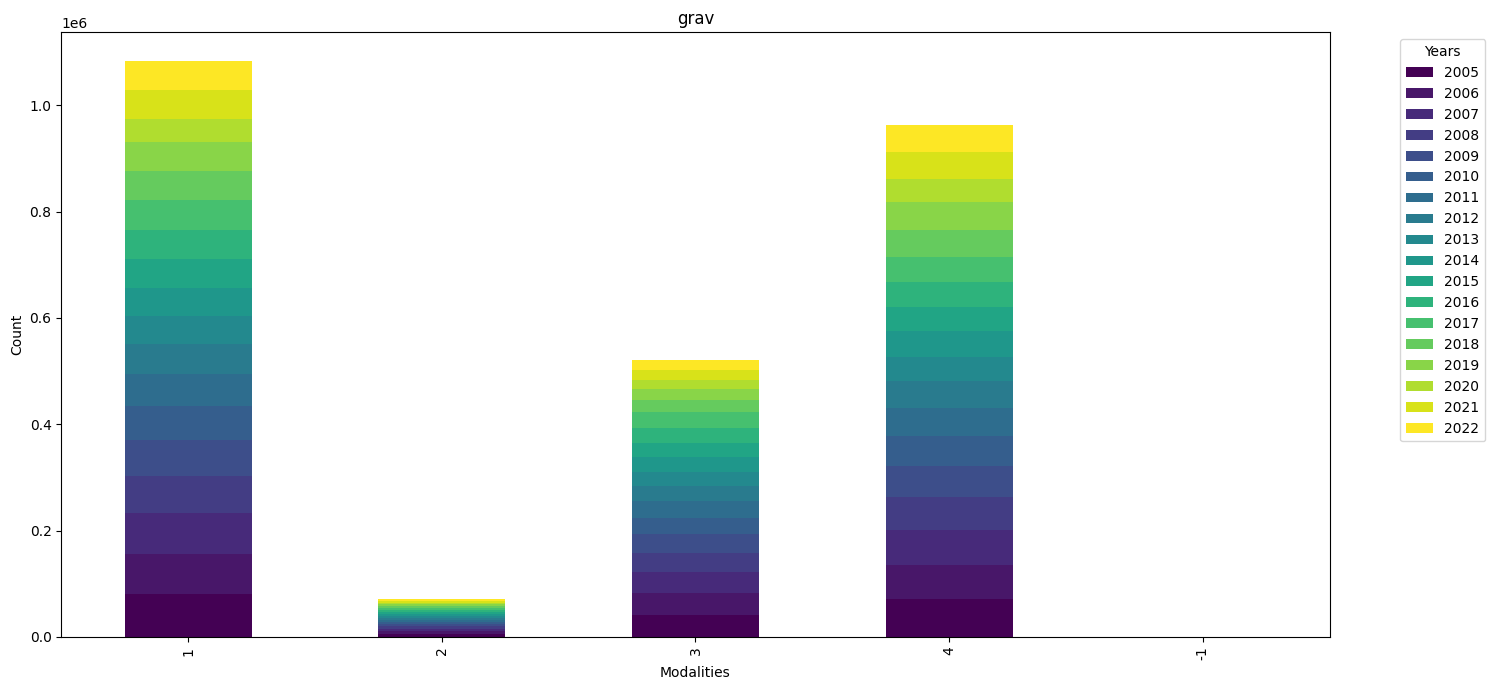

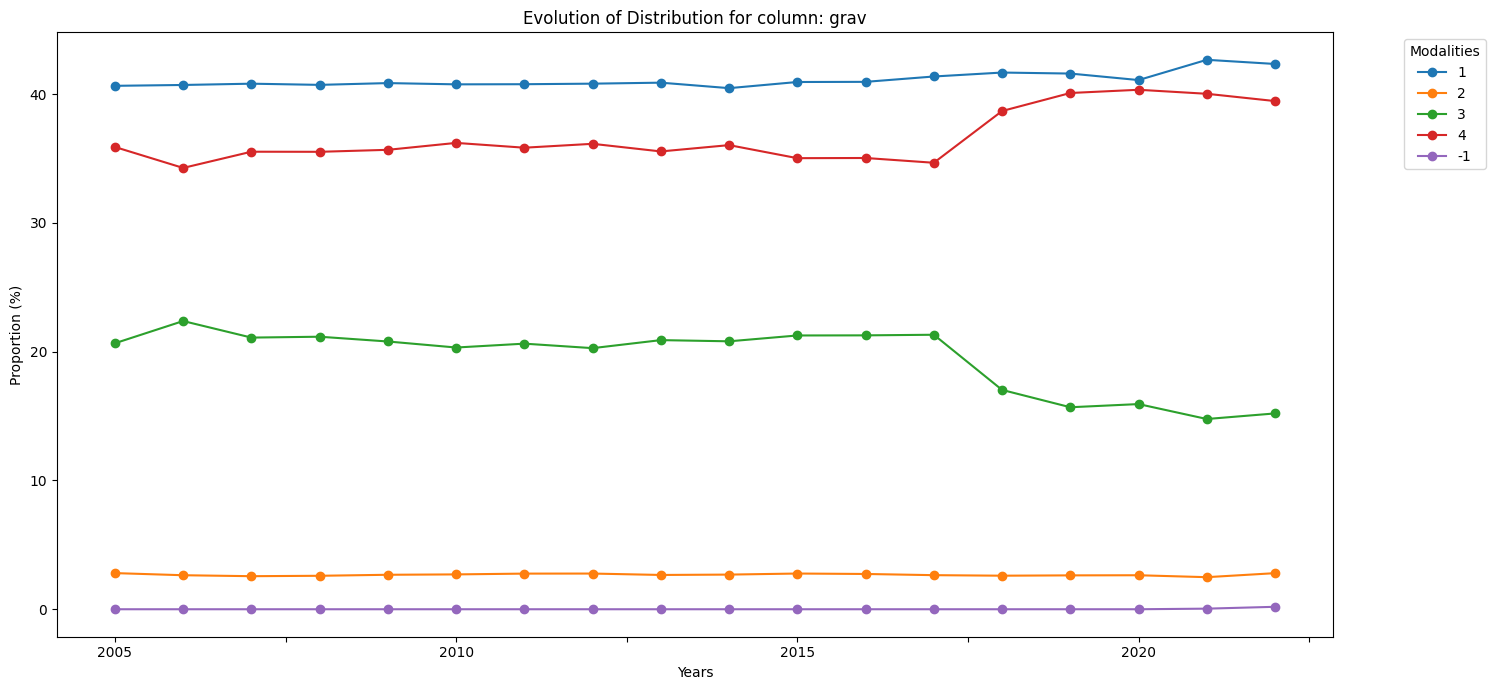


Colonne: secu3 / lignes: 2636377
  Année  Type      Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  ------  -------------------------------------  -----------------------------------
   2019  int64       -1                                      0                                    0
   2020  int64       -1                                      0                                    0
   2021  int64       -1                                      0                                    0
   2022  int64       -1                                      0                                    0


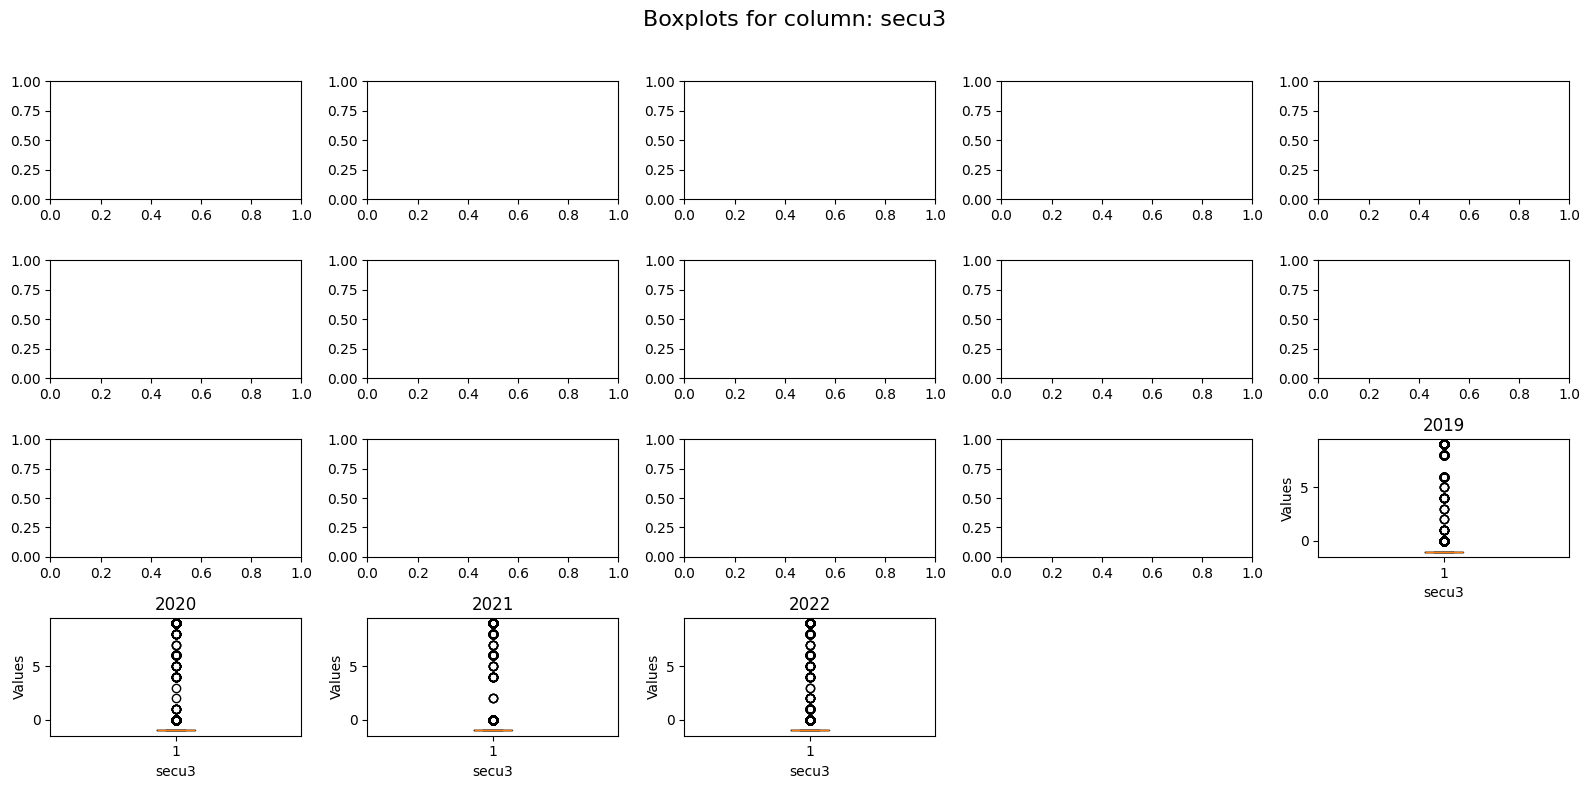

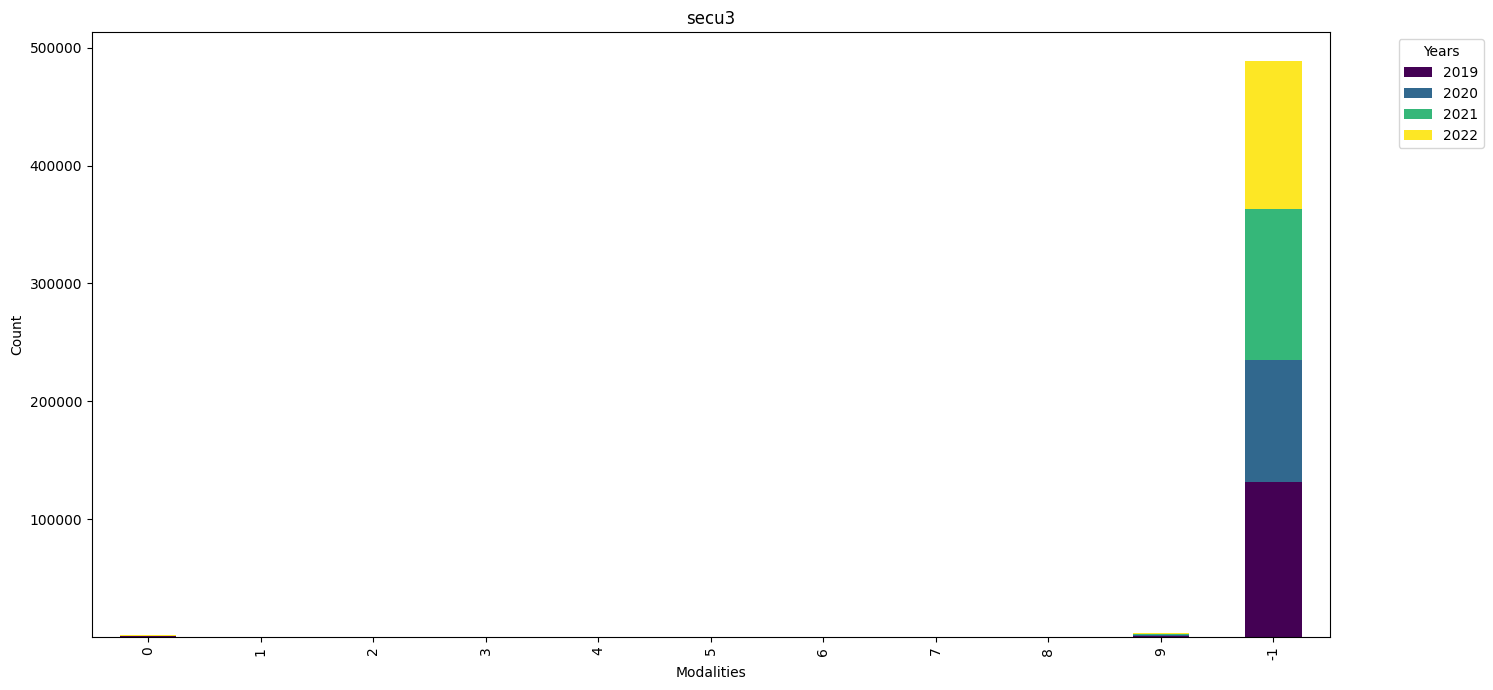

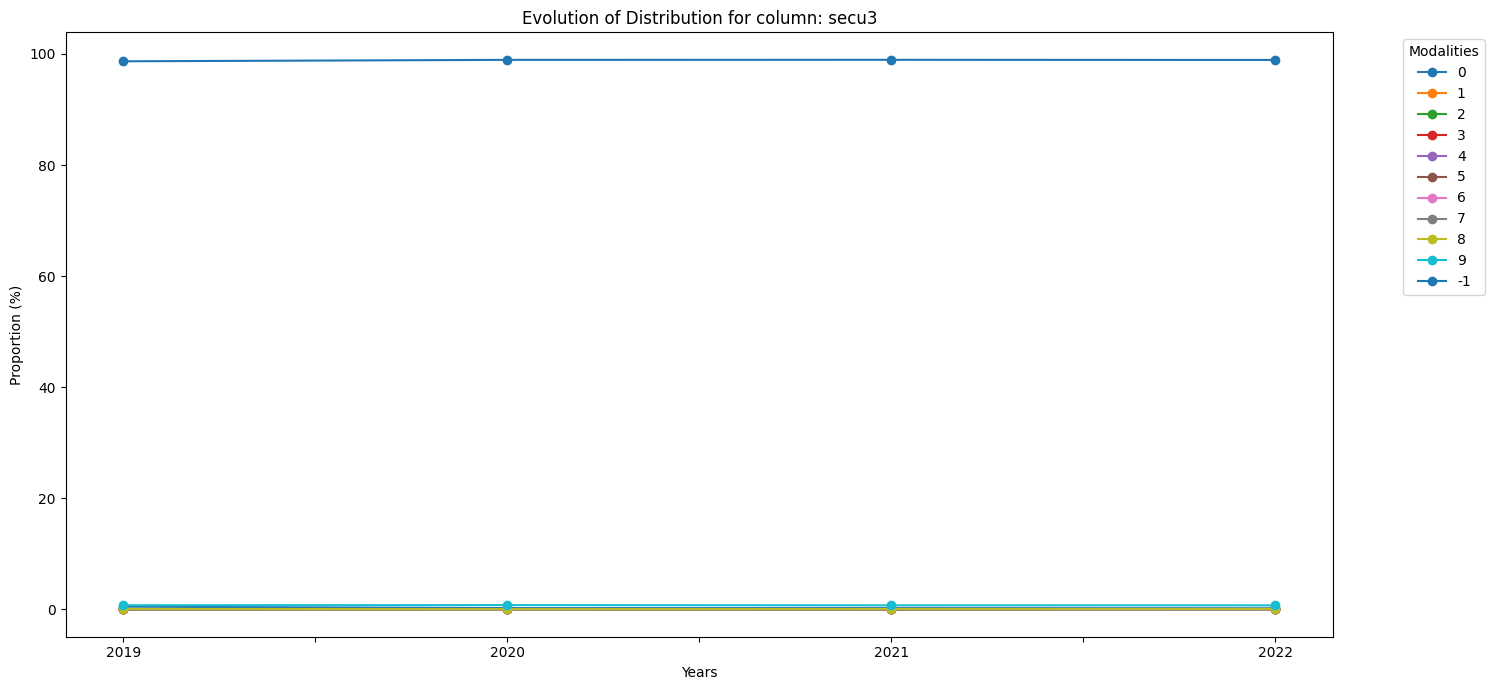


Colonne: an_nais / lignes: 2636377
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  float64    1985                             0.347852                            0.000260585
   2006  float64    1986                             0.559639                            0.000397136
   2007  float64    1987                             0.163963                            0.000117206
   2008  float64    1989                             0.0298315                           1.93447e-05
   2009  float64    1988                             0.00843567                          5.31032e-06
   2010  float64    1989                             0.0343727                           2.01033e-05
   2011  float64    1990                             0.0444316                           2.50344e-05
   2012  float64    1990                             0.

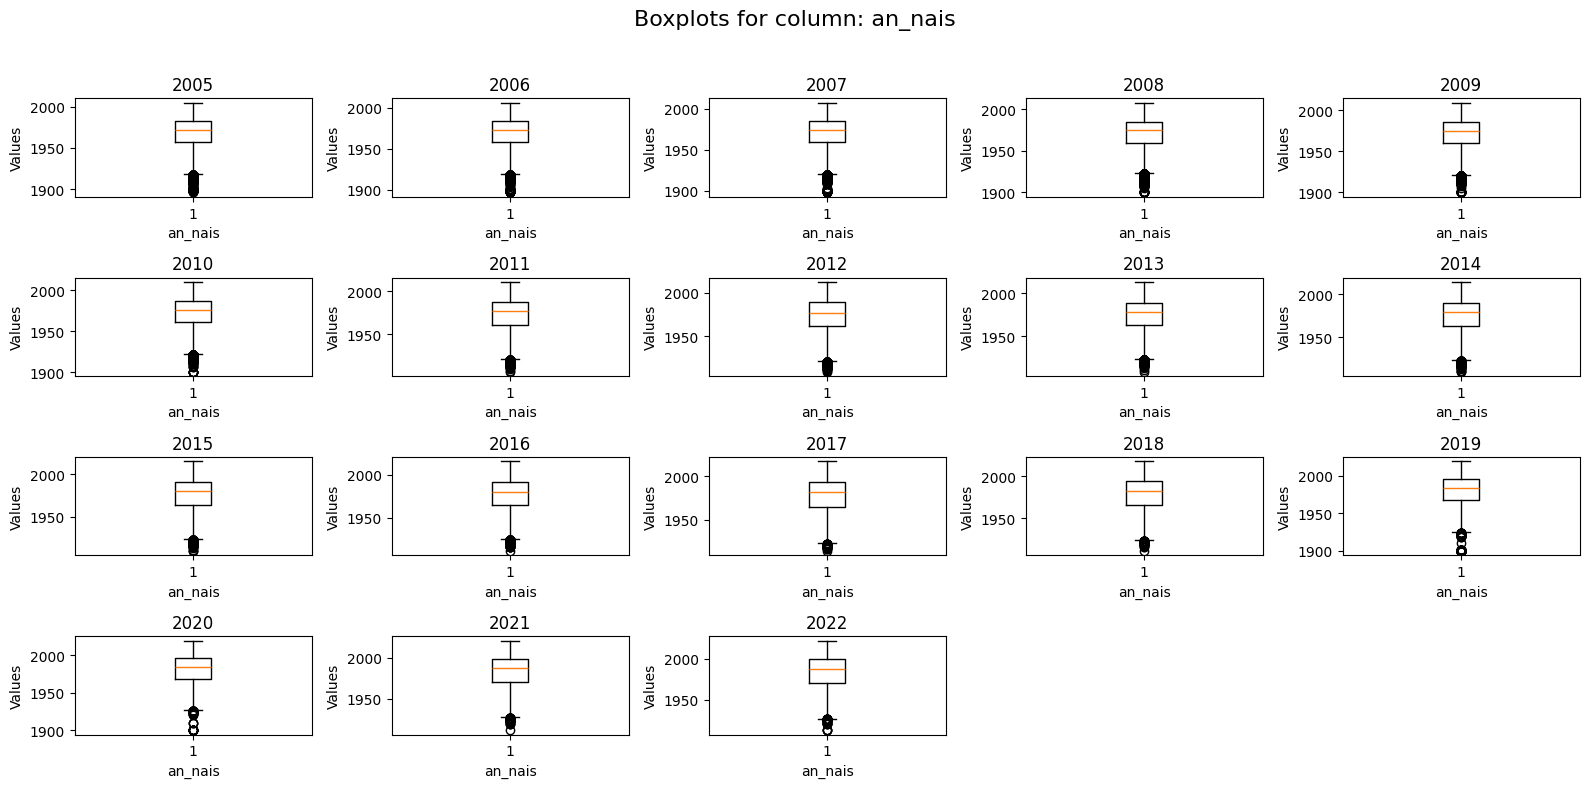

2024-06-10 17:11:50,562 - WARNING - Le nombre de modalités uniques dans la colonne an_nais excède le seuil de 50. Auncun bar plot généré.
2024-06-10 17:11:50,608 - WARNING - Le nombre de modalités uniques dans la colonne an_nais excède le seuil de 12. Aucun graphique en ligne généré.


2024-06-10 17:11:51,090 - INFO - La colonne id_vehicule n'est pas numérique.



Colonne: id_vehicule / lignes: 2636377
  Année  Type    Mode           Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  -----------  -------------------------------------  -----------------------------------
   2019  object  138 212 691                                      0                                    0
   2020  object  154 730 652                                      0                                    0
   2021  object  172 295                                          0                                    0
   2022  object  755 536                                          0                                    0


2024-06-10 17:11:51,362 - WARNING - Le nombre de modalités uniques dans la colonne id_vehicule excède le seuil de 50. Auncun bar plot généré.
2024-06-10 17:11:51,780 - WARNING - Le nombre de modalités uniques dans la colonne id_vehicule excède le seuil de 12. Aucun graphique en ligne généré.


2024-06-10 17:11:52,138 - INFO - La colonne num_veh n'est pas numérique.
2024-06-10 17:11:52,236 - WARNING - Le nombre de modalités uniques dans la colonne num_veh excède le seuil de 50. Auncun bar plot généré.



Colonne: num_veh / lignes: 2636377
  Année  Type    Mode      Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  ------  -------------------------------------  -----------------------------------
   2005  object  A01                                         0                                    0
   2006  object  A01                                         0                                    0
   2007  object  A01                                         0                                    0
   2008  object  A01                                         0                                    0
   2009  object  A01                                         0                                    0
   2010  object  A01                                         0                                    0
   2011  object  A01                                         0                                    0
   2012  object  A01                                         0  

2024-06-10 17:11:52,415 - WARNING - Le nombre de modalités uniques dans la colonne num_veh excède le seuil de 12. Aucun graphique en ligne généré.


2024-06-10 17:11:52,964 - INFO - La colonne id_usager n'est pas numérique.



Colonne: id_usager / lignes: 2636377
  Année  Type    Mode         Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  ---------  -------------------------------------  -----------------------------------
   2021  object  133 818                                        0                                    0
   2022  object  1 000 001                                      0                                    0


2024-06-10 17:11:53,338 - WARNING - Le nombre de modalités uniques dans la colonne id_usager excède le seuil de 50. Auncun bar plot généré.
2024-06-10 17:11:53,512 - WARNING - Le nombre de modalités uniques dans la colonne id_usager excède le seuil de 12. Aucun graphique en ligne généré.



Colonne: secu / lignes: 2636377
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  int64        11                            0                                    0
   2006  float64      11                            0.000534516                          3.79308e-07
   2007  int64        11                            0                                    0
   2008  int64        11                            0                                    0
   2009  float64      11                            3.01816                              0.00189996
   2010  float64      11                            2.71804                              0.00158968
   2011  float64      11                            3.02808                              0.00170613
   2012  float64      11                            3.05205                              0.

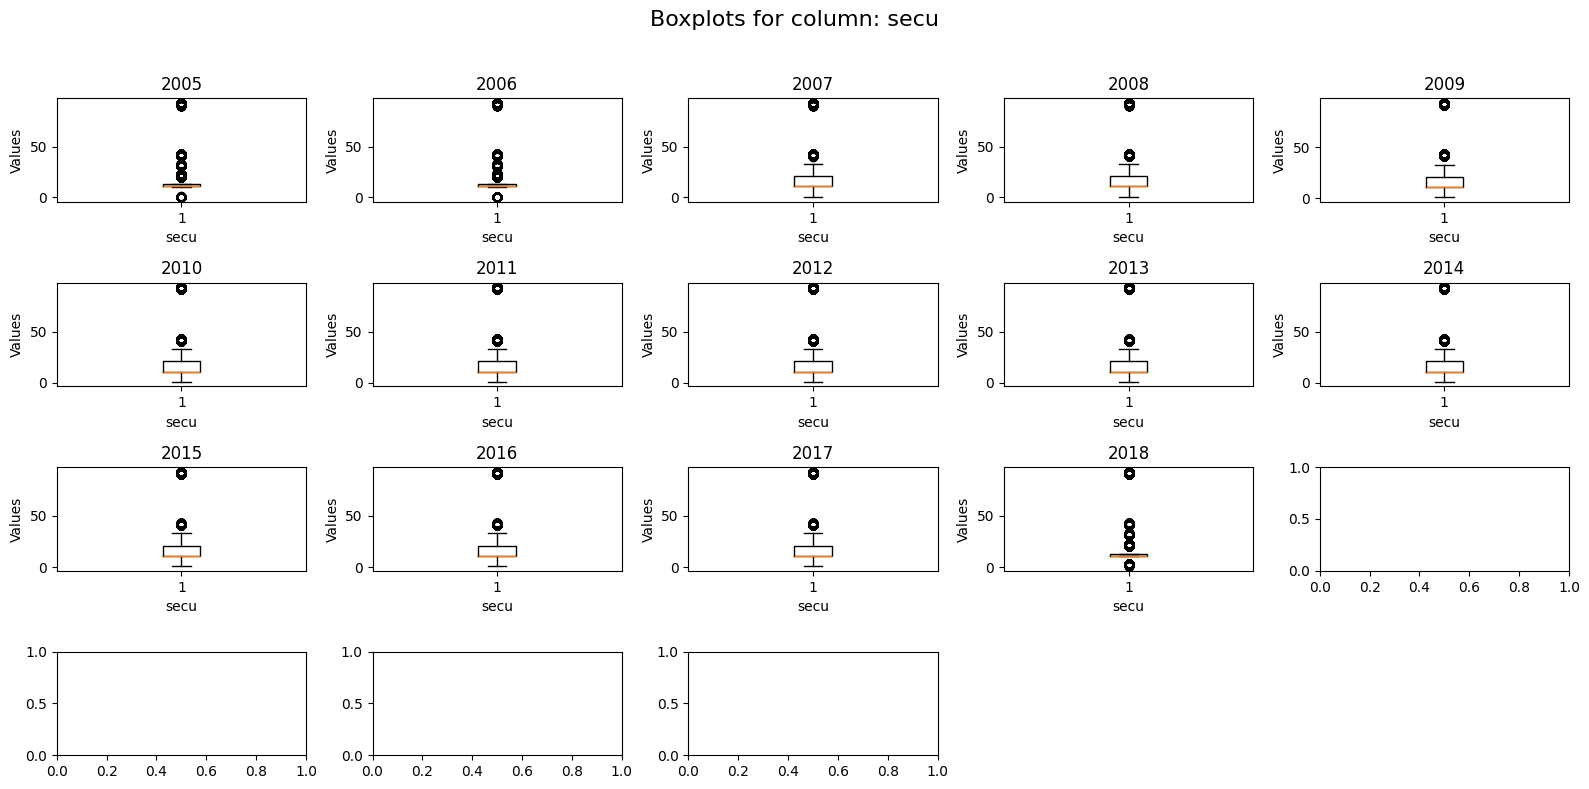

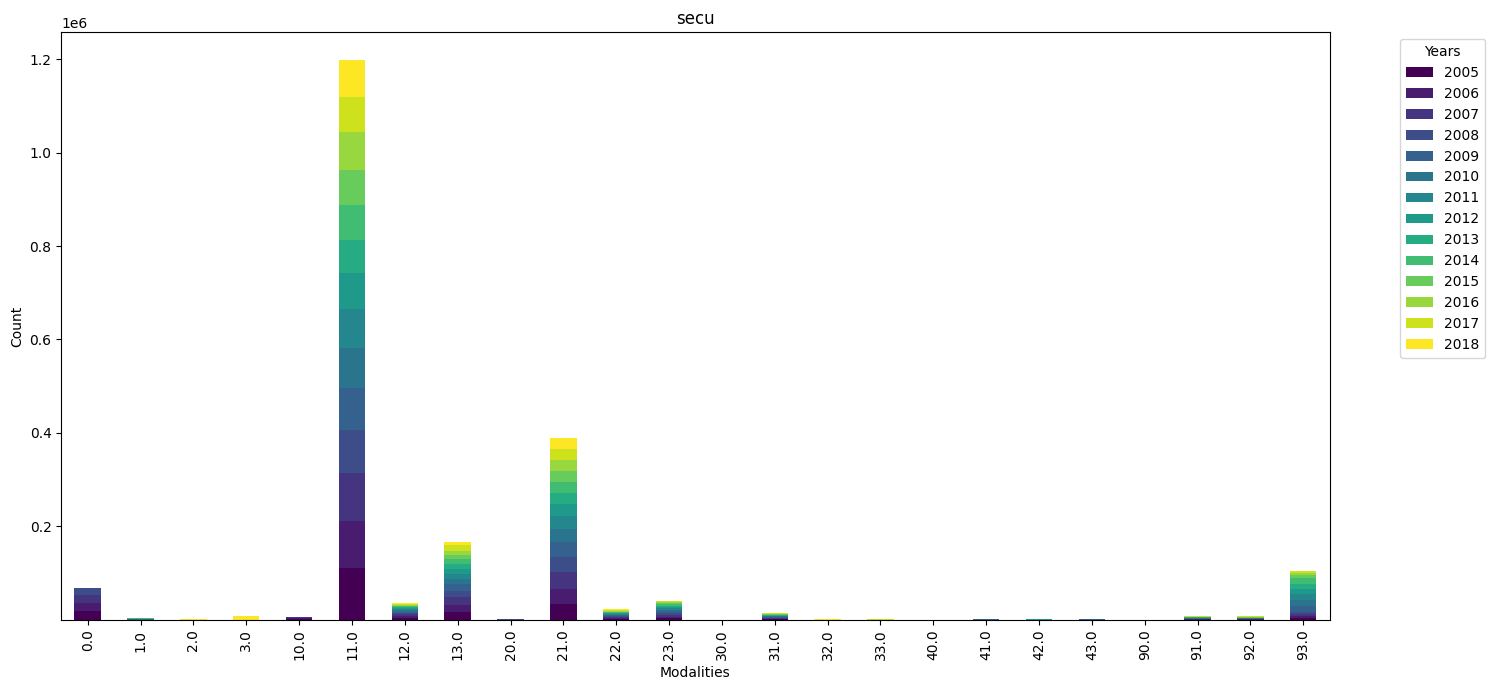

2024-06-10 17:11:56,295 - WARNING - Le nombre de modalités uniques dans la colonne secu excède le seuil de 12. Aucun graphique en ligne généré.



Colonne: catu / lignes: 2636377
  Année  Type      Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  ------  -------------------------------------  -----------------------------------
   2005  int64        1                                      0                                    0
   2006  int64        1                                      0                                    0
   2007  int64        1                                      0                                    0
   2008  int64        1                                      0                                    0
   2009  int64        1                                      0                                    0
   2010  int64        1                                      0                                    0
   2011  int64        1                                      0                                    0
   2012  int64        1                                      0     

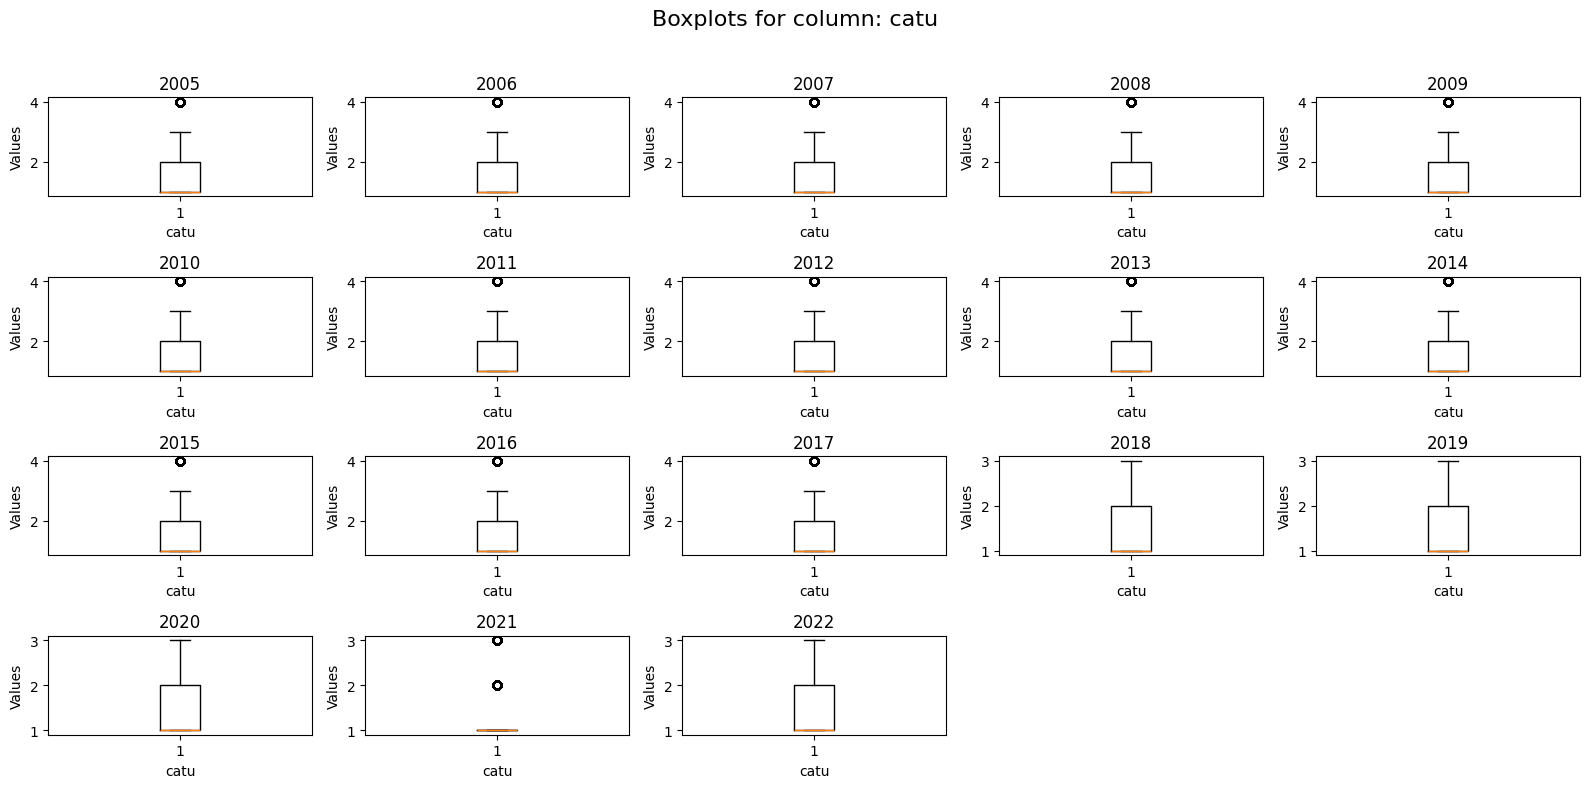

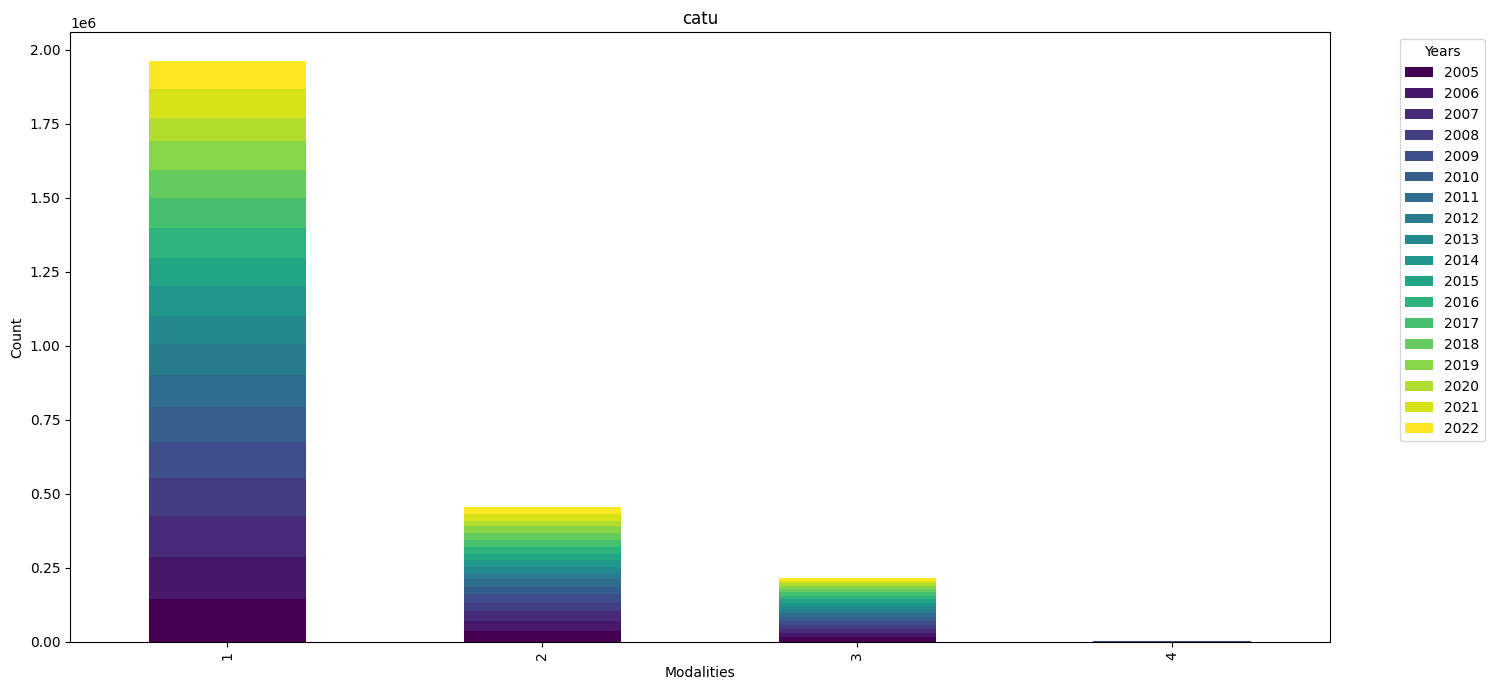

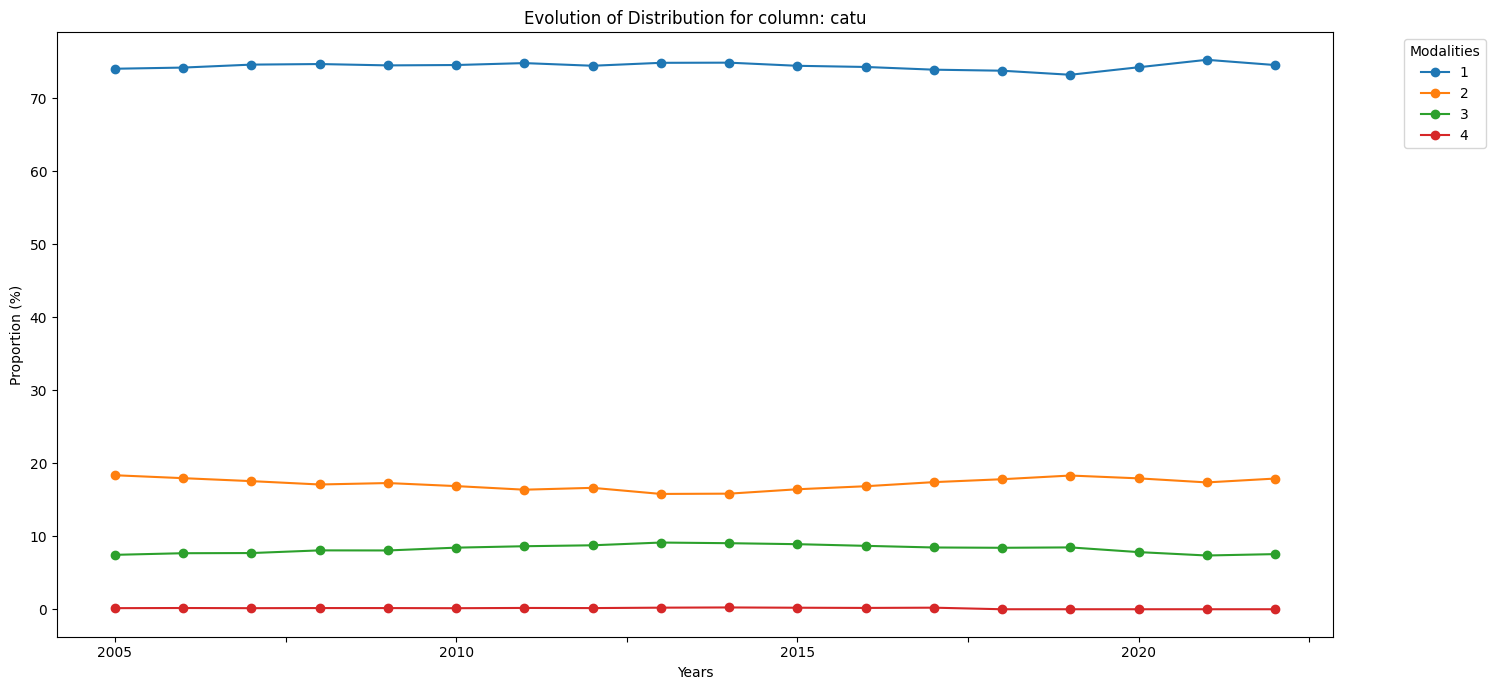


Colonne: locp / lignes: 2636377
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  int64         0                              0                                  0
   2006  int64         0                              0                                  0
   2007  int64         0                              0                                  0
   2008  int64         0                              0                                  0
   2009  float64       0                              0.357311                           0.00022493
   2010  float64       0                              0.152407                           8.91375e-05
   2011  float64       0                              0.152818                           8.6103e-05
   2012  float64       0                              0.121909                           6.41031e-05

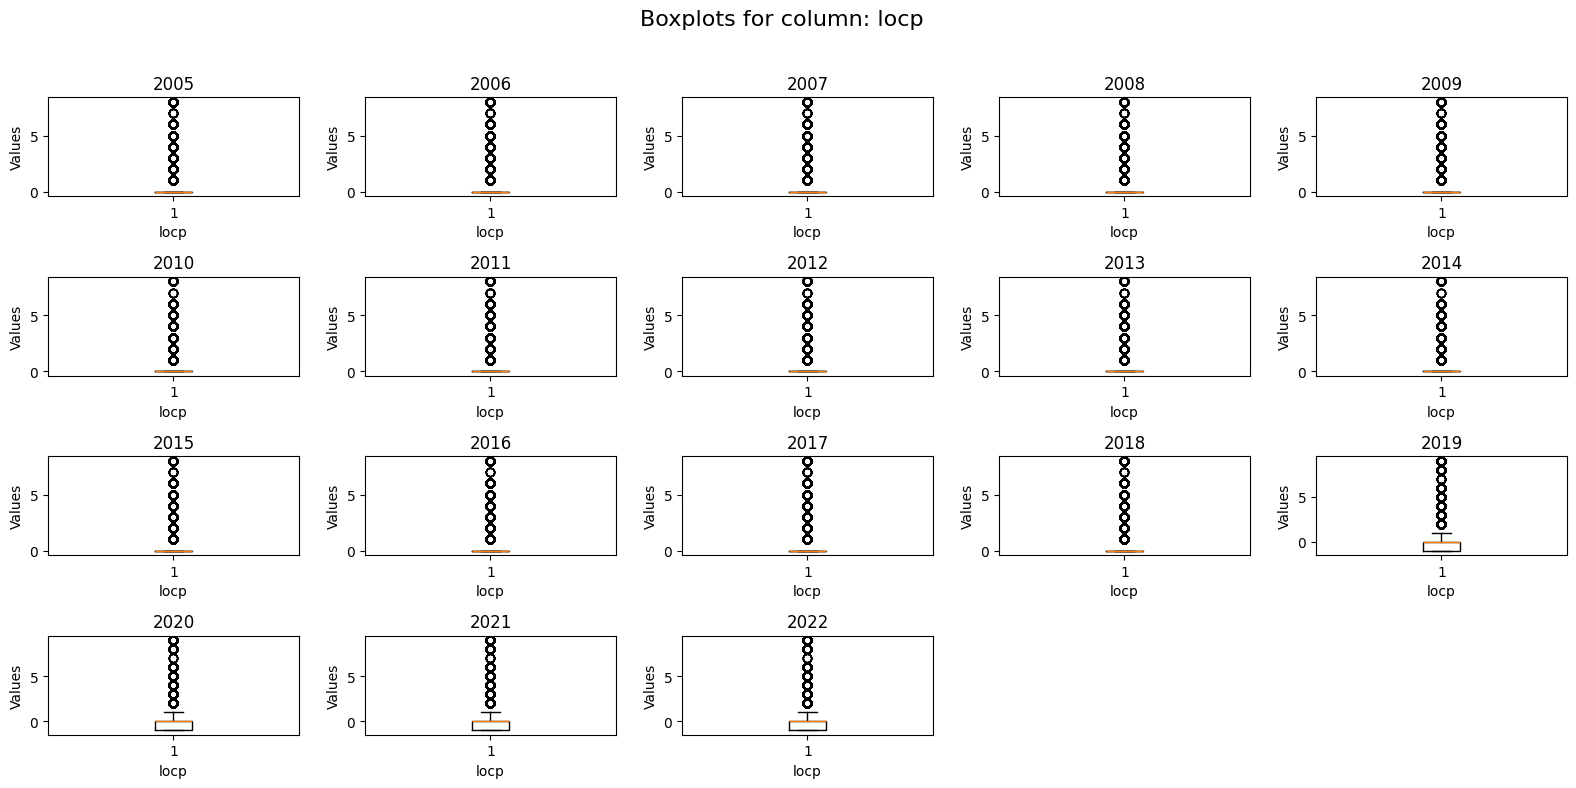

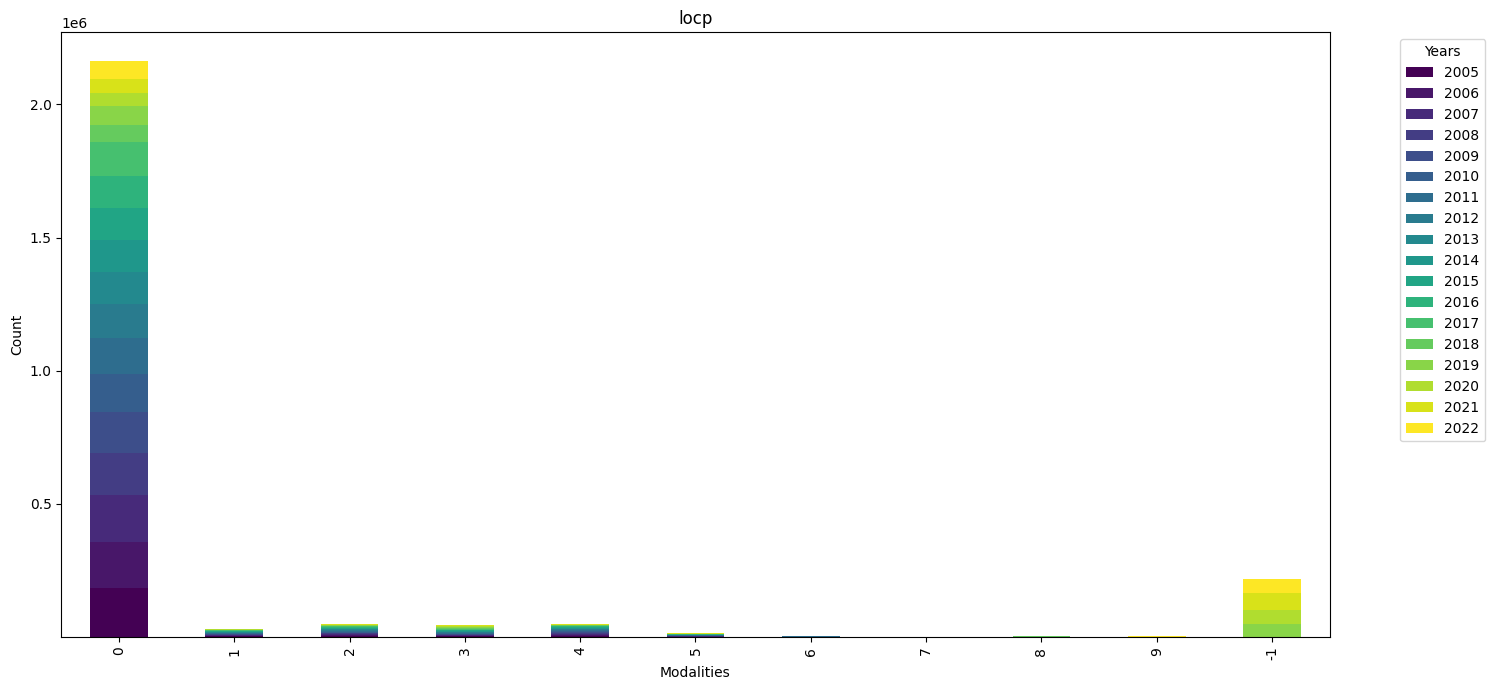

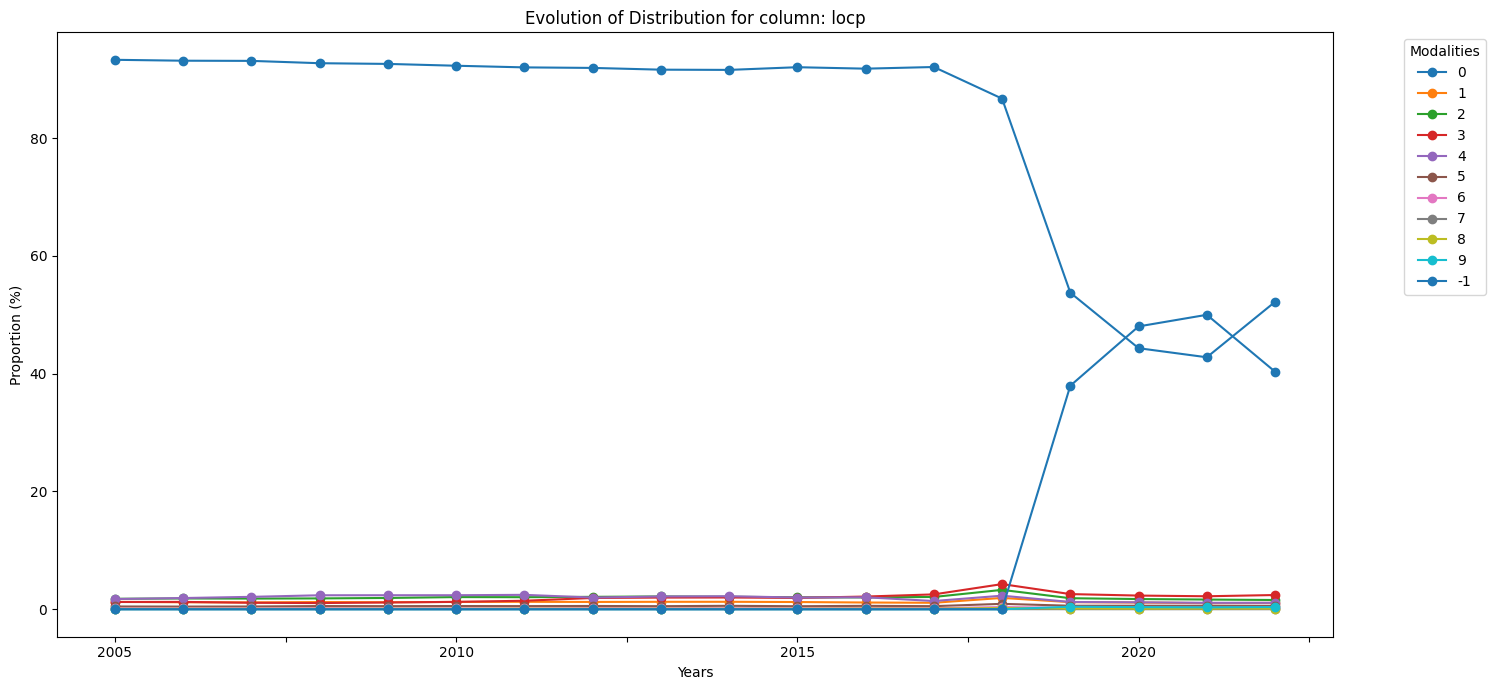


Colonne: secu1 / lignes: 2636377
  Année  Type      Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  ------  -------------------------------------  -----------------------------------
   2019  int64        1                                      0                                    0
   2020  int64        1                                      0                                    0
   2021  int64        1                                      0                                    0
   2022  int64        1                                      0                                    0


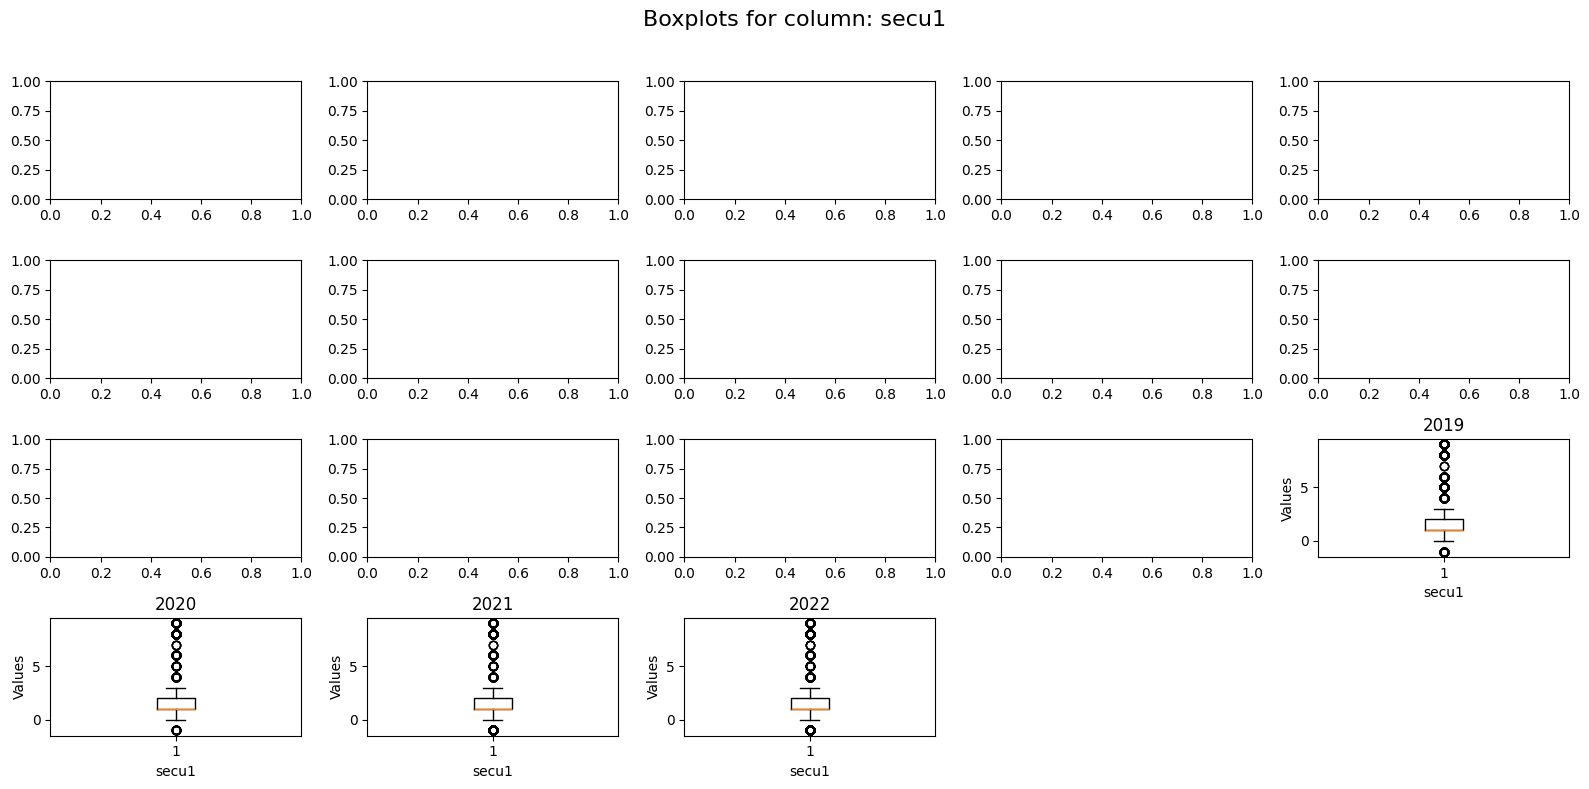

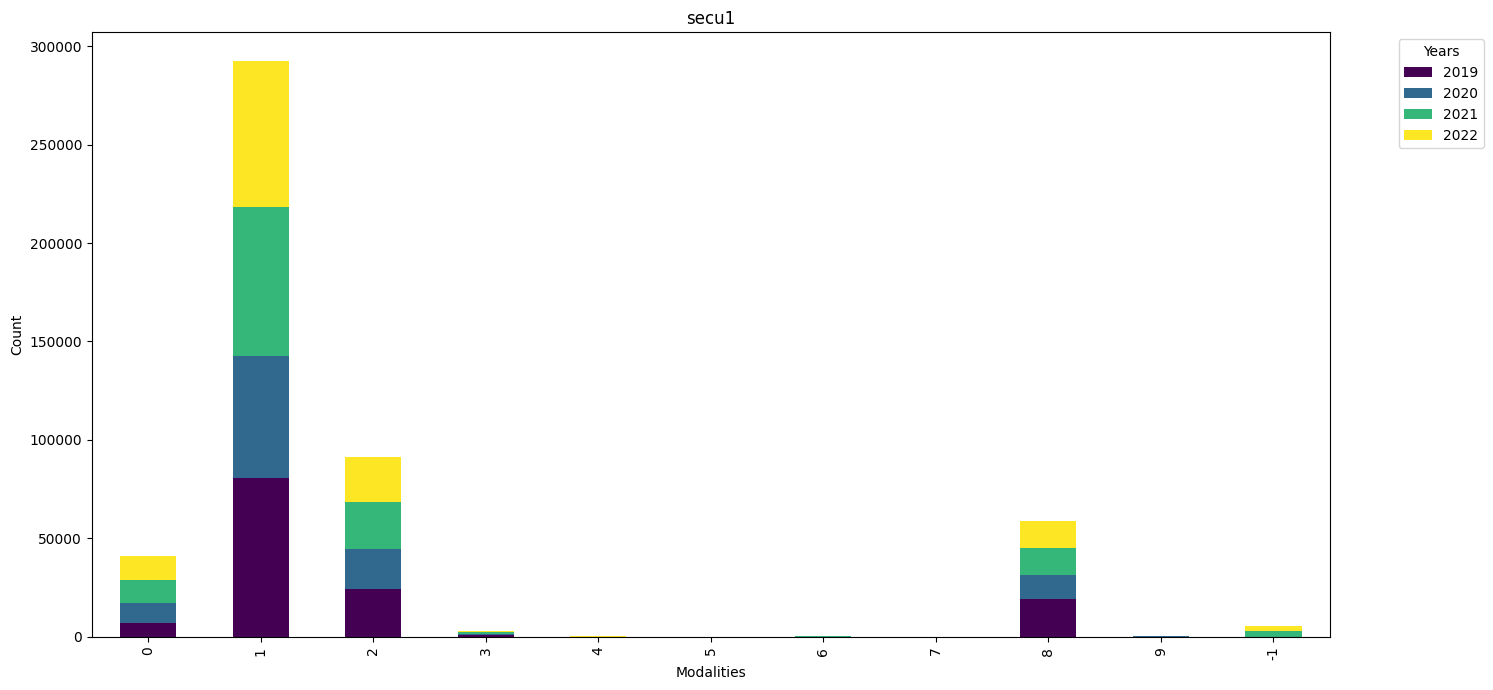

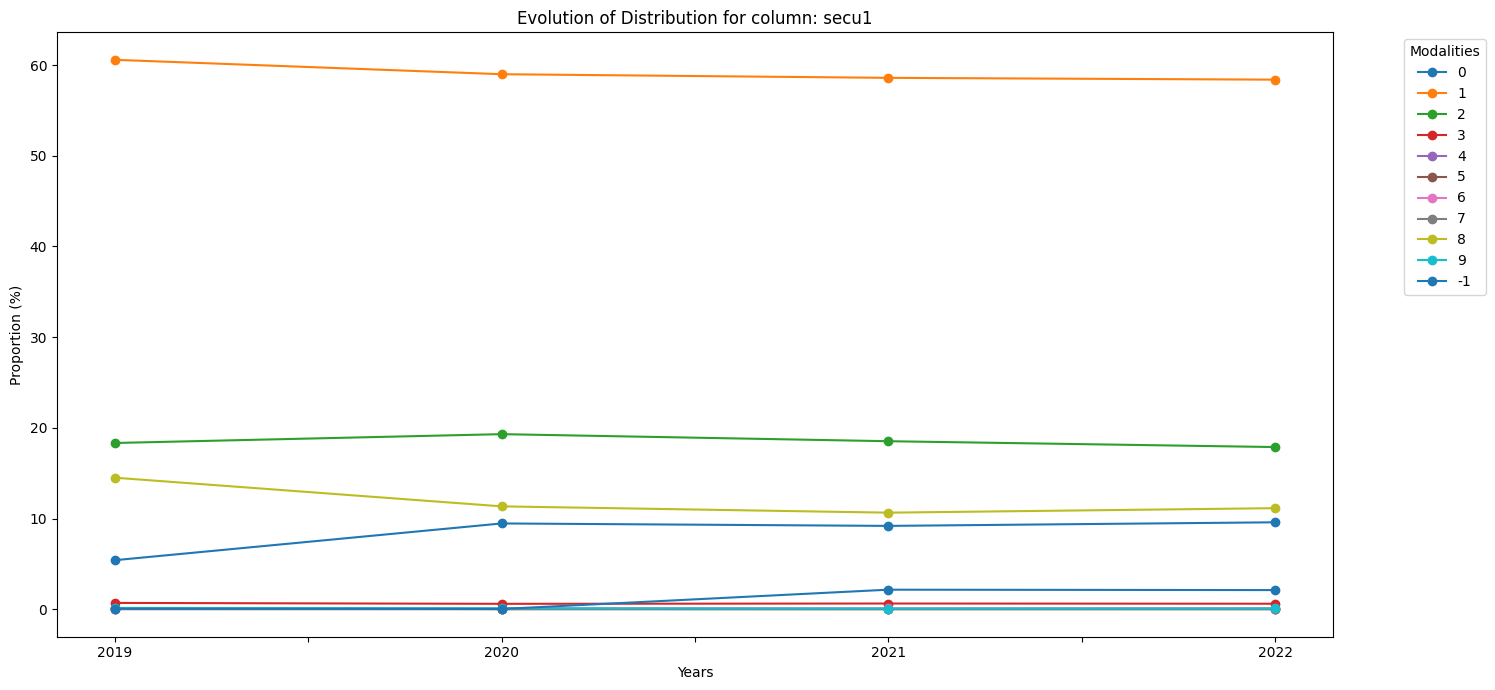


Colonne: Num_Acc / lignes: 2636377
  Année  Type         Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  ---------  -------------------------------------  -----------------------------------
   2005  int64   2.005e+11                                      0                                    0
   2006  int64   2.006e+11                                      0                                    0
   2007  int64   2.007e+11                                      0                                    0
   2008  int64   2.008e+11                                      0                                    0
   2009  int64   2.009e+11                                      0                                    0
   2010  int64   2.01e+11                                       0                                    0
   2011  int64   2.011e+11                                      0                                    0
   2012  int64   2.012e+11           

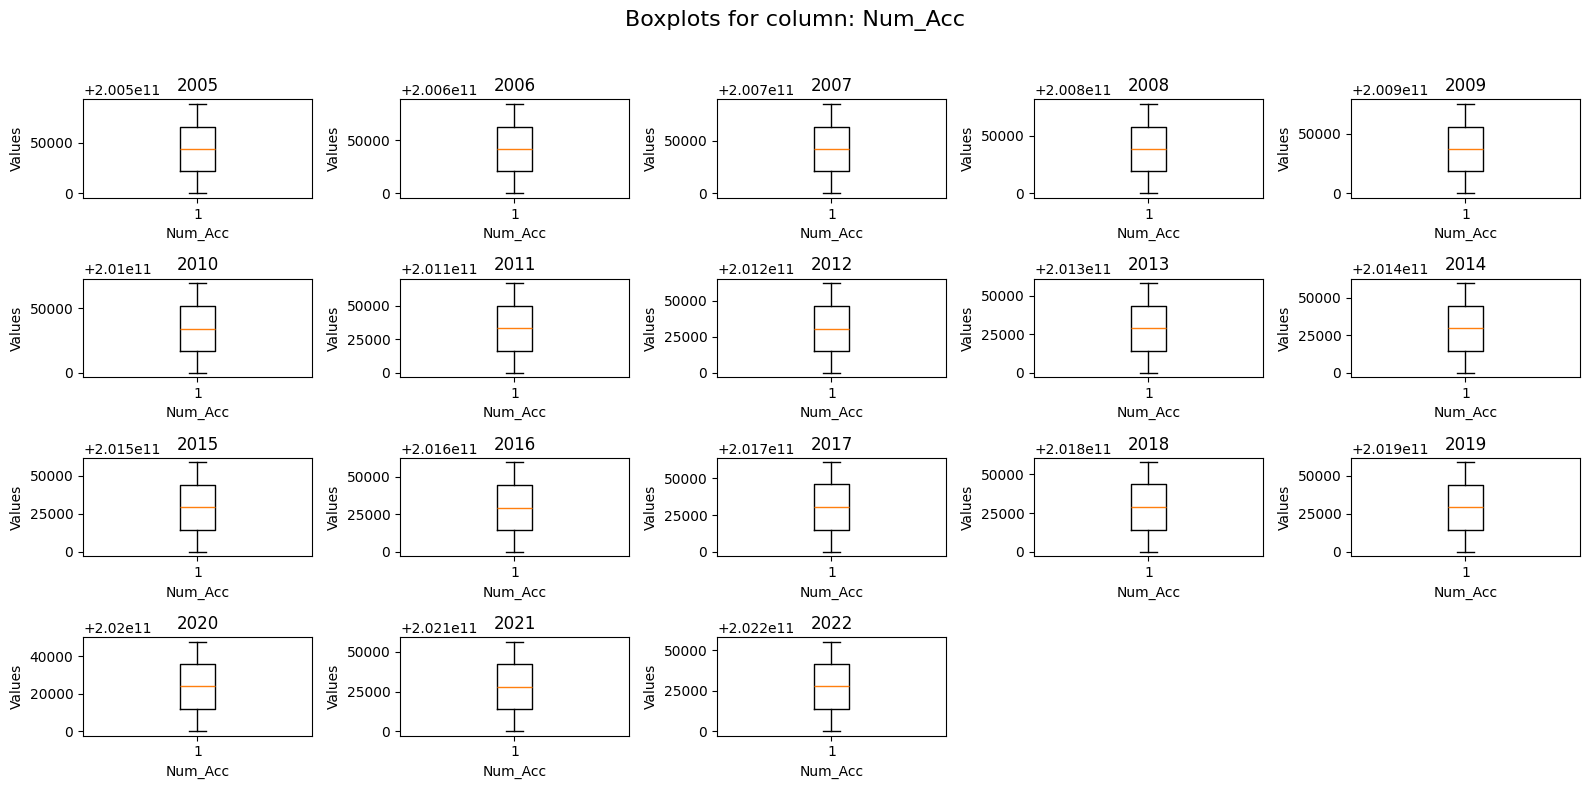

2024-06-10 17:12:07,553 - WARNING - Le nombre de modalités uniques dans la colonne Num_Acc excède le seuil de 50. Auncun bar plot généré.
2024-06-10 17:12:07,859 - WARNING - Le nombre de modalités uniques dans la colonne Num_Acc excède le seuil de 12. Aucun graphique en ligne généré.



Colonne: sexe / lignes: 2636377
  Année  Type      Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  ------  -------------------------------------  -----------------------------------
   2005  int64        1                                      0                                    0
   2006  int64        1                                      0                                    0
   2007  int64        1                                      0                                    0
   2008  int64        1                                      0                                    0
   2009  int64        1                                      0                                    0
   2010  int64        1                                      0                                    0
   2011  int64        1                                      0                                    0
   2012  int64        1                                      0     

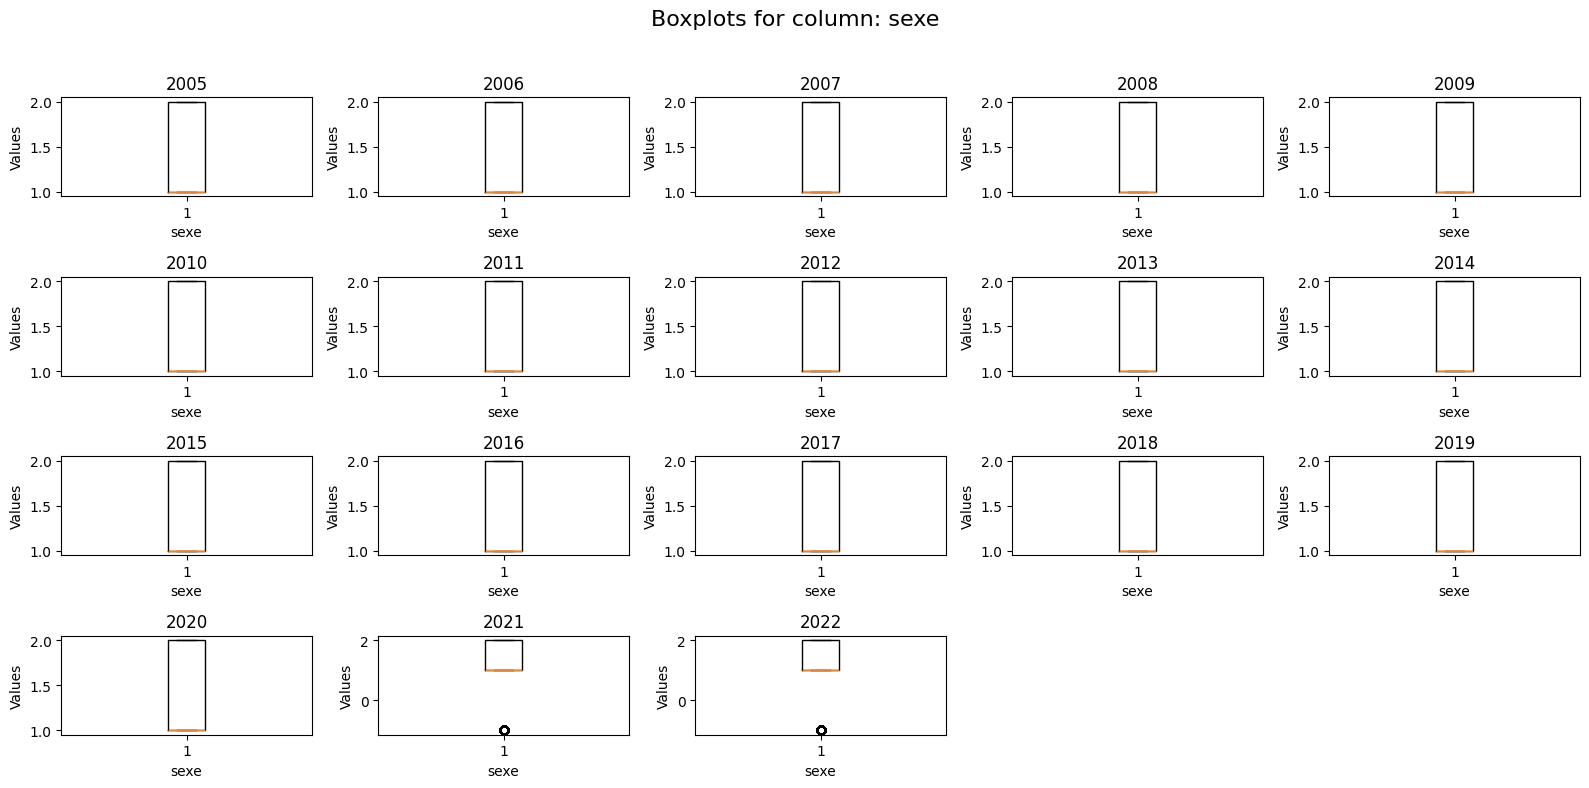

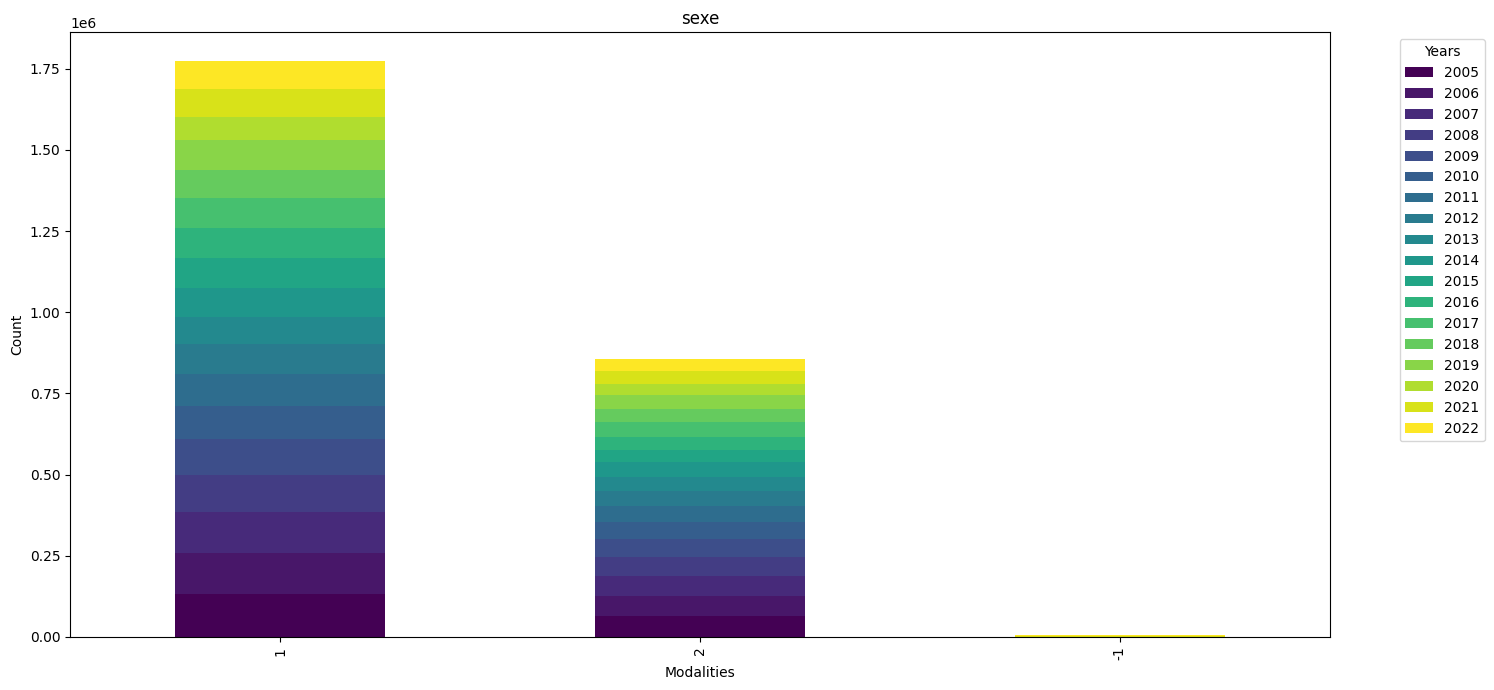

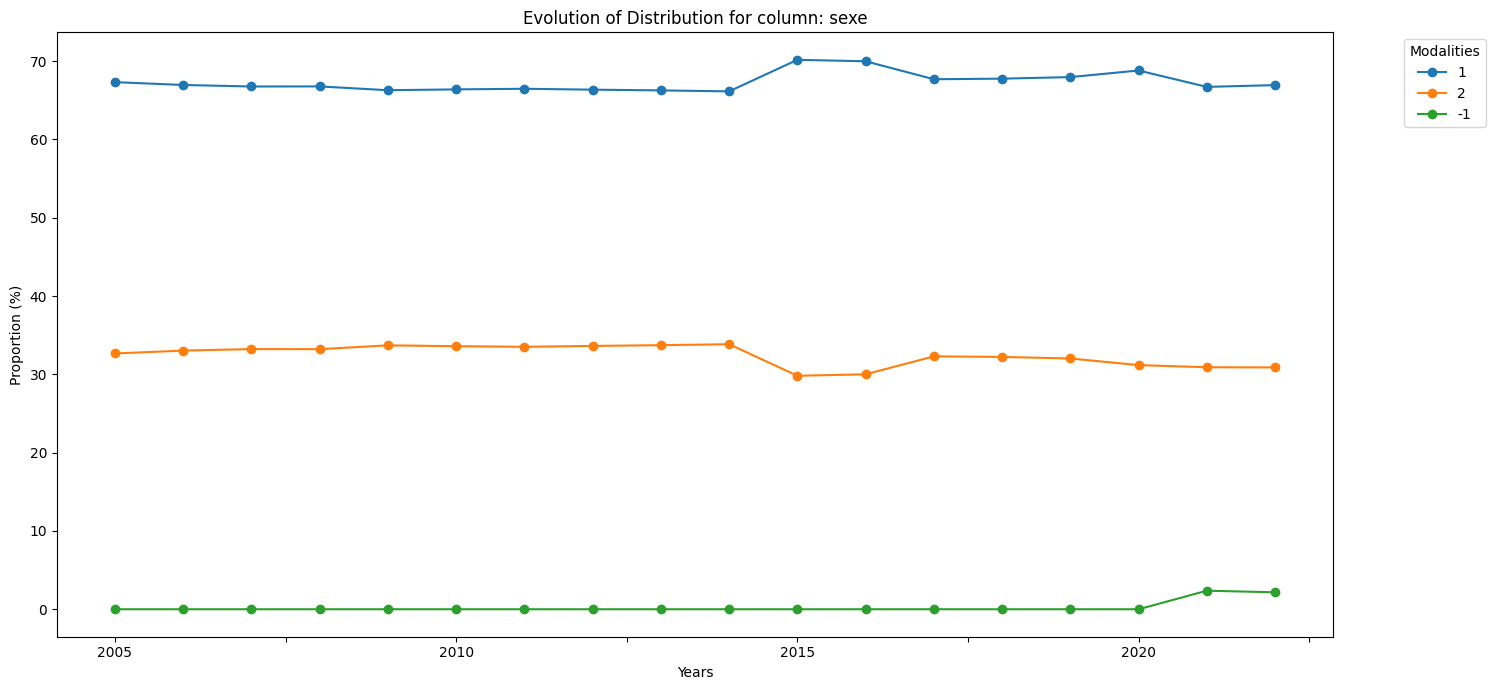


Colonne: etatp / lignes: 2636377
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  int64         0                              0                                  0
   2006  int64         0                              0                                  0
   2007  int64         0                              0                                  0
   2008  int64         0                              0                                  0
   2009  float64       0                              0.336222                           0.000211654
   2010  float64       0                              0.142679                           8.34479e-05
   2011  float64       0                              0.152144                           8.57237e-05
   2012  float64       0                              0.120466                           6.33445e

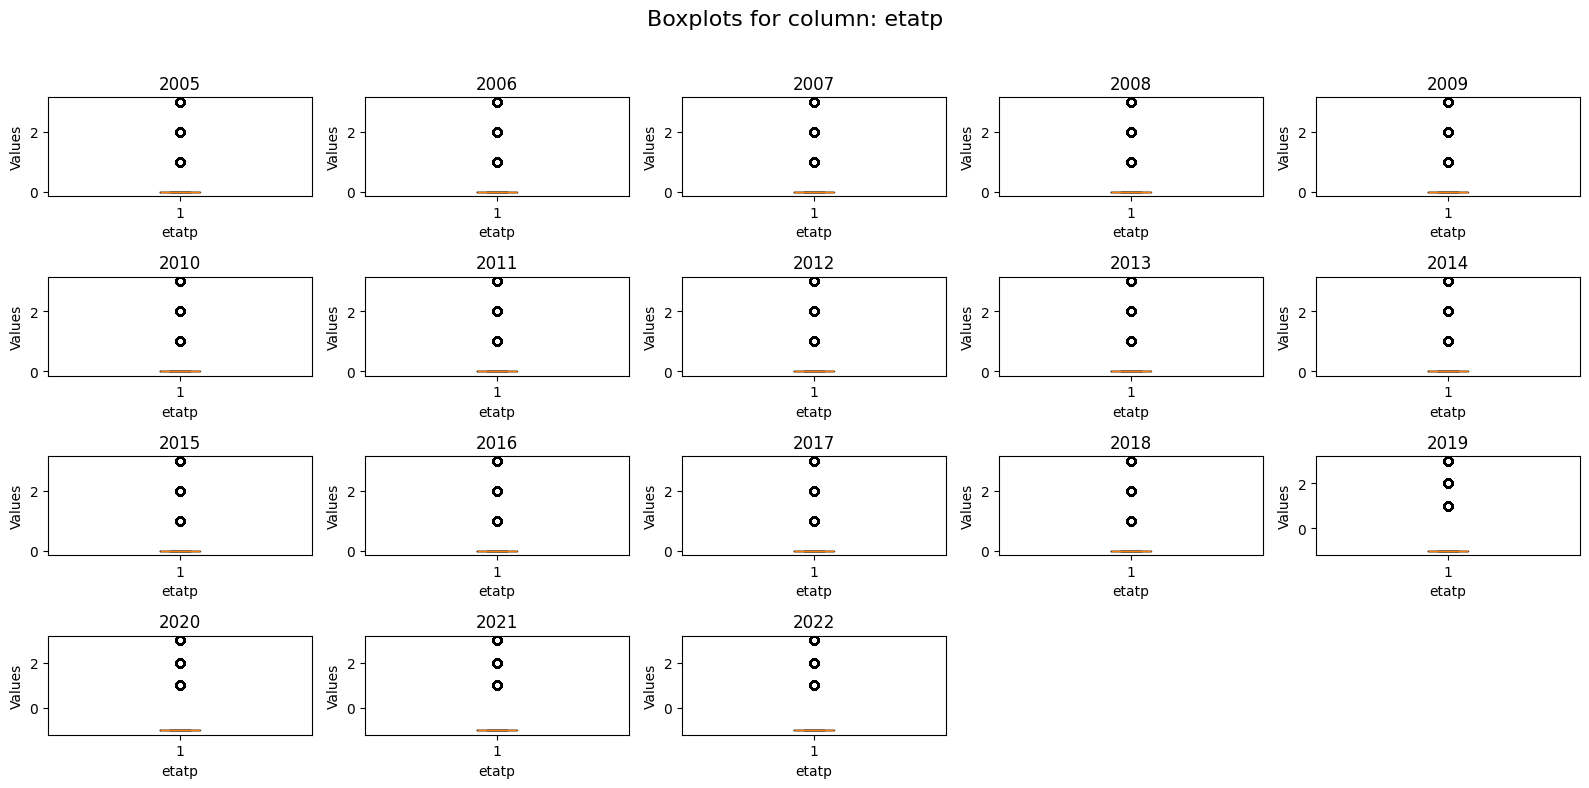

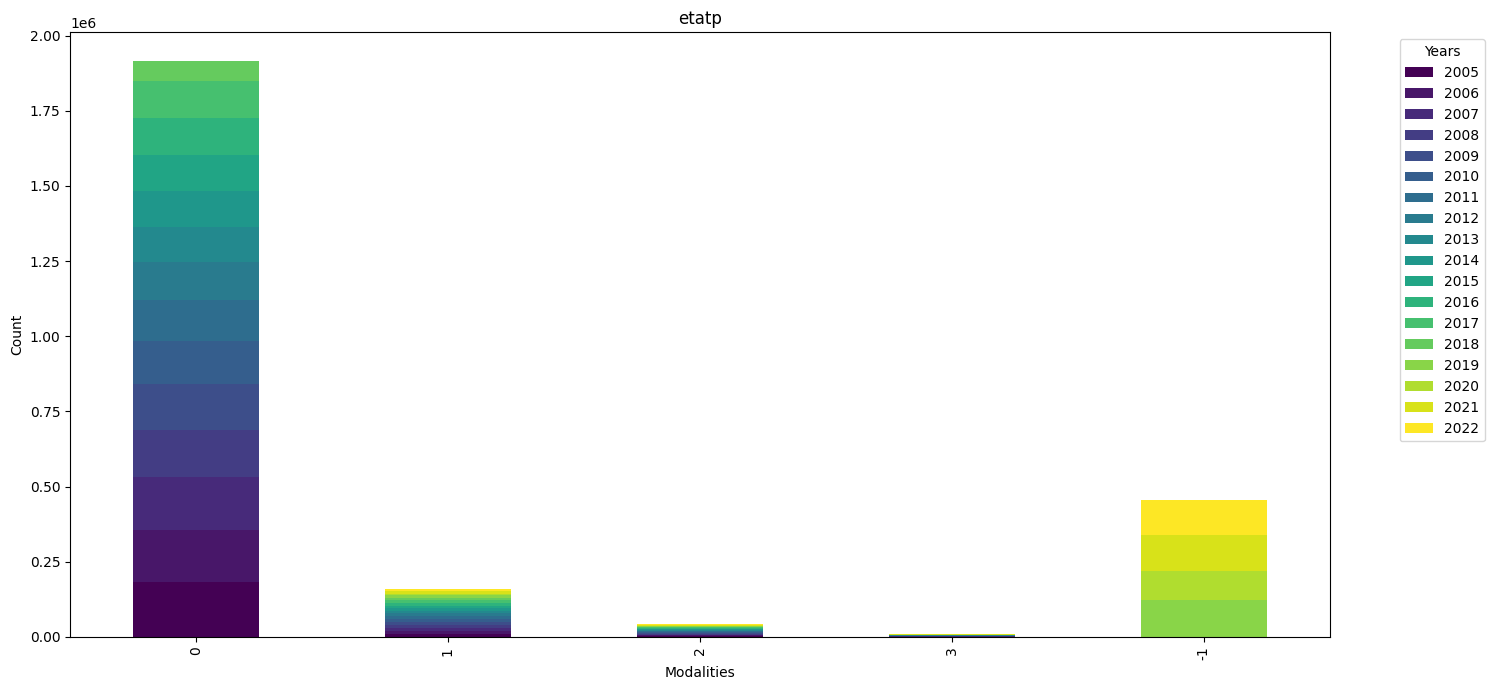

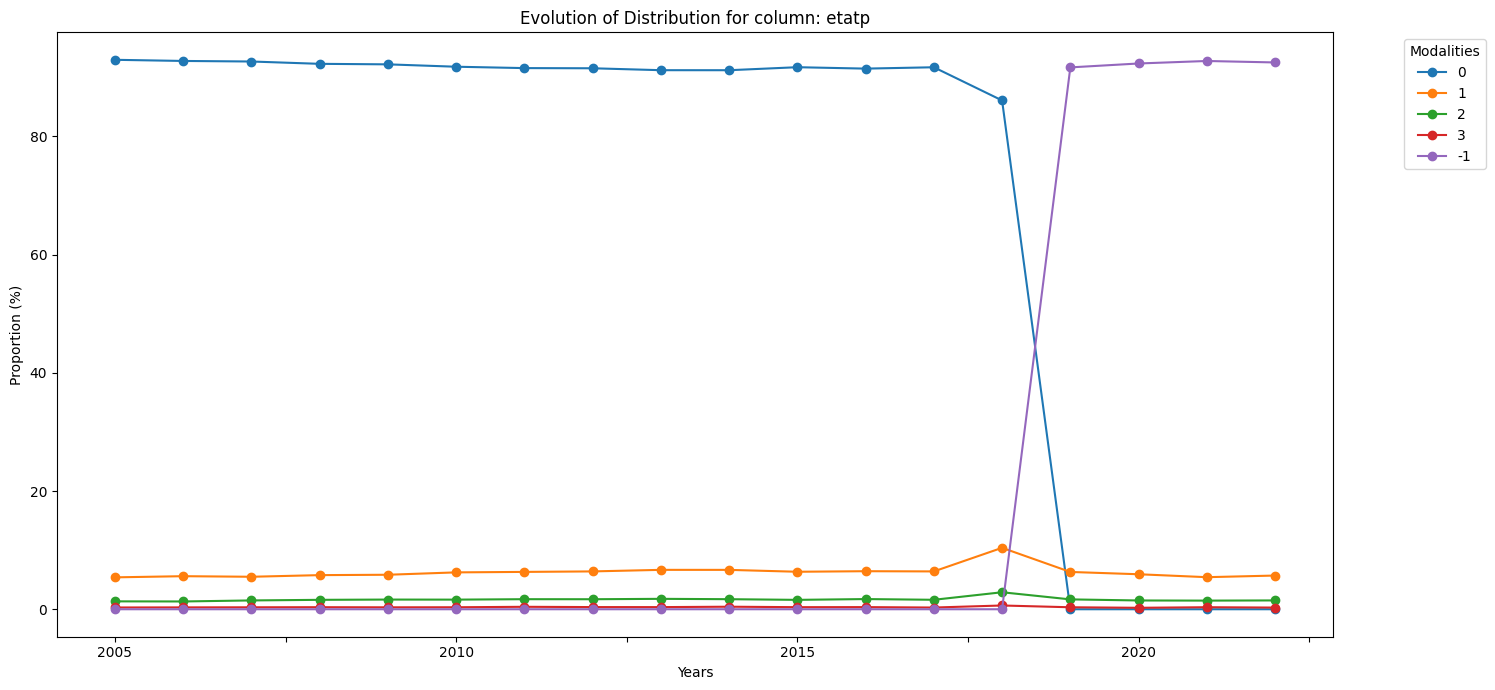


Colonne: trajet / lignes: 2636377
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  int64         5                             0                                   0
   2006  int64         5                             0                                   0
   2007  int64         0                             0                                   0
   2008  int64         0                             0                                   0
   2009  float64       5                             0.0584471                           3.67929e-05
   2010  float64       5                             0.0447494                           2.61723e-05
   2011  float64       5                             0.0417388                           2.35171e-05
   2012  float64       5                             0.0418386                           2.19999

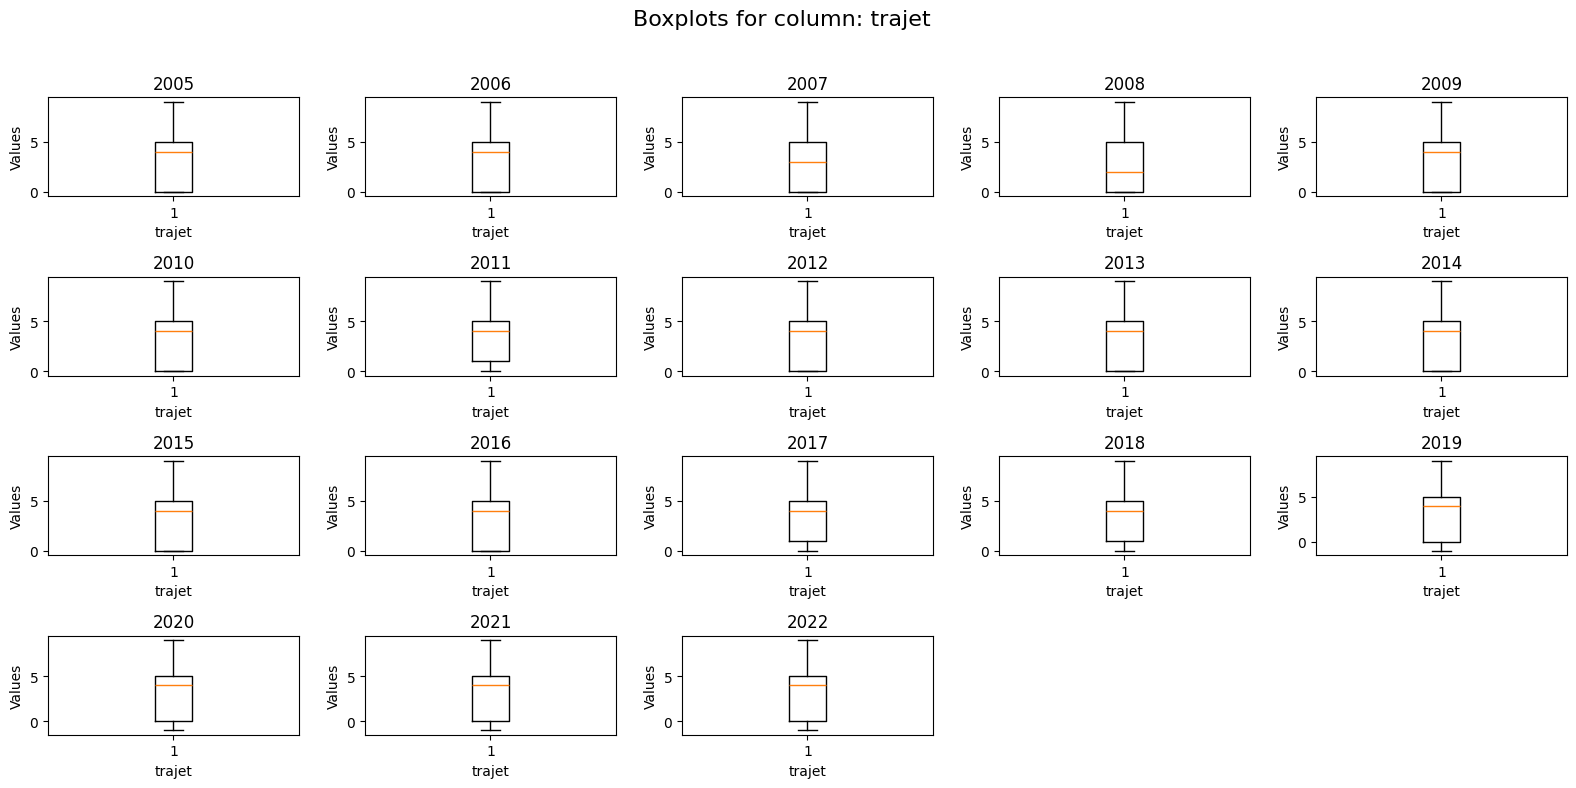

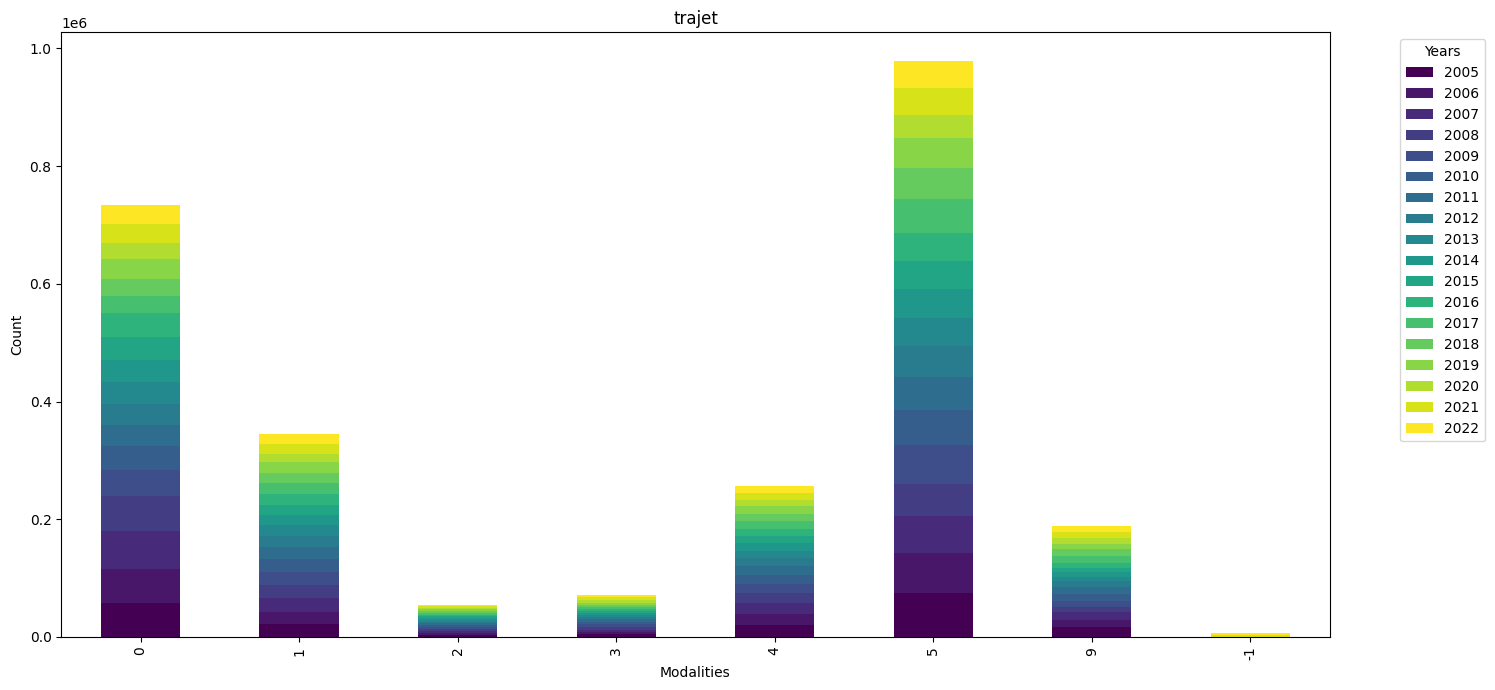

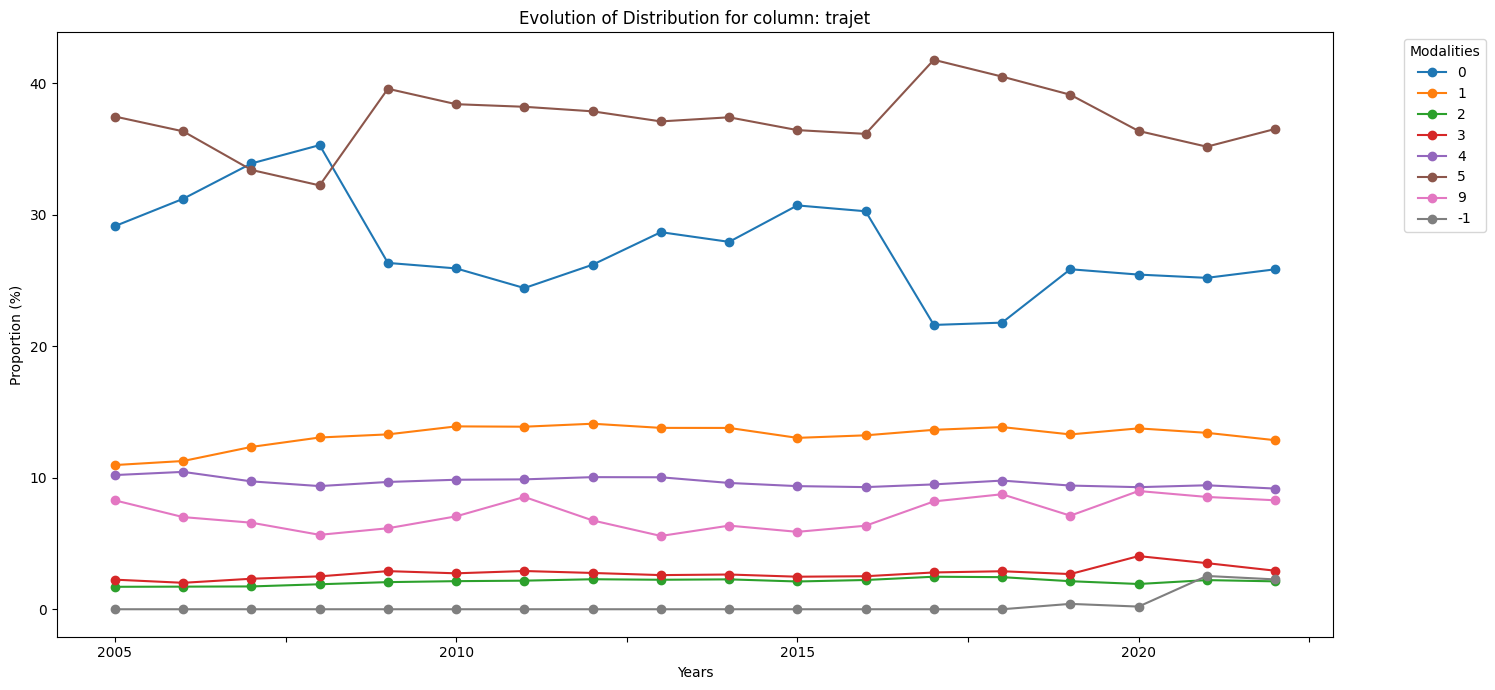


Colonne: actp / lignes: 2636377
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  int64         0                              0                                  0
   2006  int64         0                              0                                  0
   2007  int64         0                              0                                  0
   2008  int64         0                              0                                  0
   2009  float64       0                              0.361529                           0.000227585
   2010  float64       0                              0.15565                            9.1034e-05
   2011  float64       0                              0.156857                           8.83789e-05
   2012  float64       0                              0.124794                           6.56204e-0

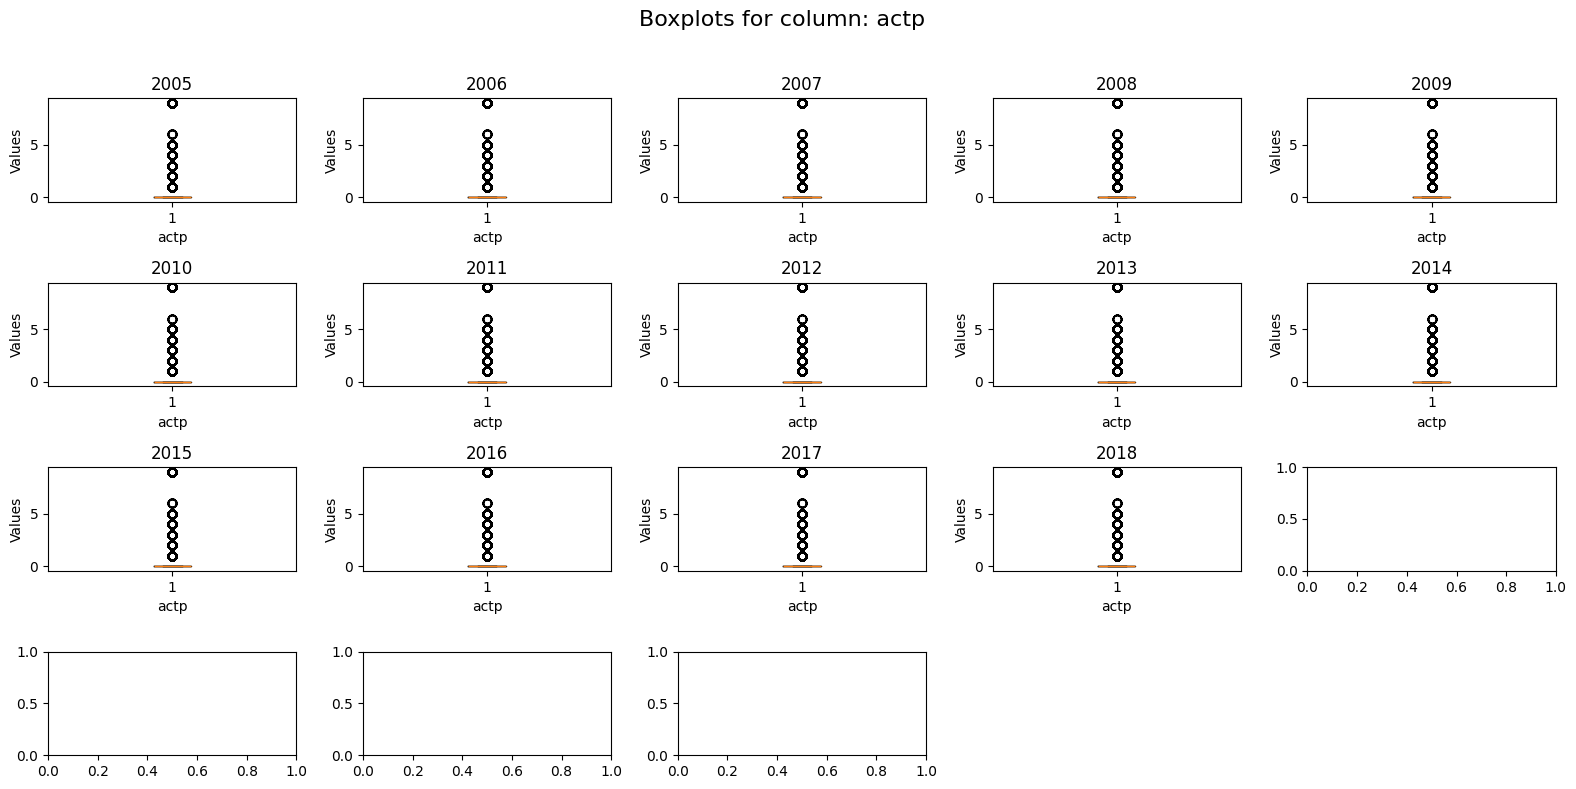

C:\Users\remi\AppData\Local\Temp\ipykernel_3432\2582685462.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  count = modality_counts[file_name].get(modality, 0)


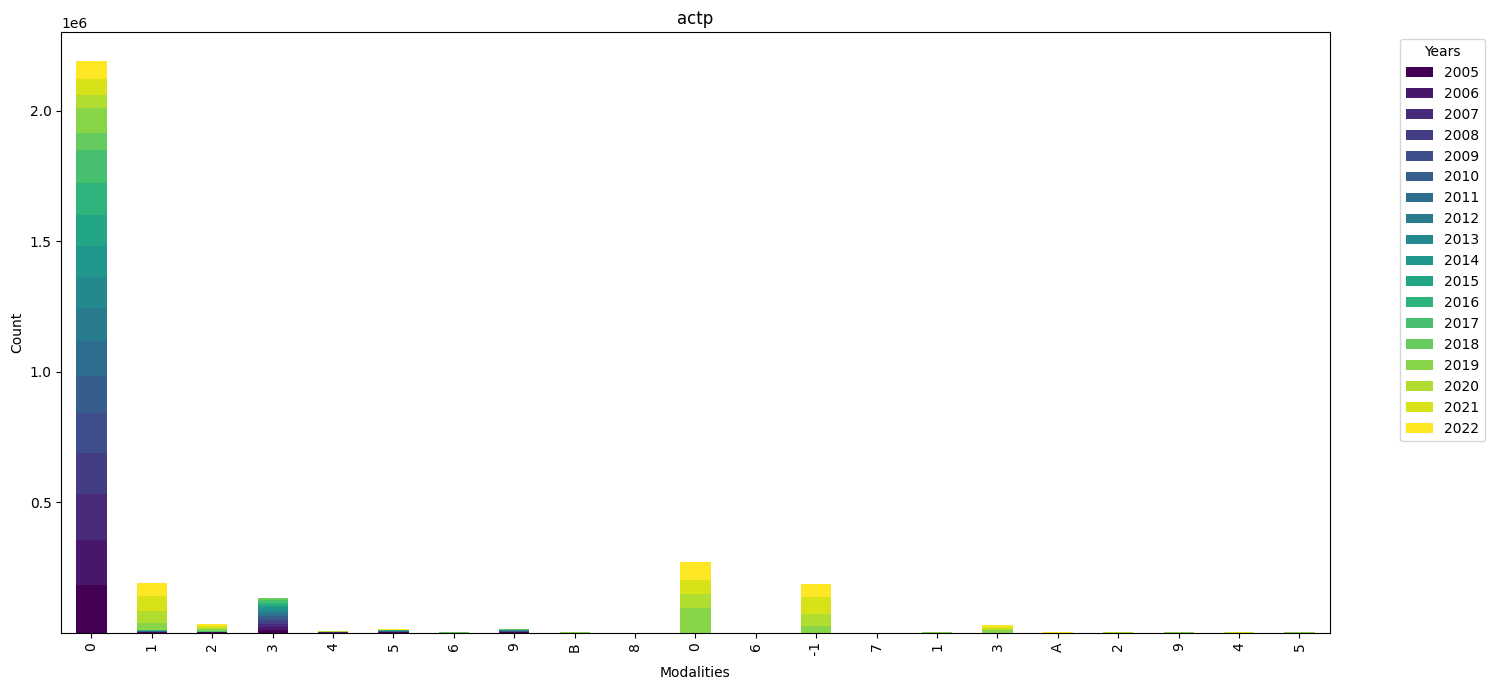

2024-06-10 17:12:19,608 - WARNING - Le nombre de modalités uniques dans la colonne actp excède le seuil de 12. Aucun graphique en ligne généré.


2024-06-10 17:12:19,610 - INFO - Chargement de data/raw\vehicules_2005.csv.
2024-06-10 17:12:19,610 - INFO - Chargement de data/raw\vehicules_2006.csv.
2024-06-10 17:12:19,611 - INFO - Chargement de data/raw\vehicules_2007.csv.
2024-06-10 17:12:19,611 - INFO - Chargement de data/raw\vehicules_2008.csv.
2024-06-10 17:12:19,612 - INFO - Chargement de data/raw\vehicules_2009.csv.
2024-06-10 17:12:19,613 - INFO - Chargement de data/raw\vehicules_2010.csv.
2024-06-10 17:12:19,614 - INFO - Chargement de data/raw\vehicules_2011.csv.
2024-06-10 17:12:19,614 - INFO - Chargement de data/raw\vehicules_2012.csv.
2024-06-10 17:12:19,614 - INFO - Chargement de data/raw\vehicules_2013.csv.
2024-06-10 17:12:19,615 - INFO - Chargement de data/raw\vehicules_2014.csv.
2024-06-10 17:12:19,615 - INFO - Chargement de data/raw\vehicules_2015.csv.
2024-06-10 17:12:19,616 - INFO - Chargement de data/raw\vehicules_2016.csv.
2024-06-10 17:12:19,616 - INFO - Chargement de data/raw\vehicules-2017.csv.
2024-06-10 1


Colonne: choc / lignes: 2009395
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  int64         1                              0                                  0
   2006  int64         1                              0                                  0
   2007  int64         1                              0                                  0
   2008  int64         1                              0                                  0
   2009  float64       1                              0.0379906                          2.38878e-05
   2010  float64       1                              0.0144382                          8.46026e-06
   2011  float64       1                              0.0368893                          2.09018e-05
   2012  float64       1                              0.0321319                          1.69205e-

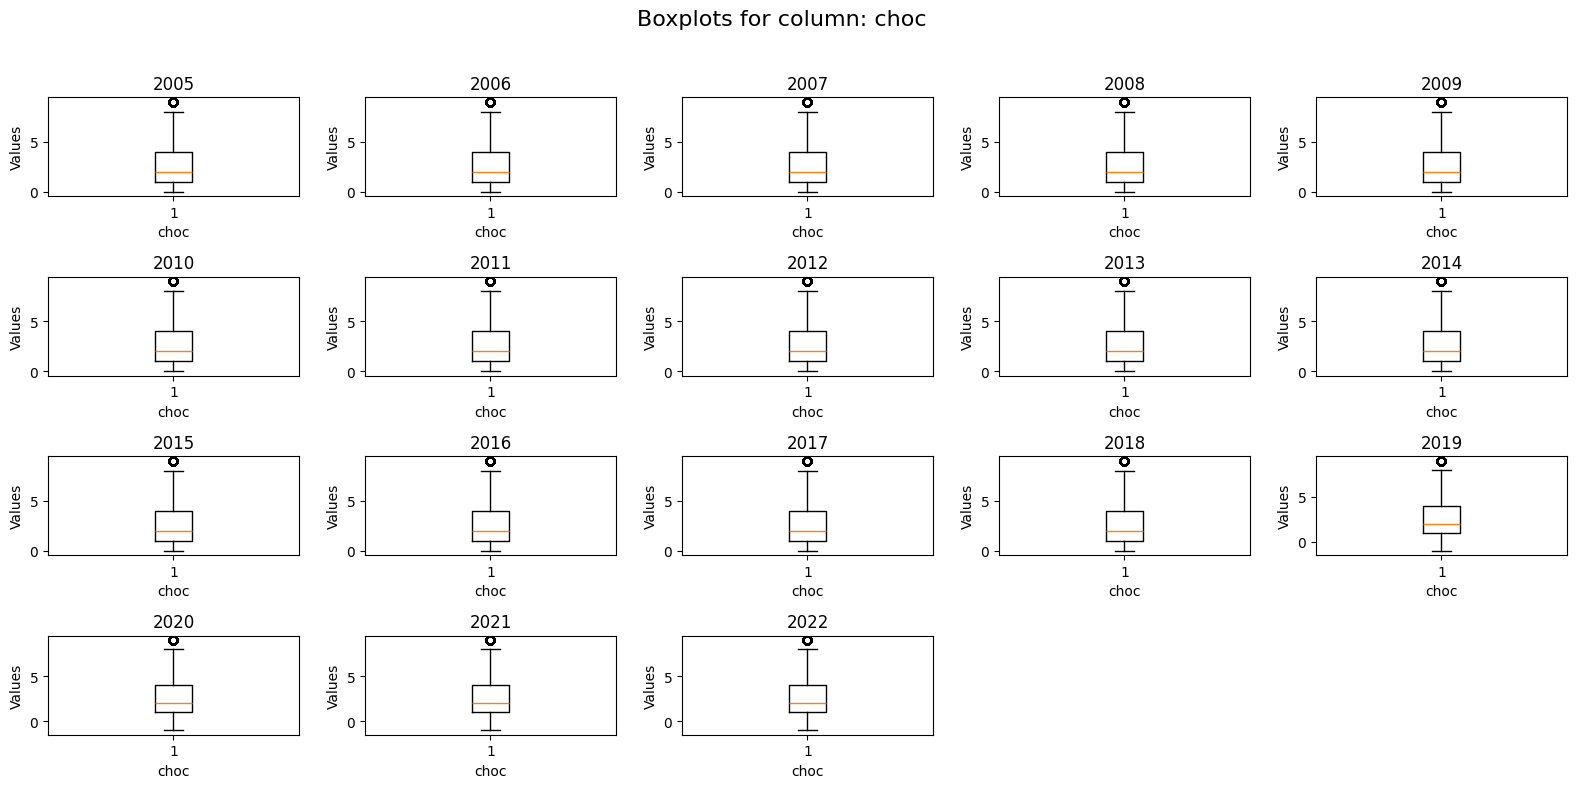

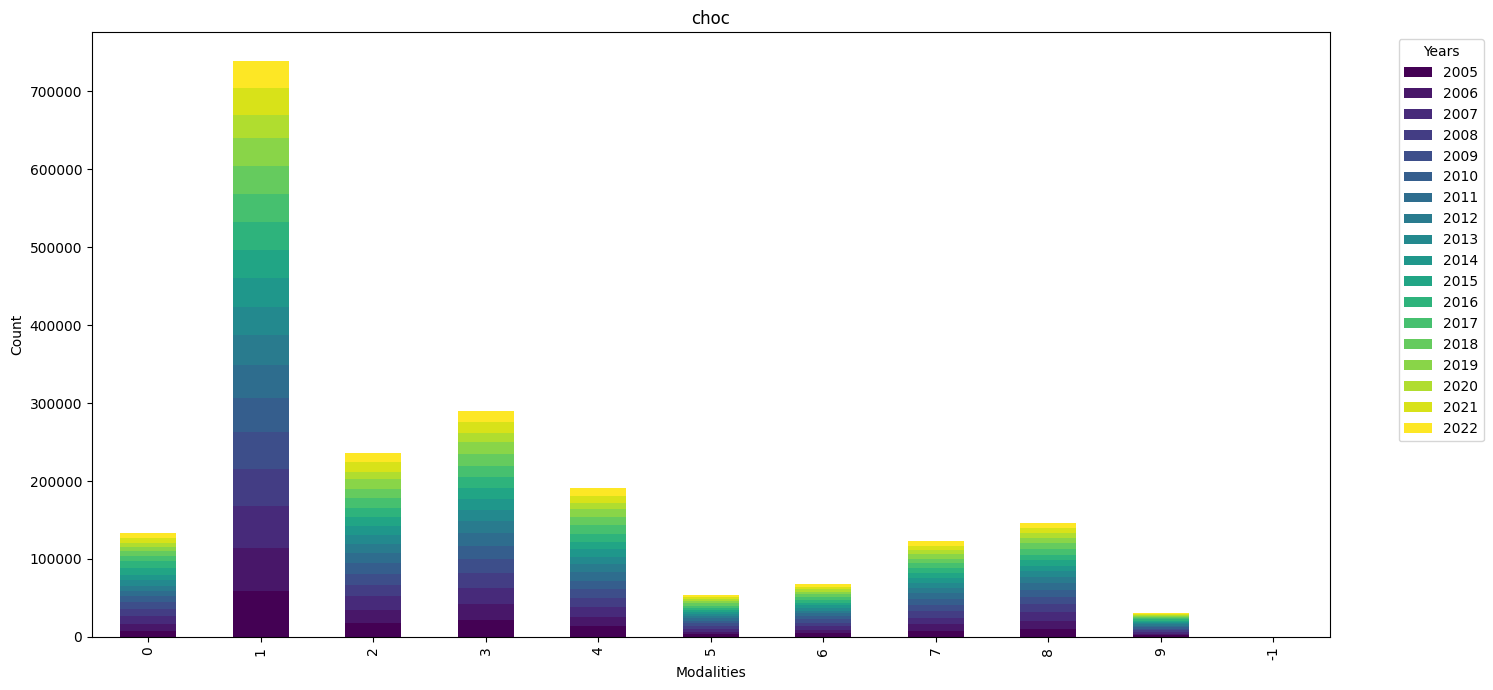

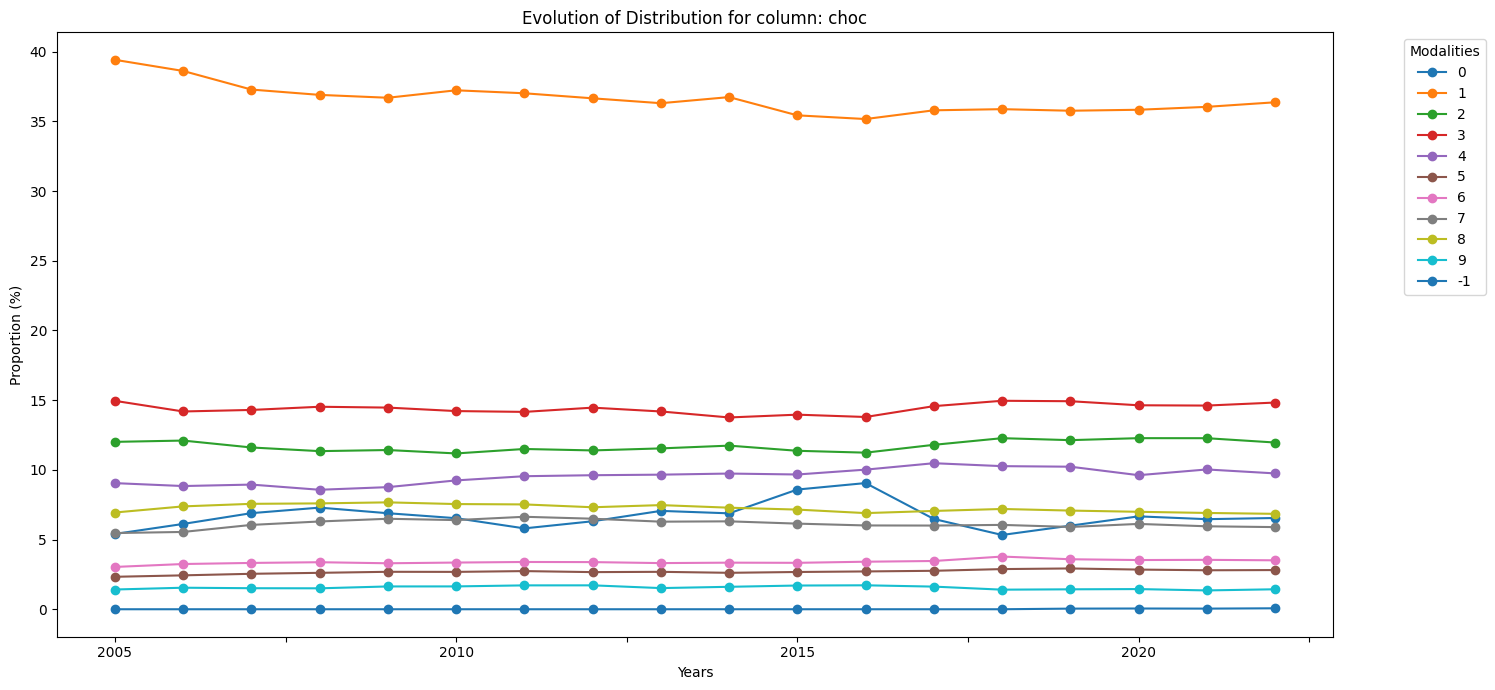

2024-06-10 17:12:23,648 - INFO - La colonne id_vehicule n'est pas numérique.



Colonne: id_vehicule / lignes: 2009395
  Année  Type    Mode           Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  -----------  -------------------------------------  -----------------------------------
   2019  object  137 982 129                                      0                                    0
   2020  object  154 658 350                                      0                                    0
   2021  object  100 882                                          0                                    0
   2022  object  715 629                                          0                                    0


2024-06-10 17:12:23,910 - WARNING - Le nombre de modalités uniques dans la colonne id_vehicule excède le seuil de 50. Auncun bar plot généré.
2024-06-10 17:12:24,324 - WARNING - Le nombre de modalités uniques dans la colonne id_vehicule excède le seuil de 12. Aucun graphique en ligne généré.



Colonne: obs / lignes: 2009395
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  int64         0                              0                                  0
   2006  int64         0                              0                                  0
   2007  int64         0                              0                                  0
   2008  int64         0                              0                                  0
   2009  float64       0                              0.208157                           0.000130885
   2010  float64       0                              0.0721911                          4.23013e-05
   2011  float64       0                              0.10979                            6.22078e-05
   2012  float64       0                              0.0614285                          3.2348e-05

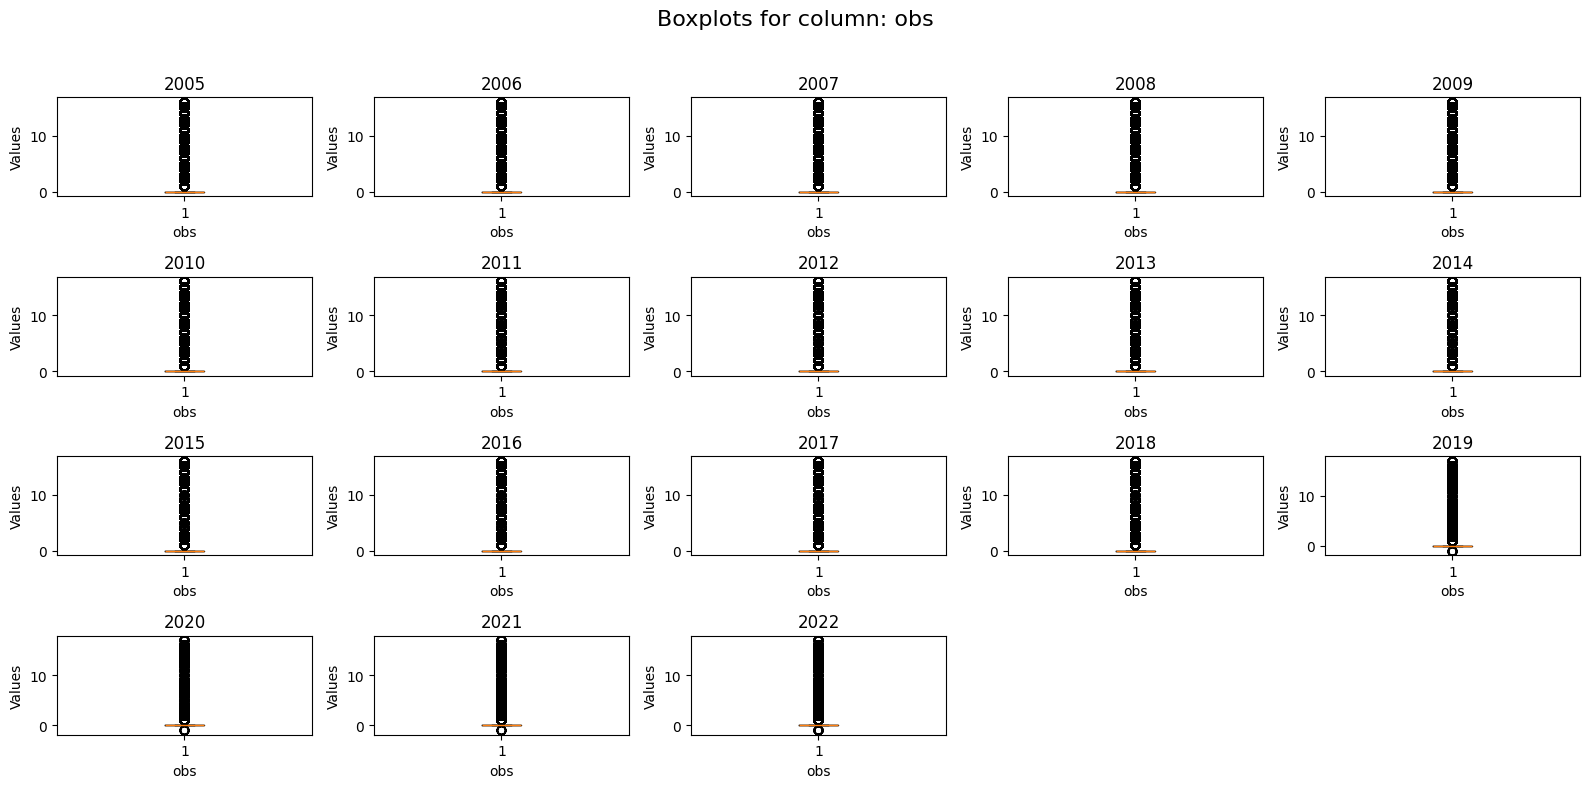

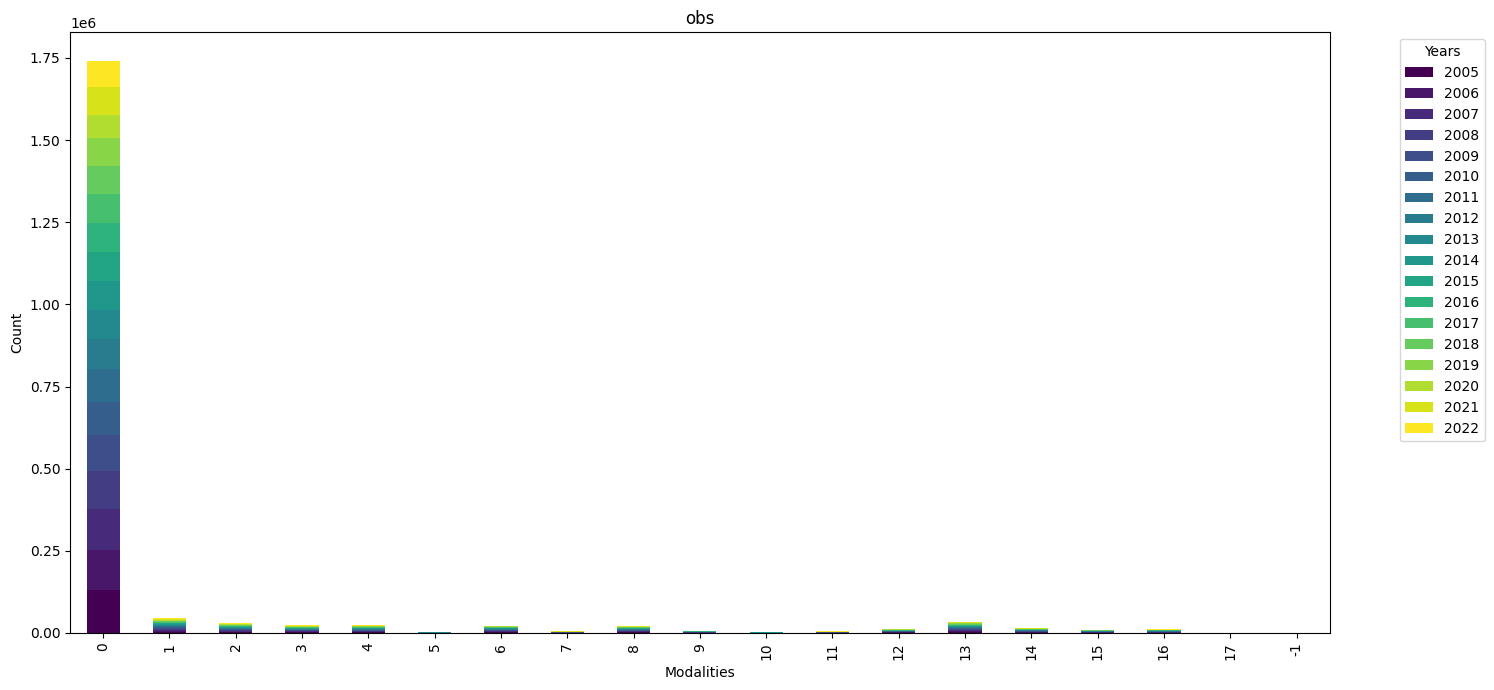

2024-06-10 17:12:27,165 - WARNING - Le nombre de modalités uniques dans la colonne obs excède le seuil de 12. Aucun graphique en ligne généré.



Colonne: obsm / lignes: 2009395
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  int64         2                              0                                  0
   2006  int64         2                              0                                  0
   2007  int64         2                              0                                  0
   2008  int64         2                              0                                  0
   2009  float64       2                              0.0989339                          6.22078e-05
   2010  float64       2                              0.0433147                          2.53808e-05
   2011  float64       2                              0.0667522                          3.78223e-05
   2012  float64       2                              0.0916703                          4.82732e-

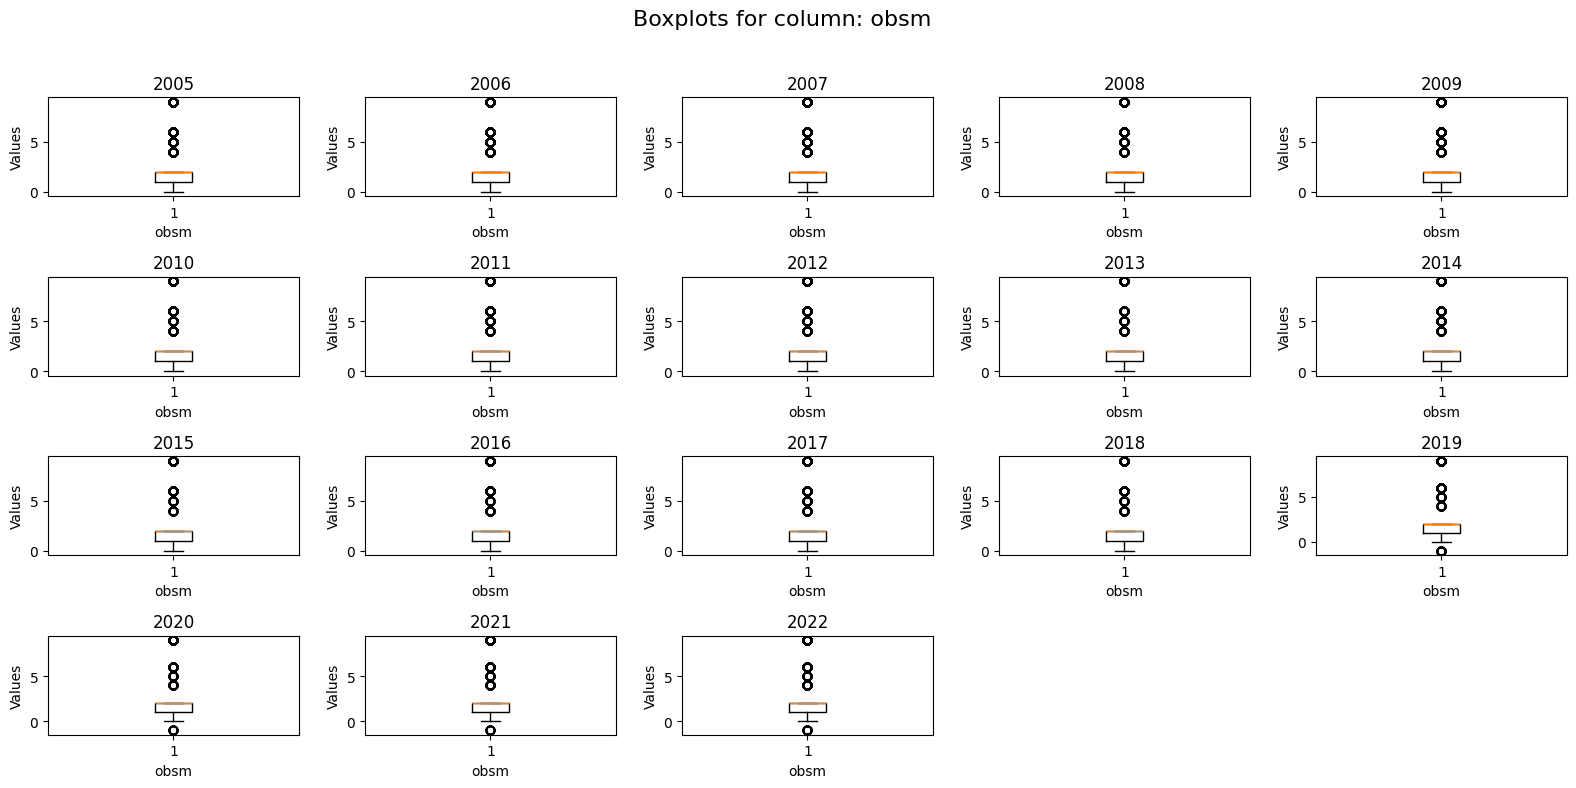

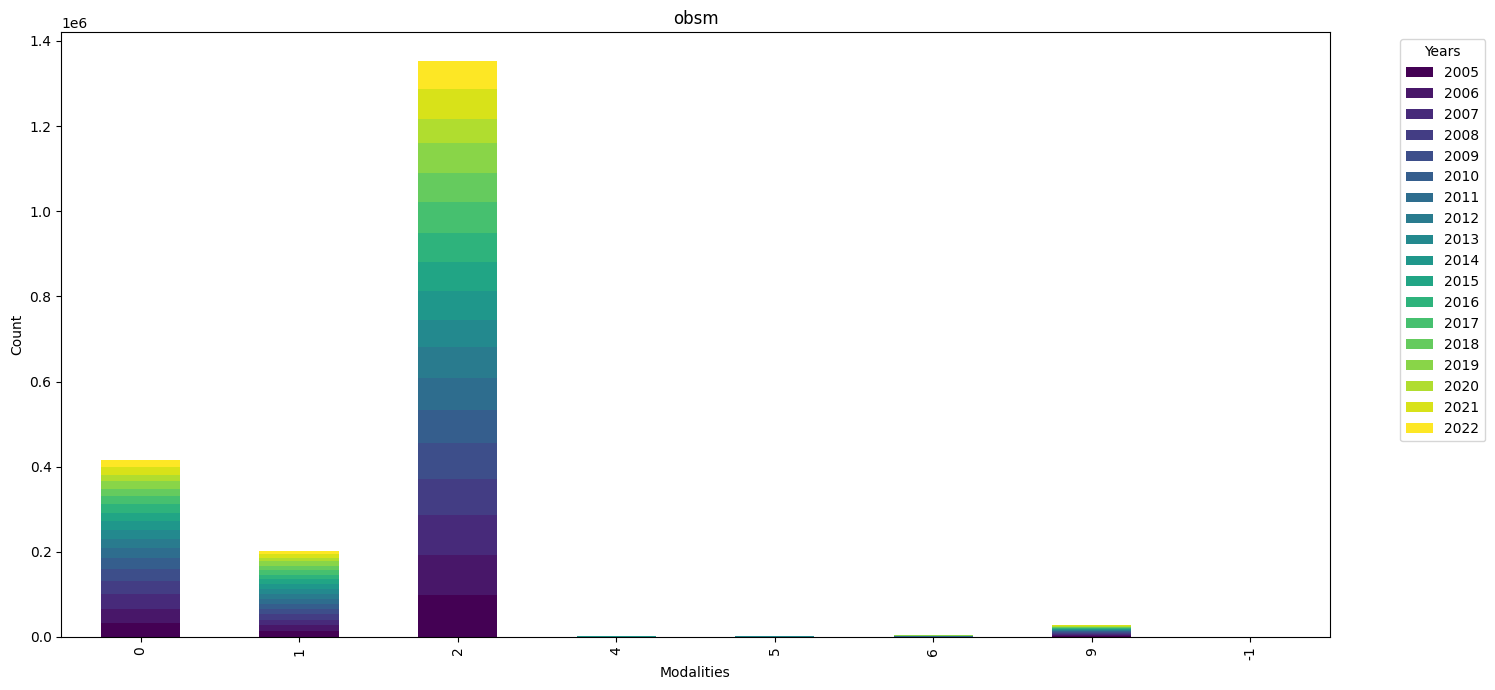

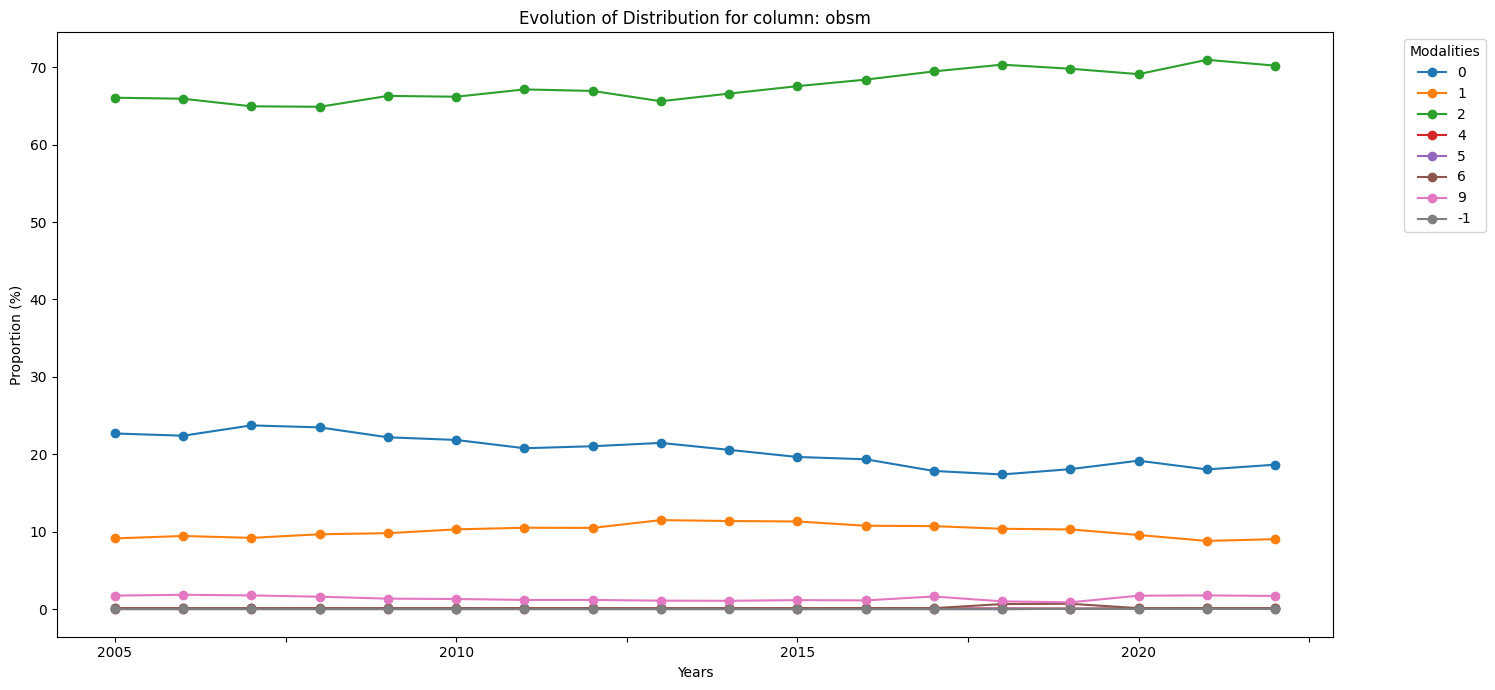


Colonne: manv / lignes: 2009395
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  int64         1                             0                                   0
   2006  int64         1                             0                                   0
   2007  int64         1                             0                                   0
   2008  int64         1                             0                                   0
   2009  float64       1                             0.0625262                           3.93153e-05
   2010  float64       1                             0.011041                            6.46961e-06
   2011  float64       1                             0.0447942                           2.53808e-05
   2012  float64       1                             0.0425275                           2.23948e-

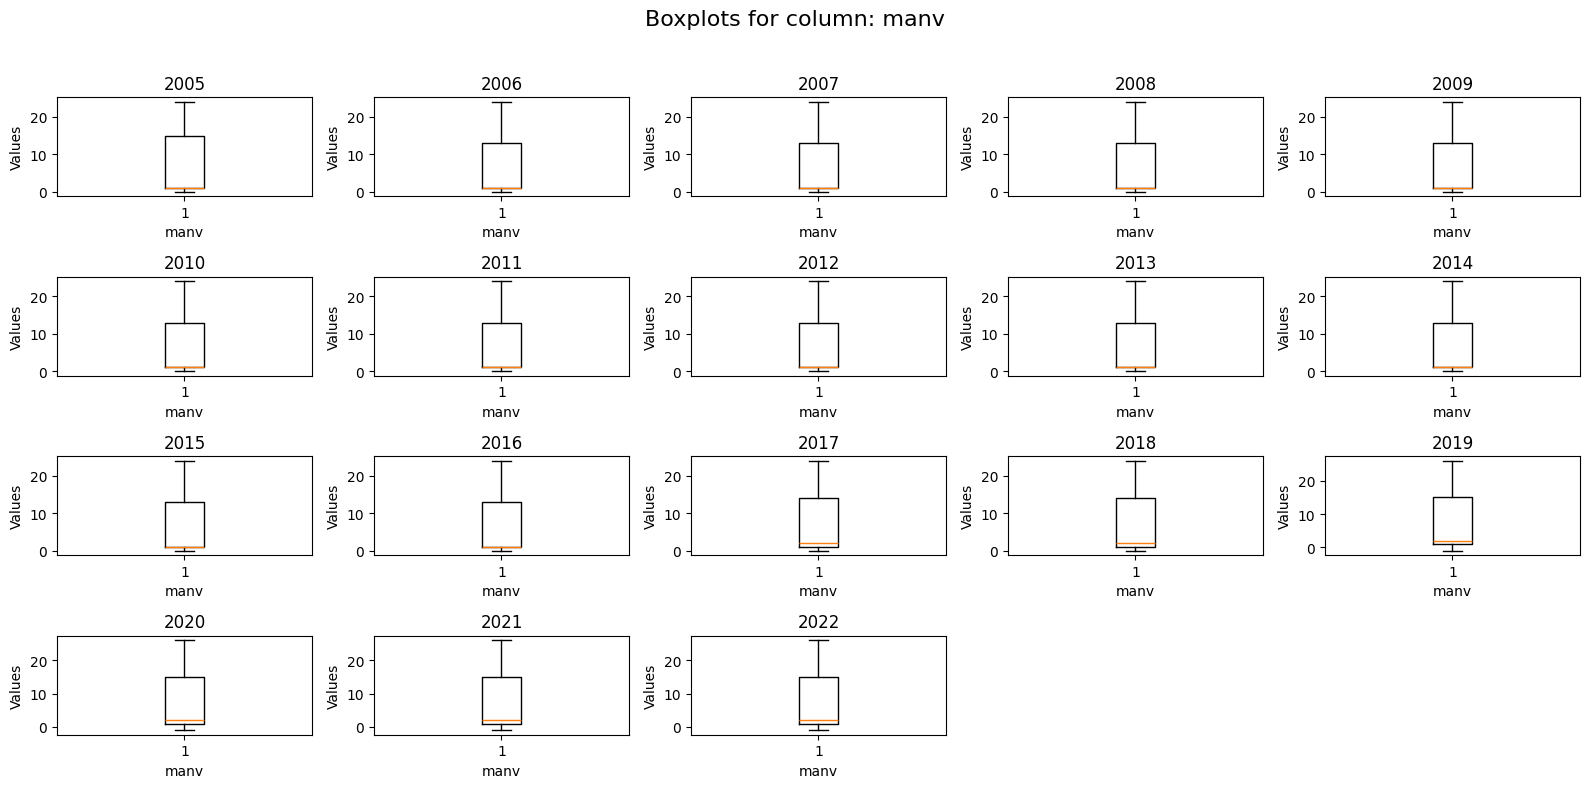

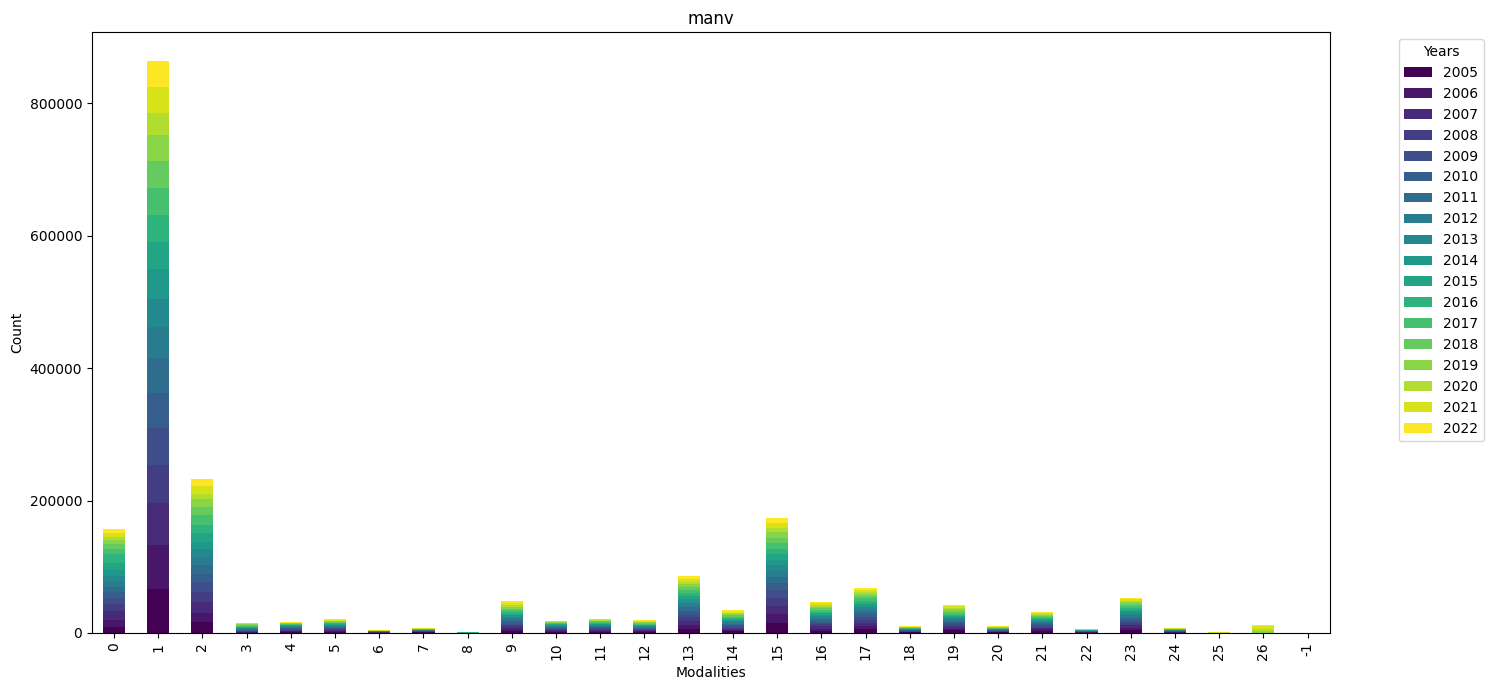

2024-06-10 17:12:32,869 - WARNING - Le nombre de modalités uniques dans la colonne manv excède le seuil de 12. Aucun graphique en ligne généré.


2024-06-10 17:12:33,243 - INFO - La colonne num_veh n'est pas numérique.
2024-06-10 17:12:33,329 - WARNING - Le nombre de modalités uniques dans la colonne num_veh excède le seuil de 50. Auncun bar plot généré.



Colonne: num_veh / lignes: 2009395
  Année  Type    Mode      Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  ------  -------------------------------------  -----------------------------------
   2005  object  A01                                         0                                    0
   2006  object  A01                                         0                                    0
   2007  object  A01                                         0                                    0
   2008  object  A01                                         0                                    0
   2009  object  A01                                         0                                    0
   2010  object  A01                                         0                                    0
   2011  object  A01                                         0                                    0
   2012  object  A01                                         0  

2024-06-10 17:12:33,490 - WARNING - Le nombre de modalités uniques dans la colonne num_veh excède le seuil de 12. Aucun graphique en ligne généré.



Colonne: senc / lignes: 2009395
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  int64         0                              0                                  0
   2006  int64         0                              0                                  0
   2007  int64         0                              0                                  0
   2008  int64         0                              0                                  0
   2009  int64         0                              0                                  0
   2010  int64         0                              0                                  0
   2011  int64         0                              0                                  0
   2012  int64         0                              0                                  0
   2013  int64         0             

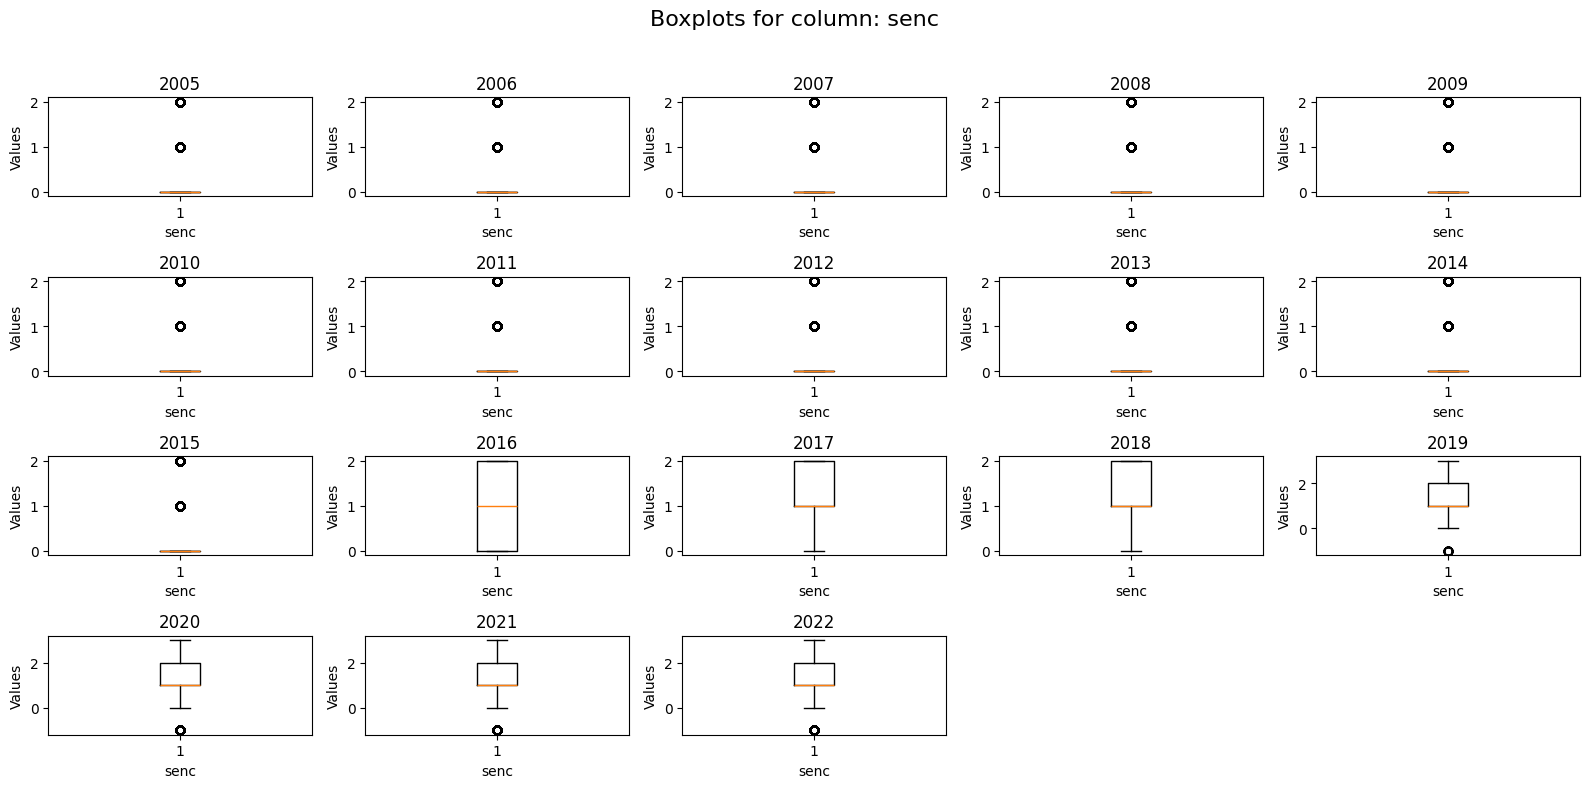

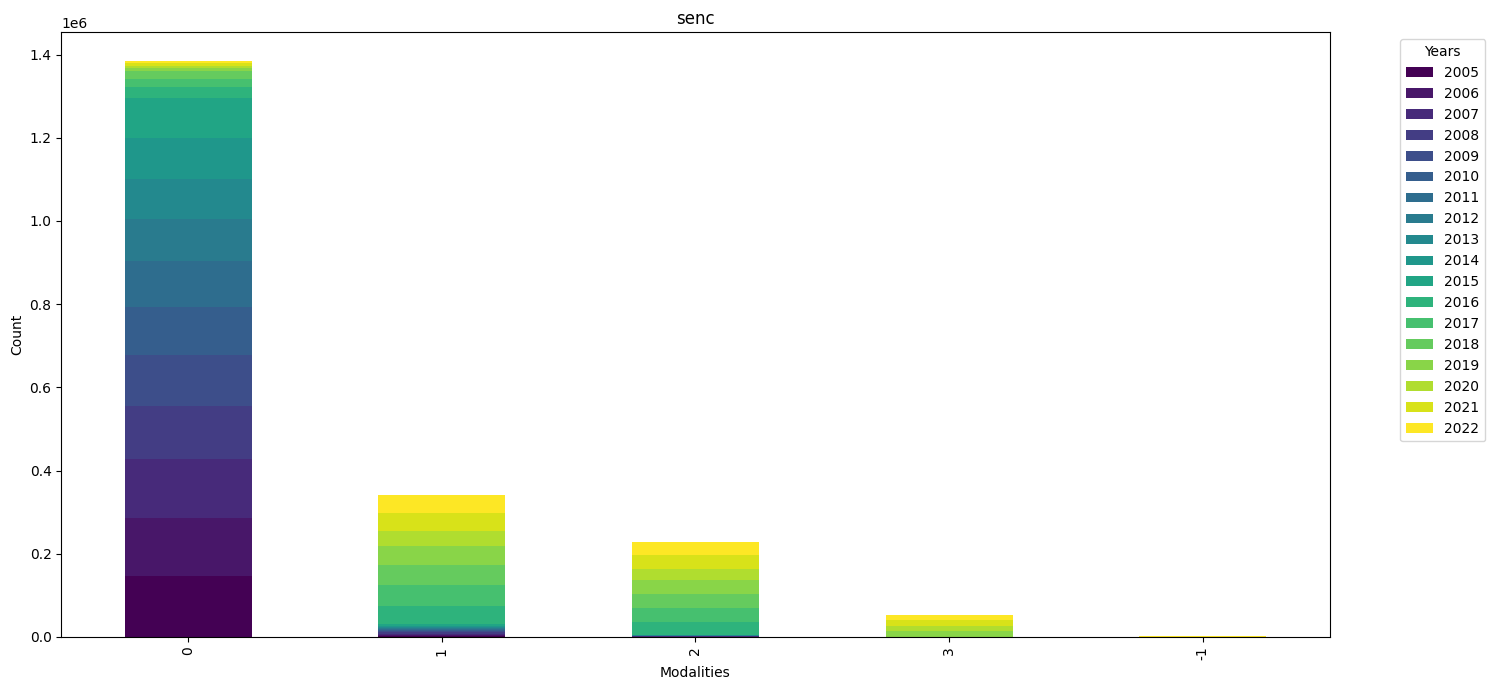

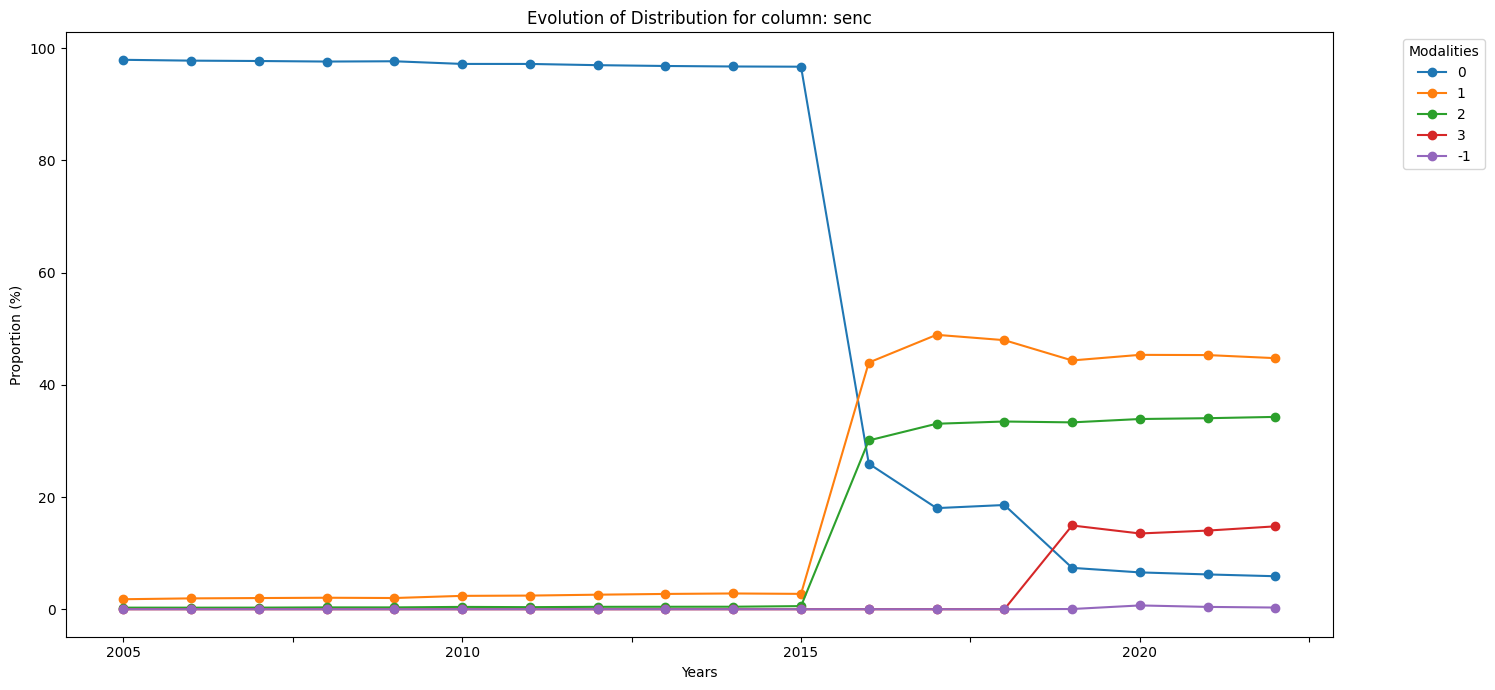


Colonne: Num_Acc / lignes: 2009395
  Année  Type         Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  ---------  -------------------------------------  -----------------------------------
   2005  int64   2.005e+11                                      0                                    0
   2006  int64   2.006e+11                                      0                                    0
   2007  int64   2.007e+11                                      0                                    0
   2008  int64   2.008e+11                                      0                                    0
   2009  int64   2.009e+11                                      0                                    0
   2010  int64   2.01e+11                                       0                                    0
   2011  int64   2.011e+11                                      0                                    0
   2012  int64   2.012e+11           

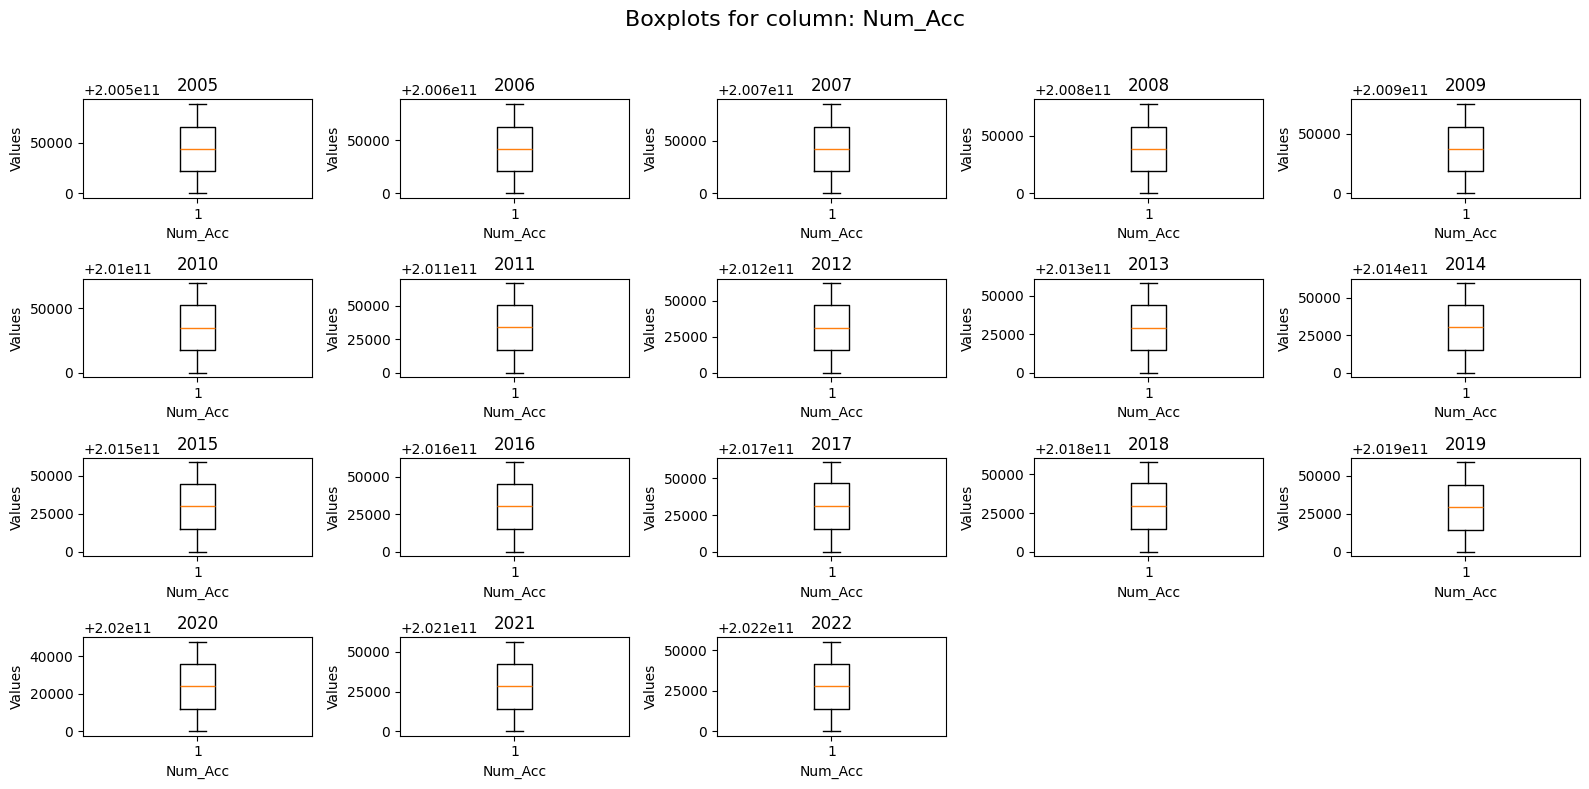

2024-06-10 17:12:38,972 - WARNING - Le nombre de modalités uniques dans la colonne Num_Acc excède le seuil de 50. Auncun bar plot généré.
2024-06-10 17:12:39,400 - WARNING - Le nombre de modalités uniques dans la colonne Num_Acc excède le seuil de 12. Aucun graphique en ligne généré.



Colonne: motor / lignes: 2009395
  Année  Type      Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  ------  -------------------------------------  -----------------------------------
   2019  int64        1                                      0                                    0
   2020  int64        1                                      0                                    0
   2021  int64        1                                      0                                    0
   2022  int64        1                                      0                                    0


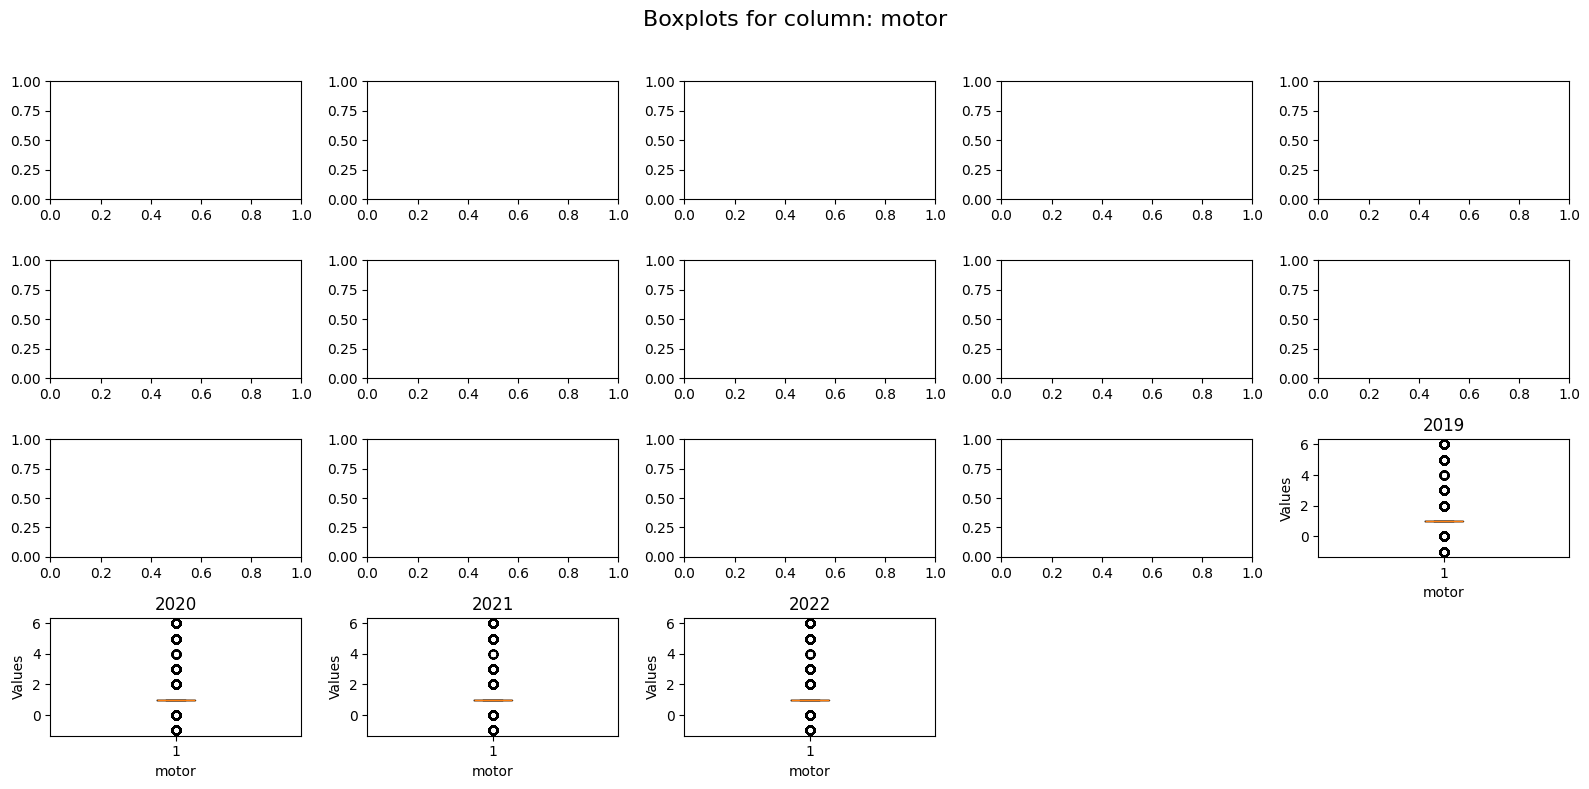

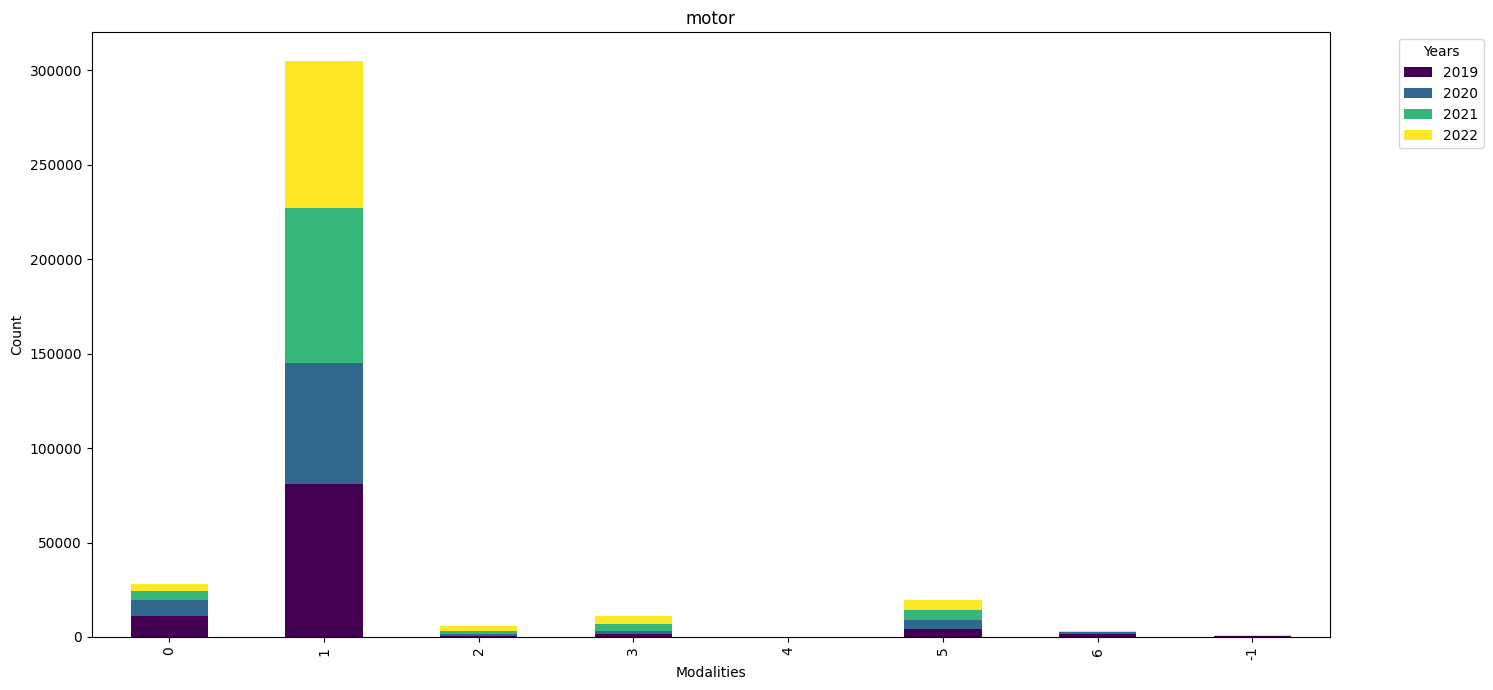

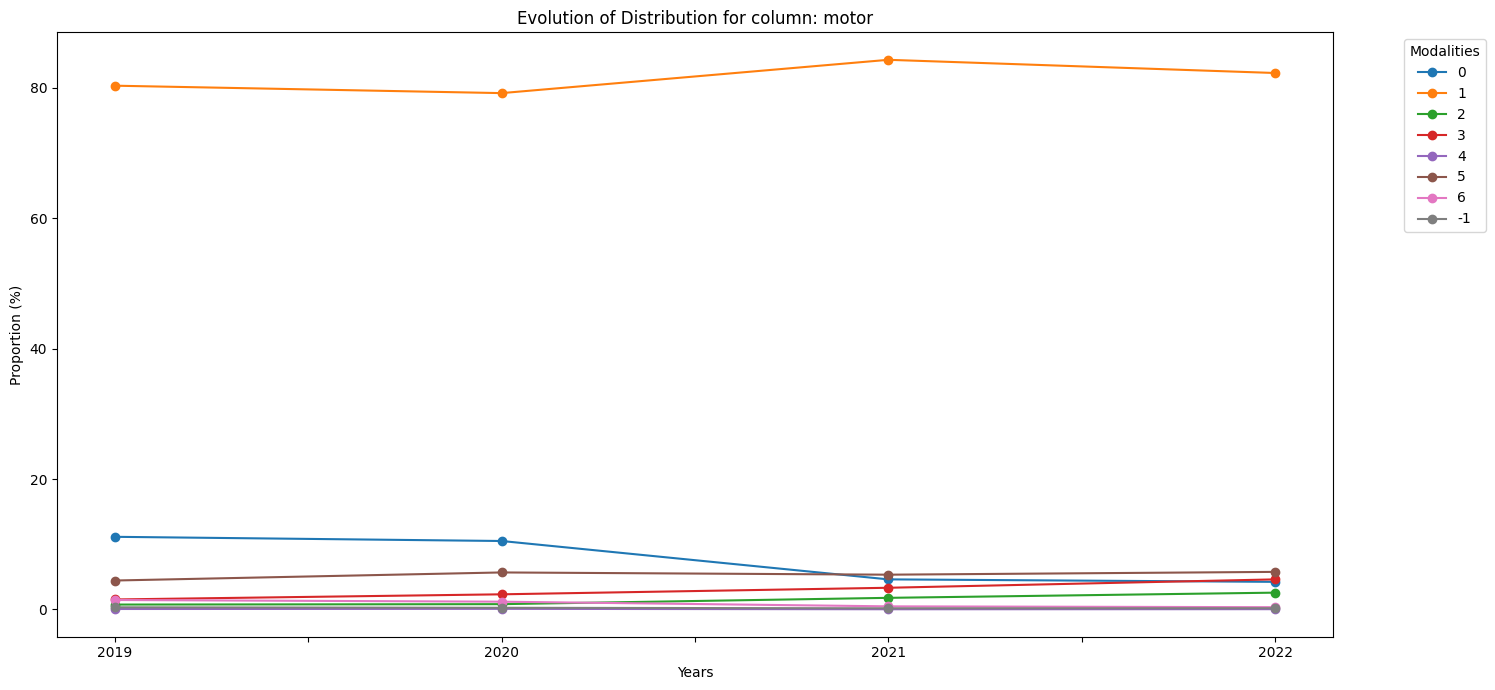


Colonne: catv / lignes: 2009395
  Année  Type      Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  ------  -------------------------------------  -----------------------------------
   2005  int64        7                                      0                                    0
   2006  int64        7                                      0                                    0
   2007  int64        7                                      0                                    0
   2008  int64        7                                      0                                    0
   2009  int64        7                                      0                                    0
   2010  int64        7                                      0                                    0
   2011  int64        7                                      0                                    0
   2012  int64        7                                      0     

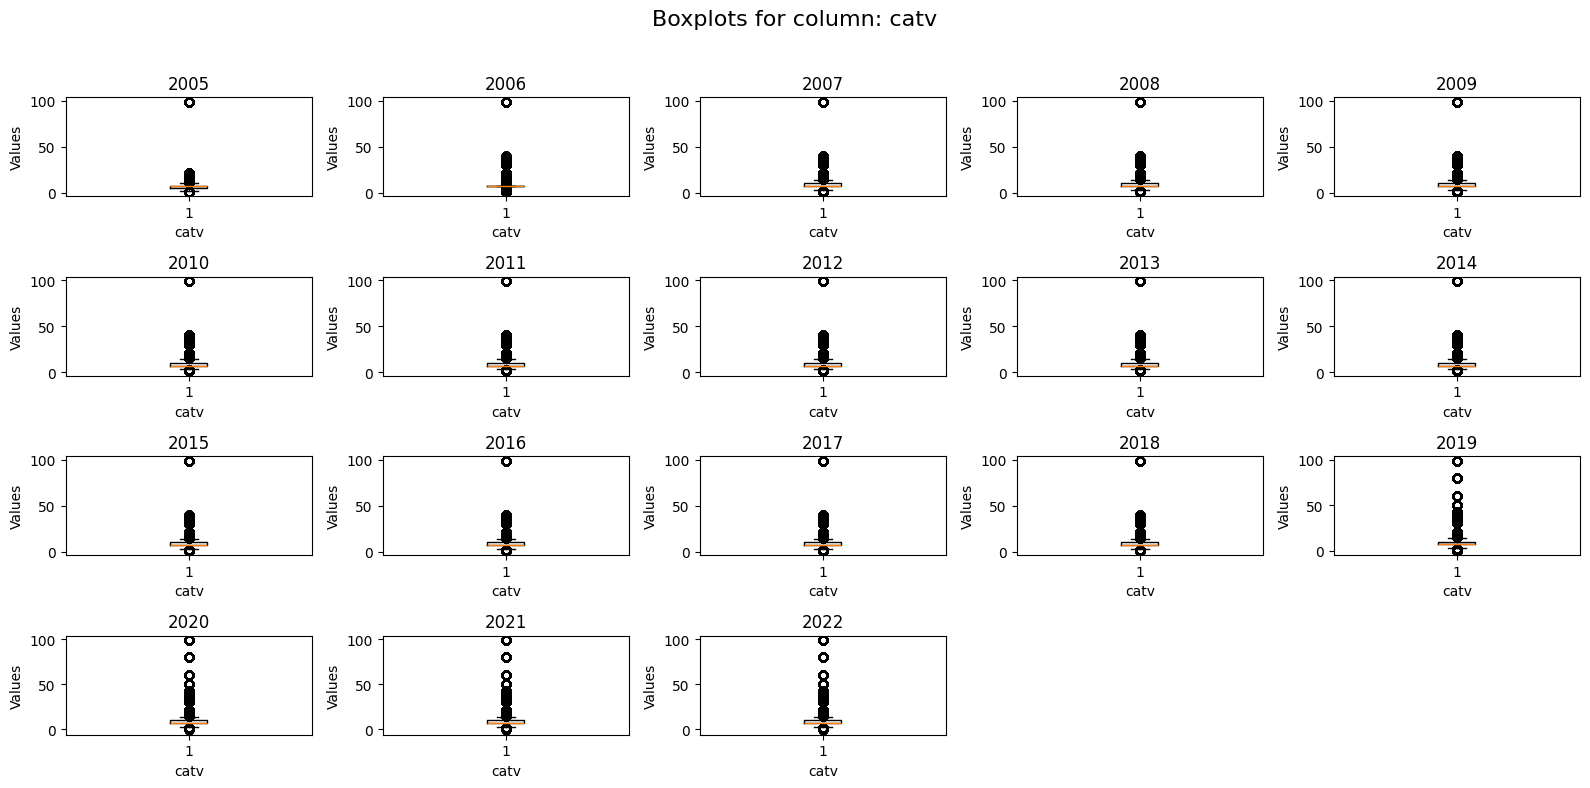

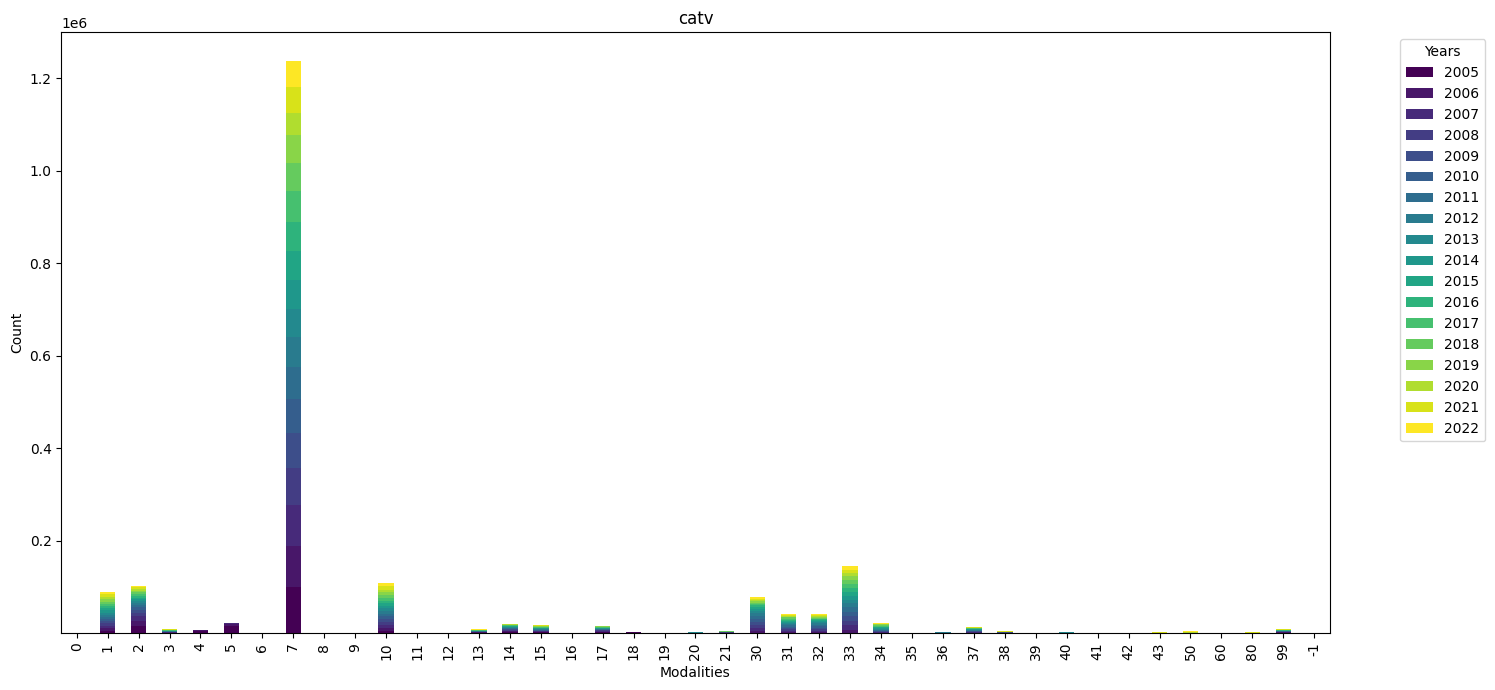

2024-06-10 17:12:46,187 - WARNING - Le nombre de modalités uniques dans la colonne catv excède le seuil de 12. Aucun graphique en ligne généré.



Colonne: occutc / lignes: 2009395
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  int64         0                                 0                                 0
   2006  int64         0                                 0                                 0
   2007  int64         0                                 0                                 0
   2008  int64         0                                 0                                 0
   2009  int64         0                                 0                                 0
   2010  int64         0                                 0                                 0
   2011  int64         0                                 0                                 0
   2012  int64         0                                 0                                 0
   2013  int64     

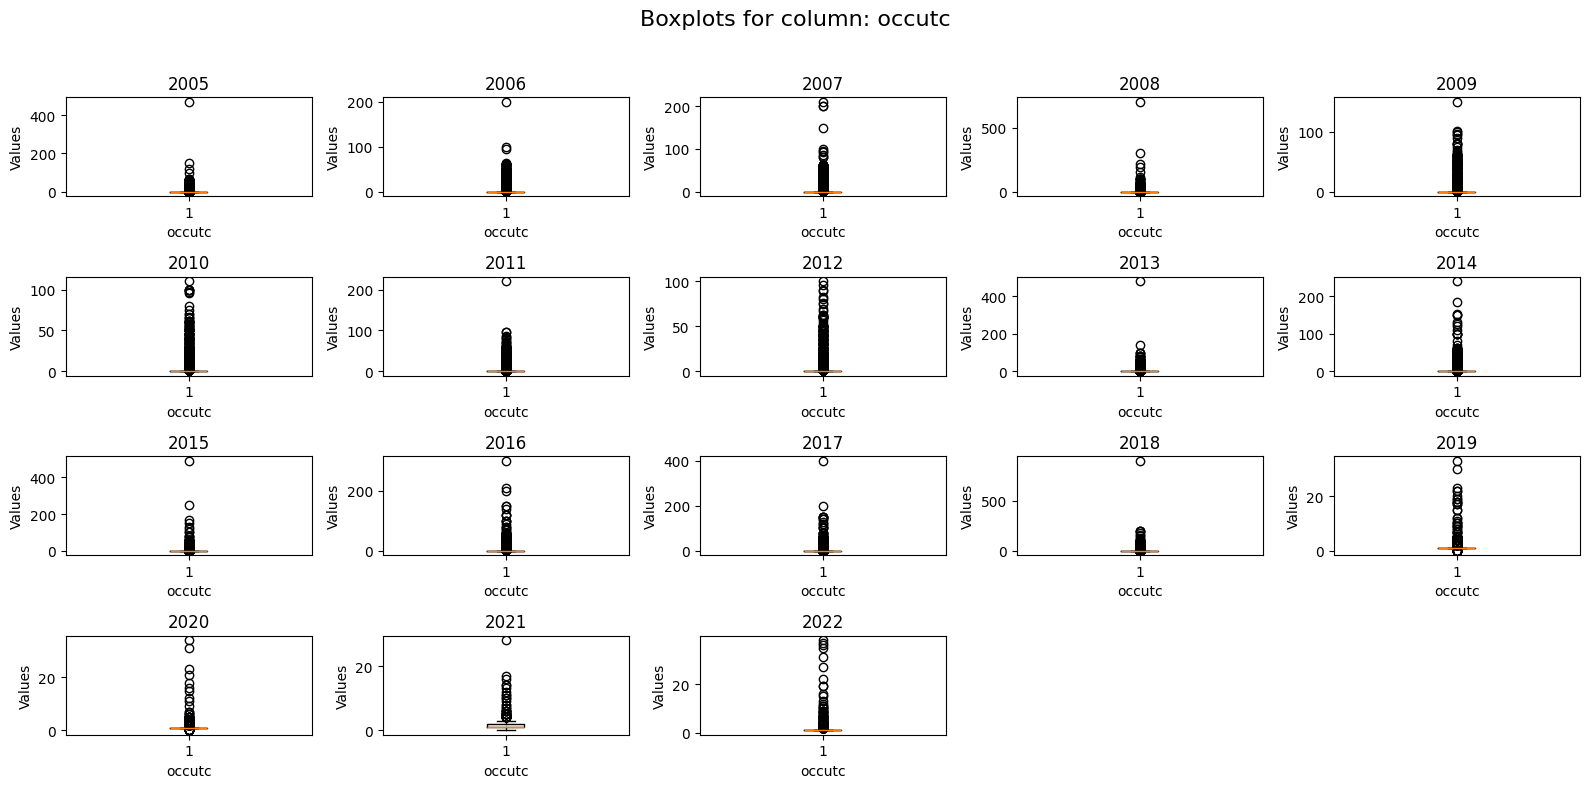

2024-06-10 17:12:48,147 - WARNING - Le nombre de modalités uniques dans la colonne occutc excède le seuil de 50. Auncun bar plot généré.
2024-06-10 17:12:48,169 - WARNING - Le nombre de modalités uniques dans la colonne occutc excède le seuil de 12. Aucun graphique en ligne généré.


In [311]:
for dataset_name, datasets in zip(prefixes, dataframes):
    analyze_all_columns(datasets, dataset_name)